In [99]:
"""
This notebook contains a simulator for protein-ligand
binding dynamics by random step. It incorporates
a probabilistic model for binding and unbinding of
the ligand, a model of organelle walls such that protein
and ligands are contained within this space, and a way to 
add ligands in the model as if they are being taken
in as the protein consumes the ligand.

The code block after defining the function 'main'
has the implementation of this code that you can run yourself!
In my definition of main I have default values that have been fun
to look at for me, but you can change them as you see fit. They
are all described in the docstring of main. All functions have a 
docstring and are heavily commented.

If you look through the notebook, I have already put in
a cell for you to run the simulation (you can control F
for 'run code here!'). I pasted with it the default parameters
of the function. If you are unsure of what each variable means,
there is a detailed docstring in the cell directly above that one
that describes what each of the parameters is/means.
"""
import numpy as np
from math import floor, ceil

from random import random # imports random generator from 0-1
from math import dist
import matplotlib.pyplot as plt
from matplotlib import animation, colors
import scipy.stats

import sys

In [100]:
# define constants
k_B = 1.38 * 10**(-23)
T = 293

In [101]:
class grid(object):
    """
    size = size of array
    d_prot = diffusion scaling constant of protein
    d_lig = diffusion scaling constant of protein
    prod_rate = many ligands/frame the model outputs
    ^ can be less than zero, then will have a prod_rate probability for producing a ligand every frame
    n_prots = number of proteins
    strength = strength of interaction, choose between 0-20.
    strength_unb = strength of unbinding 
    10 is neutral (no preference), x<10 is an unfavorable interaction, >10 is a favorable interaction.
    for both of these strength.
    For complementary strength values (i.e. the energy to bind is the energy to unbind),
    set strength_unb to 0.
    n_ligs = number of ligands
    window = how far a ligand can be from a protein to consider binding
    consume = True, consumption of ligand; False, binding of ligand (can be released)
    """
    
    def __init__(self,
               size = 10,
                d_prot = 1,
                d_lig = 3,
                prod_rate = 0,
                strength = 15,
                strength_unb = 0,
                n_prots = 5,
                n_ligs = 20,
                window = 2,
                consume=True,
               ):
        self.size = size
        self.nX = size
        self.nY = size
        self.window = window
        self.d_prot = d_prot
        self.d_lig = d_lig
        self.prod_rate = prod_rate
        self.consume = consume 
        self.strength = strength
        self.n_prots = n_prots
        self.n_ligs = n_ligs
        self.strength_unb = strength_unb

        # creates a 2D array of zeros to represent the particles (initialized with zero particles) at each x,y coordinate in the cell
        # also a coordinate for the bound species if we are looking at bound
        self.proteins = np.zeros((size,size))
        self.ligands = np.zeros((size,size))
        self.bound = np.zeros((size,size))

    def get_prots(self):
        """
        Returns the protein grid
        """
        return self.proteins
    
    def get_ligs(self):
        """
        Returns the ligand grid
        """
        return self.ligands
    
    def get_bound(self):
        """
        Returns the bound grid
        """
        return self.bound
    
    def nextX(self, x, step):
        """
        x: Int reprsenting x index of original location
        step: Int represensting size of step

        Returns the correct x index after moving step blocks
        to the right (to the left for negative step). Bounces off of the border
        of the organelle/cell membrane.
        Note: When calling nextX() in your update() function,
        you should use self.nextX(x, step)
        
        Note that 'bouncing' off the wall takes one 'step' and
        returns the particle to it's original position. Otherwise
        it moves in the opposite direction for the rest of the step.
    
        This is modified from assignment 3
        """
        if x + step >= self.nX:
            # bounces off walls
            return int(self.nX - 1 - (step - (self.nX - x)))
        elif x + step < 0:
            return int(- (step + x + 1))
        else:
            return int((x+step))


    def nextY(self, y, step):
        """
        y: Int reprsenting y index of original location
        step: Int represensting size of step

        Returns the correct y index after moving step blocks
        up (down for negative step). Bounces off of the border
        of the organelle/cell membrane.
        Note: When calling nextY() in your update() function,
        you should use self.nextY(y, step)
    
        This is modified from assignment 3
        
        Note that 'bouncing' off the wall takes one 'step' and
        returns the particle to it's original position. Otherwise
        it moves in the opposite direction for the rest of the step.
        """
        if y + step >= self.nY:
            # bounces off walls
            return int(self.nY - 1 - (step - (self.nY - y)))
        elif y + step < 0:
            return int(-(step +y+ 1))
        else:
            return int((y+step))


    def distrib_prots(self):
        """
        Used for initialization of protein locations within the grid.
        The proteins start out randomly distributed within the grid
        """
        # resets protein grid
        self.proteins = np.zeros((self.size,self.size))
        # randomly distribute proteins within the space
        for _ in range(self.n_prots):
            x_pos = floor(random() * self.size)
            y_pos = floor(random() * self.size)
            self.proteins[y_pos][x_pos] += 1

    def distrib_ligs(self):
        """
        Used for initialization of ligand locations within the grid.
        The ligands start out randomly distributed within the grid
        """
        # resets ligand grid
        self.ligands = np.zeros((self.size,self.size))
        # randomly distribute proteins within the space
        for _ in range(self.n_ligs):
            x_pos = floor(random() * self.size)
            y_pos = floor(random() * self.size)
            self.ligands[y_pos][x_pos] += 1
    
    def initialize(self):
        """
        Initializes the grid with the ligand and protein locations.
        """
        self.distrib_prots()
        self.distrib_ligs()
    
    def prob_bind(self, distance, unbind=False):
        """
        Computes the probability of binding or unbinding
        of a ligand to a protein.

        This is modeled as a two state system where the ligand
        is either bound or unbound, so there is a probability of
        >= 0.5 it will bind, since the energy of the bound complex
        is less than the energy of the unbound complex. This is taken
        from a Boltzmann model. The energy is modeled as correlating with
        (1/distance)**2 as they are typically electrostatic interactions.
        
        The opposite is true for unbinding, for which the probability decreases
        with strength and decreases, but the relationship between distance and
        the interaction remain the same (the ligand won't move that far away after
        unbinding).
        -------------------------------------
        inputs:
        distance: distance (float or int) the ligand needs to move to bind/unbind from the protein
        unbind: bool value dictating whether we want to comput probability
        of binding (False) or unbinding (True)
        
        outputs:
        float representing probability that the event will occur.
        """
        # get appropriate binding strength
        if not unbind:
            k  = self.strength
        else:
            k = self.strength_unb
            if k == 0:
                k = 20 - self.strength
                #print('unb', prob)
        # if favorable interaction, calculate probability of changing state
        if k >= 10:
            k -= 10
            prob = 1/(1+np.exp(-k*10**(-21)*(1/distance)/(k_B * T)))
            #print('bind', prob)

        # if unfavorable interaction, calculate probability of changing state
        else:
            k = 10 - k
            prob = 1/(1+np.exp(k*10**(-21)*(1/distance)/(k_B * T)))
        return prob
        

    def find_contacts(self):
        """
        This function finds all ligand-protein contacts
        within the contact 'window' (i.e. all contacts within
        a reasonable binding distance)
        outputs: a nested list that has entries of the form
        [[ligand_y,ligand_x],[(dist1, [prot_loc1_y, prot_loc1_x]),(dist2, [prot_loc2_y, prot_loc2_x]),...],...]
        """
        # find where proteins are
        prot_locs_tup = np.nonzero(self.proteins)
        prot_locs = np.array(list(zip(prot_locs_tup[0], prot_locs_tup[1])))
    
        contacts_lst = []
        # iterate through ligand positions
        for row in range(self.nY):
            for col in range(self.nX):
                # check if there is a ligand there before calculating
                if self.ligands[row][col]:
                    # initialize lists of distances to proteins and protein location
                    distances = []
                    prot_locs_to_add = []
                    # iterate through protein locations
                    for prot_loc in prot_locs:
                        # calculate distance between ligand and protein
                        distance = dist(prot_loc,[row,col])
                        # check if distance is in the 'window' for binding
                        if distance <= self.window:
                            # account for the fact that multiple proteins and/or ligands
                            # can be at the same location
                            num_prots = int(self.proteins[prot_loc[0]][prot_loc[1]])
                            num_ligs = int(self.ligands[row][col])
                            perms = num_prots * num_ligs
                            # add number of distances that there are permuatations
                            # of ligand-protein interactins for those positions
                            for _ in range(perms):
                                distances.append(distance)
                                prot_locs_to_add.append([prot_loc[0],prot_loc[1]])
                    if distances:
                        combined = list(zip(distances,prot_locs_to_add))
                        # sort distances so we are favoring shorter distances
                        combined.sort()
                        contacts_lst.append([[row,col],combined])

        # list is in the form [[ligand_y,ligand_x],[(dist1, [prot_loc1_y, prot_loc1_x]),(dist2, [prot_loc2_y, prot_loc2_x]),...],...]
        return contacts_lst


    def bind_lig(self,contacts_lst):  
        """
        Binds ligands by computing the probability
        of each binding event and randomly determining
        whether that event is successful or not. Modifies
        the ligand, protein, and bound grids accordingly.
        
        Depending on whether the grid is 'consuming' or 'binding'
        the ligand, it will remove the ligand from the grid or add
        a bound protein-ligand to the bound grid respectfully.
        
        input:
        contacts_lst: the output from grid.find_contacts()
        """
        done_prots = []
        # iterate through contact in contacts
        for contact in contacts_lst:
            done = False
            # get ligand position and distanct to protein location
            pos = contact[0]
            dist_and_prot_locs = contact[1]
            for i, combo in enumerate(dist_and_prot_locs):
                prot_loc = combo[1]
                distance = combo[0]
                # check if this protein has already been bound
                # or if the ligand has already been bound
                if done == True or prot_loc in done_prots:
                    break
                # make it so even if occupying same space in grid
                # there is a probability it won't bind
                if distance == 0:
                    distance = 0.4
                prob = self.prob_bind(distance)
                ran = random()
                # check if ligand binds
                if ran < prob:
                    if self.consume:
                        word = ' consumed'
                    else:
                        word = ' bound'
                    print('Ligand at ' + str(pos[1]) + ',' + str(pos[0]) + word)
                    # this ligand has been used, so remove from ligand grid
                    self.ligands[pos[0]][pos[1]] -= 1

                    if not self.consume:
                        # if the ligand isn't consumed, add this to the bound library
                        # also remove protein since it's not free to bind other ligands
                        self.proteins[prot_loc[0]][prot_loc[1]] -= 1
                        self.bound[prot_loc[0]][prot_loc[1]] += 1

                    # dont bind the ligand to more than 1 protein
                    # and don't bind the protein to multiple ligands
                    done = True
                    done_prots.append(prot_loc)


    def move(self, row,col,delta):
        """
        Moves an item randomly within a grid
        
        inputs:
        row: int, row index of item
        col: int, column index of item
        delta: float, the diffusion coefficient of the item
        
        outputs:
        an X,Y (both ints) pair representing the
        new location of the item.

        Modified from HW 3
        """
        # Introduce some randomness in step size
        stepSize = delta - (random() > 0.7)
        rand = random()
        # randomly step up, down, left, or right
        if 0 <= rand and rand < 0.25:
            X = self.nextX(col,stepSize)
            Y = row
        elif 0.25 <= rand and rand < 0.5:
            X = self.nextX(col,-stepSize)
            Y = row
        elif 0.5 <= rand and rand < 0.75:
            Y = self.nextY(row,stepSize)
            X = col
        else:
            Y = self.nextY(row,-stepSize)
            X = col
        return (X,Y)


    def unbind_lig(self):
        """
        Similarly to bind_lig, computes the
        probability of a protein-ligand complex
        unbinding, and determines whether it
        is successful or not.
        
        Modifies the proteins, ligands, and bound grid accordingly.
        """
        # doesn't apply if the ligand is consumed
        if self.consume:
            pass
        else:
            # find where there are bound species
            bound_locs_tup = np.nonzero(self.bound)
            bound_locs = np.array(list(zip(bound_locs_tup[0], bound_locs_tup[1])))
            for bound_loc in bound_locs:
                row = bound_loc[0]
                col = bound_loc[1]
                # calculate probability of unbinding, distance
                # ligand will move is 1
                prob = self.prob_bind(1,unbind=True)
                rand = random()
                #print('unb prob',prob)
                if rand < prob:
                    print('Complex at ' + str(col) + ',' + str(row) + ' unbound')
                    # remove bound complex from bound grid
                    self.bound[row][col] -= 1
                    self.proteins[row][col] += 1
                    self.ligands[row][col] += 1

    
    def update_rand(self):
        """
        Updates the protein, bound, and ligands grids after moving
        each species either randomly.

        modified from HW 3
        """
        # First, we will initialize a new blocks array with the same dimensions.
        # All values in new blocks are set to 0, which you will update in your code below.
        # Note that the y coordinate is the row, and the x coordinate is the column, and that
        # (0,0) corresponds to the lower left corner of the plot.

        # initialize new grids
        new_prot = np.zeros((self.nY, self.nX))
        new_lig = np.zeros((self.nY, self.nX))
        new_bound = np.zeros((self.nY, self.nX))
        news = [new_prot, new_lig, new_bound]
        lst = [self.proteins, self.ligands,self.bound]
    
        # Next, we will iterate through the coordinates of our cell,
        # so that we can then iterate through each particle at that coordinate.
        # also iterate through types of molecule (proteins, ligands, bound)
        difs = [self.d_prot, self.d_lig, self.d_prot]
        for i in range(3):
            for row in range(self.nY):
                for col in range(self.nX):
                    numberOfPart = lst[i][row, col]
                    # The delta/step size depend on the diffusion constant which is set in
                    # the main method
                    delta = ceil(difs[i])
                    # Now we will iterate through every particle in each block
                    for part in range(int(numberOfPart)): 
                        X,Y = self.move(row,col,delta)
                        news[i][Y][X] += 1
        # modified from HW 3
        self.proteins = news[0]
        self.ligands = news[1]
        self.bound = news[2]


    def source_lig(self):
        """
        If prod_rate is >= 1, will add prod_rate amount
        of ligand to 0,0 of the grid.
        If prod_rate is < 1, will add a single ligand
        to 0,0 of teh grid with probability prod_rate.
        """
        prod_rate = self.prod_rate
        # if prod rate >= 1 then add in n ligands
        # per iteration
        if prod_rate >= 1:
            self.ligands[0][0] += prod_rate
            print('Ligand added')
        # if prod rate < 1, there is an n probability
        # of a ligand generating
        else:
            rand = random()
            if rand < prod_rate:
                self.ligads[0][0] += 1
                print('Ligand added')
    
    def iterate(self):
        """
        Simulates a time step.
        Ligands unbind, rebind, and species move.
        Modified from HW3
        """
        # produce new liands
        self.source_lig()
        # potentially bind ligands + proteins
        self.bind_lig(self.find_contacts())
        # potentially unbind bound species
        self.unbind_lig()
        # move everything
        self.update_rand()

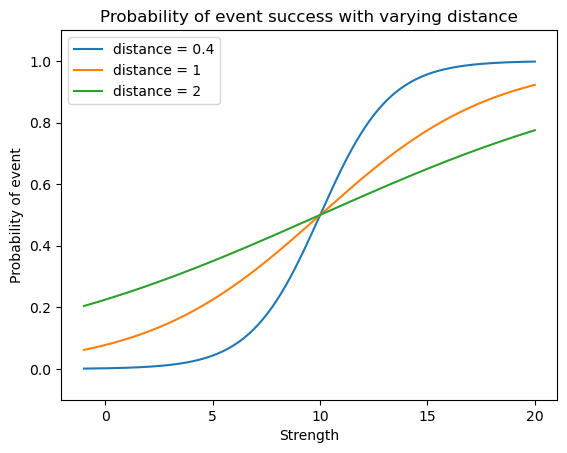

In [102]:
def prob_bind(strength, distance, unbind=False):
    """
    This is taken and modified from above to demonstrate how strength influences
    the probability of an event happening.
     """
        # get appropriate binding strength
    k = strength
        # if favorable interaction, calculate probability of changing state
    if k >= 10:
        k -= 10
        prob = 1/(1+np.exp(-k*10**(-21)*(1/distance)/(k_B * T)))
        # if unfavorable interaction, calculate probability of changing state
    else:
        k = 10 - k
        prob = 1/(1+np.exp(k*10**(-21)*(1/distance)/(k_B * T)))
    return prob


# test the probability of binding and unbinding to tunt to what you would like
strength = 15
distance = 1
unbind = True

x = np.linspace(-1,20,200)
y = []
y2 = []
y3 = []
for x_val in x:
    y.append(prob_bind(x_val, distance))
    y2.append(prob_bind(x_val,distance*2))
    y3.append(prob_bind(x_val,distance*0.4))
    
plt.plot(x,y3,label="distance = 0.4")
plt.plot(x,y,label="distance = 1")
plt.plot(x,y2,label="distance = 2")
plt.title(f'Probability of event success with varying distance')
plt.xlabel('Strength')
plt.ylabel('Probability of event')
#plt.plot(x,z, label='unbinding')
plt.ylim([-0.1, 1.1])
plt.legend()

#print(x)
#print(prob_bind(strength,distance,unbind=unbind))

In [103]:
def test_print(diff):
    print('prot: \n', diff.proteins)
    print()
    print('ligands: \n', diff.ligands)
    print()
    print('bound: \n', diff.bound)

In [104]:
blues = ['lightblue', 'dodgerblue', 'blue', 'mediumblue', 'navy']
reds = ['darkred', 'firebrick', 'indianred', 'lightcoral','pink']
blks = ['black', 'black', 'grey', 'grey', 'silver']

def make_arrays(grid):
    # makes arrays that can be separated
    # on color for a certain grid
    g5 = np.nonzero(grid > 5)
    g4 = np.nonzero(grid == 4)
    g3 = np.nonzero(grid == 3)
    g2 = np.nonzero(grid == 2)
    g1 = np.nonzero(grid == 1)
    return (g5, g4, g3, g2, g1)

def get_grids(diff):
    # gets the protein, ligand, and bound grids
    # from the diffuser
    grid_p = diff.get_prots()
    grid_l = diff.get_ligs()
    grid_b = diff.get_bound()
    p_grids = make_arrays(grid_p)
    l_grids = make_arrays(grid_l)
    b_grids = make_arrays(grid_b)
    return (p_grids, l_grids, b_grids)

In [105]:
def main(length=8, consume=True, d_lig=4, d_prot=1,
         strength=16, prod_rate=0, strength_unb=0,
         n_ligs=12, n_prots=6, window=2,
         show_move=True,show_lig=True, show_bound=True,its=20):
    """
    length: (int) size (x = y) of the plane

    consume: (bool) True if the ligand is removed from grid after
    binding to protein. False if can bind and unbind

    d_prot:  (int) diffusion constant for protein (and bound species)

    d_lig: (int) diffusion constant of ligand (keep it < length +1)

    prod_rate: (int if > 1, float if < 1, must be >0) 
    how many ligands to add to the grid per iteration OR 
    if < 1 probability of ligand being added to the grid

    strength_unb: (float) strength of unbinding (keep 0 if complementary
    to strength)

    window: (int) how far away a ligand can be from a protein for
    there to be a potential binding event

    n_ligs: (int) number of ligands in simulation (initial)

    n_prots: (int) number of proteins in simulation

    show_move: (bool) show physical representation of molecules

    show_lig: (bool) show colormap of ligand population

    show_bound: (bool) show colormap of bound population
    
    its: (int) number of iterations of the simulation
    """
    iters = its # number of iterations for diffusion
    cm = "cool"
      
    c = grid(size =length,
        d_prot = d_prot,
        d_lig = d_lig,
        prod_rate = prod_rate,
        strength = strength,
        strength_unb=strength_unb,
        n_prots = n_prots,
        n_ligs = n_ligs,
        window=window,
        consume=consume,
        )
    c.initialize()

    # This portion of the code runs the simulation through matplotlib
    for l in range(iters):
        # this is modified from HW 3
        print(l)
        p_grids, l_grids, b_grids = get_grids(c)

        # un-comment the line below to 'fix' the colorbar to the range [0,3] so it is not longer dynamic
        # 'Fixing' the colorbar will make visualization easier, but may cut off the higher values

        if show_move:
            # get grids to plot ligands, proteins, and bound
            # darker blacks, reds, and blues mean more species/space
            for i, b_grid in enumerate(b_grids):
                plt.scatter(b_grid[1],b_grid[0], c=blks[i], s=700)
    
            for i, p_grid in enumerate(p_grids):
                plt.scatter(p_grid[1], p_grid[0], c=reds[i], s=500)
            
            for i, l_grid in enumerate(l_grids):
                plt.scatter(l_grid[1],l_grid[0], c=blues[-(i+1)], s=100)
            plt.xlim([-.5,length - .5])
            plt.ylim([-.5,length - .5])
            plt.xlabel("Iteration %d"%l)
            plt.title("Location of species (darker colors = multiple in the same place)")
        if show_lig:
            # Color map of ligands
            plt.figure("Color map")
            plt.pcolor(np.array([i for i in range(length+1)]),np.array([j for j in range(length+1)]),c.get_ligs(),cmap = cm)
            plt.colorbar()
            plt.clim(0,3) 
            plt.title("Colormap of ligand amount")
        if not consume and show_bound:
            # Color map of bound species
            plt.figure("Color map 2")
            plt.pcolor(np.array([i for i in range(length+1)]),np.array([j for j in range(length+1)]),c.get_bound(),cmap = cm)
            plt.colorbar()
            plt.clim(0,3) 
            plt.title("Colormap of bound species amount")
        plt.pause(0.1)
        c.iterate()

        # this was used for results and analysis
        # if np.sum(c.get_ligs()) == 0:
        #     return l
        # if l == iters - 1:
        #     return l*1.1

        # this was used for results and analysis
        # if l == iters - 1:
        #     ligs = c.get_ligs()
        #     bound = c.get_bound()
        #     prot = c.get_prots()
        #     #print(f'{np.sum(ligs)} free ligands')
                #print(f'{np.sum(bound)} bound species')

            # return np.sum(ligs)*np.sum(prot)/np.sum(bound)
        plt.clf()

0


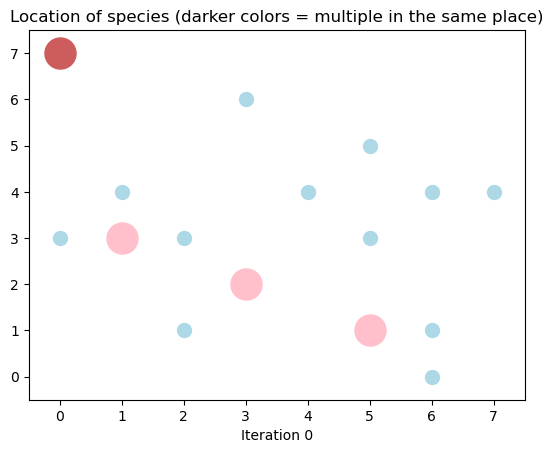

Ligand at 6,0 consumed
Ligand at 0,3 consumed
1


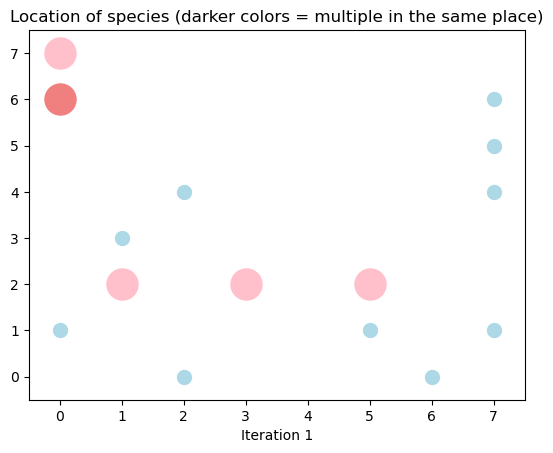

2


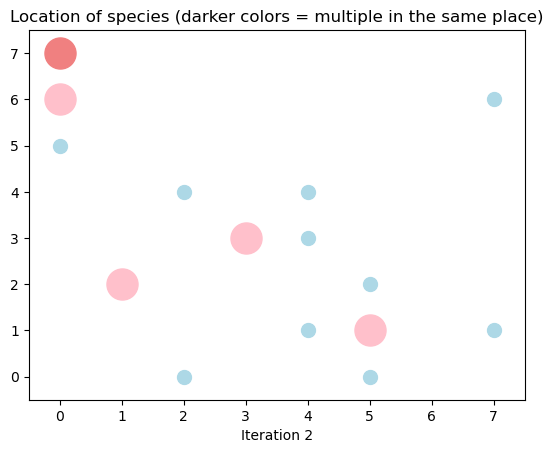

Ligand at 5,0 consumed
Ligand at 4,3 consumed
Ligand at 0,5 consumed
3


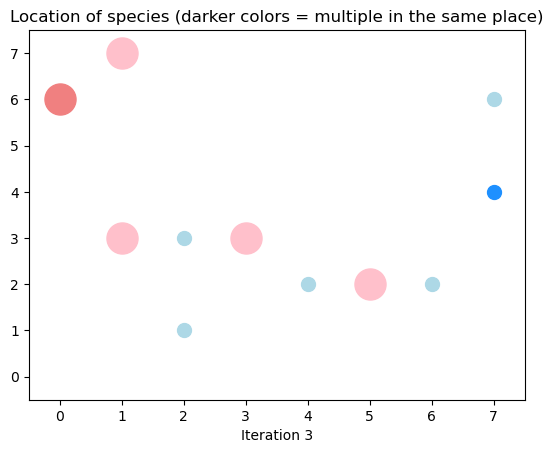

Ligand at 4,2 consumed
Ligand at 6,2 consumed
4


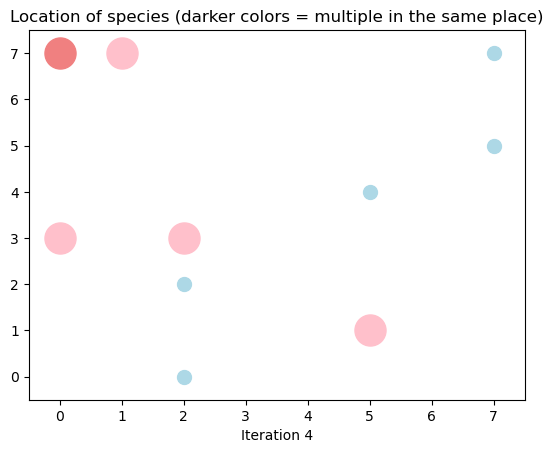

5


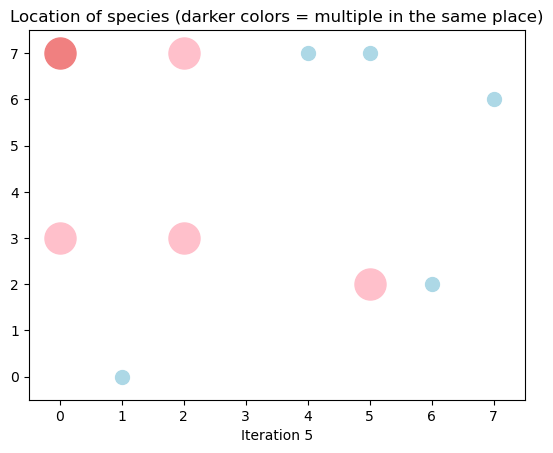

Ligand at 4,7 consumed
6


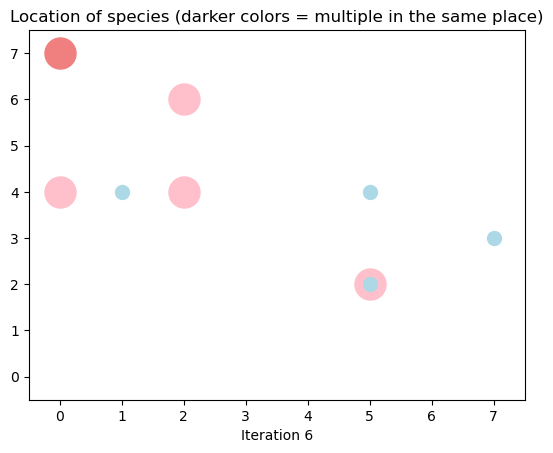

Ligand at 5,2 consumed
Ligand at 1,4 consumed
7


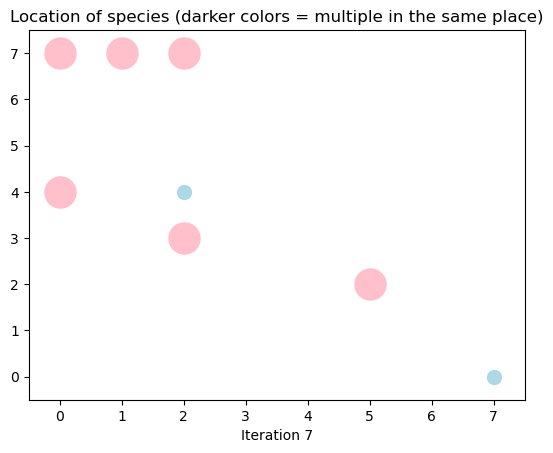

Ligand at 2,4 consumed
8


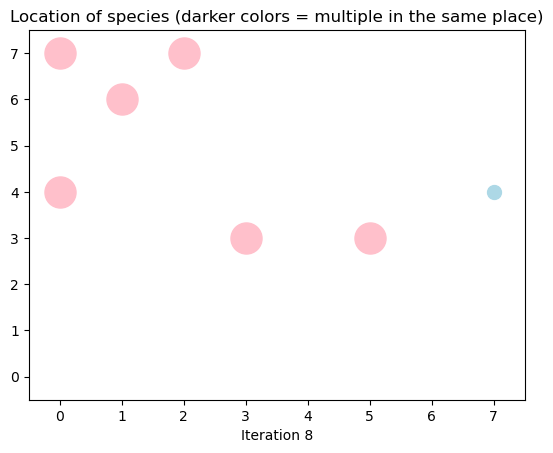

9


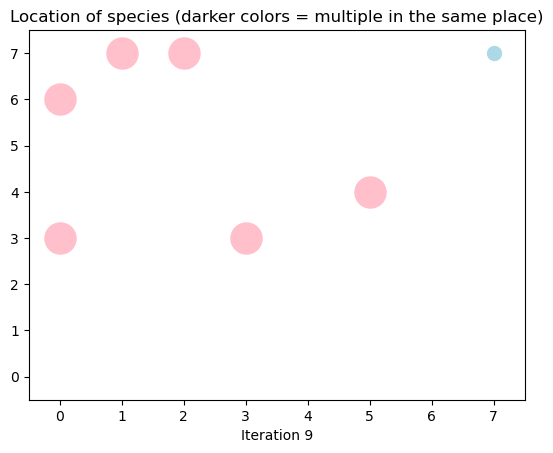

10


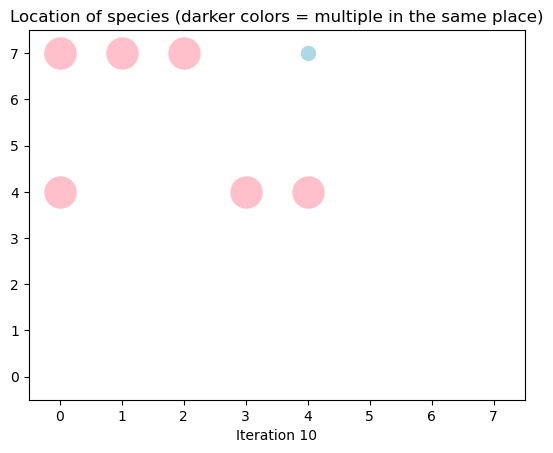

11


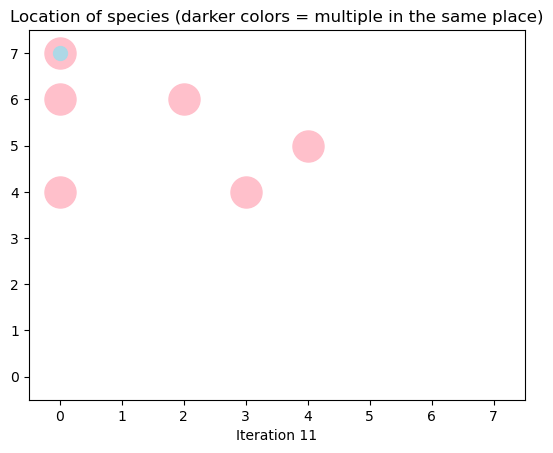

Ligand at 0,7 consumed
12


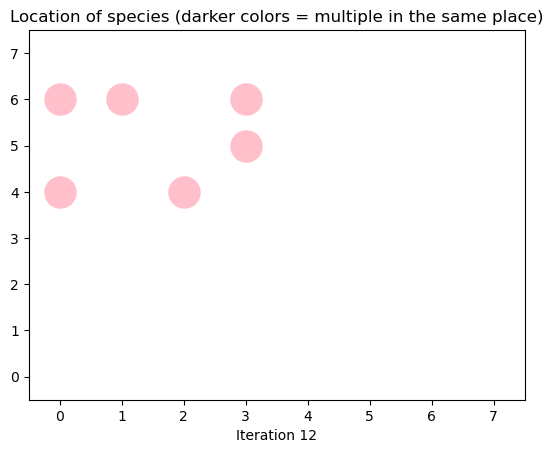

13


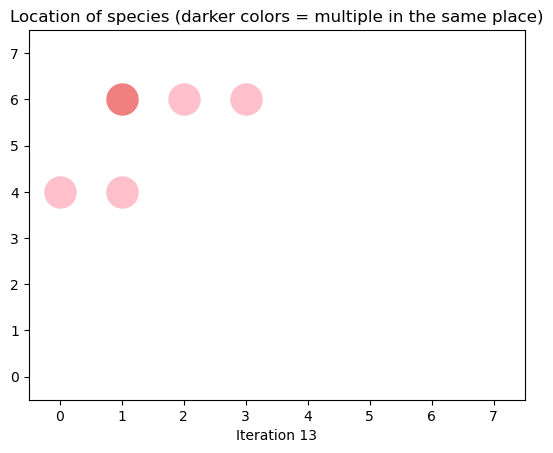

14


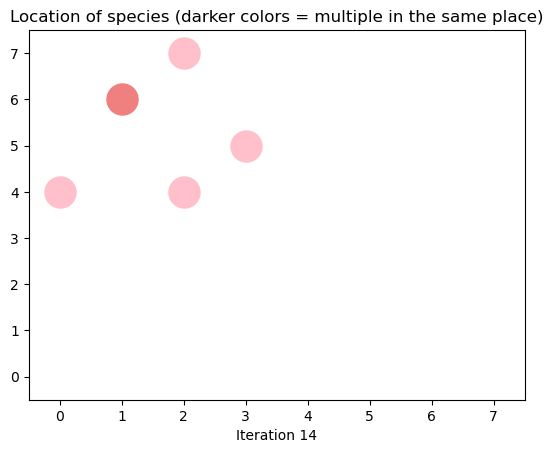

15


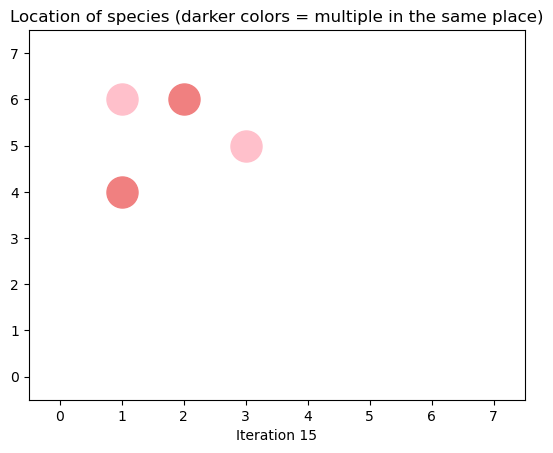

16


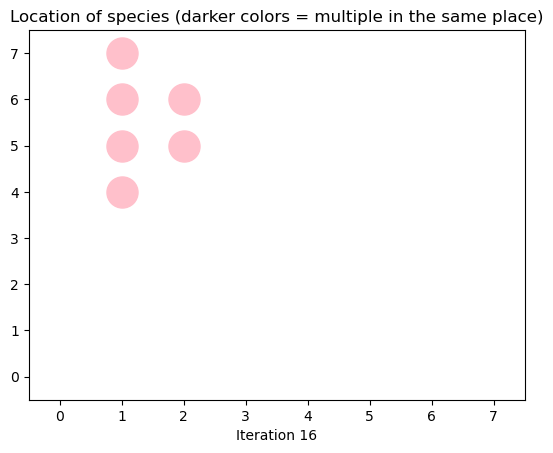

17


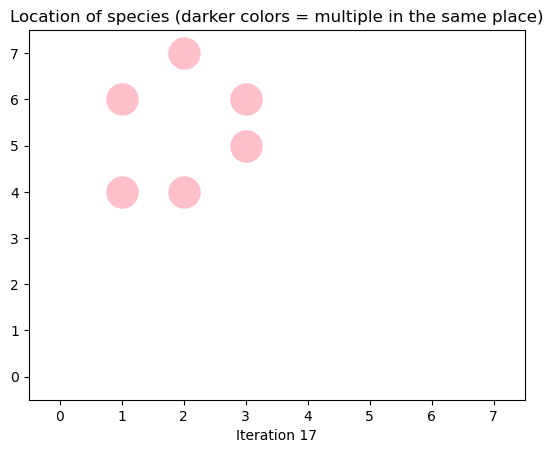

18


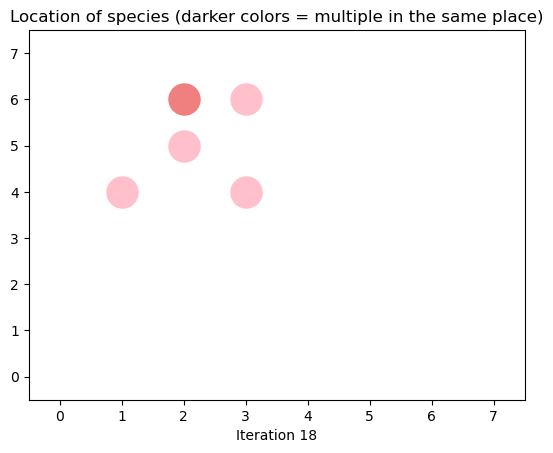

19


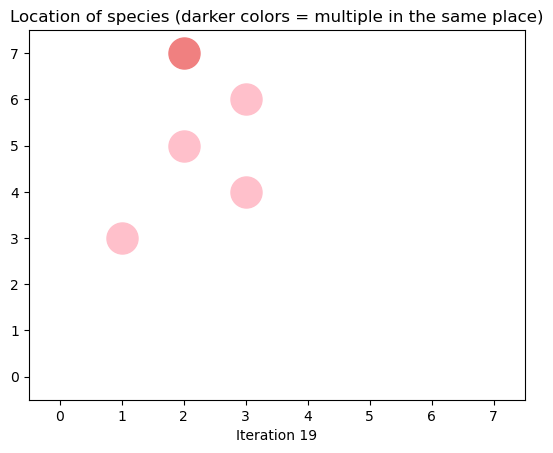

20


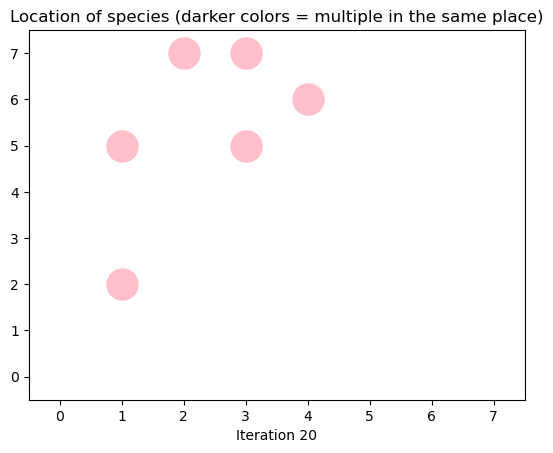

21


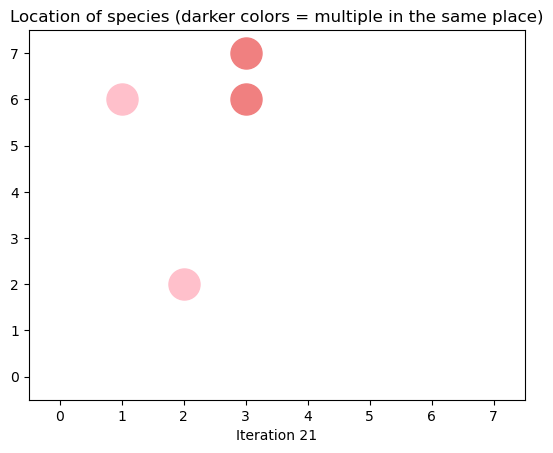

22


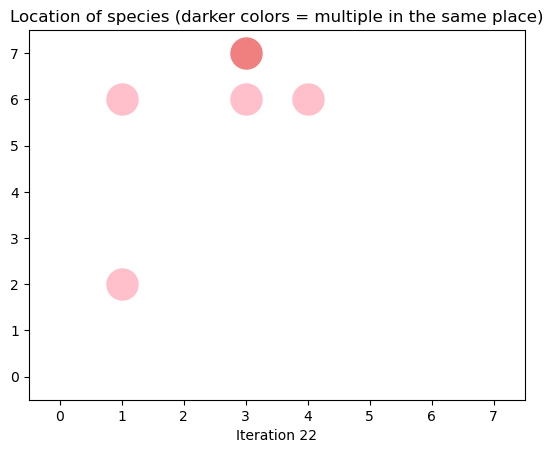

23


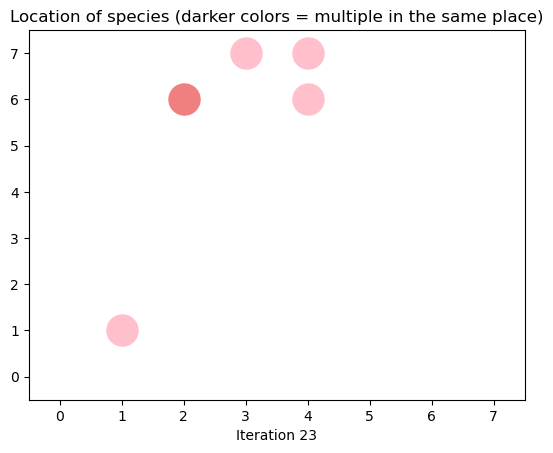

24


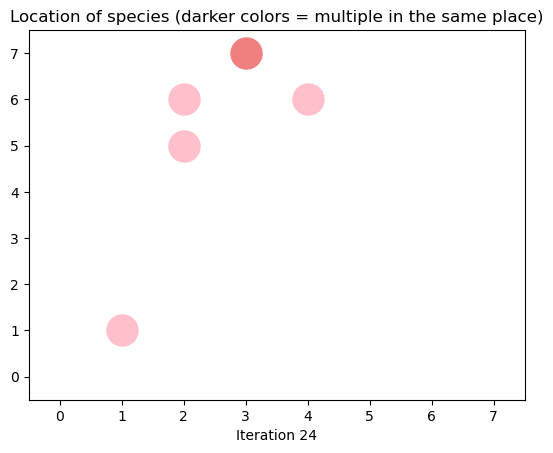

25


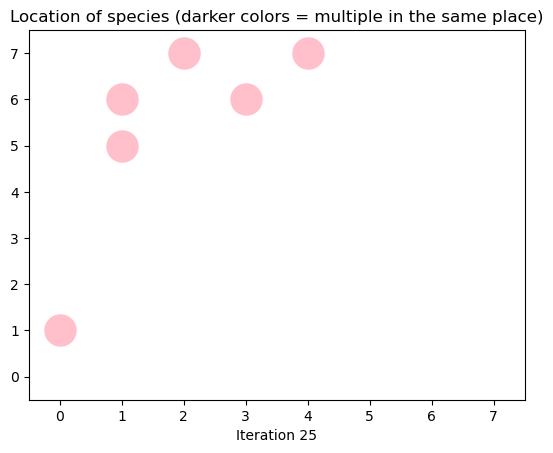

26


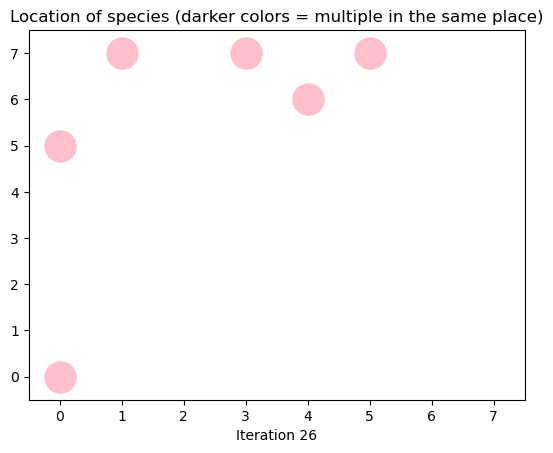

27


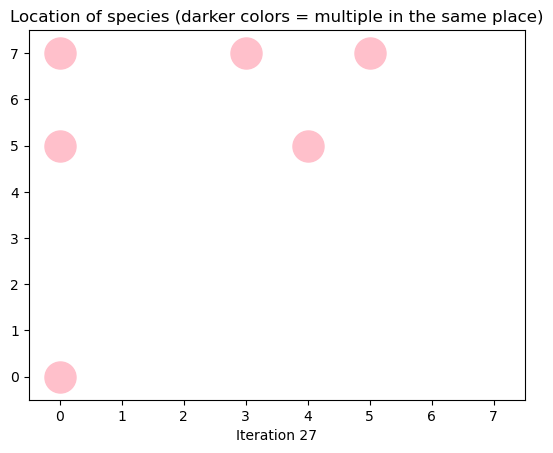

28


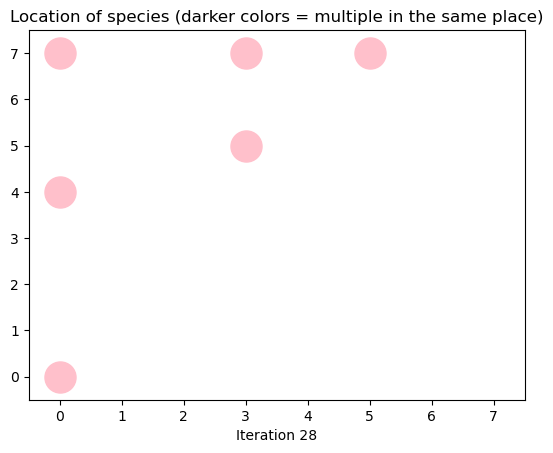

29


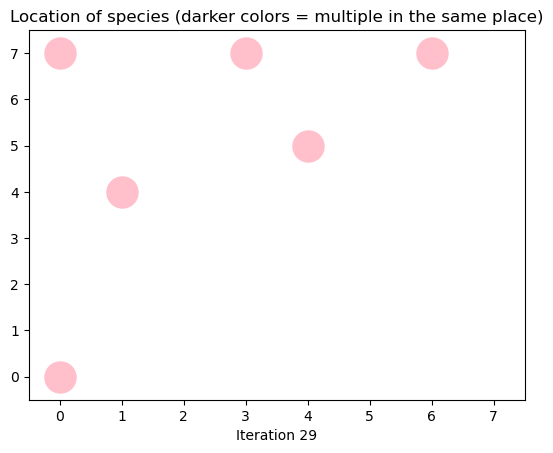

30


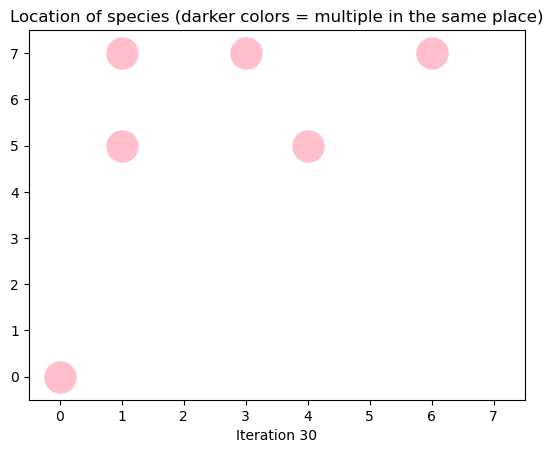

31


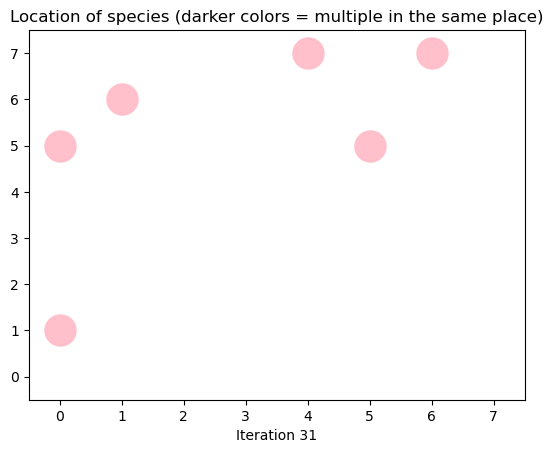

32


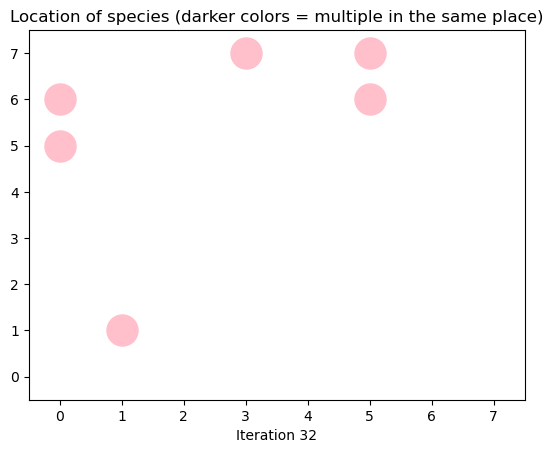

33


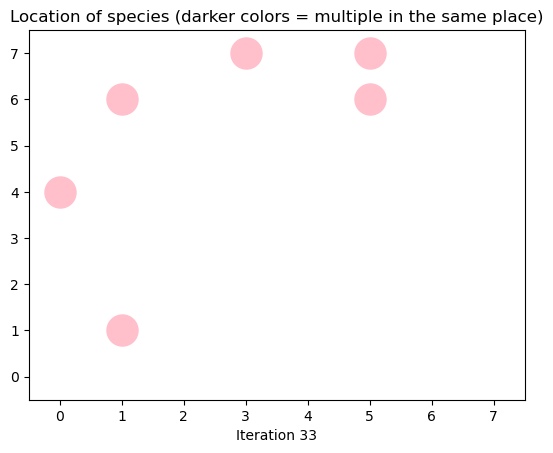

34


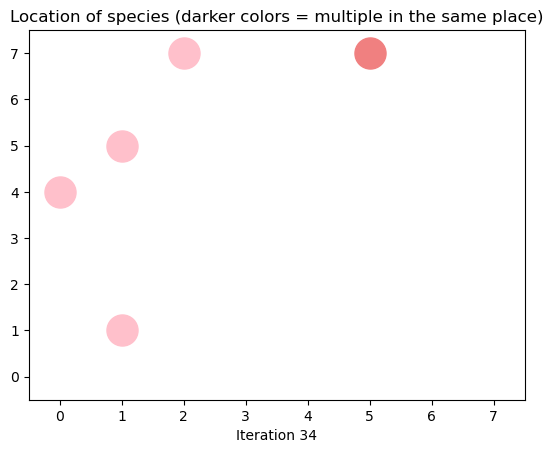

35


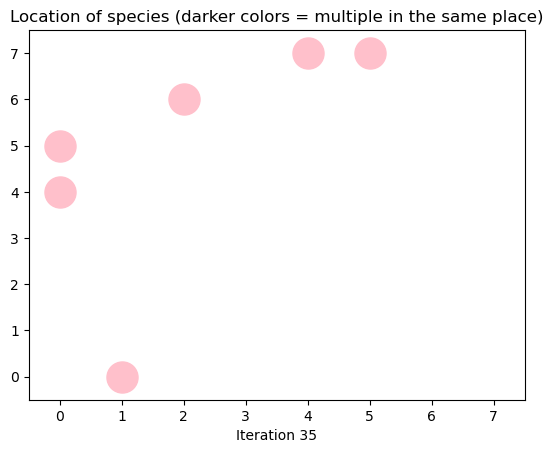

36


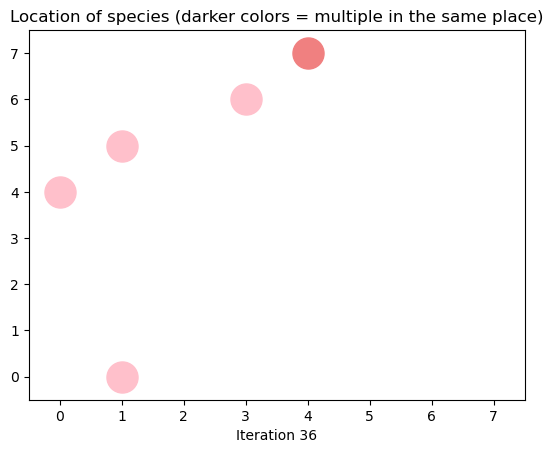

37


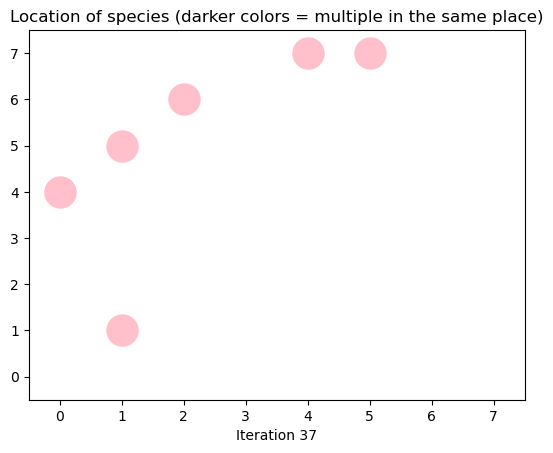

38


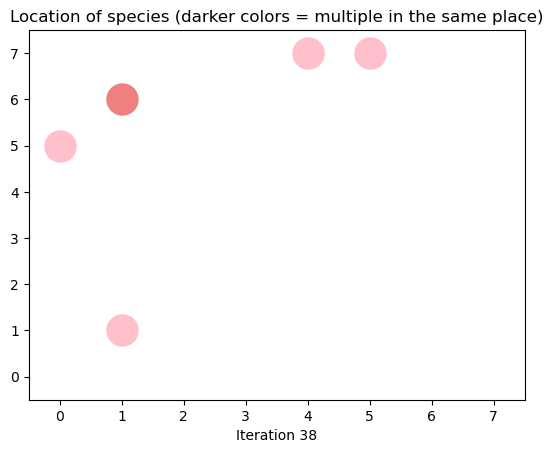

39


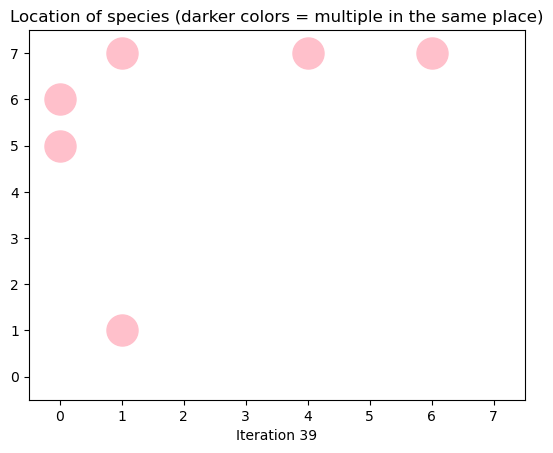

40


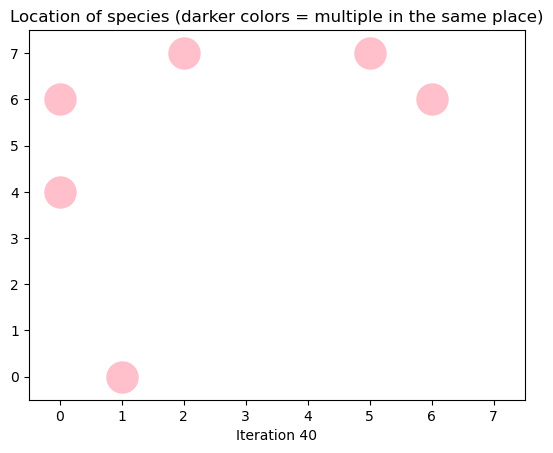

41


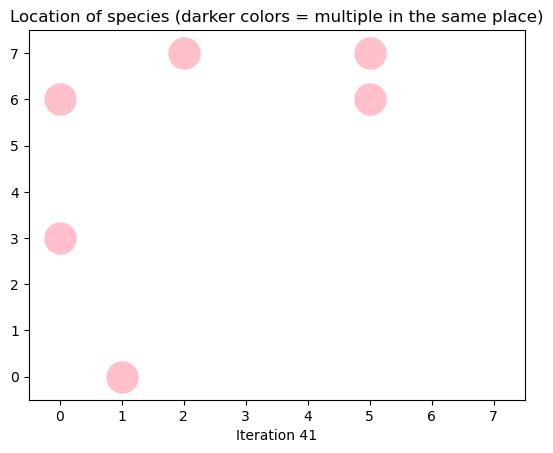

42


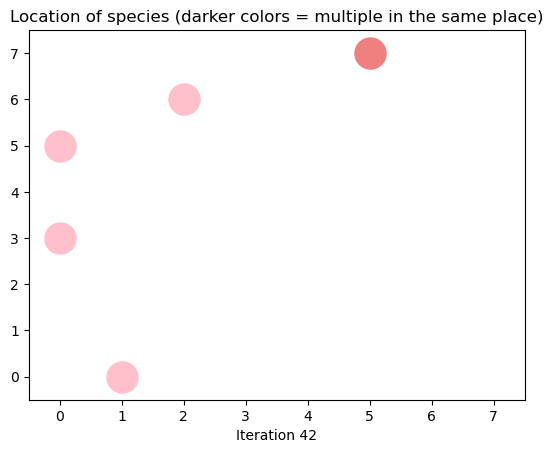

43


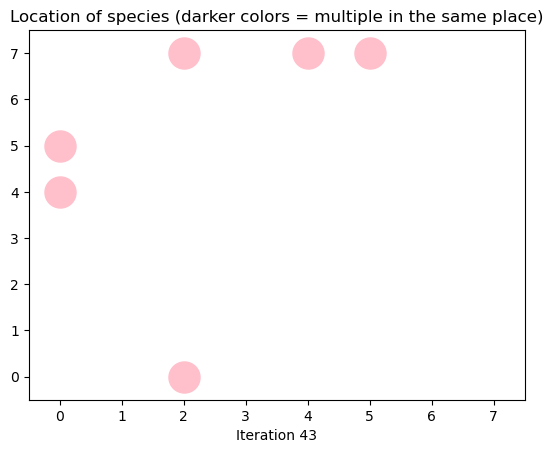

44


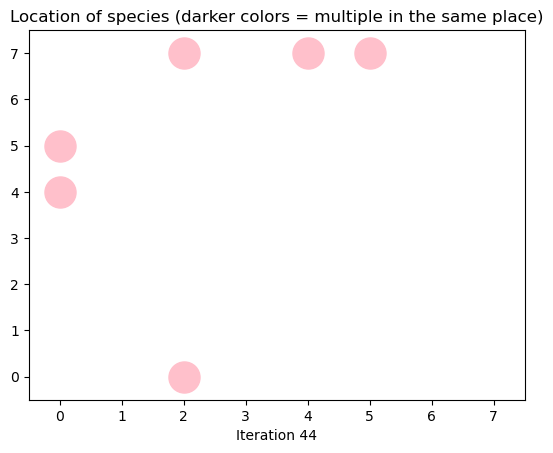

45


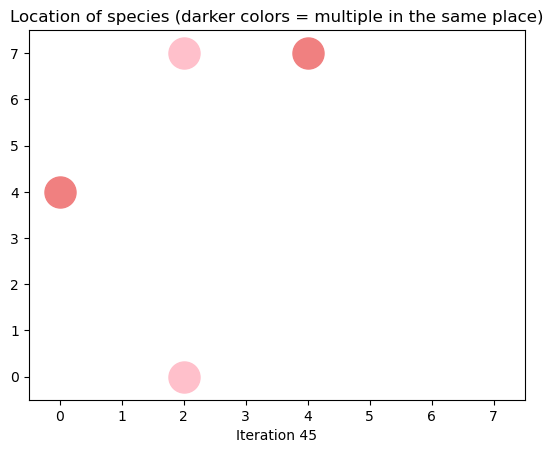

46


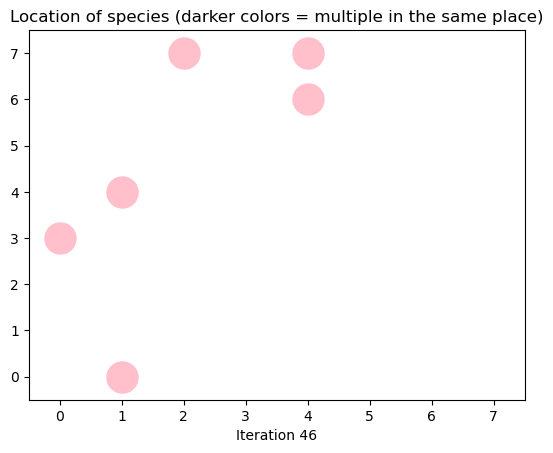

47


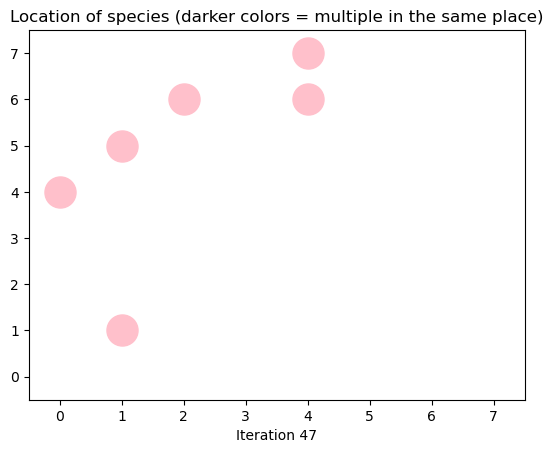

48


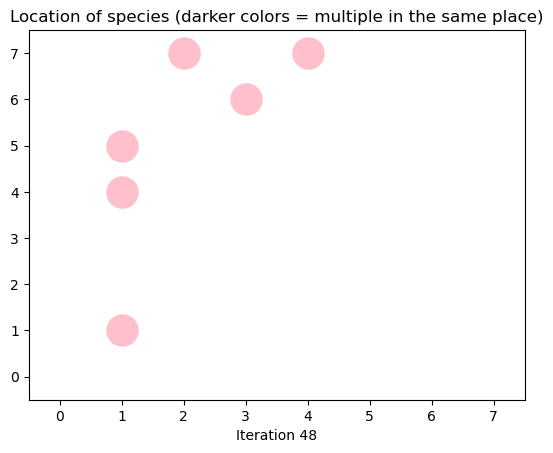

49


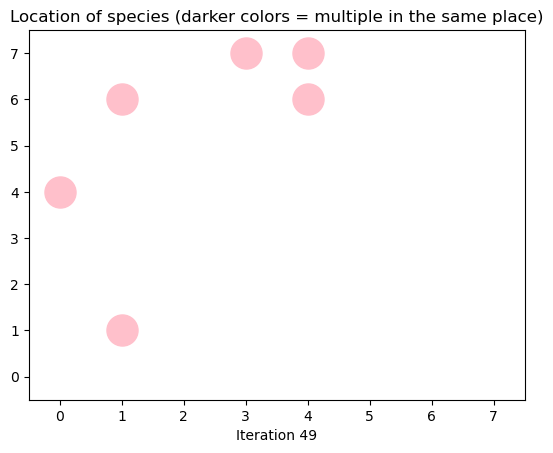

<Figure size 640x480 with 0 Axes>

In [107]:
#######################################

# run code here! I pasted it below with the default paramaters for ease

########################################

# main(length=8, consume=True, d_lig=4, d_prot=1,
#          strength=16, prod_rate=0, strength_unb=0,
#          n_ligs=12, n_prots=6, window=2,
#          show_move=True,show_lig=True, show_bound=True, its=20)

main(consume=True,show_move=True,show_lig=False,strength=10)

In [232]:
# used to generate data for kD and for length analysis
# in writeup. I had modified the main function to take
# in a strength argument.


# strengths = [2, 4,6, 8, 10, 12, 14, 16, 18, 20]
#              #8, 10, 12, 16, 20]
    
# data = []
# trials = 20
# iterations = []
# for s in strengths:
#     iterations.append([])
#     for _ in range(trials):
#         it, lig, prot, bound = main(strength=s,show_move=False,show_lig=False)
#         iterations[-1].append(it)

In [73]:
# packages for plotting

import iqplot

import bokeh.plotting
import bokeh.io
import scipy.stats
from sklearn.metrics import r2_score 
bokeh.io.output_notebook()

Loading BokehJS ...

In [77]:
# this was used to calculate how length/size of organelle
# affects how long until all ligands of a source are consumed

# lens = [5, 7, 10, 12, 14, 16]
# reps = 50
# fin = []
# for leng in lens:
#     fin.append([])
#     for _ in range(reps):
#         fin[-1].append(main(length=leng,show_move=False,show_lig=False))



Text(0.5, 1.0, 'ECDFs of iterations until all ligands consumed')

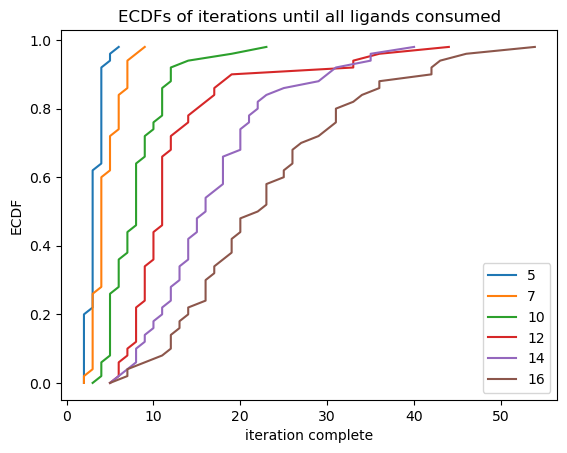

In [50]:
# plotting ecdf of lengths

# for i,f in enumerate(fin):
#     x = np.sort(f)
#     y = np.arange(len(x))/float(len(x))
#     plt.plot(x, y,label=str(lens[i]))

# plt.legend()
# plt.xlabel('iteration complete')
# plt.ylabel('ECDF')
# plt.title('ECDFs of iterations until all ligands consumed')

In [78]:
# plot average iteration all ligands consumed
# and find a line of best fit

# avgs = []
# for f in fin:
#     if np.mean(f) < 20:
#         avgs.append(np.mean(f))

# a, b, c = np.polyfit(lens[:-1], avgs, 2)
# lens = np.array(lens)
# cal = a*lens[:-1]**2 + b*lens[:-1] + c
# print(avgs)
# print(lens[:-1],avgs)
# plt.plot(lens[:-1],avgs,label='data')
# plt.plot(lens[:-1], cal,label=f'{round(a,2)}y^2 + {round(b,2)}y + {round(c,2)}')
# plt.xlabel('Length (sqrt(area))')
# plt.ylabel('Average Iterations until completion')
# plt.legend()
# print(r2_score(cal, avgs))

In [95]:
# code for analysing results of trials
# iterations = []
# strengths = [10,12,14,16,18,20]
# for stren in strengths:
#     iterations.append([])
#     for _ in range(50):
#         print(stren)
#         res = main(strength=stren,length=10,show_move=False,consume=False,show_lig=False,show_bound=False)
#         iterations[-1].append(res)

10
0
Ligand at 0,1 bound
Ligand at 0,5 bound
Ligand at 6,5 bound
Complex at 0,3 unbound
Complex at 1,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 0,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 0,3 bound
Ligand at 0,7 bound
Ligand at 3,7 bound
Complex at 2,6 unbound
Complex at 9,6 unbound
Complex at 0,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 8,5 bound
Ligand at 2,7 bound
Complex at 6,4 unbound
Complex at 9,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 2,3 unbound
Complex at 6,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 0,2 unbound
Complex at 3,3 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 0,4 bound
Ligand at 9,6 bound
Complex at 0,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 3,3 unbound
Complex at 0,6 unbound
Complex at 2,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,8 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 9,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 1,5 bound
Complex at 1,0 unbound
Complex at 1,7 unbound
Complex at 2,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 0,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,8 bound
Ligand at 2,9 bound
Complex at 2,0 unbound
Complex at 5,3 unbound
Complex at 9,5 unbound
Complex at 0,8 unbound
Complex at 3,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 5,5 bound
Ligand at 1,8 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 2,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 2,8 bound
Complex at 3,0 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 4,2 unbound
Complex at 8,5 unbound
Complex at 2,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Ligand at 8,8 bound
Complex at 3,3 unbound
Complex at 0,8 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
Complex at 1,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 4,6 bound
Complex at 3,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 6,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 0,9 bound
Complex at 1,1 unbound
Complex at 0,9 unbound
Complex at 1,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 4,1 bound
Ligand at 2,9 bound
Complex at 1,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 1,0 unbound
Complex at 5,2 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 7,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 8,8 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 5,3 unbound
Complex at 8,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,8 bound
Complex at 5,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 4,3 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 9,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 5,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 9,8 bound
Ligand at 1,9 bound
Complex at 5,3 unbound
Complex at 2,7 unbound
Complex at 8,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 1,5 bound
Ligand at 7,9 bound
Complex at 2,7 unbound
Complex at 9,9 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 3,7 bound
Complex at 3,7 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 5,3 unbound
Complex at 1,6 unbound
Complex at 3,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 1,6 bound
Ligand at 4,8 bound
Complex at 0,1 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 2,2 bound
Ligand at 8,2 bound
Ligand at 9,7 bound
Complex at 3,0 unbound
Complex at 6,2 unbound
Complex at 3,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 0,5 unbound
Complex at 3,7 unbound
Complex at 8,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 8,7 bound
Ligand at 3,8 bound
Complex at 4,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 8,2 bound
Complex at 8,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 5,0 unbound
Complex at 6,3 unbound
Complex at 3,6 unbound
Complex at 8,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 5,6 bound
Complex at 4,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 6,3 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 5,5 bound
Complex at 3,0 unbound
Complex at 0,3 unbound
Complex at 4,6 unbound
Complex at 9,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,2 bound
Ligand at 4,6 bound
Complex at 7,2 unbound
Complex at 5,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 6,2 bound
Complex at 4,1 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 4,6 bound
Ligand at 7,9 bound
Complex at 3,0 unbound
Complex at 3,1 unbound
Complex at 4,7 unbound
Complex at 8,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 8,7 bound
Complex at 5,3 unbound
Complex at 3,7 unbound
Complex at 8,9 unbound
10
0
Ligand at 5,1 bound
1


/var/folders/ng/bc2sdd7116j9qzcxbg0xjh1w0000gn/T/ipykernel_7743/1843077940.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(ligs)*np.sum(prot)/np.sum(bound)


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 7,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,8 bound
Ligand at 6,8 bound
Complex at 6,1 unbound
Complex at 9,1 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 7,9 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 2,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,2 bound
Ligand at 8,9 bound
Complex at 7,1 unbound
Complex at 7,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 7,4 bound
Ligand at 3,6 bound
Ligand at 7,6 bound
Complex at 6,3 unbound
Complex at 0,4 unbound
Complex at 7,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 4,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 8,3 unbound
Complex at 6,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 6,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 6,7 bound
Ligand at 6,9 bound
Complex at 7,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 7,1 unbound
Complex at 8,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 0,1 unbound
Complex at 5,7 unbound
Complex at 8,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 5,6 bound
Complex at 6,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 8,8 bound
Complex at 1,0 unbound
Complex at 6,2 unbound
Complex at 8,3 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 7,9 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 2,2 bound
Complex at 2,0 unbound
Complex at 6,2 unbound
Complex at 6,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,0 bound
Ligand at 5,5 bound
Complex at 8,2 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 7,1 bound
Complex at 6,2 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 7,1 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 8,2 unbound
Complex at 5,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,7 bound
Ligand at 5,9 bound
Complex at 7,2 unbound
Complex at 6,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 3,2 unbound
Complex at 7,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 5,5 bound
Complex at 6,2 unbound
Complex at 6,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,7 bound
Ligand at 8,7 bound
Complex at 2,2 unbound
Complex at 5,3 unbound
Complex at 6,4 unbound
Complex at 6,7 unbound
Complex at 5,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 3,7 bound
Ligand at 6,8 bound
Complex at 6,5 unbound
Complex at 5,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,4 bound
Ligand at 6,9 bound
Complex at 5,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 7,3 unbound
Complex at 5,5 unbound
Complex at 6,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 4,4 bound
Ligand at 8,9 bound
Complex at 6,3 unbound
Complex at 7,3 unbound
Complex at 6,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 9,9 bound
Complex at 7,3 unbound
Complex at 5,5 unbound
Complex at 7,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 7,3 bound
Ligand at 4,4 bound
Complex at 6,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 4,5 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 2,2 unbound
Complex at 5,2 unbound
Complex at 5,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,6 bound
Ligand at 8,8 bound
Complex at 7,2 unbound
Complex at 7,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 5,4 bound
Complex at 5,3 unbound
Complex at 4,4 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
Complex at 3,2 unbound
Complex at 4,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 3,4 bound
Complex at 5,2 unbound
Complex at 3,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 4,2 bound
Ligand at 5,5 bound
Complex at 6,0 unbound
Complex at 4,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 2,6 bound
Complex at 5,1 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 3,4 bound
Complex at 6,1 unbound
Complex at 3,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,5 bound
Ligand at 8,7 bound
Complex at 3,1 unbound
Complex at 9,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,1 bound
Complex at 7,0 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 2,2 unbound
Complex at 4,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,2 bound
Ligand at 9,8 bound
Complex at 6,0 unbound
Complex at 2,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 1,1 bound
Complex at 1,2 unbound
Complex at 8,2 unbound
Complex at 1,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 6,3 bound
Ligand at 1,6 bound
Complex at 7,1 unbound
Complex at 5,3 unbound
Complex at 8,3 unbound
Complex at 0,5 unbound
10
0
Ligand at 0,9 bound
Complex at 0,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 6,6 bound
Complex at 5,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 7,3 unbound
Complex at 7,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 6,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 2,4 bound
Ligand at 1,7 bound
Complex at 5,3 unbound
Complex at 1,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 1,5 unbound
Complex at 0,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 7,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 8,8 bound
Complex at 0,5 unbound
Complex at 7,7 unbound
Complex at 1,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 7,5 bound
Ligand at 1,7 bound
Complex at 5,4 unbound
Complex at 8,6 unbound
Complex at 1,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 1,5 bound
Ligand at 1,9 bound
Ligand at 8,9 bound
Complex at 7,8 unbound
Complex at 2,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 0,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 0,8 bound
Complex at 5,4 unbound
Complex at 8,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,3 bound
Complex at 9,7 unbound
Complex at 1,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 5,3 unbound
Complex at 1,8 unbound
Complex at 9,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 9,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 9,7 bound
Complex at 0,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 5,3 unbound
Complex at 1,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 9,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 9,5 bound
Ligand at 1,6 bound
Complex at 0,5 unbound
Complex at 0,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 0,7 bound
Complex at 3,3 unbound
Complex at 0,8 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 7,6 bound
Ligand at 0,9 bound
Complex at 7,3 unbound
Complex at 2,5 unbound
Complex at 0,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 2,3 bound
Ligand at 3,6 bound
Complex at 2,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 6,2 unbound
Complex at 2,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 7,2 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 0,9 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,7 bound
Complex at 0,3 unbound
Complex at 2,9 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 1,8 unbound
Complex at 3,9 unbound
Complex at 7,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 3,7 bound
Ligand at 1,8 bound
Ligand at 7,8 bound
Complex at 5,2 unbound
Complex at 2,8 unbound
Complex at 7,8 unbound
Complex at 3,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 4,7 bound
Complex at 5,2 unbound
Complex at 0,3 unbound
Complex at 4,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 0,7 bound
Complex at 5,1 unbound
Complex at 0,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,5 bound
Complex at 5,2 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 4,2 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 4,3 bound
Ligand at 6,7 bound
Complex at 0,3 unbound
Complex at 4,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 6,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 4,3 unbound
Complex at 6,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 0,1 unbound
Complex at 6,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 0,5 bound
Ligand at 6,6 bound
Complex at 0,1 unbound
Complex at 0,6 unbound
Complex at 6,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 5,5 bound
Ligand at 4,9 bound
Complex at 5,7 unbound
Complex at 3,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 3,7 bound
Complex at 5,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 5,6 bound
Complex at 0,2 unbound
Complex at 5,2 unbound
Complex at 5,7 unbound
Complex at 2,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,6 bound
Ligand at 5,8 bound
Ligand at 1,9 bound
Complex at 1,2 unbound
Complex at 5,7 unbound
Complex at 2,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 2,8 bound
Complex at 5,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 6,2 bound
Complex at 6,2 unbound
10
0
Ligand at 1,4 bound
Ligand at 8,6 bound
Complex at 9,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 6,7 bound
Complex at 1,4 unbound
Complex at 4,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 4,6 bound
Complex at 2,6 unbound
Complex at 3,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 8,7 bound
Complex at 3,5 unbound
Complex at 0,6 unbound
Complex at 3,7 unbound
Complex at 9,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 0,7 bound
Ligand at 8,7 bound
Complex at 0,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 2,7 unbound
Complex at 9,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 3,5 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,5 bound
Ligand at 8,8 bound
Complex at 9,1 unbound
Complex at 3,5 unbound
Complex at 0,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 3,7 bound
Complex at 3,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 9,0 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,6 bound
Complex at 9,0 unbound
Complex at 1,6 unbound
Complex at 0,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 0,4 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 9,9 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 0,6 unbound
Complex at 1,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,7 bound
Ligand at 3,9 bound
Complex at 0,6 unbound
Complex at 2,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,1 bound
Ligand at 6,8 bound
Complex at 7,0 unbound
Complex at 7,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 9,9 bound
Complex at 9,1 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 7,9 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 4,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 0,5 bound
Ligand at 1,8 bound
Complex at 8,0 unbound
Complex at 9,0 unbound
Complex at 4,1 unbound
Complex at 0,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 3,1 bound
Complex at 8,0 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 8,6 bound
Complex at 2,7 unbound
Complex at 7,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,6 bound
Ligand at 8,7 bound
Ligand at 2,8 bound
Complex at 2,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 6,0 unbound
Complex at 6,7 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 8,1 unbound
Complex at 2,5 unbound
Complex at 2,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,4 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 6,1 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
Complex at 7,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 5,8 bound
Complex at 6,9 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 3,6 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 2,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 0,4 bound
Ligand at 3,5 bound
Ligand at 7,6 bound
Complex at 4,4 unbound
Complex at 0,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 7,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 0,6 bound
Ligand at 3,7 bound
Complex at 7,1 unbound
Complex at 3,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 7,1 unbound
Complex at 8,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 7,1 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 6,3 bound
Complex at 6,5 unbound
Complex at 0,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 6,8 bound
Complex at 3,4 unbound
Complex at 1,6 unbound
Complex at 6,6 unbound
Complex at 4,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 2,6 bound
Ligand at 3,7 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 3,4 bound
Complex at 6,0 unbound
Complex at 2,5 unbound
Complex at 4,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 3,6 bound
Complex at 7,0 unbound
Complex at 7,1 unbound
Complex at 2,5 unbound
Complex at 5,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 2,6 unbound
Complex at 3,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 4,5 bound
Ligand at 2,6 bound
Complex at 2,5 unbound
10
0
Ligand at 5,1 bound
Ligand at 0,5 bound
Complex at 3,1 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 6,9 bound
Complex at 1,5 unbound
Complex at 6,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,2 bound
Ligand at 0,7 bound
Complex at 8,0 unbound
Complex at 1,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,7 bound
Complex at 6,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,4 bound
Complex at 8,0 unbound
Complex at 2,1 unbound
Complex at 0,3 unbound
Complex at 8,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 2,1 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,1 bound
Ligand at 0,5 bound
Complex at 0,3 unbound
Complex at 0,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 8,0 unbound
Complex at 9,0 unbound
Complex at 1,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 5,9 bound
Complex at 1,4 unbound
Complex at 5,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 1,4 bound
Ligand at 7,7 bound
Complex at 8,0 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 8,1 unbound
Complex at 5,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 3,5 bound
Ligand at 4,8 bound
Complex at 4,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 3,5 unbound
Complex at 5,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 3,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 6,6 bound
Complex at 8,1 unbound
Complex at 3,3 unbound
Complex at 5,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 6,4 bound
Complex at 5,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 8,2 unbound
Complex at 3,3 unbound
Complex at 6,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 8,1 bound
Ligand at 8,3 bound
Ligand at 3,6 bound
Ligand at 6,8 bound
Complex at 9,1 unbound
Complex at 5,6 unbound
Complex at 5,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 3,8 bound
Complex at 9,2 unbound
Complex at 3,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 2,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 9,0 unbound
Complex at 5,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 3,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 2,2 unbound
Complex at 9,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 4,8 bound
Complex at 8,4 unbound
Complex at 4,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,4 bound
Ligand at 3,6 bound
Complex at 8,5 unbound
Complex at 3,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 6,1 unbound
Complex at 7,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 6,0 bound
Ligand at 3,7 bound
Complex at 6,1 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 5,6 bound
Complex at 9,0 unbound
Complex at 2,1 unbound
Complex at 7,1 unbound
Complex at 4,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 9,3 bound
Ligand at 7,4 bound
Complex at 6,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,7 bound
Complex at 9,0 unbound
Complex at 8,2 unbound
Complex at 4,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 5,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 6,9 bound
Complex at 8,0 unbound
Complex at 6,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 1,2 unbound
Complex at 4,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 4,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 5,8 bound
Complex at 4,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 3,6 bound
Complex at 8,0 unbound
Complex at 6,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 1,2 unbound
Complex at 2,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 9,3 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 2,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 7,3 unbound
Complex at 6,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 7,8 bound
Complex at 8,1 unbound
Complex at 0,8 unbound
Complex at 7,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 8,7 bound
Ligand at 0,8 bound
Complex at 9,1 unbound
Complex at 1,4 unbound
Complex at 0,8 unbound
Complex at 7,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 8,2 bound
Ligand at 1,3 bound
Ligand at 4,5 bound
Ligand at 1,8 bound
Complex at 8,1 unbound
Complex at 4,6 unbound
Complex at 0,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 6,1 unbound
Complex at 0,3 unbound
Complex at 0,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 0,4 bound
Ligand at 4,6 bound
Ligand at 7,8 bound
Complex at 6,1 unbound
Complex at 8,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 7,3 bound
Complex at 5,1 unbound
Complex at 0,2 unbound
Complex at 8,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 5,2 bound
Ligand at 1,6 bound
Ligand at 6,9 bound
Complex at 0,2 unbound
Complex at 0,6 unbound
Complex at 5,6 unbound
Complex at 8,9 unbound
10
0
Ligand at 8,4 bound
Ligand at 5,7 bound
Complex at 7,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 6,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 4,7 bound
Complex at 9,4 unbound
Complex at 6,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 8,4 bound
Ligand at 3,6 bound
Ligand at 9,8 bound
Complex at 1,3 unbound
Complex at 5,6 unbound
Complex at 5,7 unbound
Complex at 7,8 unbound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 9,6 bound
Ligand at 4,7 bound
Complex at 9,4 unbound
Complex at 5,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 0,3 unbound
Complex at 8,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,7 bound
Complex at 1,3 unbound
Complex at 9,4 unbound
Complex at 4,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 1,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 4,7 bound
Complex at 0,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 5,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 4,7 bound
Ligand at 4,8 bound
Ligand at 9,9 bound
Complex at 4,6 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 4,6 unbound
Complex at 8,7 unbound
Complex at 5,9 unbound
Complex at 8,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 8,6 bound
Complex at 8,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 7,8 bound
Complex at 0,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 5,7 bound
Complex at 1,6 unbound
Complex at 5,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 1,9 bound
Complex at 7,1 unbound
Complex at 2,5 unbound
Complex at 9,7 unbound
Complex at 5,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 8,6 bound
Ligand at 6,7 bound
Complex at 2,5 unbound
Complex at 9,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 8,6 unbound
Complex at 3,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 8,6 bound
Ligand at 3,9 bound
Ligand at 6,9 bound
Complex at 1,4 unbound
Complex at 9,7 unbound
Complex at 5,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 1,5 unbound
Complex at 4,6 unbound
Complex at 9,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 4,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 4,5 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 6,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 8,6 bound
Ligand at 6,7 bound
Complex at 5,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,8 bound
Complex at 7,0 unbound
Complex at 9,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 4,5 unbound
Complex at 8,5 unbound
Complex at 5,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 4,2 bound
Ligand at 5,2 bound
Ligand at 4,9 bound
Complex at 7,1 unbound
Complex at 4,4 unbound
Complex at 5,4 unbound
Complex at 5,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,5 bound
Ligand at 4,6 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 4,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 3,4 bound
Ligand at 6,6 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 4,5 bound
Complex at 8,4 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 6,3 unbound
Complex at 5,4 unbound
Complex at 5,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,4 bound
Ligand at 7,6 bound
Complex at 7,0 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 8,4 bound
Complex at 5,4 unbound
Complex at 3,5 unbound
Complex at 8,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 5,3 unbound
Complex at 4,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 8,5 bound
Ligand at 5,6 bound
Complex at 5,2 unbound
Complex at 4,5 unbound
Complex at 6,5 unbound
Complex at 6,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 2,7 bound
Ligand at 6,7 bound
Complex at 6,4 unbound
Complex at 2,6 unbound
Complex at 6,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 4,5 bound
Ligand at 6,6 bound
Complex at 4,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,1 bound
Complex at 5,0 unbound
Complex at 6,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 3,6 bound
Complex at 7,1 unbound
Complex at 5,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 0,5 bound
Complex at 5,1 unbound
Complex at 1,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 5,2 unbound
Complex at 0,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 5,7 unbound
10
0
Ligand at 6,1 bound
Ligand at 9,1 bound
Ligand at 2,3 bound
Ligand at 4,3 bound
Ligand at 3,7 bound
Complex at 4,1 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 9,1 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 8,1 bound
Complex at 8,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 4,2 bound
Complex at 3,1 unbound
Complex at 8,2 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 7,2 bound
Complex at 2,1 unbound
Complex at 8,2 unbound
Complex at 4,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 0,1 unbound
Complex at 6,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 2,1 unbound
Complex at 6,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 3,1 bound
Ligand at 7,2 bound
Ligand at 4,8 bound
Complex at 7,1 unbound
Complex at 4,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 7,6 bound
Complex at 7,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 6,4 bound
Complex at 1,1 unbound
Complex at 6,1 unbound
Complex at 8,4 unbound
Complex at 3,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,6 bound
Ligand at 7,6 bound
Complex at 2,1 unbound
Complex at 7,3 unbound
Complex at 8,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,1 bound
Ligand at 6,3 bound
Ligand at 7,5 bound
Complex at 3,1 unbound
Complex at 5,1 unbound
Complex at 7,2 unbound
Complex at 9,5 unbound
Complex at 1,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 1,7 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 8,5 bound
Complex at 7,1 unbound
Complex at 9,4 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 9,2 bound
Complex at 2,1 unbound
Complex at 5,2 unbound
Complex at 7,2 unbound
Complex at 1,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 8,2 bound
Ligand at 0,5 bound
Complex at 3,1 unbound
Complex at 7,3 unbound
Complex at 1,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 2,5 bound
Complex at 6,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,4 bound
Complex at 5,1 unbound
Complex at 8,3 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 6,1 bound
Ligand at 8,3 bound
Complex at 4,0 unbound
Complex at 6,1 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 7,3 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 9,3 bound
Complex at 4,0 unbound
Complex at 7,2 unbound
Complex at 8,4 unbound
Complex at 1,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 4,2 bound
Ligand at 5,4 bound
Ligand at 2,9 bound
Complex at 7,1 unbound
Complex at 1,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 9,1 bound
Ligand at 1,8 bound
Complex at 4,0 unbound
Complex at 7,1 unbound
Complex at 1,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 4,1 unbound
Complex at 6,2 unbound
Complex at 7,4 unbound
Complex at 2,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 1,7 bound
Complex at 2,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 3,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 8,3 bound
Complex at 5,1 unbound
Complex at 6,1 unbound
Complex at 7,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 6,4 bound
Ligand at 3,6 bound
Complex at 5,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 2,7 bound
Complex at 0,7 unbound
Complex at 3,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 1,5 bound
Complex at 6,2 unbound
Complex at 6,4 unbound
Complex at 1,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 9,4 bound
Ligand at 2,7 bound
Complex at 7,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 5,4 unbound
Complex at 4,6 unbound
Complex at 1,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,0 bound
Ligand at 1,6 bound
Complex at 7,0 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 2,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 1,6 bound
Complex at 8,2 unbound
Complex at 2,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 2,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 1,7 bound
Complex at 8,0 unbound
Complex at 6,1 unbound
Complex at 1,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 1,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 1,7 bound
Complex at 1,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,8 bound
Complex at 8,3 unbound
Complex at 1,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 4,3 bound
Complex at 6,2 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 8,1 unbound
Complex at 4,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 8,0 unbound
Complex at 6,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 7,2 bound
Complex at 6,1 unbound
Complex at 8,1 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 5,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 6,4 bound
Complex at 5,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 9,1 unbound
Complex at 0,6 unbound
49


<Figure size 640x480 with 0 Axes>

10
0
Ligand at 4,2 bound
Complex at 3,3 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 1,7 bound
Complex at 1,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 4,5 bound
Complex at 8,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 8,3 bound
Complex at 0,2 unbound
Complex at 8,3 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 9,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,4 bound
Complex at 4,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 7,0 unbound
Complex at 9,1 unbound
Complex at 1,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 6,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 0,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,2 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 3,2 unbound
Complex at 0,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 2,2 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,5 bound
Complex at 5,0 unbound
Complex at 5,1 unbound
Complex at 1,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 4,1 unbound
Complex at 4,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 3,4 bound
Complex at 2,3 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 1,1 bound
Ligand at 4,2 bound
Complex at 7,0 unbound
Complex at 1,3 unbound
Complex at 4,3 unbound
Complex at 0,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 7,3 bound
Ligand at 2,7 bound
Complex at 4,0 unbound
Complex at 4,4 unbound
Complex at 0,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,3 bound
Complex at 1,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 7,0 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,6 bound
Complex at 7,1 unbound
Complex at 8,5 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 1,3 unbound
Complex at 0,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 0,4 bound
Complex at 1,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 4,6 bound
Complex at 6,3 unbound
Complex at 0,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,4 bound
Complex at 4,0 unbound
Complex at 7,3 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 6,3 bound
Complex at 4,1 unbound
Complex at 5,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 5,8 bound
Complex at 7,3 unbound
Complex at 2,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 8,4 bound
Complex at 7,3 unbound
Complex at 0,6 unbound
Complex at 5,6 unbound
Complex at 7,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 7,0 bound
Ligand at 3,3 bound
Complex at 7,2 unbound
Complex at 3,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 8,7 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 8,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 3,5 bound
Ligand at 1,7 bound
Complex at 6,0 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 5,1 unbound
Complex at 0,6 unbound
Complex at 5,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 4,6 bound
Complex at 1,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 4,1 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 7,6 bound
Complex at 1,6 unbound
Complex at 6,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 0,3 bound
Ligand at 4,7 bound
Complex at 7,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 3,6 bound
Complex at 2,0 unbound
Complex at 4,2 unbound
Complex at 0,4 unbound
Complex at 6,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 2,2 bound
Ligand at 3,4 bound
Ligand at 7,6 bound
Complex at 4,2 unbound
Complex at 7,6 unbound
Complex at 1,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 8,6 bound
Complex at 2,0 unbound
Complex at 2,4 unbound
Complex at 8,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 4,3 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 9,4 bound
Complex at 6,5 unbound
Complex at 3,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,3 bound
Complex at 4,1 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 3,4 unbound
10
0
Ligand at 1,2 bound
Ligand at 2,2 bound
Ligand at 5,6 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 1,3 unbound
Complex at 5,6 unbound
Complex at 7,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,5 bound
Complex at 6,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,5 bound
Complex at 2,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 1,4 bound
Complex at 2,2 unbound
Complex at 9,2 unbound
Complex at 6,5 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 0,6 bound
Complex at 9,1 unbound
Complex at 0,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 9,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 9,8 bound
Complex at 0,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,2 unbound
Complex at 9,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 9,5 bound
Complex at 9,6 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 2,4 bound
Ligand at 7,9 bound
Complex at 0,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 2,2 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 9,2 bound
Ligand at 7,6 bound
Complex at 9,1 unbound
Complex at 8,5 unbound
Complex at 6,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 6,8 bound
Complex at 1,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 6,8 unbound
Complex at 9,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 2,1 unbound
Complex at 8,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,2 bound
Ligand at 8,5 bound
Complex at 9,0 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 9,0 unbound
Complex at 3,1 unbound
Complex at 9,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,5 bound
Ligand at 9,5 bound
Complex at 3,2 unbound
Complex at 5,7 unbound
Complex at 8,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 8,7 bound
Complex at 9,3 unbound
Complex at 7,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 9,3 bound
Complex at 3,2 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 9,3 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 8,8 bound
Complex at 6,6 unbound
Complex at 7,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 8,8 bound
Complex at 4,2 unbound
Complex at 6,6 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 1,5 unbound
Complex at 7,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 4,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 6,6 bound
Complex at 3,2 unbound
Complex at 7,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 8,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,2 bound
Ligand at 7,2 bound
Complex at 1,2 unbound
Complex at 2,2 unbound
Complex at 8,3 unbound
Complex at 5,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 0,2 bound
Ligand at 1,4 bound
Complex at 2,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 4,8 bound
Complex at 9,0 unbound
Complex at 0,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,1 bound
Complex at 9,0 unbound
Complex at 2,3 unbound
Complex at 7,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 5,3 unbound
Complex at 6,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,2 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 2,2 bound
Complex at 2,2 unbound
Complex at 2,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,3 bound
Complex at 1,2 unbound
Complex at 5,3 unbound
Complex at 9,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 7,1 unbound
Complex at 2,2 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,3 bound
Ligand at 9,5 bound
Complex at 9,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 2,3 bound
Complex at 2,2 unbound
Complex at 5,2 unbound
Complex at 7,3 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 2,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 7,3 bound
Ligand at 1,4 bound
Complex at 1,2 unbound
Complex at 2,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 2,9 bound
Complex at 8,1 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 6,3 bound
Complex at 8,2 unbound
Complex at 6,3 unbound
Complex at 7,3 unbound
Complex at 3,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 8,4 bound
Ligand at 7,5 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 0,2 unbound
Complex at 1,2 unbound
Complex at 7,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 8,4 unbound
10
0
Ligand at 8,0 bound
Ligand at 0,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 8,7 bound
Complex at 8,0 unbound
Complex at 0,4 unbound
Complex at 9,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,6 bound
Complex at 9,0 unbound
Complex at 6,6 unbound
Complex at 9,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 0,3 bound
Ligand at 9,7 bound
Ligand at 6,9 bound
Complex at 0,2 unbound
Complex at 9,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 9,7 unbound
Complex at 4,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 4,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 9,0 unbound
Complex at 4,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 9,7 bound
Complex at 8,0 unbound
Complex at 9,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,0 bound
Ligand at 9,5 bound
Complex at 8,0 unbound
Complex at 9,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 6,7 bound
Complex at 7,0 unbound
Complex at 4,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 0,3 unbound
Complex at 4,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 3,0 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 8,0 bound
Ligand at 0,2 bound
Ligand at 8,7 bound
Complex at 1,3 unbound
Complex at 9,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 7,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 4,7 bound
Ligand at 9,7 bound
Complex at 1,4 unbound
Complex at 5,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 5,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 3,1 unbound
Complex at 1,5 unbound
Complex at 8,7 unbound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 4,9 bound
Complex at 9,3 unbound
Complex at 8,6 unbound
Complex at 5,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 7,7 bound
Complex at 9,3 unbound
Complex at 4,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 3,6 bound
Ligand at 5,8 bound
Complex at 4,2 unbound
Complex at 7,6 unbound
Complex at 3,7 unbound
Complex at 4,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 4,5 bound
Complex at 9,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 3,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,6 bound
Complex at 4,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,8 bound
Complex at 4,1 unbound
Complex at 4,4 unbound
Complex at 8,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 5,1 unbound
Complex at 4,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 8,5 bound
Complex at 8,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 8,5 bound
Ligand at 3,7 bound
Complex at 3,2 unbound
Complex at 8,5 unbound
Complex at 4,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 6,7 bound
Complex at 9,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 7,0 unbound
Complex at 4,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,6 bound
Ligand at 3,7 bound
Complex at 3,1 unbound
Complex at 4,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 4,7 bound
Ligand at 8,7 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 8,0 unbound
Complex at 4,2 unbound
Complex at 7,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,2 bound
Complex at 3,2 unbound
Complex at 7,4 unbound
Complex at 8,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,1 bound
Ligand at 5,4 bound
Ligand at 3,7 bound
Complex at 9,0 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 7,4 unbound
Complex at 5,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 9,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 4,4 unbound
Complex at 7,4 unbound
Complex at 6,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,4 bound
Ligand at 9,4 bound
Complex at 7,3 unbound
Complex at 9,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 9,3 unbound
Complex at 4,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 4,9 bound
Complex at 9,1 unbound
Complex at 6,3 unbound
Complex at 6,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 6,7 bound
Complex at 4,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 5,6 bound
Complex at 6,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 4,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 4,3 bound
Ligand at 7,7 bound
Complex at 9,0 unbound
Complex at 5,7 unbound
Complex at 7,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 6,9 bound
Complex at 5,3 unbound
Complex at 6,8 unbound
10
0
Ligand at 2,3 bound
Ligand at 6,4 bound
Complex at 6,2 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 3,5 bound
Ligand at 5,7 bound
Complex at 6,1 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,6 bound
Complex at 5,3 unbound
Complex at 1,5 unbound
Complex at 0,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,3 bound
Ligand at 5,5 bound
Ligand at 0,7 bound
Complex at 7,0 unbound
Complex at 6,1 unbound
Complex at 6,9 unbound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 6,5 unbound
Complex at 2,6 unbound
Complex at 5,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 3,7 bound
Complex at 5,0 unbound
Complex at 0,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 5,3 bound
Complex at 6,4 unbound
Complex at 3,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 5,3 bound
Ligand at 0,4 bound
Ligand at 2,4 bound
Complex at 6,0 unbound
Complex at 7,0 unbound
Complex at 0,2 unbound
Complex at 6,4 unbound
Complex at 2,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 2,4 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 3,3 bound
Complex at 6,0 unbound
Complex at 4,4 unbound
Complex at 2,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 5,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,5 bound
Ligand at 2,6 bound
Complex at 6,0 unbound
Complex at 0,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,8 bound
Complex at 4,4 unbound
Complex at 5,5 unbound
Complex at 5,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 5,9 bound
Complex at 6,0 unbound
Complex at 0,1 unbound
Complex at 5,4 unbound
Complex at 5,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 6,7 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 1,1 bound
Ligand at 6,2 bound
Complex at 1,1 unbound
Complex at 6,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 7,2 bound
Ligand at 5,4 bound
Complex at 6,1 unbound
Complex at 3,4 unbound
Complex at 4,8 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 1,1 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,0 bound
Ligand at 2,1 bound
Ligand at 3,4 bound
Complex at 5,0 unbound
Complex at 1,1 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 7,0 unbound
Complex at 0,1 unbound
Complex at 5,3 unbound
Complex at 3,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,0 bound
Ligand at 0,2 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 6,8 bound
Complex at 6,0 unbound
Complex at 4,3 unbound
Complex at 6,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 6,0 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,9 bound
Complex at 2,1 unbound
Complex at 5,1 unbound
Complex at 3,2 unbound
Complex at 6,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 3,6 bound
Ligand at 8,8 bound
Complex at 6,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,2 bound
Ligand at 6,8 bound
Complex at 1,1 unbound
Complex at 5,2 unbound
Complex at 3,3 unbound
Complex at 6,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 8,2 bound
Ligand at 0,3 bound
Ligand at 6,8 bound
Complex at 0,1 unbound
Complex at 6,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,2 unbound
Complex at 4,3 unbound
Complex at 5,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 3,3 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 1,1 bound
Ligand at 4,3 bound
Ligand at 2,9 bound
Complex at 1,0 unbound
Complex at 6,2 unbound
Complex at 4,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 2,5 bound
Ligand at 4,7 bound
Complex at 7,1 unbound
Complex at 3,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 3,3 unbound
Complex at 3,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 3,6 bound
Complex at 1,1 unbound
Complex at 6,1 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 6,2 bound
Ligand at 3,3 bound
Complex at 3,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 6,1 unbound
Complex at 3,2 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 5,2 bound
Complex at 1,0 unbound
Complex at 3,2 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,1 bound
Complex at 4,5 unbound
Complex at 5,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 4,6 bound
Complex at 1,0 unbound
Complex at 6,1 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 5,8 bound
Complex at 4,2 unbound
Complex at 5,2 unbound
Complex at 3,5 unbound
Complex at 5,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,2 bound
Ligand at 5,4 bound
Complex at 4,2 unbound
Complex at 4,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 0,1 unbound
Complex at 4,2 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 4,1 bound
Complex at 0,1 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 2,2 unbound
Complex at 4,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 4,2 bound
Ligand at 3,8 bound
Complex at 7,1 unbound
Complex at 5,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 5,6 bound
Complex at 1,2 unbound
Complex at 3,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 4,4 bound
Complex at 6,1 unbound
Complex at 3,5 unbound
Complex at 4,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 4,7 bound
Complex at 3,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 0,2 unbound
10
0
Ligand at 2,2 bound
Ligand at 1,4 bound
Ligand at 6,9 bound
Complex at 0,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 3,5 bound
Complex at 1,3 unbound
Complex at 3,4 unbound
Complex at 0,5 unbound
Complex at 9,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 1,4 bound
Ligand at 0,5 bound
Complex at 2,3 unbound
Complex at 2,4 unbound
Complex at 0,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 3,5 bound
Ligand at 1,7 bound
Complex at 1,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 9,7 bound
Complex at 2,2 unbound
Complex at 3,5 unbound
Complex at 9,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 0,5 bound
Ligand at 3,7 bound
Ligand at 9,7 bound
Complex at 5,2 unbound
Complex at 2,3 unbound
Complex at 9,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,5 bound
Ligand at 9,7 bound
Complex at 8,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 4,3 unbound
Complex at 1,4 unbound
Complex at 8,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 8,8 bound
Complex at 7,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 3,3 unbound
Complex at 3,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 2,4 unbound
Complex at 2,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 5,4 bound
Ligand at 7,7 bound
Complex at 2,4 unbound
Complex at 5,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 2,6 bound
Ligand at 4,7 bound
Complex at 3,5 unbound
Complex at 5,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,7 bound
Complex at 3,4 unbound
Complex at 6,5 unbound
Complex at 6,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 3,3 unbound
Complex at 5,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 1,5 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 3,1 unbound
Complex at 5,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 2,5 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 6,2 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 4,4 bound
Ligand at 9,8 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 5,6 bound
Ligand at 6,6 bound
Complex at 3,4 unbound
Complex at 5,4 unbound
Complex at 6,4 unbound
Complex at 7,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 5,5 bound
Complex at 3,2 unbound
Complex at 7,5 unbound
Complex at 8,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 7,5 bound
Complex at 7,4 unbound
Complex at 7,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 1,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 7,4 unbound
Complex at 6,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 8,9 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 2,4 unbound
Complex at 8,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 9,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 6,2 unbound
Complex at 3,3 unbound
Complex at 8,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 5,5 bound
Ligand at 7,7 bound
Complex at 6,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 7,5 unbound
Complex at 7,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 2,2 bound
Ligand at 5,5 bound
Complex at 7,3 unbound
Complex at 7,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 7,5 bound
Ligand at 8,6 bound
Complex at 0,1 unbound
Complex at 3,2 unbound
Complex at 6,3 unbound
Complex at 7,4 unbound
Complex at 7,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,6 bound
Ligand at 9,6 bound
Complex at 4,2 unbound
Complex at 7,5 unbound
Complex at 9,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 8,8 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,4 bound
Complex at 7,3 unbound
Complex at 6,5 unbound
Complex at 8,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,3 bound
Ligand at 8,5 bound
Complex at 4,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 8,7 bound
Complex at 7,1 unbound
Complex at 9,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,3 bound
Ligand at 9,8 bound
Complex at 7,2 unbound
Complex at 6,3 unbound
Complex at 6,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 6,5 bound
Complex at 7,3 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 1,2 unbound
Complex at 9,6 unbound
Complex at 6,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 9,2 bound
Complex at 1,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 9,6 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 6,3 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 5,0 unbound
Complex at 9,3 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
10
0
Ligand at 3,0 bound
Ligand at 0,8 bound
Ligand at 6,9 bound
Complex at 0,9 unbound
Complex at 7,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 1,2 bound
Ligand at 8,8 bound
Complex at 9,0 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 3,0 unbound
Complex at 8,0 unbound
Complex at 0,2 unbound
Complex at 8,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,7 bound
Complex at 8,0 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 9,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 0,2 bound
Ligand at 0,8 bound
Complex at 9,1 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 0,2 unbound
Complex at 0,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 0,2 bound
Ligand at 3,2 bound
Ligand at 0,7 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,5 bound
Complex at 2,1 unbound
Complex at 6,2 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,6 bound
Complex at 0,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 0,8 bound
Complex at 3,0 unbound
Complex at 8,2 unbound
Complex at 5,3 unbound
Complex at 0,7 unbound
Complex at 9,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 3,4 bound
Ligand at 0,5 bound
Complex at 7,2 unbound
Complex at 5,4 unbound
Complex at 0,6 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 5,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 5,3 bound
Ligand at 0,8 bound
Complex at 7,3 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,3 bound
Ligand at 0,4 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 1,5 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
Complex at 0,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 7,3 bound
Ligand at 1,6 bound
Complex at 6,1 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 5,4 bound
Ligand at 8,7 bound
Complex at 5,1 unbound
Complex at 4,4 unbound
Complex at 1,6 unbound
Complex at 8,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,6 bound
Ligand at 8,9 bound
Complex at 5,1 unbound
Complex at 0,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
Complex at 0,6 unbound
Complex at 8,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 5,6 bound
Ligand at 0,8 bound
Complex at 8,4 unbound
Complex at 0,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 0,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 0,8 bound
Complex at 8,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 7,2 bound
Complex at 5,4 unbound
Complex at 7,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 9,4 bound
Complex at 4,3 unbound
Complex at 8,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,4 bound
Ligand at 8,8 bound
Complex at 5,0 unbound
Complex at 4,3 unbound
Complex at 6,5 unbound
Complex at 9,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 4,6 bound
Complex at 0,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 4,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 1,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 6,3 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 1,6 bound
Complex at 4,1 unbound
Complex at 4,4 unbound
Complex at 8,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,2 bound
Complex at 6,3 unbound
Complex at 0,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 0,5 bound
Ligand at 6,5 bound
Complex at 4,0 unbound
Complex at 0,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 4,5 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 0,5 bound
Complex at 4,0 unbound
Complex at 2,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 1,5 bound
Ligand at 6,5 bound
Ligand at 0,6 bound
Ligand at 9,7 bound
Complex at 2,6 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 3,6 bound
Complex at 4,1 unbound
Complex at 2,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 6,3 unbound
Complex at 1,4 unbound
Complex at 9,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 7,6 bound
Complex at 4,3 unbound
Complex at 8,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 7,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 7,6 bound
Complex at 8,4 unbound
Complex at 0,5 unbound
Complex at 9,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 8,7 bound
Complex at 9,6 unbound
10
0
Ligand at 9,4 bound
Ligand at 4,7 bound
Ligand at 8,9 bound
Complex at 6,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 6,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 5,7 bound
Complex at 6,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 8,7 bound
Complex at 6,3 unbound
Complex at 7,4 unbound
Complex at 7,7 unbound
Complex at 9,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 5,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 2,7 bound
Complex at 7,3 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 8,4 bound
Complex at 7,3 unbound
Complex at 8,4 unbound
Complex at 6,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 7,4 bound
Ligand at 5,8 bound
Complex at 6,6 unbound
Complex at 3,7 unbound
Complex at 6,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 8,7 bound
Complex at 6,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 9,4 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 7,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 7,9 bound
Complex at 7,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 9,7 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 9,5 unbound
Complex at 9,6 unbound
Complex at 3,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 0,8 bound
Ligand at 7,8 bound
Complex at 2,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 3,8 unbound
Complex at 8,8 unbound
Complex at 6,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 0,8 bound
Complex at 9,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 9,5 unbound
Complex at 2,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 9,8 bound
Complex at 8,5 unbound
Complex at 8,7 unbound
Complex at 7,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 7,7 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 2,7 bound
Complex at 7,8 unbound
Complex at 2,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 3,8 bound
Ligand at 5,8 bound
Complex at 8,3 unbound
Complex at 8,6 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 8,5 unbound
Complex at 5,7 unbound
Complex at 3,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 7,5 bound
Ligand at 8,8 bound
Ligand at 5,9 bound
Complex at 9,5 unbound
Complex at 6,7 unbound
Complex at 7,8 unbound
Complex at 3,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 9,7 bound
Complex at 6,7 unbound
Complex at 8,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 1,7 bound
Ligand at 5,8 bound
Ligand at 8,8 bound
Ligand at 2,9 bound
Complex at 6,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 0,9 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
Complex at 6,7 unbound
Complex at 3,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 6,7 unbound
Complex at 8,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 9,8 bound
Complex at 6,6 unbound
Complex at 8,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 6,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 0,9 bound
Complex at 2,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 6,3 unbound
Complex at 7,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 9,3 bound
Ligand at 2,9 bound
Complex at 7,3 unbound
Complex at 9,3 unbound
Complex at 2,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 9,9 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 6,6 unbound
Complex at 8,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 4,8 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 5,5 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 9,1 unbound
Complex at 6,5 unbound
Complex at 6,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 0,6 bound
Complex at 0,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 0,8 bound
Complex at 9,0 unbound
Complex at 6,6 unbound
Complex at 0,8 unbound
Complex at 2,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 8,1 unbound
Complex at 2,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 6,6 bound
Complex at 8,0 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,7 bound
Complex at 0,9 unbound
10
0
Ligand at 2,0 bound
Ligand at 8,0 bound
Ligand at 4,9 bound
Complex at 4,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 2,7 bound
Ligand at 4,7 bound
Complex at 9,0 unbound
Complex at 3,1 unbound
Complex at 2,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 9,2 bound
Complex at 9,0 unbound
Complex at 3,2 unbound
Complex at 5,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 5,9 bound
Complex at 5,8 unbound
Complex at 4,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Ligand at 3,8 bound
Complex at 4,2 unbound
Complex at 4,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 5,7 bound
Complex at 5,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 5,7 bound
Ligand at 4,9 bound
Complex at 8,0 unbound
Complex at 0,9 unbound
Complex at 5,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 3,4 unbound
Complex at 4,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 4,6 bound
Ligand at 3,8 bound
Ligand at 0,9 bound
Complex at 4,4 unbound
Complex at 0,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 1,6 bound
Complex at 3,4 unbound
Complex at 8,9 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
Complex at 1,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Ligand at 9,8 bound
Complex at 8,8 unbound
Complex at 4,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 6,8 bound
Complex at 2,6 unbound
Complex at 8,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 8,7 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
Complex at 4,6 unbound
Complex at 8,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 8,7 bound
Ligand at 5,8 bound
Complex at 2,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,6 bound
Complex at 9,7 unbound
Complex at 5,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 2,6 unbound
Complex at 9,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Ligand at 1,9 bound
Complex at 5,0 unbound
Complex at 2,6 unbound
Complex at 2,8 unbound
Complex at 9,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 3,5 bound
Complex at 5,1 unbound
Complex at 4,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 9,8 bound
Ligand at 5,9 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 3,5 unbound
Complex at 9,8 unbound
Complex at 4,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 9,9 bound
Complex at 5,0 unbound
Complex at 4,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 3,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 3,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 2,5 bound
Ligand at 1,8 bound
Complex at 9,8 unbound
Complex at 2,9 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
Complex at 2,6 unbound
Complex at 5,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 0,7 bound
Ligand at 4,9 bound
Complex at 6,0 unbound
Complex at 4,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 3,9 bound
Complex at 5,4 unbound
Complex at 2,8 unbound
Complex at 4,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 6,3 bound
Ligand at 5,7 bound
Complex at 2,7 unbound
Complex at 5,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 3,6 bound
Ligand at 3,9 bound
Complex at 6,4 unbound
Complex at 4,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 1,9 bound
Ligand at 4,9 bound
Complex at 6,1 unbound
Complex at 6,3 unbound
Complex at 1,9 unbound
Complex at 4,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 9,2 unbound
Complex at 3,7 unbound
Complex at 1,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 3,7 bound
Ligand at 3,8 bound
Complex at 7,1 unbound
Complex at 4,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,2 bound
Ligand at 4,7 bound
Ligand at 1,8 bound
Complex at 1,7 unbound
Complex at 4,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 9,0 unbound
Complex at 0,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 3,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 5,8 bound
Complex at 7,2 unbound
Complex at 7,3 unbound
Complex at 0,8 unbound
Complex at 5,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 6,6 bound
Ligand at 0,9 bound
Complex at 0,8 unbound
Complex at 6,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 0,7 bound
Ligand at 2,7 bound
Ligand at 7,8 bound
Complex at 5,3 unbound
Complex at 0,7 unbound
Complex at 2,7 unbound
Complex at 6,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 3,7 bound
Ligand at 5,7 bound
Ligand at 0,8 bound
Complex at 8,1 unbound
Complex at 6,3 unbound
Complex at 2,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,9 bound
Complex at 6,0 unbound
Complex at 6,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 5,3 unbound
Complex at 0,7 unbound
Complex at 1,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 9,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 0,6 bound
Complex at 0,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 0,8 bound
Ligand at 2,8 bound
Complex at 6,7 unbound
Complex at 0,8 unbound
Complex at 0,9 unbound
10
0
Ligand at 4,1 bound
Ligand at 0,4 bound
Ligand at 6,6 bound
Complex at 5,0 unbound
Complex at 8,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 6,1 bound
Ligand at 2,7 bound
Complex at 0,4 unbound
Complex at 0,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 4,8 bound
Complex at 6,6 unbound
Complex at 3,9 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 2,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,2 bound
Ligand at 7,8 bound
Complex at 5,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 1,5 unbound
Complex at 1,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 2,3 unbound
Complex at 3,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 1,5 unbound
Complex at 3,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 2,8 bound
Complex at 4,4 unbound
Complex at 2,5 unbound
Complex at 0,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,3 bound
Ligand at 5,6 bound
Ligand at 3,8 bound
Complex at 6,0 unbound
Complex at 6,6 unbound
Complex at 4,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 4,6 bound
Ligand at 4,8 bound
Complex at 5,0 unbound
Complex at 5,5 unbound
Complex at 2,6 unbound
Complex at 6,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 3,6 bound
Complex at 5,1 unbound
Complex at 2,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 4,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 0,8 bound
Complex at 5,6 unbound
Complex at 0,8 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 5,6 bound
Ligand at 6,6 bound
Ligand at 5,9 bound
Complex at 5,2 unbound
Complex at 4,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 5,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,3 unbound
Complex at 4,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 4,7 bound
Ligand at 5,7 bound
Complex at 4,2 unbound
Complex at 3,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 5,7 unbound
Complex at 4,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 5,8 bound
Ligand at 4,9 bound
Complex at 2,4 unbound
Complex at 3,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 4,8 bound
Complex at 3,4 unbound
Complex at 4,6 unbound
Complex at 5,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 1,7 bound
Complex at 4,5 unbound
Complex at 4,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 6,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 6,7 bound
Ligand at 1,9 bound
Complex at 4,6 unbound
Complex at 0,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 6,1 unbound
Complex at 0,7 unbound
Complex at 6,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 0,4 bound
Ligand at 4,5 bound
Ligand at 6,7 bound
Complex at 0,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 7,0 unbound
Complex at 3,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 7,7 unbound
Complex at 2,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 2,6 bound
Complex at 8,0 unbound
Complex at 3,3 unbound
Complex at 0,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,9 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 4,3 unbound
Complex at 4,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,7 bound
Complex at 4,3 unbound
Complex at 0,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,6 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 2,3 unbound
Complex at 8,3 unbound
Complex at 9,5 unbound
Complex at 4,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 4,5 bound
Ligand at 9,5 bound
Complex at 2,3 unbound
Complex at 9,6 unbound
Complex at 4,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 6,8 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 3,4 unbound
Complex at 9,4 unbound
Complex at 4,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,4 bound
Ligand at 8,4 bound
Complex at 2,4 unbound
Complex at 0,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 9,6 bound
Complex at 1,2 unbound
Complex at 0,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 9,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 7,5 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
Complex at 9,4 unbound
Complex at 9,5 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 3,5 bound
Ligand at 9,6 bound
Complex at 9,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 2,4 bound
10
0
Ligand at 1,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 1,6 bound
Complex at 2,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
Complex at 2,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 1,6 bound
Ligand at 9,9 bound
Complex at 8,0 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 1,6 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
Complex at 2,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 3,5 bound
Ligand at 9,6 bound
Ligand at 2,7 bound
Complex at 9,4 unbound
Complex at 8,7 unbound
Complex at 2,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,8 bound
Complex at 3,6 unbound
Complex at 8,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 9,6 bound
Complex at 2,6 unbound
Complex at 9,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 4,7 bound
Ligand at 9,8 bound
Complex at 2,6 unbound
Complex at 3,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 5,2 unbound
Complex at 2,5 unbound
Complex at 4,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,4 bound
Complex at 5,3 unbound
Complex at 7,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Ligand at 4,9 bound
Complex at 8,1 unbound
Complex at 8,4 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 8,3 bound
Ligand at 4,4 bound
Complex at 8,0 unbound
Complex at 7,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 2,4 unbound
Complex at 7,5 unbound
Complex at 4,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 7,4 bound
Ligand at 2,5 bound
Complex at 7,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 1,3 unbound
Complex at 7,4 unbound
Complex at 3,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 6,8 bound
Complex at 9,1 unbound
Complex at 0,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 8,3 bound
Ligand at 0,5 bound
Ligand at 2,7 bound
Complex at 8,4 unbound
Complex at 2,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 9,4 unbound
Complex at 6,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 7,1 unbound
Complex at 0,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Ligand at 3,9 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 9,2 unbound
Complex at 3,8 unbound
Complex at 6,9 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,1 bound
Ligand at 9,2 bound
Complex at 8,1 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 2,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 9,2 unbound
Complex at 1,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 9,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 1,4 bound
Ligand at 5,9 bound
Complex at 8,2 unbound
Complex at 5,8 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 9,3 bound
Complex at 7,3 unbound
Complex at 8,3 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 7,4 bound
Complex at 0,3 unbound
36


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 7,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 7,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,6 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 1,3 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
Complex at 6,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 7,4 bound
Ligand at 8,5 bound
Complex at 5,4 unbound
Complex at 9,4 unbound
Complex at 7,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 8,4 bound
Complex at 8,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 8,9 bound
Complex at 5,3 unbound
Complex at 8,3 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 4,3 unbound
Complex at 6,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 8,3 bound
Complex at 8,5 unbound
Complex at 5,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 5,7 bound
Complex at 3,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 6,6 bound
Complex at 3,2 unbound
Complex at 8,6 unbound
Complex at 9,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,5 bound
10
0
Ligand at 0,5 bound
Ligand at 6,6 bound
Complex at 6,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 0,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 0,2 unbound
Complex at 6,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 1,4 bound
Ligand at 0,8 bound
Ligand at 6,9 bound
Complex at 0,6 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 3,5 bound
Complex at 1,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 1,7 bound
Complex at 1,7 unbound
Complex at 8,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 5,5 unbound
Complex at 0,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 0,1 unbound
Complex at 8,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,8 bound
Complex at 1,1 unbound
Complex at 0,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,2 bound
Ligand at 1,5 bound
Ligand at 1,8 bound
Complex at 0,5 unbound
Complex at 7,7 unbound
Complex at 1,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 5,3 unbound
Complex at 1,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 3,4 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 8,6 bound
Complex at 5,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 1,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 5,1 unbound
Complex at 1,3 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 1,3 bound
Complex at 5,2 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 3,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 5,2 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 3,7 bound
Complex at 4,3 unbound
Complex at 5,3 unbound
Complex at 9,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 5,3 unbound
Complex at 1,6 unbound
Complex at 9,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 4,4 bound
Complex at 5,3 unbound
Complex at 2,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 1,5 bound
Ligand at 2,9 bound
Complex at 3,3 unbound
Complex at 5,4 unbound
Complex at 1,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 7,9 bound
Complex at 1,7 unbound
Complex at 2,7 unbound
Complex at 9,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 2,9 bound
Complex at 2,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,4 bound
Ligand at 2,8 bound
Complex at 3,1 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 5,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,5 bound
Complex at 3,1 unbound
Complex at 6,3 unbound
Complex at 0,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 1,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 1,9 bound
Complex at 1,7 unbound
Complex at 2,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,7 bound
Complex at 1,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Ligand at 9,8 bound
Complex at 3,1 unbound
Complex at 6,4 unbound
Complex at 9,7 unbound
Complex at 2,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,7 bound
Ligand at 1,8 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 6,3 unbound
Complex at 6,5 unbound
Complex at 1,8 unbound
Complex at 3,9 unbound
36


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 7,6 bound
Ligand at 2,9 bound
Complex at 5,6 unbound
Complex at 3,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 6,5 bound
Complex at 5,3 unbound
Complex at 6,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 9,5 bound
Complex at 9,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 8,3 unbound
Complex at 5,4 unbound
Complex at 9,7 unbound
Complex at 4,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 4,5 bound
Ligand at 2,6 bound
Ligand at 4,9 bound
Complex at 5,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 3,6 bound
Complex at 8,4 unbound
Complex at 4,5 unbound
Complex at 2,8 unbound
Complex at 4,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 4,6 bound
Complex at 9,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 9,7 bound
Complex at 4,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 4,9 bound
Complex at 6,5 unbound
Complex at 4,7 unbound
Complex at 4,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 6,6 unbound
Complex at 9,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 9,4 unbound
Complex at 3,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
10
0
Ligand at 4,1 bound
Ligand at 8,4 bound
Complex at 5,1 unbound
Complex at 7,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 5,2 bound
Ligand at 3,4 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 3,5 unbound
Complex at 8,5 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 4,2 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,2 bound
Complex at 5,2 unbound
Complex at 3,3 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 3,1 unbound
Complex at 9,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,3 bound
Ligand at 9,6 bound
Complex at 9,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 9,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 8,6 bound
Complex at 3,2 unbound
Complex at 4,2 unbound
Complex at 8,3 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,5 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
Complex at 3,4 unbound
Complex at 3,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 3,6 bound
Complex at 4,2 unbound
Complex at 3,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,5 bound
Ligand at 3,6 bound
Complex at 4,3 unbound
Complex at 7,3 unbound
Complex at 4,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 3,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,3 bound
Complex at 3,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 5,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 3,6 bound
Complex at 3,2 unbound
Complex at 3,4 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,6 bound
Complex at 3,2 unbound
Complex at 7,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 6,4 bound
Complex at 3,3 unbound
Complex at 7,4 unbound
Complex at 7,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,2 bound
Ligand at 3,5 bound
Complex at 3,4 unbound
Complex at 8,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 7,4 bound
Complex at 4,1 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 3,3 unbound
Complex at 4,4 unbound
Complex at 8,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 7,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 8,4 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 7,4 unbound
Complex at 4,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 4,2 unbound
Complex at 9,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 1,4 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 6,2 bound
Complex at 6,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 4,1 unbound
Complex at 7,1 unbound
Complex at 3,3 unbound
Complex at 9,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,3 bound
Ligand at 5,4 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 8,4 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,2 bound
Complex at 9,4 unbound
Complex at 4,5 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 7,3 bound
Ligand at 6,7 bound
Complex at 9,3 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 2,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 9,2 bound
Complex at 8,1 unbound
Complex at 3,2 unbound
Complex at 6,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,1 bound
Ligand at 3,4 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 9,0 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 8,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,1 bound
Complex at 4,1 unbound
Complex at 6,1 unbound
Complex at 7,2 unbound
Complex at 2,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,7 bound
Complex at 1,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 2,2 bound
Ligand at 5,2 bound
Ligand at 7,3 bound
Complex at 9,0 unbound
Complex at 4,1 unbound
Complex at 0,2 unbound
Complex at 1,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 1,5 bound
Complex at 1,2 unbound
Complex at 5,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,2 bound
Complex at 9,1 unbound
10
0
Ligand at 6,2 bound
Ligand at 7,2 bound
Ligand at 1,5 bound
Complex at 6,3 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 5,3 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 3,7 bound
Complex at 7,0 unbound
Complex at 4,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 5,6 bound
Ligand at 4,9 bound
Complex at 3,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 3,3 unbound
Complex at 5,5 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 5,3 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 3,1 bound
Ligand at 2,4 bound
Complex at 0,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 4,8 bound
Complex at 3,1 unbound
Complex at 6,2 unbound
Complex at 4,3 unbound
Complex at 3,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 5,0 unbound
Complex at 4,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 0,5 bound
Complex at 0,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,5 bound
Ligand at 2,9 bound
Complex at 7,2 unbound
Complex at 1,5 unbound
Complex at 3,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,2 bound
Ligand at 0,3 bound
Ligand at 5,6 bound
Ligand at 3,7 bound
Complex at 1,1 unbound
Complex at 7,3 unbound
Complex at 3,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 6,9 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 7,3 unbound
Complex at 1,5 unbound
Complex at 6,6 unbound
Complex at 4,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 2,3 unbound
Complex at 5,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 6,3 bound
Ligand at 1,5 bound
Ligand at 5,5 bound
Ligand at 4,9 bound
Complex at 6,2 unbound
Complex at 1,3 unbound
Complex at 6,5 unbound
Complex at 5,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 1,3 bound
Ligand at 7,7 bound
Complex at 1,3 unbound
Complex at 0,5 unbound
Complex at 6,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 3,9 bound
Complex at 0,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 1,3 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 4,1 unbound
Complex at 7,2 unbound
Complex at 3,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 0,2 unbound
Complex at 6,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 1,5 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 5,9 bound
Complex at 3,1 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 0,2 unbound
Complex at 1,5 unbound
Complex at 4,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 2,5 bound
Complex at 6,6 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 0,3 unbound
Complex at 3,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 6,7 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 4,2 unbound
Complex at 1,3 unbound
Complex at 3,6 unbound
Complex at 6,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 3,8 bound
Complex at 5,7 unbound
Complex at 6,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 2,6 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 2,7 unbound
Complex at 4,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 4,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 2,7 unbound
Complex at 0,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 3,7 bound
Complex at 4,3 unbound
Complex at 3,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 2,7 bound
Complex at 4,4 unbound
Complex at 1,7 unbound
Complex at 4,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 6,7 bound
Complex at 4,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 0,6 bound
Ligand at 4,8 bound
Complex at 0,5 unbound
Complex at 3,5 unbound
Complex at 5,7 unbound
Complex at 4,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 4,5 bound
Ligand at 1,7 bound
Complex at 0,5 unbound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Ligand at 3,9 bound
Complex at 5,5 unbound
Complex at 5,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 0,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Ligand at 0,9 bound
Complex at 5,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 0,8 bound
Complex at 6,5 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
Complex at 0,7 unbound
Complex at 0,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 4,9 unbound
10
0
Ligand at 3,0 bound
Ligand at 8,8 bound
Complex at 9,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,6 bound
Complex at 8,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 8,8 bound
Complex at 1,0 unbound
Complex at 8,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 9,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 7,7 bound
Ligand at 8,9 bound
Complex at 6,1 unbound
Complex at 9,4 unbound
Complex at 8,7 unbound
Complex at 8,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 9,4 bound
Ligand at 8,9 bound
Complex at 8,4 unbound
Complex at 7,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 9,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 6,0 unbound
Complex at 7,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 9,8 bound
Complex at 8,5 unbound
Complex at 9,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,2 bound
Ligand at 9,6 bound
Ligand at 6,8 bound
Complex at 1,1 unbound
Complex at 8,4 unbound
Complex at 7,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,5 bound
Ligand at 6,8 bound
Complex at 1,1 unbound
Complex at 7,1 unbound
Complex at 8,4 unbound
Complex at 7,6 unbound
Complex at 7,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,2 bound
Ligand at 7,2 bound
Complex at 7,0 unbound
Complex at 1,2 unbound
Complex at 8,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 7,7 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 5,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 6,3 bound
Complex at 7,2 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 4,7 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 6,9 bound
Complex at 6,0 unbound
Complex at 7,1 unbound
Complex at 3,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 7,1 unbound
Complex at 1,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,2 bound
Ligand at 4,9 bound
Complex at 1,1 unbound
Complex at 8,8 unbound
Complex at 2,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 7,7 bound
Complex at 6,1 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 5,1 bound
Ligand at 8,8 bound
Complex at 1,2 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 6,2 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 7,6 unbound
Complex at 9,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 0,2 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 0,4 bound
Complex at 6,1 unbound
Complex at 0,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,1 bound
Ligand at 0,6 bound
Complex at 8,0 unbound
Complex at 0,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,2 bound
Ligand at 0,8 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
Complex at 1,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 7,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 0,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 8,2 unbound
Complex at 9,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 9,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 9,1 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 8,5 bound
Ligand at 1,8 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 7,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 9,1 unbound
Complex at 0,4 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 2,4 bound
Ligand at 7,6 bound
Complex at 9,1 unbound
Complex at 1,7 unbound
Complex at 6,7 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 6,5 bound
Ligand at 0,8 bound
Complex at 8,0 unbound
Complex at 6,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Ligand at 6,8 bound
Complex at 8,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 6,7 unbound
Complex at 7,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 2,5 bound
Ligand at 9,7 bound
Complex at 7,1 unbound
Complex at 2,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 7,6 bound
Complex at 6,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,8 bound
Complex at 7,0 unbound
Complex at 1,5 unbound
Complex at 2,7 unbound
Complex at 7,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 2,8 bound
Complex at 6,0 unbound
Complex at 6,5 unbound
Complex at 2,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,3 bound
Ligand at 2,7 bound
Ligand at 6,9 bound
Complex at 6,1 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 6,4 bound
Complex at 7,1 unbound
Complex at 7,2 unbound
Complex at 2,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 6,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 8,1 unbound
Complex at 9,9 unbound
10
0
Ligand at 9,1 bound
Ligand at 3,3 bound
Ligand at 9,8 bound
Complex at 3,3 unbound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,5 bound
Complex at 9,2 unbound
Complex at 8,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,2 bound
Ligand at 8,2 bound
Complex at 3,2 unbound
Complex at 3,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 3,1 unbound
Complex at 0,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 9,2 unbound
Complex at 4,3 unbound
Complex at 3,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 1,3 bound
Ligand at 0,4 bound
Complex at 0,3 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 7,6 bound
Complex at 2,0 unbound
Complex at 0,3 unbound
Complex at 3,4 unbound
Complex at 7,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 0,4 bound
Complex at 7,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,4 bound
Ligand at 6,6 bound
Complex at 1,2 unbound
Complex at 4,3 unbound
Complex at 7,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,2 bound
Ligand at 7,3 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 4,4 unbound
Complex at 7,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 3,5 bound
Complex at 3,2 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 5,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 7,1 bound
Complex at 4,0 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 2,3 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 4,0 bound
Complex at 3,1 unbound
Complex at 4,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 8,2 unbound
Complex at 9,3 unbound
Complex at 4,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,1 bound
Ligand at 5,3 bound
Ligand at 7,3 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 2,1 unbound
Complex at 9,3 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 9,3 unbound
Complex at 2,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 4,2 bound
Ligand at 9,2 bound
Ligand at 9,3 bound
Ligand at 1,7 bound
Complex at 2,2 unbound
Complex at 9,3 unbound
Complex at 3,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,3 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 5,0 unbound
Complex at 4,2 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 4,3 bound
Complex at 4,0 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 2,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 4,0 unbound
Complex at 9,1 unbound
Complex at 4,2 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 7,1 bound
Ligand at 8,1 bound
Ligand at 7,2 bound
Complex at 5,1 unbound
Complex at 9,2 unbound
Complex at 9,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 4,9 bound
Complex at 3,0 unbound
Complex at 5,2 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
Complex at 3,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 8,5 bound
Complex at 5,3 unbound
Complex at 9,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,0 bound
Ligand at 9,3 bound
Ligand at 3,7 bound
Complex at 5,0 unbound
Complex at 9,0 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 6,4 bound
Complex at 6,0 unbound
Complex at 8,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,0 bound
Complex at 5,4 unbound
Complex at 3,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 9,2 bound
Complex at 9,0 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 1,9 bound
Complex at 6,0 unbound
Complex at 5,3 unbound
Complex at 8,4 unbound
Complex at 3,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,2 bound
Ligand at 3,8 bound
Complex at 6,3 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,0 bound
Ligand at 6,3 bound
Complex at 5,0 unbound
Complex at 6,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 4,5 bound
Complex at 5,0 unbound
Complex at 9,1 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 7,0 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 9,4 bound
Complex at 5,0 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,6 bound
Complex at 6,0 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 9,2 unbound
Complex at 4,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 6,0 unbound
Complex at 4,4 unbound
Complex at 7,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 5,3 bound
Complex at 8,0 unbound
Complex at 4,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 3,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 4,3 bound
Complex at 8,0 unbound
Complex at 4,9 unbound
10
0
Ligand at 3,5 bound
Complex at 3,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,9 bound
Complex at 0,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 7,2 bound
Ligand at 4,4 bound
Ligand at 8,6 bound
Complex at 0,2 unbound
Complex at 3,5 unbound
Complex at 3,8 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,4 bound
Ligand at 2,5 bound
Ligand at 2,7 bound
Complex at 0,2 unbound
Complex at 8,5 unbound
Complex at 9,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 3,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 9,6 bound
Ligand at 3,7 bound
Complex at 0,2 unbound
Complex at 3,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 9,3 unbound
Complex at 3,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Ligand at 3,9 bound
Complex at 9,5 unbound
Complex at 3,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 0,2 unbound
Complex at 9,3 unbound
Complex at 3,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 3,8 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 0,1 unbound
Complex at 9,3 unbound
Complex at 4,9 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,3 bound
Ligand at 4,9 bound
Complex at 5,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 4,7 bound
Complex at 0,3 unbound
Complex at 4,7 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
Complex at 4,6 unbound
Complex at 5,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 6,5 bound
Ligand at 8,6 bound
Ligand at 4,8 bound
Complex at 8,3 unbound
Complex at 4,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 1,5 bound
Complex at 9,3 unbound
Complex at 4,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 1,4 unbound
Complex at 6,6 unbound
Complex at 4,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 5,5 bound
Complex at 8,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 4,8 bound
Complex at 9,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 8,7 bound
Complex at 9,3 unbound
Complex at 2,5 unbound
Complex at 4,5 unbound
Complex at 3,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 6,8 bound
Complex at 9,3 unbound
Complex at 7,4 unbound
Complex at 7,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 8,4 bound
Complex at 7,3 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 8,3 bound
Complex at 7,2 unbound
Complex at 9,3 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 5,5 unbound
Complex at 2,6 unbound
Complex at 8,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 7,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 6,4 bound
Ligand at 1,7 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 2,3 bound
Ligand at 6,5 bound
Complex at 0,3 unbound
Complex at 5,5 unbound
Complex at 8,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 3,6 bound
Complex at 4,5 unbound
Complex at 5,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 9,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 4,7 bound
Complex at 1,2 unbound
Complex at 6,2 unbound
Complex at 8,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 1,2 bound
Ligand at 7,5 bound
Complex at 1,1 unbound
Complex at 6,2 unbound
Complex at 4,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 6,3 bound
Complex at 1,1 unbound
Complex at 2,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,4 bound
Complex at 2,1 unbound
Complex at 6,2 unbound
Complex at 3,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 8,4 unbound
Complex at 4,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,2 bound
Ligand at 3,5 bound
Ligand at 8,5 bound
Complex at 6,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 7,5 bound
Complex at 3,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 2,1 unbound
Complex at 6,2 unbound
Complex at 3,5 unbound
Complex at 7,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,5 bound
Ligand at 6,5 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 3,1 unbound
Complex at 5,5 unbound
Complex at 5,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,5 bound
Complex at 4,2 unbound
Complex at 4,5 unbound
Complex at 9,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,5 bound
Ligand at 6,5 bound
Complex at 3,1 unbound
Complex at 4,4 unbound
Complex at 3,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 4,3 unbound
Complex at 7,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 4,1 unbound
Complex at 3,3 unbound
Complex at 3,5 unbound
10
0
Ligand at 1,3 bound
Ligand at 7,5 bound
Ligand at 5,8 bound
Complex at 0,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 0,5 bound
Complex at 9,5 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 5,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 2,4 bound
Ligand at 5,9 bound
Complex at 2,1 unbound
Complex at 0,4 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,6 bound
Ligand at 4,7 bound
Complex at 1,4 unbound
Complex at 8,6 unbound
Complex at 3,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 8,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 3,8 bound
Complex at 0,4 unbound
Complex at 4,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 5,7 bound
Complex at 1,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 4,8 bound
Complex at 3,1 unbound
Complex at 5,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 2,4 unbound
Complex at 6,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 1,4 bound
Complex at 1,1 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 9,3 unbound
Complex at 5,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 4,5 unbound
Complex at 4,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,5 bound
Complex at 1,1 unbound
Complex at 2,1 unbound
Complex at 5,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 3,9 bound
Complex at 2,1 unbound
Complex at 5,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,5 bound
Ligand at 8,9 bound
Complex at 2,1 unbound
Complex at 6,6 unbound
Complex at 8,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 4,2 bound
Ligand at 6,2 bound
Ligand at 4,6 bound
Ligand at 5,9 bound
Complex at 2,1 unbound
Complex at 7,2 unbound
Complex at 6,6 unbound
Complex at 7,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 7,6 bound
Complex at 2,1 unbound
Complex at 3,2 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 7,9 bound
Complex at 7,6 unbound
Complex at 8,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,6 bound
Ligand at 7,9 bound
Complex at 4,2 unbound
Complex at 8,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 7,6 bound
Complex at 4,3 unbound
Complex at 7,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 5,7 bound
Complex at 2,0 unbound
Complex at 6,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 4,2 bound
Complex at 3,3 unbound
Complex at 8,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,3 bound
Ligand at 5,6 bound
Ligand at 9,6 bound
Complex at 4,3 unbound
Complex at 5,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 2,1 unbound
Complex at 6,6 unbound
Complex at 5,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 2,1 unbound
Complex at 7,1 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 2,3 bound
Complex at 3,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,2 bound
Ligand at 5,7 bound
Complex at 7,0 unbound
Complex at 3,2 unbound
Complex at 6,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 3,4 bound
Ligand at 4,7 bound
Complex at 4,1 unbound
Complex at 4,5 unbound
Complex at 6,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 5,5 bound
Complex at 4,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 6,1 unbound
Complex at 4,5 unbound
Complex at 6,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 4,3 bound
Ligand at 6,4 bound
Ligand at 4,8 bound
Complex at 2,3 unbound
Complex at 5,3 unbound
Complex at 4,4 unbound
Complex at 7,6 unbound
Complex at 6,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,2 bound
Ligand at 4,7 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 7,2 unbound
Complex at 7,6 unbound
Complex at 7,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 5,4 bound
Ligand at 8,7 bound
Complex at 1,4 unbound
Complex at 3,4 unbound
Complex at 7,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 1,3 bound
Complex at 1,3 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 7,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 8,4 bound
Complex at 2,4 unbound
Complex at 7,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 3,4 bound
Ligand at 8,6 bound
Complex at 7,4 unbound
Complex at 7,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 0,5 bound
Ligand at 4,5 bound
Complex at 7,2 unbound
Complex at 0,3 unbound
Complex at 6,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 7,7 bound
Complex at 3,4 unbound
Complex at 5,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 3,2 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 6,1 unbound
Complex at 3,4 unbound
Complex at 5,5 unbound
Complex at 4,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 7,4 bound
Complex at 6,2 unbound
Complex at 5,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 5,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,3 bound
Ligand at 0,5 bound
Complex at 6,3 unbound
Complex at 1,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 5,8 bound
Complex at 5,1 unbound
10
0
Ligand at 7,0 bound
Ligand at 3,1 bound
Ligand at 7,3 bound
Ligand at 1,8 bound
Complex at 1,1 unbound
Complex at 7,1 unbound
Complex at 0,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 7,8 bound
Complex at 7,0 unbound
Complex at 8,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 0,5 bound
Complex at 2,1 unbound
Complex at 7,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,1 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 9,0 unbound
Complex at 3,1 unbound
Complex at 1,7 unbound
Complex at 8,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 3,2 bound
Ligand at 1,7 bound
Complex at 7,1 unbound
Complex at 3,2 unbound
Complex at 0,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,1 bound
Ligand at 7,4 bound
Ligand at 7,7 bound
Complex at 8,1 unbound
Complex at 8,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 0,7 bound
Complex at 4,2 unbound
Complex at 0,7 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 6,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 9,6 bound
Ligand at 0,7 bound
Complex at 9,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 0,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 0,6 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 9,1 unbound
Complex at 5,3 unbound
Complex at 0,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 9,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 3,3 bound
Complex at 1,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 8,1 unbound
Complex at 2,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 4,0 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 8,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 7,3 bound
Ligand at 5,5 bound
Complex at 3,0 unbound
Complex at 7,1 unbound
Complex at 9,1 unbound
Complex at 2,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,8 bound
Complex at 5,4 unbound
Complex at 2,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,6 bound
Ligand at 0,9 bound
Complex at 7,0 unbound
Complex at 3,1 unbound
Complex at 1,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,4 bound
Ligand at 1,8 bound
Complex at 4,1 unbound
Complex at 6,5 unbound
Complex at 8,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 7,5 bound
Ligand at 8,5 bound
Complex at 6,0 unbound
Complex at 6,6 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 2,7 bound
Complex at 6,6 unbound
Complex at 7,7 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,4 bound
Complex at 4,0 unbound
Complex at 6,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 7,2 bound
Ligand at 9,8 bound
Complex at 7,3 unbound
Complex at 3,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 3,7 bound
Complex at 6,2 unbound
Complex at 6,7 unbound
Complex at 7,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 9,2 bound
Complex at 7,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 5,5 bound
Ligand at 8,8 bound
Complex at 8,2 unbound
Complex at 6,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 5,8 bound
Complex at 5,0 unbound
Complex at 7,2 unbound
Complex at 6,7 unbound
Complex at 4,8 unbound
Complex at 6,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 8,4 bound
Ligand at 7,6 bound
Complex at 8,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 9,4 bound
Complex at 6,2 unbound
Complex at 8,3 unbound
Complex at 7,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 4,9 bound
Complex at 7,0 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,6 bound
Complex at 7,0 unbound
Complex at 8,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 7,3 bound
Complex at 8,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 9,6 bound
Complex at 8,3 unbound
Complex at 9,7 unbound
Complex at 4,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 4,8 bound
Complex at 9,2 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 4,9 bound
Complex at 8,1 unbound
Complex at 8,2 unbound
Complex at 4,9 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 9,3 unbound
Complex at 7,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 6,8 bound
Complex at 8,3 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 4,6 bound
Complex at 7,7 unbound
Complex at 4,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,7 bound
Complex at 5,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 8,1 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 3,6 bound
Complex at 8,4 unbound
Complex at 4,7 unbound
Complex at 6,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 9,9 bound
Complex at 8,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 6,5 bound
Ligand at 7,8 bound
Complex at 9,2 unbound
Complex at 8,5 unbound
Complex at 6,8 unbound
Complex at 9,8 unbound
10
0
Ligand at 2,0 bound
Ligand at 1,4 bound
Ligand at 0,5 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 3,8 bound
Complex at 1,6 unbound
Complex at 2,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 1,9 bound
Complex at 0,6 unbound
Complex at 2,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 4,1 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 9,4 unbound
Complex at 0,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,6 bound
Ligand at 4,9 bound
Complex at 4,0 unbound
Complex at 2,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,7 bound
Complex at 2,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 2,7 bound
Complex at 4,0 unbound
Complex at 6,2 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,3 bound
Complex at 9,3 unbound
Complex at 3,6 unbound
Complex at 2,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,7 bound
Complex at 6,2 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 5,7 bound
Complex at 4,1 unbound
Complex at 9,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 2,5 bound
Complex at 3,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 4,8 bound
Complex at 8,3 unbound
Complex at 4,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 6,1 unbound
Complex at 1,6 unbound
Complex at 3,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 4,3 bound
Ligand at 0,9 bound
Complex at 0,7 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 8,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 2,5 unbound
Complex at 3,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
Complex at 1,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 8,4 bound
Ligand at 0,6 bound
Complex at 8,2 unbound
Complex at 1,5 unbound
Complex at 1,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 4,3 bound
Ligand at 3,5 bound
Complex at 8,2 unbound
Complex at 6,3 unbound
Complex at 1,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 0,6 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 6,5 bound
Complex at 6,3 unbound
Complex at 0,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,2 bound
Complex at 0,3 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,3 bound
Complex at 7,0 unbound
Complex at 5,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 3,4 bound
Complex at 7,1 unbound
Complex at 3,2 unbound
Complex at 5,3 unbound
Complex at 1,4 unbound
Complex at 3,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,2 bound
Complex at 4,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 5,3 bound
Complex at 8,0 unbound
Complex at 6,3 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 3,4 bound
Ligand at 5,4 bound
Complex at 6,5 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 1,3 unbound
Complex at 7,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 4,4 bound
Complex at 0,3 unbound
Complex at 5,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 7,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 7,7 bound
Complex at 0,2 unbound
Complex at 5,4 unbound
Complex at 1,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 6,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 6,8 bound
Complex at 6,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 7,9 bound
Complex at 6,3 unbound
Complex at 1,5 unbound
Complex at 7,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 5,5 bound
Ligand at 2,7 bound
Ligand at 7,7 bound
Complex at 0,1 unbound
Complex at 5,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 3,5 unbound
Complex at 4,6 unbound
Complex at 9,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 5,7 bound
Complex at 5,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 2,1 unbound
Complex at 9,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 7,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,2 bound
Ligand at 6,8 bound
Complex at 7,2 unbound
Complex at 8,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 7,6 bound
Complex at 8,2 unbound
Complex at 2,7 unbound
Complex at 8,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,7 bound
Ligand at 2,8 bound
Complex at 8,1 unbound
Complex at 9,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 8,5 bound
10
0
Ligand at 2,1 bound
Ligand at 5,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 2,5 bound
Complex at 6,3 unbound
Complex at 5,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 1,7 bound
Complex at 3,2 unbound
Complex at 5,3 unbound
Complex at 3,6 unbound
Complex at 3,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 5,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,3 bound
Ligand at 3,6 bound
Ligand at 5,9 bound
Complex at 4,1 unbound
Complex at 4,6 unbound
Complex at 5,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 5,9 bound
Complex at 5,4 unbound
Complex at 5,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 1,9 bound
Complex at 3,2 unbound
Complex at 3,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 5,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 5,4 bound
Complex at 2,1 unbound
Complex at 6,3 unbound
Complex at 2,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Ligand at 6,9 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 3,9 unbound
Complex at 5,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 7,5 bound
Ligand at 0,9 bound
Complex at 7,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 6,9 bound
Complex at 3,0 unbound
Complex at 8,5 unbound
Complex at 2,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 3,8 bound
Complex at 6,8 unbound
Complex at 7,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 6,8 bound
Complex at 6,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 3,5 unbound
Complex at 7,6 unbound
Complex at 6,7 unbound
Complex at 3,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 5,8 bound
Complex at 3,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 4,6 bound
Ligand at 9,7 bound
Complex at 3,3 unbound
Complex at 9,6 unbound
Complex at 6,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 4,4 bound
Ligand at 9,4 bound
Ligand at 5,9 bound
Complex at 3,4 unbound
Complex at 9,5 unbound
Complex at 6,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 9,5 bound
Ligand at 6,8 bound
Complex at 2,4 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 9,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 4,7 unbound
Complex at 7,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,5 bound
Ligand at 6,9 bound
Complex at 2,1 unbound
Complex at 3,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 7,4 bound
Complex at 9,5 unbound
Complex at 6,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 4,4 unbound
Complex at 8,4 unbound
Complex at 5,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 9,4 bound
Ligand at 2,6 bound
Ligand at 4,9 bound
Complex at 8,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 4,4 unbound
Complex at 5,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 4,3 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 3,4 unbound
Complex at 2,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,4 bound
Complex at 8,3 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 8,4 bound
Complex at 3,0 unbound
Complex at 3,4 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 7,2 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 3,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 0,2 bound
Ligand at 1,6 bound
Complex at 8,1 unbound
Complex at 0,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 3,2 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 3,3 bound
Complex at 6,1 unbound
Complex at 7,1 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,4 bound
Ligand at 5,9 bound
Complex at 2,2 unbound
Complex at 2,7 unbound
Complex at 4,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,9 bound
Complex at 3,0 unbound
Complex at 6,1 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 6,1 unbound
Complex at 7,1 unbound
Complex at 3,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 3,6 bound
Ligand at 2,7 bound
Complex at 6,1 unbound
Complex at 2,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 2,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 1,8 bound
Complex at 3,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 3,7 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 3,5 bound
Complex at 9,2 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 5,2 unbound
Complex at 4,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,4 bound
Complex at 5,4 unbound
Complex at 1,6 unbound
Complex at 3,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 5,3 bound
Ligand at 9,4 bound
Complex at 3,2 unbound
Complex at 7,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 6,2 bound
Complex at 3,2 unbound
10
0
Ligand at 6,4 bound
Ligand at 1,9 bound
Complex at 3,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 4,2 bound
Ligand at 2,9 bound
Ligand at 6,9 bound
Complex at 3,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 3,8 unbound
Complex at 7,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 7,7 bound
Complex at 4,2 unbound
Complex at 9,3 unbound
Complex at 7,6 unbound
Complex at 3,7 unbound
Complex at 7,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 7,7 bound
Complex at 7,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 7,6 bound
Ligand at 8,9 bound
Complex at 2,2 unbound
Complex at 9,3 unbound
Complex at 7,8 unbound
Complex at 7,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 9,8 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 7,5 bound
Complex at 9,5 unbound
Complex at 3,6 unbound
Complex at 7,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 6,9 bound
Complex at 8,1 unbound
Complex at 3,6 unbound
Complex at 6,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 7,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 8,4 bound
Ligand at 4,7 bound
Ligand at 8,9 bound
Complex at 8,1 unbound
Complex at 4,7 unbound
Complex at 7,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 7,8 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 7,1 unbound
Complex at 2,2 unbound
Complex at 7,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 3,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 4,6 bound
Ligand at 9,9 bound
Complex at 6,0 unbound
Complex at 1,2 unbound
Complex at 6,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 4,6 unbound
Complex at 9,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 5,8 bound
Complex at 6,9 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,4 bound
Ligand at 7,5 bound
Ligand at 6,9 bound
Complex at 8,6 unbound
Complex at 6,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 4,0 unbound
Complex at 3,2 unbound
Complex at 6,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 7,9 bound
Complex at 4,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 8,4 unbound
Complex at 5,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 7,3 bound
Ligand at 4,4 bound
Complex at 4,2 unbound
Complex at 8,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 5,0 unbound
Complex at 4,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 4,9 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 5,0 unbound
Complex at 3,2 unbound
Complex at 5,4 unbound
Complex at 5,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,2 bound
Ligand at 5,8 bound
Complex at 6,1 unbound
Complex at 8,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 6,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 6,9 bound
Complex at 3,4 unbound
Complex at 9,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 3,3 bound
Complex at 3,4 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 7,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,4 bound
Ligand at 8,8 bound
Complex at 5,0 unbound
Complex at 4,5 unbound
Complex at 7,8 unbound
Complex at 5,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,3 bound
Ligand at 7,7 bound
Ligand at 3,8 bound
Complex at 4,0 unbound
Complex at 4,5 unbound
Complex at 4,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 8,5 bound
Complex at 8,3 unbound
Complex at 6,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 4,7 bound
Complex at 0,4 unbound
Complex at 3,4 unbound
Complex at 5,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 3,7 bound
Ligand at 2,8 bound
Complex at 7,3 unbound
Complex at 0,5 unbound
Complex at 3,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 0,6 bound
Complex at 7,4 unbound
Complex at 2,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 7,3 unbound
Complex at 1,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 6,5 bound
Complex at 4,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 2,7 bound
Complex at 7,5 unbound
Complex at 6,6 unbound
Complex at 2,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 6,3 bound
Ligand at 7,5 bound
Ligand at 6,7 bound
Complex at 6,4 unbound
Complex at 6,6 unbound
Complex at 7,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 4,9 bound
Complex at 0,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 8,6 unbound
Complex at 3,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 2,4 bound
Ligand at 8,7 bound
Ligand at 3,8 bound
Complex at 6,1 unbound
Complex at 8,7 unbound
Complex at 3,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 4,6 bound
Ligand at 6,6 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
Complex at 3,6 unbound
Complex at 7,7 unbound
10
0
Ligand at 9,4 bound
Ligand at 8,5 bound
Ligand at 6,8 bound
Complex at 6,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 7,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 3,5 bound
Complex at 6,6 unbound
Complex at 9,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 6,6 bound
Complex at 4,1 unbound
Complex at 3,4 unbound
Complex at 6,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 5,4 bound
Ligand at 8,6 bound
Complex at 6,5 unbound
Complex at 8,6 unbound
Complex at 6,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 6,4 bound
Ligand at 6,8 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 3,4 unbound
Complex at 6,5 unbound
Complex at 7,7 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 6,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,5 bound
Ligand at 6,9 bound
Complex at 4,5 unbound
Complex at 6,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 6,3 bound
Ligand at 8,7 bound
Complex at 6,2 unbound
Complex at 6,3 unbound
Complex at 7,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 7,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 5,3 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 3,5 bound
Ligand at 7,7 bound
Complex at 3,3 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 7,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 8,7 bound
Complex at 4,6 unbound
Complex at 7,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 9,3 unbound
Complex at 6,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 8,4 bound
Ligand at 6,8 bound
Complex at 3,4 unbound
Complex at 9,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 9,5 bound
Ligand at 3,7 bound
Ligand at 5,7 bound
Complex at 9,4 unbound
Complex at 4,6 unbound
Complex at 6,7 unbound
Complex at 7,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 7,6 bound
Ligand at 4,7 bound
Complex at 4,3 unbound
Complex at 8,4 unbound
Complex at 4,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 6,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 6,9 bound
Complex at 3,5 unbound
Complex at 7,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 8,4 unbound
Complex at 3,5 unbound
Complex at 7,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,4 bound
Ligand at 4,5 bound
Complex at 3,4 unbound
Complex at 5,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 5,5 bound
Ligand at 4,6 bound
Ligand at 7,8 bound
Complex at 4,3 unbound
Complex at 7,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,3 bound
Complex at 5,3 unbound
Complex at 5,4 unbound
Complex at 7,7 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 4,6 bound
Ligand at 7,7 bound
Complex at 2,7 unbound
Complex at 6,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 5,7 bound
Complex at 5,6 unbound
Complex at 6,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 5,6 bound
Ligand at 2,7 bound
Complex at 7,2 unbound
Complex at 7,3 unbound
Complex at 6,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 6,3 bound
Complex at 4,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 5,7 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 5,3 unbound
Complex at 7,3 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 4,3 bound
Ligand at 9,3 bound
Complex at 5,2 unbound
Complex at 8,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 8,4 bound
Complex at 4,0 unbound
Complex at 6,2 unbound
Complex at 5,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,3 bound
Complex at 7,3 unbound
Complex at 4,4 unbound
Complex at 4,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 4,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 5,0 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 4,0 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 9,4 bound
Complex at 7,4 unbound
Complex at 3,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 7,3 bound
Ligand at 8,4 bound
Complex at 2,4 unbound
Complex at 7,4 unbound
Complex at 4,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 6,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 4,7 bound
Complex at 1,5 unbound
Complex at 5,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,5 bound
Complex at 5,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 5,6 bound
Ligand at 1,7 bound
Complex at 5,1 unbound
Complex at 6,4 unbound
Complex at 3,6 unbound
10
0
Ligand at 8,0 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 5,5 bound
Complex at 9,1 unbound
Complex at 4,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 9,3 bound
Ligand at 0,8 bound
Complex at 9,1 unbound
Complex at 1,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,9 bound
Ligand at 7,9 bound
Complex at 7,3 unbound
Complex at 6,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 6,9 bound
Complex at 4,5 unbound
Complex at 1,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 8,0 unbound
Complex at 6,3 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 1,8 bound
Complex at 4,6 unbound
Complex at 5,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,7 unbound
Complex at 2,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 4,5 bound
Ligand at 2,7 bound
Ligand at 5,7 bound
Complex at 8,2 unbound
Complex at 7,3 unbound
Complex at 3,5 unbound
Complex at 2,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 3,6 bound
Complex at 8,0 unbound
Complex at 5,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,3 bound
Ligand at 1,7 bound
Ligand at 4,7 bound
Complex at 2,5 unbound
Complex at 4,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 4,4 bound
Complex at 7,1 unbound
Complex at 3,5 unbound
Complex at 1,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 3,9 bound
Complex at 6,1 unbound
Complex at 9,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 3,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 3,7 bound
Complex at 9,3 unbound
Complex at 2,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 1,6 unbound
Complex at 3,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,5 bound
Ligand at 2,6 bound
Complex at 7,3 unbound
Complex at 6,4 unbound
Complex at 4,5 unbound
Complex at 1,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 7,4 bound
Ligand at 1,8 bound
Ligand at 2,8 bound
Complex at 8,2 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,3 bound
Ligand at 5,5 bound
Complex at 6,3 unbound
Complex at 2,5 unbound
Complex at 1,7 unbound
Complex at 3,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 8,3 unbound
Complex at 1,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 0,8 bound
Complex at 7,3 unbound
Complex at 1,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 5,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 5,3 bound
Ligand at 2,8 bound
Complex at 5,3 unbound
Complex at 7,3 unbound
Complex at 1,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 4,9 bound
Complex at 3,5 unbound
Complex at 3,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 3,8 bound
Ligand at 0,9 bound
Complex at 1,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 2,8 bound
Complex at 4,3 unbound
Complex at 6,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 8,3 bound
Ligand at 6,4 bound
Complex at 4,4 unbound
Complex at 6,5 unbound
Complex at 2,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 4,2 unbound
Complex at 9,3 unbound
Complex at 3,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 5,4 unbound
Complex at 4,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 9,4 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 5,9 bound
Ligand at 6,9 bound
Complex at 3,2 unbound
Complex at 4,5 unbound
Complex at 4,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 8,5 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 5,5 unbound
Complex at 5,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 4,8 bound
Complex at 4,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 2,4 bound
Ligand at 4,8 bound
Complex at 2,2 unbound
Complex at 4,9 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
Complex at 8,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 4,8 bound
Complex at 3,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 9,5 bound
Ligand at 8,7 bound
Complex at 9,4 unbound
Complex at 4,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 2,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,4 bound
Ligand at 4,7 bound
Complex at 9,4 unbound
Complex at 8,5 unbound
Complex at 3,6 unbound
Complex at 4,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 4,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 3,7 bound
Complex at 1,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 9,7 bound
Ligand at 5,8 bound
Complex at 9,5 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 2,8 unbound
Complex at 7,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 1,8 bound
Complex at 2,2 unbound
Complex at 3,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 3,2 unbound
Complex at 1,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 8,5 bound
Ligand at 0,6 bound
Ligand at 7,6 bound
Complex at 2,2 unbound
Complex at 8,4 unbound
Complex at 6,7 unbound
Complex at 0,8 unbound
10
0
Ligand at 5,3 bound
Ligand at 0,7 bound
Ligand at 2,9 bound
Complex at 4,3 unbound
Complex at 2,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 1,8 bound
Ligand at 7,9 bound
Complex at 1,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 3,4 unbound
Complex at 1,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 2,7 bound
Ligand at 0,9 bound
Complex at 7,3 unbound
Complex at 1,9 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
Complex at 4,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 8,4 unbound
Complex at 3,8 unbound
Complex at 7,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 8,8 bound
Ligand at 2,9 bound
Ligand at 6,9 bound
Complex at 7,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 7,7 bound
Ligand at 3,9 bound
Complex at 2,4 unbound
Complex at 8,4 unbound
Complex at 6,8 unbound
Complex at 5,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 6,5 bound
Complex at 8,4 unbound
Complex at 1,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 7,4 bound
Ligand at 7,8 bound
Complex at 2,3 unbound
Complex at 8,5 unbound
Complex at 6,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 5,6 bound
Ligand at 2,7 bound
Complex at 5,7 unbound
Complex at 2,9 unbound
Complex at 5,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 3,3 unbound
Complex at 5,8 unbound
Complex at 3,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 5,9 bound
Ligand at 6,9 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
Complex at 6,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 0,9 bound
Complex at 2,9 unbound
Complex at 5,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 7,4 bound
Ligand at 7,6 bound
Ligand at 2,8 bound
Complex at 7,4 unbound
Complex at 2,7 unbound
Complex at 6,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,8 unbound
Complex at 2,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 3,7 bound
Complex at 7,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 1,7 bound
Complex at 8,4 unbound
Complex at 3,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 7,8 bound
Complex at 3,3 unbound
Complex at 2,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Ligand at 9,9 bound
Complex at 2,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 1,9 bound
Complex at 9,3 unbound
Complex at 2,7 unbound
Complex at 5,8 unbound
Complex at 1,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 3,4 bound
Ligand at 2,8 bound
Ligand at 2,9 bound
Complex at 1,9 unbound
Complex at 7,9 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 7,2 unbound
Complex at 4,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 6,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 6,4 unbound
Complex at 4,7 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 8,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 2,5 bound
Complex at 1,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 1,5 unbound
Complex at 5,9 unbound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 1,5 bound
Ligand at 7,8 bound
Complex at 7,1 unbound
Complex at 6,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 9,7 bound
Ligand at 3,8 bound
Complex at 1,2 unbound
Complex at 6,2 unbound
Complex at 9,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 9,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 2,3 bound
Ligand at 9,5 bound
Complex at 9,7 unbound
Complex at 2,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 0,8 bound
Complex at 5,3 unbound
Complex at 2,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 1,3 unbound
Complex at 6,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 9,7 unbound
Complex at 1,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 9,8 bound
Complex at 6,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 0,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 9,0 unbound
Complex at 8,3 unbound
Complex at 9,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 2,3 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 1,6 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,9 bound
Complex at 5,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 0,7 unbound
Complex at 5,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 9,6 bound
Ligand at 4,8 bound
Complex at 1,2 unbound
Complex at 9,7 unbound
Complex at 4,9 unbound
10
0
Ligand at 4,4 bound
Ligand at 1,7 bound
Ligand at 5,9 bound
Complex at 0,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 3,8 bound
Complex at 7,5 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 7,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 7,4 bound
Complex at 2,4 unbound
Complex at 7,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 7,7 bound
Complex at 1,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 9,5 bound
Ligand at 1,7 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 8,3 unbound
Complex at 9,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Ligand at 5,9 bound
Complex at 9,7 unbound
Complex at 8,8 unbound
Complex at 1,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 9,6 bound
Complex at 2,3 unbound
Complex at 6,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 1,7 bound
Ligand at 7,9 bound
Complex at 2,8 unbound
Complex at 9,8 unbound
Complex at 8,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 5,4 unbound
Complex at 2,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 2,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Ligand at 1,8 bound
Ligand at 5,8 bound
Complex at 3,8 unbound
Complex at 8,8 unbound
Complex at 6,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 9,8 bound
Complex at 8,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 7,5 unbound
Complex at 2,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 4,6 bound
Ligand at 8,6 bound
Complex at 3,4 unbound
Complex at 7,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 9,7 bound
Ligand at 5,9 bound
Complex at 7,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 6,8 unbound
Complex at 8,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 7,8 bound
Complex at 8,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 6,6 unbound
Complex at 7,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 9,6 bound
Ligand at 6,7 bound
Ligand at 7,7 bound
Complex at 9,4 unbound
Complex at 5,6 unbound
Complex at 2,7 unbound
Complex at 7,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 2,6 bound
Ligand at 8,9 bound
Complex at 9,3 unbound
Complex at 1,4 unbound
Complex at 8,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 7,6 bound
Ligand at 8,9 bound
Complex at 5,6 unbound
Complex at 1,7 unbound
Complex at 9,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 4,7 bound
Complex at 0,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 9,8 bound
Complex at 9,2 unbound
Complex at 6,7 unbound
Complex at 9,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 6,9 bound
Complex at 6,8 unbound
Complex at 9,8 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 8,7 bound
Complex at 1,5 unbound
Complex at 1,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 1,4 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Ligand at 8,8 bound
Complex at 1,5 unbound
Complex at 9,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Ligand at 5,9 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
Complex at 1,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 1,8 bound
Complex at 0,6 unbound
Complex at 8,9 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
Complex at 1,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 9,3 unbound
Complex at 1,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 2,5 bound
Ligand at 6,7 bound
Complex at 9,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 0,9 bound
Complex at 0,5 unbound
Complex at 0,8 unbound
Complex at 7,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 9,7 bound
Complex at 9,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 6,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 0,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 7,4 bound
Ligand at 1,8 bound
Ligand at 4,8 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
Complex at 6,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 7,8 bound
Complex at 9,8 unbound
Complex at 6,9 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
Complex at 0,8 unbound
Complex at 5,9 unbound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 9,9 bound
Complex at 9,4 unbound
Complex at 1,7 unbound
Complex at 9,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 4,7 bound
Ligand at 9,9 bound
Complex at 2,7 unbound
Complex at 9,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 2,8 bound
Ligand at 9,9 bound
Complex at 1,6 unbound
Complex at 2,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 2,7 bound
Complex at 0,6 unbound
Complex at 2,7 unbound
10
0
Ligand at 8,2 bound
Complex at 7,2 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,8 bound
Complex at 6,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 5,3 unbound
Complex at 1,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 3,6 bound
Ligand at 0,9 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 0,9 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 6,0 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 1,7 unbound
Complex at 1,8 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 7,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,9 bound
Complex at 4,1 unbound
Complex at 6,1 unbound
Complex at 7,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,1 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
Complex at 7,0 unbound
Complex at 5,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,2 bound
Ligand at 1,6 bound
Complex at 5,2 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 4,8 bound
Complex at 5,0 unbound
Complex at 0,5 unbound
Complex at 0,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 3,2 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,2 bound
Ligand at 0,4 bound
Complex at 5,0 unbound
Complex at 2,2 unbound
Complex at 0,3 unbound
Complex at 5,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,3 bound
Ligand at 2,4 bound
Ligand at 2,7 bound
Complex at 5,0 unbound
Complex at 3,2 unbound
Complex at 1,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 5,1 bound
Ligand at 3,9 bound
Complex at 5,0 unbound
Complex at 3,1 unbound
Complex at 4,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 3,5 bound
Ligand at 4,8 bound
Complex at 3,1 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 3,5 unbound
Complex at 4,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,1 bound
Complex at 6,1 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 6,0 unbound
Complex at 3,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,2 bound
Complex at 0,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 4,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 3,1 unbound
Complex at 4,1 unbound
Complex at 0,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,3 bound
Ligand at 4,7 bound
Complex at 6,1 unbound
Complex at 2,5 unbound
Complex at 4,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 4,8 bound
Complex at 4,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 6,1 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,6 bound
Complex at 7,0 unbound
Complex at 2,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,2 bound
Ligand at 2,9 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 1,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 7,0 unbound
Complex at 7,2 unbound
Complex at 1,4 unbound
Complex at 0,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,4 bound
Ligand at 0,6 bound
Ligand at 2,9 bound
Complex at 8,0 unbound
Complex at 1,5 unbound
Complex at 2,7 unbound
Complex at 0,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 0,5 bound
Complex at 7,2 unbound
Complex at 0,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 2,3 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 7,0 bound
Ligand at 3,6 bound
Complex at 7,1 unbound
Complex at 2,2 unbound
Complex at 2,5 unbound
Complex at 0,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 1,5 bound
Complex at 2,2 unbound
Complex at 0,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,5 bound
Ligand at 0,6 bound
Complex at 2,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 0,6 bound
Complex at 2,1 unbound
Complex at 4,4 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 1,2 bound
Ligand at 2,7 bound
Complex at 2,6 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 4,1 bound
Ligand at 2,4 bound
Complex at 9,1 unbound
Complex at 2,5 unbound
Complex at 1,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 6,0 unbound
Complex at 9,1 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 2,8 bound
Complex at 2,5 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,2 bound
Ligand at 0,5 bound
Ligand at 1,6 bound
Complex at 1,7 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
Complex at 2,6 unbound
10
0
Ligand at 8,0 bound
Ligand at 2,5 bound
Complex at 8,2 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 2,6 bound
Complex at 2,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 2,5 bound
Complex at 6,2 unbound
Complex at 1,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 1,8 bound
Complex at 7,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 1,1 bound
Ligand at 7,5 bound
Complex at 2,0 unbound
Complex at 7,1 unbound
Complex at 7,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 7,1 unbound
Complex at 2,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 7,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 8,3 unbound
Complex at 2,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 1,5 bound
Ligand at 3,5 bound
Complex at 7,3 unbound
Complex at 1,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 2,6 bound
Complex at 2,3 unbound
Complex at 3,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 3,6 bound
Complex at 3,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 2,6 bound
Complex at 7,3 unbound
Complex at 3,5 unbound
Complex at 1,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 2,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 3,5 bound
Ligand at 7,5 bound
Complex at 8,0 unbound
Complex at 2,3 unbound
Complex at 6,4 unbound
Complex at 3,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,3 bound
Ligand at 0,5 bound
Complex at 2,0 unbound
Complex at 3,3 unbound
Complex at 0,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 2,3 bound
Ligand at 7,3 bound
Complex at 8,0 unbound
Complex at 3,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 3,0 unbound
Complex at 4,2 unbound
Complex at 8,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,1 bound
Ligand at 8,2 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 7,0 unbound
Complex at 3,2 unbound
Complex at 8,3 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 7,3 bound
Ligand at 1,4 bound
Ligand at 4,8 bound
Complex at 3,0 unbound
Complex at 8,3 unbound
Complex at 3,4 unbound
Complex at 3,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 8,3 bound
Ligand at 1,4 bound
Ligand at 3,4 bound
Complex at 3,0 unbound
Complex at 6,0 unbound
Complex at 3,3 unbound
Complex at 2,4 unbound
Complex at 8,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 3,3 bound
Ligand at 7,3 bound
Ligand at 1,5 bound
Complex at 8,4 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 3,3 unbound
Complex at 2,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 8,4 bound
Complex at 7,0 unbound
Complex at 9,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,6 bound
Complex at 7,0 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 9,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 4,4 bound
Ligand at 5,6 bound
Complex at 2,4 unbound
Complex at 4,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 1,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 2,3 bound
Ligand at 2,4 bound
Complex at 7,1 unbound
Complex at 0,3 unbound
Complex at 1,4 unbound
Complex at 3,4 unbound
Complex at 9,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 8,8 bound
Complex at 3,4 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 2,4 bound
Ligand at 3,4 bound
Complex at 7,2 unbound
Complex at 3,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 2,3 unbound
Complex at 2,5 unbound
Complex at 9,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,5 bound
Ligand at 8,9 bound
Complex at 3,3 unbound
Complex at 1,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 6,6 bound
Complex at 6,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,5 bound
Complex at 1,4 unbound
Complex at 4,5 unbound
Complex at 9,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 8,9 bound
Complex at 1,4 unbound
Complex at 3,6 unbound
Complex at 9,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 5,4 bound
Ligand at 9,7 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 2,4 unbound
Complex at 8,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 9,9 bound
Complex at 2,3 unbound
Complex at 3,3 unbound
Complex at 2,6 unbound
Complex at 9,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 5,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 6,6 bound
Ligand at 7,8 bound
Complex at 2,4 unbound
Complex at 6,6 unbound
Complex at 9,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 5,8 bound
Complex at 2,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 8,6 bound
Complex at 2,4 unbound
Complex at 4,7 unbound
Complex at 9,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 3,9 bound
Ligand at 9,9 bound
Complex at 2,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 3,7 bound
Complex at 2,7 unbound
Complex at 5,7 unbound
Complex at 8,7 unbound
Complex at 3,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 5,7 bound
Complex at 5,6 unbound
Complex at 3,7 unbound
Complex at 2,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 8,7 bound
Ligand at 1,8 bound
Ligand at 4,8 bound
Complex at 2,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 3,8 bound
10
0
Ligand at 5,1 bound
Ligand at 0,4 bound
Ligand at 5,8 bound
Complex at 0,5 unbound
Complex at 5,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 4,6 bound
Ligand at 0,8 bound
Complex at 0,5 unbound
Complex at 6,6 unbound
Complex at 1,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 6,9 bound
Complex at 8,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 6,0 unbound
Complex at 0,5 unbound
Complex at 0,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 1,4 bound
Ligand at 0,9 bound
Ligand at 8,9 bound
Complex at 6,1 unbound
Complex at 0,5 unbound
Complex at 0,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 3,8 bound
Complex at 5,1 unbound
Complex at 9,5 unbound
Complex at 1,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 8,7 bound
Ligand at 2,9 bound
Ligand at 5,9 bound
Complex at 1,3 unbound
Complex at 7,9 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 4,8 bound
Ligand at 7,8 bound
Complex at 1,4 unbound
Complex at 5,7 unbound
Complex at 6,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,7 bound
Complex at 1,3 unbound
Complex at 1,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 6,3 bound
Complex at 1,3 unbound
Complex at 8,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 1,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 1,8 bound
Complex at 0,7 unbound
Complex at 3,7 unbound
Complex at 9,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 0,8 bound
Ligand at 8,8 bound
Ligand at 5,9 bound
Complex at 0,8 unbound
Complex at 9,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 3,8 unbound
Complex at 7,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Ligand at 7,8 bound
Complex at 8,7 unbound
Complex at 7,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 6,9 bound
Complex at 6,0 unbound
Complex at 3,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 1,8 bound
Complex at 7,7 unbound
Complex at 1,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 8,7 unbound
Complex at 1,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 8,6 bound
Complex at 8,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 2,9 bound
Complex at 7,7 unbound
Complex at 5,8 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 7,6 bound
Complex at 5,6 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 7,0 unbound
Complex at 1,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 9,5 bound
Complex at 4,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 1,4 bound
Complex at 2,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 0,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 6,1 unbound
Complex at 6,5 unbound
Complex at 1,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 5,5 bound
Complex at 2,5 unbound
Complex at 8,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 5,2 unbound
Complex at 5,5 unbound
Complex at 9,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,7 bound
Complex at 5,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 5,5 bound
Ligand at 9,8 bound
Ligand at 2,9 bound
Complex at 5,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 2,7 unbound
Complex at 9,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 9,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 7,2 unbound
Complex at 2,3 unbound
Complex at 3,8 unbound
Complex at 9,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,7 bound
Ligand at 9,7 bound
Complex at 1,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 1,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 4,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 9,9 bound
Complex at 3,3 unbound
Complex at 4,4 unbound
Complex at 9,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 3,2 unbound
Complex at 4,7 unbound
Complex at 9,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 3,6 bound
Ligand at 8,6 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
Complex at 9,6 unbound
Complex at 2,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 2,4 bound
Ligand at 8,6 bound
Ligand at 2,9 bound
Ligand at 8,9 bound
Complex at 1,3 unbound
Complex at 9,6 unbound
Complex at 2,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 9,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 4,1 unbound
Complex at 0,3 unbound
Complex at 1,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 8,7 bound
10
0
Ligand at 0,1 bound
Ligand at 0,7 bound
Ligand at 5,8 bound
Complex at 0,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 0,7 bound
Complex at 6,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 5,8 bound
Complex at 9,0 unbound
Complex at 6,8 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
Complex at 1,7 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,1 bound
Ligand at 6,6 bound
Ligand at 7,9 bound
Complex at 9,0 unbound
Complex at 1,1 unbound
Complex at 6,5 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 0,9 unbound
Complex at 6,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,7 bound
Ligand at 6,7 bound
Complex at 9,1 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
Complex at 3,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,5 bound
Ligand at 0,8 bound
Ligand at 5,9 bound
Complex at 6,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Ligand at 6,8 bound
Complex at 6,6 unbound
Complex at 0,8 unbound
Complex at 3,8 unbound
Complex at 6,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 7,8 bound
Ligand at 3,9 bound
Complex at 1,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 2,8 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 5,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 6,6 bound
Ligand at 2,8 bound
Ligand at 5,8 bound
Complex at 9,1 unbound
Complex at 2,8 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 4,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 1,3 bound
Ligand at 6,8 bound
Ligand at 1,9 bound
Complex at 8,1 unbound
Complex at 6,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 9,1 unbound
Complex at 0,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,5 bound
Complex at 1,2 unbound
Complex at 6,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 0,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 0,7 bound
Ligand at 2,9 bound
Complex at 7,5 unbound
Complex at 0,8 unbound
Complex at 1,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 1,7 bound
Complex at 8,5 unbound
Complex at 2,8 unbound
Complex at 1,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 1,9 bound
Complex at 2,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,6 bound
Ligand at 2,8 bound
Complex at 8,0 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 2,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 9,1 unbound
Complex at 1,4 unbound
Complex at 3,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 1,4 bound
Complex at 8,2 unbound
Complex at 1,8 unbound
Complex at 0,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 1,5 bound
Ligand at 3,7 bound
Complex at 8,2 unbound
Complex at 1,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 9,1 unbound
Complex at 1,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 0,5 bound
Complex at 4,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 8,0 unbound
Complex at 2,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 0,4 unbound
Complex at 2,5 unbound
Complex at 5,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 3,3 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 2,4 bound
Ligand at 5,7 bound
Complex at 8,0 unbound
Complex at 4,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 0,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 4,7 bound
Complex at 8,0 unbound
Complex at 1,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 8,0 unbound
Complex at 5,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 8,0 unbound
Complex at 0,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 7,7 bound
Complex at 7,0 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,2 bound
Ligand at 2,7 bound
Complex at 4,3 unbound
Complex at 6,7 unbound
Complex at 1,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 6,0 unbound
Complex at 6,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,5 bound
Ligand at 2,6 bound
Complex at 2,2 unbound
Complex at 4,4 unbound
Complex at 1,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 5,6 bound
Complex at 6,0 unbound
Complex at 8,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 7,2 bound
Complex at 7,2 unbound
Complex at 5,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 8,2 bound
Complex at 6,0 unbound
Complex at 3,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 4,4 bound
Complex at 7,2 unbound
Complex at 6,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 6,5 bound
Ligand at 6,7 bound
Complex at 5,1 unbound
Complex at 7,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,3 bound
Complex at 7,2 unbound
Complex at 6,4 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 6,8 unbound
10
0
Ligand at 7,7 bound
Ligand at 5,9 bound
Complex at 5,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 4,9 bound
Complex at 4,7 unbound
Complex at 5,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 1,3 bound
Ligand at 9,8 bound
Complex at 9,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 0,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 5,7 unbound
Complex at 7,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 5,8 bound
Ligand at 7,8 bound
Complex at 8,0 unbound
Complex at 0,4 unbound
Complex at 5,6 unbound
Complex at 4,8 unbound
Complex at 7,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,8 bound
Ligand at 5,9 bound
Complex at 9,0 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 9,0 unbound
Complex at 5,6 unbound
Complex at 8,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 9,8 bound
Complex at 5,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 9,7 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 5,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 0,4 bound
Ligand at 5,4 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 0,1 unbound
Complex at 6,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,7 bound
Complex at 7,5 unbound
Complex at 8,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 5,7 bound
Ligand at 9,7 bound
Complex at 7,7 unbound
Complex at 8,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 9,0 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 5,8 bound
Complex at 8,8 unbound
Complex at 6,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 1,0 unbound
Complex at 7,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,7 bound
Ligand at 5,9 bound
Complex at 9,0 unbound
Complex at 8,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 6,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 7,6 bound
Complex at 8,2 unbound
Complex at 6,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,8 unbound
Complex at 7,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,2 bound
Ligand at 8,9 bound
Complex at 9,1 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,8 bound
Complex at 9,1 unbound
Complex at 5,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 4,7 bound
Complex at 9,2 unbound
Complex at 9,8 unbound
Complex at 4,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 9,7 bound
Complex at 7,1 unbound
Complex at 7,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,1 bound
Ligand at 7,7 bound
Complex at 7,1 unbound
Complex at 7,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 5,8 bound
Complex at 0,0 unbound
Complex at 9,2 unbound
Complex at 7,7 unbound
Complex at 8,8 unbound
Complex at 4,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 4,7 bound
Ligand at 7,8 bound
Complex at 7,0 unbound
Complex at 8,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,6 bound
Complex at 0,0 unbound
Complex at 6,7 unbound
Complex at 4,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 4,7 bound
Ligand at 4,8 bound
Ligand at 8,9 bound
Complex at 0,1 unbound
Complex at 8,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 9,4 unbound
Complex at 4,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 1,9 bound
Complex at 7,7 unbound
Complex at 3,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 6,8 bound
Complex at 6,2 unbound
Complex at 6,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 6,8 bound
Complex at 0,0 unbound
Complex at 9,4 unbound
Complex at 6,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 6,4 bound
Ligand at 6,8 bound
Complex at 0,1 unbound
Complex at 8,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 8,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,1 bound
Ligand at 4,8 bound
Ligand at 3,9 bound
Complex at 7,0 unbound
Complex at 3,8 unbound
Complex at 6,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 5,8 unbound
Complex at 7,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 5,5 bound
Ligand at 3,9 bound
Complex at 0,1 unbound
Complex at 7,4 unbound
Complex at 3,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 2,8 bound
Complex at 6,7 unbound
Complex at 2,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 1,9 bound
Complex at 1,1 unbound
Complex at 7,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,3 bound
Complex at 2,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 1,9 bound
Ligand at 6,9 bound
Complex at 0,1 unbound
Complex at 7,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 8,0 unbound
Complex at 5,7 unbound
Complex at 6,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,6 bound
Complex at 7,7 unbound
Complex at 2,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 8,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 8,6 unbound
Complex at 4,7 unbound
10
0
Ligand at 3,0 bound
Ligand at 6,6 bound
Ligand at 0,9 bound
Complex at 4,0 unbound
Complex at 0,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 9,2 bound
Ligand at 0,7 bound
Complex at 8,1 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
Complex at 0,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 8,6 bound
Ligand at 3,8 bound
Complex at 5,0 unbound
Complex at 7,2 unbound
Complex at 3,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 4,5 bound
Ligand at 0,9 bound
Complex at 7,1 unbound
Complex at 4,6 unbound
Complex at 7,6 unbound
Complex at 0,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,2 bound
Ligand at 3,5 bound
Ligand at 5,7 bound
Complex at 6,0 unbound
Complex at 8,1 unbound
Complex at 4,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 4,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 5,4 bound
Complex at 6,3 unbound
Complex at 4,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 5,5 unbound
Complex at 6,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 7,5 bound
Complex at 7,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 5,2 unbound
Complex at 7,2 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,8 bound
Complex at 5,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 5,2 bound
Complex at 5,2 unbound
Complex at 4,3 unbound
Complex at 0,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 6,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,6 bound
Ligand at 7,6 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 5,3 unbound
Complex at 8,4 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 4,3 bound
Complex at 5,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 5,4 bound
Complex at 4,3 unbound
Complex at 6,3 unbound
Complex at 7,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 1,7 bound
Ligand at 6,8 bound
Complex at 9,6 unbound
Complex at 7,7 unbound
Complex at 0,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 5,5 bound
Ligand at 0,7 bound
Ligand at 8,7 bound
Complex at 5,3 unbound
Complex at 0,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 8,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 0,9 bound
Complex at 2,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 2,2 unbound
Complex at 9,7 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 9,4 bound
Complex at 2,3 unbound
Complex at 9,6 unbound
Complex at 4,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 6,7 bound
Complex at 1,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 6,6 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 7,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 7,8 bound
Complex at 3,3 unbound
Complex at 9,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 1,8 bound
Complex at 3,3 unbound
Complex at 7,7 unbound
Complex at 1,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 2,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Ligand at 2,9 bound
Complex at 1,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 7,7 bound
Complex at 9,3 unbound
Complex at 8,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 3,3 unbound
Complex at 8,3 unbound
Complex at 5,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 9,7 bound
Ligand at 5,8 bound
Ligand at 0,9 bound
Complex at 8,3 unbound
Complex at 9,6 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 9,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 1,5 bound
Ligand at 3,8 bound
Complex at 3,5 unbound
Complex at 1,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,6 bound
Complex at 2,4 unbound
Complex at 4,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 1,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
Complex at 3,7 unbound
10
0
Ligand at 3,4 bound
Ligand at 6,5 bound
Ligand at 3,8 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 2,3 bound
Complex at 4,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 6,8 bound
Complex at 2,3 unbound
Complex at 4,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 4,7 bound
Complex at 2,2 unbound
Complex at 4,6 unbound
Complex at 4,9 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 3,7 bound
Complex at 6,3 unbound
Complex at 3,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 6,8 bound
Complex at 6,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 3,8 bound
Complex at 3,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,8 bound
Complex at 4,6 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 5,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 7,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 4,4 bound
Ligand at 5,8 bound
Complex at 7,2 unbound
Complex at 4,6 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 5,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 6,6 bound
Complex at 7,2 unbound
Complex at 6,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 7,6 bound
Ligand at 5,9 bound
Complex at 5,9 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 2,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 7,1 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 2,9 bound
Complex at 6,1 unbound
Complex at 5,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,9 bound
Complex at 7,1 unbound
Complex at 5,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 1,7 bound
Ligand at 5,9 bound
Complex at 0,8 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 4,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 1,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 3,8 bound
Complex at 1,8 unbound
Complex at 2,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 1,8 bound
Complex at 5,7 unbound
Complex at 5,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 3,9 bound
Complex at 2,8 unbound
Complex at 4,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 2,7 bound
Complex at 4,7 unbound
Complex at 4,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 4,7 bound
Ligand at 4,8 bound
Complex at 3,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 1,2 unbound
Complex at 4,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 4,8 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 4,5 bound
Ligand at 3,7 bound
Complex at 1,2 unbound
Complex at 4,4 unbound
Complex at 4,6 unbound
Complex at 4,7 unbound
Complex at 0,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 4,2 bound
Complex at 6,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 5,4 bound
Ligand at 4,6 bound
Ligand at 0,9 bound
Complex at 6,1 unbound
Complex at 1,2 unbound
Complex at 4,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 1,2 bound
Ligand at 6,3 bound
Complex at 1,3 unbound
Complex at 0,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 4,6 bound
Complex at 6,0 unbound
Complex at 5,2 unbound
Complex at 6,6 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 7,2 unbound
Complex at 4,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 7,1 bound
Complex at 5,0 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
Complex at 1,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 0,8 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,2 bound
Complex at 0,0 unbound
Complex at 4,1 unbound
Complex at 7,2 unbound
Complex at 8,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 4,8 bound
Complex at 7,6 unbound
Complex at 5,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 1,9 unbound
10
0
Ligand at 2,1 bound
Ligand at 5,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,2 bound
Ligand at 8,8 bound
Complex at 2,2 unbound
Complex at 8,2 unbound
Complex at 4,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 5,0 unbound
Complex at 9,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 3,8 bound
Complex at 4,0 unbound
Complex at 2,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 1,9 bound
Complex at 3,3 unbound
Complex at 2,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 9,6 bound
Ligand at 1,8 bound
Complex at 2,1 unbound
Complex at 2,3 unbound
Complex at 9,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 1,1 bound
Ligand at 9,8 bound
Complex at 3,0 unbound
Complex at 2,9 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 2,5 bound
Complex at 0,0 unbound
Complex at 2,7 unbound
Complex at 9,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 2,6 bound
Complex at 1,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 9,7 bound
Complex at 3,2 unbound
Complex at 1,8 unbound
Complex at 9,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,2 bound
Ligand at 9,8 bound
Complex at 0,1 unbound
Complex at 3,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 2,7 bound
Complex at 2,9 unbound
Complex at 9,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 8,9 bound
Complex at 2,0 unbound
Complex at 0,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,2 bound
Ligand at 3,7 bound
Complex at 8,0 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 9,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 3,2 unbound
Complex at 2,3 unbound
Complex at 9,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 9,7 bound
Complex at 8,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 4,0 unbound
Complex at 8,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 3,7 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 4,0 unbound
Complex at 4,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 0,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,8 bound
Ligand at 6,9 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 3,9 unbound
Complex at 6,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 1,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,8 bound
Complex at 4,0 unbound
Complex at 5,0 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 6,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 6,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 8,9 bound
Complex at 7,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 6,8 bound
Complex at 3,0 unbound
Complex at 7,2 unbound
Complex at 7,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,4 bound
Complex at 7,2 unbound
Complex at 0,6 unbound
Complex at 4,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 9,2 bound
Ligand at 0,9 bound
Complex at 4,0 unbound
Complex at 3,2 unbound
Complex at 0,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 4,1 unbound
Complex at 9,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 5,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 5,5 bound
Complex at 9,2 unbound
Complex at 5,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 2,7 bound
Complex at 5,1 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 1,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 6,6 bound
Ligand at 1,9 bound
Complex at 7,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 5,2 unbound
Complex at 8,3 unbound
Complex at 0,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,5 bound
Ligand at 5,6 bound
Ligand at 2,8 bound
Ligand at 8,8 bound
Complex at 4,6 unbound
Complex at 6,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
Complex at 6,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 4,2 unbound
Complex at 5,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 5,8 bound
Complex at 2,1 unbound
Complex at 7,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 7,6 bound
Complex at 6,5 unbound
Complex at 8,5 unbound
Complex at 6,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 7,6 bound
Complex at 1,5 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 5,8 bound
Complex at 8,3 unbound
Complex at 6,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 0,4 bound
Ligand at 7,6 bound
10
0
Ligand at 6,1 bound
Ligand at 1,2 bound
Ligand at 4,2 bound
Complex at 4,0 unbound
Complex at 6,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 0,2 unbound
Complex at 4,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,1 bound
Ligand at 7,1 bound
Ligand at 3,6 bound
Complex at 3,0 unbound
Complex at 8,1 unbound
Complex at 6,2 unbound
Complex at 4,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 8,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 3,6 bound
Ligand at 8,6 bound
Complex at 4,5 unbound
Complex at 9,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 8,3 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 7,8 bound
Complex at 7,3 unbound
Complex at 3,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 3,1 unbound
Complex at 8,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,4 bound
Ligand at 8,7 bound
Complex at 3,1 unbound
Complex at 3,4 unbound
Complex at 5,4 unbound
Complex at 8,8 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 8,4 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 8,7 bound
Complex at 1,4 unbound
Complex at 8,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 9,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 8,8 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 8,5 bound
Complex at 1,2 unbound
Complex at 7,5 unbound
Complex at 9,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 6,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 6,4 unbound
Complex at 2,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 0,4 bound
Ligand at 2,7 bound
Ligand at 8,8 bound
Complex at 0,3 unbound
Complex at 6,6 unbound
Complex at 8,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 8,6 bound
Ligand at 6,9 bound
Complex at 2,4 unbound
Complex at 7,5 unbound
Complex at 8,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 7,8 bound
Complex at 7,6 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,6 bound
Ligand at 5,8 bound
Complex at 0,2 unbound
Complex at 5,7 unbound
Complex at 7,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 3,7 bound
Complex at 0,0 unbound
Complex at 3,3 unbound
Complex at 7,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 5,8 bound
Complex at 3,3 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
Complex at 7,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 0,7 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 0,7 unbound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 2,2 unbound
Complex at 7,8 unbound
Complex at 8,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 8,6 bound
Ligand at 7,9 bound
Complex at 3,1 unbound
Complex at 2,3 unbound
Complex at 8,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 3,2 unbound
Complex at 7,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,8 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 8,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 7,8 bound
Complex at 8,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 0,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 6,9 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 5,6 bound
Ligand at 0,9 bound
Complex at 2,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 2,4 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 4,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 8,9 bound
Complex at 3,8 unbound
Complex at 6,8 unbound
Complex at 8,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 5,9 bound
Complex at 5,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 9,9 bound
Complex at 4,2 unbound
Complex at 5,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 1,2 unbound
Complex at 7,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Ligand at 9,9 bound
Complex at 6,7 unbound
Complex at 7,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 6,8 bound
Complex at 2,1 unbound
Complex at 5,3 unbound
Complex at 7,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 4,3 bound
Ligand at 9,8 bound
Complex at 5,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 6,9 unbound
10
0
Ligand at 9,4 bound
Ligand at 8,6 bound
Ligand at 6,7 bound
Complex at 7,4 unbound
Complex at 9,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 9,1 bound
Ligand at 8,4 bound
Ligand at 9,8 bound
Complex at 6,0 unbound
Complex at 8,0 unbound
Complex at 7,4 unbound
Complex at 9,6 unbound
Complex at 5,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,7 bound
Ligand at 8,7 bound
Complex at 9,6 unbound
Complex at 6,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,7 bound
Ligand at 3,8 bound
Complex at 9,1 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
Complex at 3,7 unbound
Complex at 7,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 9,1 bound
Ligand at 2,7 bound
Ligand at 7,7 bound
Complex at 9,1 unbound
Complex at 6,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 6,8 bound
Complex at 8,4 unbound
Complex at 9,4 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
Complex at 6,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 3,7 bound
Complex at 9,3 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,7 bound
Complex at 3,1 unbound
Complex at 4,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 8,3 unbound
Complex at 7,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 9,7 bound
Complex at 9,3 unbound
Complex at 7,7 unbound
Complex at 4,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 8,4 bound
Ligand at 6,5 bound
Ligand at 1,8 bound
Complex at 8,3 unbound
Complex at 6,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 3,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 4,6 bound
Ligand at 8,7 bound
Complex at 9,2 unbound
Complex at 8,3 unbound
Complex at 6,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,3 bound
Complex at 9,0 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 4,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 3,1 unbound
Complex at 9,3 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,7 bound
Complex at 2,1 unbound
Complex at 4,4 unbound
Complex at 6,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 2,5 bound
Ligand at 6,8 bound
Complex at 4,5 unbound
Complex at 6,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 9,2 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 4,4 bound
Ligand at 9,4 bound
Complex at 1,0 unbound
Complex at 8,0 unbound
Complex at 4,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,2 bound
Complex at 1,0 unbound
Complex at 8,0 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 4,7 bound
Complex at 8,0 unbound
Complex at 8,2 unbound
Complex at 5,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 8,3 bound
Complex at 8,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 4,9 bound
Complex at 5,5 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 4,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 9,0 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 6,1 unbound
Complex at 5,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 6,3 unbound
Complex at 5,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,3 bound
Complex at 6,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 4,4 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 7,6 bound
Ligand at 2,8 bound
Complex at 8,0 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 7,2 unbound
Complex at 5,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,2 bound
Ligand at 7,3 bound
Complex at 2,0 unbound
Complex at 7,3 unbound
Complex at 2,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 1,8 bound
Complex at 8,2 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 5,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 9,2 bound
Ligand at 5,6 bound
Complex at 1,0 unbound
Complex at 9,2 unbound
Complex at 6,3 unbound
Complex at 7,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 1,0 unbound
Complex at 5,5 unbound
Complex at 3,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 6,3 bound
Ligand at 4,9 bound
Complex at 1,0 unbound
Complex at 3,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,5 bound
Ligand at 2,9 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 9,3 unbound
Complex at 3,9 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 5,3 unbound
Complex at 6,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,4 bound
Ligand at 9,5 bound
Complex at 9,3 unbound
Complex at 6,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 6,5 bound
Complex at 1,1 unbound
Complex at 4,3 unbound
Complex at 6,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,5 bound
Ligand at 4,8 bound
Complex at 1,0 unbound
Complex at 4,4 unbound
10
0
Ligand at 4,0 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 1,7 bound
Complex at 0,0 unbound
Complex at 5,1 unbound
Complex at 1,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 8,8 unbound
Complex at 1,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 6,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 6,4 bound
Ligand at 1,9 bound
Ligand at 8,9 bound
Complex at 5,5 unbound
Complex at 1,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 6,5 bound
Complex at 5,1 unbound
Complex at 6,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 1,8 bound
Complex at 5,2 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,5 bound
Complex at 0,0 unbound
Complex at 6,6 unbound
Complex at 2,7 unbound
Complex at 9,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 5,2 unbound
Complex at 6,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 5,6 bound
Ligand at 0,8 bound
Complex at 6,2 unbound
Complex at 6,7 unbound
Complex at 0,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 6,8 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 9,8 bound
Complex at 8,8 unbound
Complex at 1,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 7,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,9 bound
Complex at 5,8 unbound
Complex at 2,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Ligand at 4,9 bound
Complex at 4,8 unbound
Complex at 8,8 unbound
Complex at 3,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 4,8 bound
Complex at 0,0 unbound
Complex at 8,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Ligand at 6,9 bound
Complex at 4,8 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
Complex at 6,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 7,7 bound
Complex at 5,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 4,8 bound
Ligand at 5,8 bound
Complex at 8,3 unbound
Complex at 3,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 6,8 bound
Complex at 0,0 unbound
Complex at 8,3 unbound
Complex at 6,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 7,7 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 9,3 unbound
Complex at 6,7 unbound
Complex at 6,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 7,8 bound
Complex at 1,8 unbound
Complex at 7,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 1,8 bound
Complex at 1,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 2,8 bound
Ligand at 5,8 bound
Complex at 2,0 unbound
Complex at 7,6 unbound
Complex at 4,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 8,9 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 9,5 unbound
Complex at 3,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,8 bound
Complex at 2,0 unbound
Complex at 1,6 unbound
Complex at 8,9 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 7,5 bound
Ligand at 8,8 bound
Complex at 1,0 unbound
Complex at 8,5 unbound
Complex at 9,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,2 bound
Ligand at 9,4 bound
Ligand at 2,6 bound
Complex at 1,0 unbound
Complex at 3,6 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 9,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 9,6 bound
Complex at 3,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 8,5 unbound
Complex at 9,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 7,5 bound
Ligand at 2,6 bound
Ligand at 7,9 bound
Complex at 8,3 unbound
Complex at 8,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 4,5 bound
Complex at 9,3 unbound
Complex at 4,5 unbound
Complex at 9,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,3 bound
Ligand at 9,6 bound
Complex at 0,1 unbound
Complex at 6,5 unbound
Complex at 3,6 unbound
Complex at 9,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 9,3 bound
Complex at 9,3 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,2 bound
Complex at 0,0 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 4,6 bound
Complex at 1,0 unbound
Complex at 4,4 unbound
Complex at 6,4 unbound
Complex at 9,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,4 bound
Ligand at 9,6 bound
Complex at 9,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 0,4 bound
Ligand at 5,4 bound
Complex at 3,4 unbound
Complex at 6,5 unbound
Complex at 7,5 unbound
Complex at 9,7 unbound
10
0
Ligand at 0,1 bound
Ligand at 3,4 bound
Ligand at 3,8 bound
Complex at 0,0 unbound
Complex at 3,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 1,4 bound
Ligand at 4,4 bound
Complex at 3,4 unbound
Complex at 1,5 unbound
Complex at 3,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 0,6 bound
Complex at 0,0 unbound
Complex at 1,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 2,5 unbound
Complex at 8,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 4,3 bound
Ligand at 0,5 bound
Ligand at 9,5 bound
Complex at 0,1 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 5,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 9,4 unbound
Complex at 1,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 0,2 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 0,2 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 8,6 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 7,7 bound
Complex at 0,2 unbound
Complex at 2,5 unbound
Complex at 8,6 unbound
Complex at 3,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 0,3 bound
Ligand at 2,9 bound
Complex at 6,1 unbound
Complex at 3,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 0,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 7,6 bound
Complex at 0,2 unbound
Complex at 6,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,3 bound
Ligand at 1,9 bound
Complex at 1,2 unbound
Complex at 3,6 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
Complex at 7,7 unbound
Complex at 0,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 6,7 bound
Complex at 0,3 unbound
Complex at 3,5 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 0,5 bound
Ligand at 0,9 bound
Complex at 1,4 unbound
Complex at 0,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 8,6 bound
Ligand at 6,7 bound
Complex at 0,2 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
Complex at 0,8 unbound
Complex at 7,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 0,5 bound
Ligand at 4,8 bound
Complex at 6,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 6,6 unbound
Complex at 0,7 unbound
Complex at 6,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 5,9 bound
Complex at 3,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 5,6 bound
Ligand at 2,7 bound
Complex at 1,6 unbound
Complex at 6,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 2,5 unbound
Complex at 7,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 3,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 3,6 bound
Complex at 3,1 unbound
Complex at 1,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 8,5 bound
Ligand at 4,6 bound
Complex at 4,1 unbound
Complex at 0,5 unbound
Complex at 8,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 9,5 bound
Complex at 4,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,7 bound
Complex at 4,1 unbound
Complex at 1,6 unbound
Complex at 4,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 3,4 unbound
Complex at 7,4 unbound
Complex at 1,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 4,5 bound
Ligand at 7,6 bound
Ligand at 2,7 bound
Ligand at 5,9 bound
Complex at 5,0 unbound
Complex at 2,7 unbound
36


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
Complex at 7,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 5,6 bound
Complex at 3,6 unbound
Complex at 2,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,3 bound
Ligand at 2,6 bound
Complex at 6,0 unbound
Complex at 8,5 unbound
Complex at 3,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 3,4 unbound
Complex at 1,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 2,8 bound
Complex at 2,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 6,4 bound
Ligand at 7,8 bound
Complex at 5,2 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 1,3 bound
Complex at 5,2 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
Complex at 3,5 unbound
Complex at 1,6 unbound
Complex at 7,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 4,9 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 3,8 bound
Complex at 4,1 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,2 bound
Ligand at 0,4 bound
Complex at 4,1 unbound
Complex at 0,5 unbound
Complex at 6,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,9 bound
Complex at 4,3 unbound
Complex at 1,6 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 2,4 unbound
Complex at 4,9 unbound
10
0
Ligand at 3,0 bound
Ligand at 9,1 bound
Ligand at 6,3 bound
Ligand at 3,5 bound
Ligand at 3,6 bound
Complex at 1,0 unbound
Complex at 9,2 unbound
Complex at 5,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 3,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 2,7 bound
Complex at 5,2 unbound
Complex at 7,4 unbound
Complex at 4,5 unbound
Complex at 3,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 8,4 bound
Ligand at 4,7 bound
Complex at 6,4 unbound
Complex at 4,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 3,8 bound
Complex at 5,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,3 bound
Ligand at 8,6 bound
Complex at 5,0 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 4,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 6,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 5,0 unbound
Complex at 3,3 unbound
Complex at 8,3 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 6,7 bound
Complex at 5,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 5,0 unbound
Complex at 4,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,6 bound
Complex at 3,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 4,7 bound
Complex at 4,2 unbound
Complex at 7,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,4 bound
Complex at 3,2 unbound
Complex at 8,3 unbound
Complex at 3,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,3 bound
Ligand at 2,7 bound
Ligand at 6,7 bound
Complex at 8,3 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,2 bound
Complex at 3,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 4,4 bound
Complex at 8,3 unbound
Complex at 3,4 unbound
Complex at 4,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 8,3 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 9,3 unbound
Complex at 2,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 4,1 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 8,5 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 5,8 bound
Complex at 3,3 unbound
Complex at 9,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 6,1 unbound
Complex at 4,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 2,5 bound
Complex at 7,3 unbound
Complex at 9,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 2,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 0,5 bound
Complex at 1,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 7,5 unbound
Complex at 5,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 9,4 bound
Ligand at 5,5 bound
Complex at 6,1 unbound
Complex at 9,2 unbound
Complex at 2,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 1,4 unbound
Complex at 1,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 2,4 bound
Ligand at 5,6 bound
Complex at 8,3 unbound
Complex at 0,4 unbound
Complex at 7,7 unbound
Complex at 5,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 4,6 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 5,7 bound
Complex at 8,4 unbound
Complex at 1,6 unbound
Complex at 7,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 1,7 bound
Complex at 2,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 7,6 bound
Complex at 0,2 unbound
Complex at 3,6 unbound
Complex at 6,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,5 bound
Ligand at 1,7 bound
Ligand at 5,9 bound
Complex at 7,5 unbound
Complex at 3,7 unbound
Complex at 5,9 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 7,6 bound
Complex at 4,1 unbound
Complex at 2,3 unbound
Complex at 7,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 7,5 bound
Ligand at 8,6 bound
Complex at 7,6 unbound
Complex at 4,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 4,2 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 8,6 bound
Ligand at 7,8 bound
Complex at 1,4 unbound
Complex at 6,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 3,5 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 6,6 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 2,4 unbound
Complex at 6,5 unbound
Complex at 6,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 5,6 bound
Complex at 6,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 5,8 bound
10
0
Ligand at 3,1 bound
Ligand at 3,8 bound
Complex at 2,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 5,7 unbound
Complex at 4,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,6 bound
Ligand at 7,7 bound
Ligand at 2,8 bound
Ligand at 6,9 bound
Complex at 5,5 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
Complex at 4,8 unbound
Complex at 4,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 4,7 bound
Ligand at 9,7 bound
Ligand at 3,8 bound
Complex at 1,0 unbound
Complex at 8,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 0,0 unbound
Complex at 5,5 unbound
Complex at 5,7 unbound
Complex at 9,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,7 bound
Ligand at 9,7 bound
Complex at 0,0 unbound
Complex at 9,7 unbound
Complex at 2,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 9,8 bound
Complex at 8,7 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 8,7 bound
Complex at 5,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 9,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 9,9 bound
Complex at 1,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 3,5 unbound
Complex at 4,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 0,9 bound
Complex at 0,6 unbound
Complex at 0,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 9,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 9,8 bound
Complex at 4,9 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 0,7 bound
Ligand at 3,8 bound
Complex at 5,3 unbound
Complex at 4,9 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 8,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 1,1 unbound
Complex at 5,3 unbound
Complex at 9,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,2 bound
Ligand at 7,6 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 5,1 unbound
Complex at 0,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,2 bound
Ligand at 1,9 bound
Complex at 1,0 unbound
Complex at 5,1 unbound
Complex at 9,7 unbound
Complex at 1,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 3,1 bound
Ligand at 2,9 bound
Complex at 2,0 unbound
Complex at 1,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 7,7 bound
Ligand at 0,8 bound
Complex at 9,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 6,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 2,1 unbound
Complex at 9,5 unbound
Complex at 3,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 4,6 bound
Complex at 0,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 3,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 6,4 bound
Ligand at 2,8 bound
Complex at 2,1 unbound
Complex at 3,6 unbound
Complex at 1,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,6 bound
Complex at 3,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 2,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 4,6 unbound
Complex at 3,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,6 bound
Ligand at 4,9 bound
Complex at 5,0 unbound
Complex at 8,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 3,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 3,4 bound
Complex at 7,2 unbound
Complex at 3,6 unbound
Complex at 1,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 3,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,2 bound
Complex at 6,1 unbound
Complex at 4,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 7,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 1,5 bound
Complex at 3,1 unbound
Complex at 0,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,7 bound
Complex at 7,3 unbound
Complex at 4,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 7,2 bound
Complex at 6,1 unbound
Complex at 0,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 3,0 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Ligand at 3,9 bound
Complex at 6,1 unbound
Complex at 0,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,3 bound
Complex at 6,3 unbound
Complex at 3,8 unbound
10
0
Ligand at 1,2 bound
Ligand at 3,6 bound
Complex at 1,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 1,1 unbound
Complex at 3,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 2,7 bound
Complex at 1,2 unbound
Complex at 2,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 5,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 9,2 bound
Ligand at 1,5 bound
Complex at 1,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 2,5 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 7,0 unbound
Complex at 5,3 unbound
Complex at 4,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 5,3 bound
Complex at 8,0 unbound
Complex at 4,3 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 2,1 unbound
Complex at 1,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 6,5 bound
Complex at 1,4 unbound
Complex at 7,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 1,3 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 9,0 unbound
Complex at 5,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 3,0 unbound
Complex at 1,4 unbound
Complex at 5,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,3 bound
Ligand at 5,6 bound
Complex at 9,0 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 5,1 unbound
Complex at 2,5 unbound
Complex at 6,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 6,5 bound
Complex at 6,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 9,2 bound
Ligand at 5,7 bound
Complex at 2,5 unbound
Complex at 5,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,5 bound
Complex at 8,0 unbound
Complex at 6,1 unbound
Complex at 3,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,6 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 7,1 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 8,0 unbound
Complex at 3,3 unbound
Complex at 5,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 8,1 bound
Ligand at 4,7 bound
Complex at 8,0 unbound
Complex at 5,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,8 bound
Complex at 3,2 unbound
Complex at 4,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 6,1 unbound
Complex at 2,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 4,1 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 1,1 unbound
Complex at 5,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 6,3 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 7,2 bound
Complex at 1,1 unbound
Complex at 5,1 unbound
Complex at 6,1 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 8,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,1 bound
Complex at 6,0 unbound
Complex at 7,1 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 9,2 bound
Complex at 6,0 unbound
Complex at 6,1 unbound
Complex at 9,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 9,1 bound
Complex at 2,2 unbound
Complex at 9,3 unbound
Complex at 5,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 1,1 bound
Ligand at 9,2 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,7 bound
Complex at 6,0 unbound
Complex at 7,1 unbound
Complex at 9,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 2,2 unbound
Complex at 5,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 7,0 unbound
Complex at 5,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 8,1 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 2,3 bound
Complex at 1,2 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 4,0 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,3 bound
Ligand at 6,8 bound
Complex at 6,2 unbound
Complex at 4,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 9,1 unbound
Complex at 3,3 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,3 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 3,8 bound
Complex at 4,0 unbound
Complex at 4,8 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 3,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 4,1 bound
Ligand at 3,4 bound
Complex at 6,2 unbound
Complex at 9,2 unbound
Complex at 3,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 6,2 bound
Ligand at 5,9 bound
Complex at 6,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 6,4 bound
Complex at 6,1 unbound
Complex at 9,1 unbound
Complex at 4,4 unbound
10
0
Ligand at 3,4 bound
Ligand at 6,4 bound
Ligand at 1,7 bound
Ligand at 8,8 bound
Complex at 8,9 unbound
1


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
Complex at 8,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 9,4 bound
Ligand at 8,8 bound
Complex at 8,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 1,5 bound
Ligand at 7,7 bound
Complex at 6,1 unbound
Complex at 1,7 unbound
Complex at 9,7 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 0,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 9,7 bound
Complex at 5,0 unbound
Complex at 9,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 0,5 bound
Ligand at 1,6 bound
Complex at 6,1 unbound
Complex at 7,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 7,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,1 unbound
Complex at 1,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 1,6 unbound
Complex at 0,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 2,4 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 7,0 unbound
Complex at 1,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 8,8 bound
Complex at 7,0 unbound
Complex at 1,4 unbound
Complex at 9,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,4 bound
Complex at 1,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,8 bound
Complex at 7,1 unbound
Complex at 8,1 unbound
Complex at 0,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,1 bound
Ligand at 1,5 bound
Complex at 7,1 unbound
Complex at 1,5 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 2,6 bound
Ligand at 9,9 bound
Complex at 6,2 unbound
Complex at 9,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 6,1 bound
Ligand at 8,2 bound
Ligand at 2,9 bound
Complex at 8,2 unbound
Complex at 1,5 unbound
Complex at 9,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 6,0 unbound
Complex at 5,2 unbound
Complex at 8,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 0,5 bound
Complex at 6,1 unbound
Complex at 2,5 unbound
Complex at 0,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,6 bound
Ligand at 9,7 bound
Complex at 2,5 unbound
Complex at 9,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 0,8 bound
Complex at 5,2 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 9,8 bound
Complex at 3,5 unbound
Complex at 9,9 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 8,9 bound
Complex at 0,7 unbound
Complex at 9,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 0,8 bound
Ligand at 8,9 bound
Complex at 4,5 unbound
Complex at 0,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 5,2 unbound
Complex at 9,7 unbound
Complex at 1,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 2,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 7,1 bound
Ligand at 1,3 bound
Ligand at 9,6 bound
Complex at 6,0 unbound
Complex at 7,0 unbound
Complex at 1,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 0,9 bound
Complex at 9,6 unbound
Complex at 0,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 2,5 unbound
Complex at 9,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 9,9 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
Complex at 1,6 unbound
Complex at 9,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 2,3 bound
Ligand at 1,8 bound
Ligand at 9,8 bound
Complex at 8,0 unbound
Complex at 1,6 unbound
Complex at 9,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 2,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 1,5 bound
Ligand at 9,8 bound
Complex at 8,1 unbound
Complex at 9,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,3 bound
Complex at 3,5 unbound
Complex at 2,6 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 6,1 unbound
Complex at 1,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 2,5 bound
Ligand at 2,7 bound
Ligand at 9,7 bound
Complex at 9,1 unbound
Complex at 0,5 unbound
Complex at 9,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 5,1 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 1,4 bound
Complex at 0,4 unbound
Complex at 4,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,3 bound
Complex at 0,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,6 bound
Complex at 5,2 unbound
Complex at 9,2 unbound
Complex at 4,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 8,2 bound
Ligand at 4,7 bound
Complex at 4,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 6,2 unbound
Complex at 9,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,1 bound
Ligand at 5,3 bound
Complex at 4,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 5,1 unbound
Complex at 0,2 unbound
Complex at 2,6 unbound
10
0
Ligand at 9,2 bound
Ligand at 9,6 bound
Complex at 9,3 unbound
Complex at 9,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 6,5 bound
Ligand at 3,6 bound
Complex at 4,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 9,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 3,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 9,1 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 9,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 9,5 bound
Complex at 4,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 6,8 bound
Complex at 9,2 unbound
Complex at 8,4 unbound
Complex at 4,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 3,7 bound
Complex at 8,3 unbound
Complex at 9,3 unbound
Complex at 6,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 8,7 bound
Complex at 6,7 unbound
Complex at 9,7 unbound
Complex at 4,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 9,9 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 7,4 unbound
Complex at 6,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 6,2 unbound
Complex at 7,4 unbound
Complex at 9,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 9,3 bound
Ligand at 4,7 bound
Complex at 7,4 unbound
Complex at 5,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 5,4 bound
Ligand at 4,7 bound
Complex at 5,2 unbound
Complex at 7,4 unbound
Complex at 8,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 9,4 bound
Ligand at 2,8 bound
Complex at 1,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 8,7 bound
Complex at 7,2 unbound
Complex at 6,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 8,2 unbound
Complex at 9,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 8,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 5,8 bound
Complex at 8,6 unbound
Complex at 0,8 unbound
Complex at 6,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 0,7 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 3,6 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
Complex at 9,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,4 bound
Complex at 7,1 unbound
Complex at 7,4 unbound
Complex at 0,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 4,7 bound
Complex at 7,4 unbound
Complex at 6,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 0,5 bound
Ligand at 6,8 bound
Complex at 0,7 unbound
Complex at 6,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 5,6 bound
Complex at 8,3 unbound
Complex at 3,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 8,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 3,7 bound
Complex at 8,0 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 6,6 unbound
Complex at 8,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 8,6 bound
Complex at 9,0 unbound
Complex at 3,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 6,6 unbound
Complex at 3,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 0,8 bound
Complex at 7,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,7 bound
Complex at 8,1 unbound
Complex at 4,7 unbound
Complex at 0,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 9,7 bound
Ligand at 3,9 bound
Complex at 9,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 8,1 unbound
Complex at 5,8 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 5,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 6,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 7,6 unbound
Complex at 2,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 8,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,4 bound
Complex at 2,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 9,2 unbound
Complex at 2,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 1,8 bound
Complex at 9,2 unbound
10
0
Ligand at 6,3 bound
Ligand at 5,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 2,5 bound
Complex at 7,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 8,3 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 7,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,2 bound
Complex at 1,2 unbound
Complex at 7,2 unbound
Complex at 7,4 unbound
Complex at 8,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,1 bound
Ligand at 8,1 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 8,8 bound
Complex at 0,0 unbound
Complex at 6,2 unbound
Complex at 6,4 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 6,3 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 2,3 bound
Complex at 1,2 unbound
Complex at 6,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 1,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 6,9 bound
Complex at 0,2 unbound
Complex at 7,9 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 8,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 4,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 8,3 bound
Complex at 0,1 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,2 bound
Ligand at 7,9 bound
Complex at 0,0 unbound
Complex at 9,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 6,1 unbound
Complex at 7,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 8,4 bound
Complex at 7,1 unbound
Complex at 7,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 8,1 unbound
Complex at 4,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 4,2 bound
Complex at 0,1 unbound
Complex at 4,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 4,1 bound
Ligand at 8,7 bound
Complex at 0,2 unbound
Complex at 4,3 unbound
Complex at 7,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 8,6 bound
Ligand at 8,8 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 7,4 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 3,2 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 2,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 0,2 bound
Ligand at 2,2 bound
Complex at 1,3 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 2,1 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 1,4 unbound
Complex at 6,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 6,6 bound
Complex at 7,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,4 bound
Complex at 2,0 unbound
Complex at 7,1 unbound
Complex at 1,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,3 bound
Ligand at 6,8 bound
Complex at 1,3 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,2 bound
Ligand at 3,3 bound
Complex at 7,1 unbound
Complex at 1,3 unbound
Complex at 8,9 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 8,6 bound
Ligand at 7,7 bound
Complex at 3,0 unbound
Complex at 3,1 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 3,2 unbound
Complex at 8,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 8,5 bound
Complex at 0,3 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 1,4 bound
Complex at 4,3 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 4,4 bound
Complex at 2,3 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 7,1 unbound
Complex at 7,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,6 bound
Complex at 3,1 unbound
Complex at 9,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 2,6 bound
Ligand at 8,7 bound
Complex at 7,1 unbound
Complex at 1,4 unbound
Complex at 8,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,4 bound
Complex at 3,1 unbound
Complex at 8,1 unbound
Complex at 0,5 unbound
Complex at 9,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 0,2 bound
Ligand at 3,2 bound
Ligand at 9,4 bound
Complex at 9,1 unbound
Complex at 1,3 unbound
Complex at 9,6 unbound
12
0
Ligand at 9,5 bound
Ligand at 0,8 bound
Ligand at 9,8 bound
Complex at 9,7 unbound
Complex at 9,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 6,5 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 9,8 bound
Complex at 6,2 unbound
Complex at 8,2 unbound
Complex at 1,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 0,6 bound
Complex at 6,6 unbound
Complex at 9,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 9,1 unbound
Complex at 5,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,1 bound
Ligand at 8,6 bound
Complex at 8,1 unbound
Complex at 5,3 unbound
Complex at 7,6 unbound
Complex at 0,7 unbound
Complex at 9,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 4,1 bound
Ligand at 8,6 bound
Complex at 4,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,5 bound
Complex at 0,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 4,2 unbound
Complex at 0,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 3,5 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 1,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 7,7 bound
Complex at 5,1 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 1,5 unbound
Complex at 9,7 unbound
Complex at 7,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 7,8 bound
Ligand at 9,8 bound
Complex at 5,3 unbound
Complex at 9,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 9,8 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
Complex at 6,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 6,7 bound
Complex at 8,2 unbound
Complex at 8,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 2,3 bound
Ligand at 7,5 bound
Ligand at 5,8 bound
Complex at 4,3 unbound
Complex at 7,8 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 8,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,4 bound
Ligand at 5,5 bound
Ligand at 8,8 bound
Complex at 9,6 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 8,0 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 5,6 bound
Complex at 6,3 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
Complex at 9,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 6,8 bound
Ligand at 8,9 bound
Complex at 9,0 unbound
Complex at 6,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 7,8 bound
Complex at 9,8 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 7,3 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,3 bound
Ligand at 7,7 bound
Complex at 5,3 unbound
Complex at 6,6 unbound
Complex at 6,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 9,0 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 6,9 bound
Complex at 9,3 unbound
Complex at 8,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 9,1 unbound
Complex at 5,5 unbound
Complex at 7,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 5,7 bound
Ligand at 7,7 bound
Ligand at 9,8 bound
Complex at 5,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,6 bound
Complex at 9,2 unbound
Complex at 9,3 unbound
Complex at 8,6 unbound
Complex at 5,7 unbound
Complex at 8,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 9,6 bound
Ligand at 8,7 bound
Complex at 7,8 unbound
Complex at 8,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 9,8 bound
Complex at 8,5 unbound
Complex at 7,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 7,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 6,8 bound
Complex at 8,5 unbound
Complex at 6,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 9,7 bound
Ligand at 8,9 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
Complex at 8,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 9,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 6,6 bound
Complex at 7,1 unbound
Complex at 4,8 unbound
Complex at 6,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 9,8 bound
Complex at 8,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 7,1 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 3,6 bound
Complex at 9,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 9,5 unbound
12
0
Ligand at 7,2 bound
Ligand at 4,6 bound
Ligand at 1,8 bound
Complex at 2,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 2,7 bound
Ligand at 9,7 bound
Ligand at 4,8 bound
Complex at 5,4 unbound
Complex at 5,5 unbound
Complex at 4,9 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 3,6 bound
Complex at 4,4 unbound
Complex at 5,4 unbound
Complex at 9,8 unbound
Complex at 0,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 9,7 bound
Complex at 4,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 0,7 bound
Ligand at 3,7 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
Complex at 6,5 unbound
Complex at 8,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,3 bound
Ligand at 8,8 bound
Complex at 9,1 unbound
Complex at 3,4 unbound
Complex at 1,7 unbound
Complex at 8,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 4,4 bound
Ligand at 6,5 bound
Ligand at 1,7 bound
Complex at 6,3 unbound
Complex at 2,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 4,4 bound
Ligand at 4,8 bound
Complex at 5,3 unbound
Complex at 1,4 unbound
Complex at 6,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 1,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 1,7 bound
Complex at 6,3 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
Complex at 5,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 9,0 unbound
Complex at 2,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 5,4 unbound
Complex at 5,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 3,5 bound
Ligand at 1,6 bound
Ligand at 5,7 bound
Complex at 3,3 unbound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 3,4 bound
Complex at 0,6 unbound
Complex at 6,7 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
Complex at 5,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 6,6 bound
Complex at 8,0 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 6,4 bound
Complex at 4,4 unbound
Complex at 5,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 3,4 unbound
Complex at 5,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 4,4 bound
Ligand at 5,7 bound
Complex at 0,5 unbound
Complex at 4,5 unbound
Complex at 5,5 unbound
Complex at 5,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 1,5 bound
Ligand at 4,5 bound
Ligand at 5,7 bound
Complex at 3,4 unbound
Complex at 4,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 0,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 5,5 unbound
Complex at 4,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 1,8 bound
Complex at 4,5 unbound
Complex at 0,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 4,6 bound
Complex at 4,4 unbound
Complex at 0,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 6,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 0,8 bound
Complex at 5,2 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
Complex at 5,5 unbound
Complex at 0,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 1,8 bound
Complex at 0,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 4,4 bound
Complex at 6,4 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 6,2 unbound
Complex at 6,4 unbound
Complex at 5,5 unbound
Complex at 5,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 6,8 bound
Complex at 7,7 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 5,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 7,7 bound
Ligand at 1,9 bound
Complex at 7,7 unbound
Complex at 0,9 unbound
Complex at 2,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Ligand at 4,9 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 6,3 unbound
Complex at 7,6 unbound
Complex at 3,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 7,3 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,7 bound
Ligand at 0,8 bound
Complex at 6,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 4,4 unbound
Complex at 5,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 4,8 bound
Complex at 4,4 unbound
Complex at 6,5 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
12
0
Ligand at 3,1 bound
Ligand at 3,3 bound
Complex at 3,2 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,2 bound
Complex at 8,0 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,4 bound
Complex at 3,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 4,2 unbound
Complex at 4,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 5,3 bound
Complex at 3,0 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 4,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 6,1 bound
Ligand at 4,3 bound
Complex at 7,0 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 5,5 bound
Complex at 8,1 unbound
Complex at 5,3 unbound
Complex at 4,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,3 bound
Complex at 8,1 unbound
Complex at 2,3 unbound
Complex at 5,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,3 bound
Complex at 9,1 unbound
Complex at 2,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 1,4 bound
Ligand at 5,4 bound
Complex at 9,2 unbound
Complex at 5,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,2 bound
Complex at 9,0 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 8,0 unbound
Complex at 1,6 unbound
Complex at 3,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 3,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 3,2 bound
Ligand at 1,6 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 4,2 unbound
Complex at 6,3 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 2,7 bound
Complex at 9,0 unbound
Complex at 5,3 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 4,0 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,3 bound
Complex at 1,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
Complex at 4,1 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 4,1 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 7,1 bound
Ligand at 1,6 bound
Complex at 3,1 unbound
Complex at 3,3 unbound
Complex at 0,7 unbound
Complex at 3,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 4,6 bound
Ligand at 0,8 bound
Complex at 3,0 unbound
Complex at 8,0 unbound
Complex at 1,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 1,1 bound
Complex at 2,0 unbound
Complex at 9,2 unbound
Complex at 4,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 9,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,4 bound
Complex at 2,1 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 2,5 bound
Ligand at 2,6 bound
Complex at 2,1 unbound
Complex at 8,2 unbound
Complex at 8,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,5 bound
Complex at 8,3 unbound
Complex at 2,6 unbound
Complex at 3,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 4,7 bound
Complex at 8,3 unbound
Complex at 4,7 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 7,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 5,2 unbound
Complex at 8,3 unbound
Complex at 7,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,5 bound
Ligand at 6,7 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 9,0 unbound
Complex at 1,6 unbound
Complex at 5,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 8,0 unbound
Complex at 6,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 1,5 bound
Ligand at 7,8 bound
Complex at 6,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 3,4 unbound
Complex at 5,9 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 4,9 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 8,2 unbound
Complex at 7,6 unbound
12
0
Ligand at 0,0 bound
Ligand at 3,1 bound
Ligand at 8,6 bound
Ligand at 0,8 bound
Complex at 1,0 unbound
Complex at 8,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 0,6 bound
Complex at 1,0 unbound
Complex at 2,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 0,3 bound
Complex at 0,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 9,6 bound
Complex at 3,0 unbound
Complex at 2,2 unbound
Complex at 0,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 0,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,3 bound
Complex at 2,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 9,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 8,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 5,0 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 4,0 unbound
Complex at 5,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,3 bound
Ligand at 1,8 bound
Complex at 8,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 2,6 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 4,6 bound
Complex at 3,2 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 1,8 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 6,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,9 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 0,3 unbound
Complex at 2,7 unbound
Complex at 3,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 1,7 bound
Complex at 3,8 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 4,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 7,4 bound
Complex at 0,3 unbound
Complex at 6,3 unbound
Complex at 1,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 2,7 bound
Ligand at 4,9 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
Complex at 0,4 unbound
Complex at 1,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 3,8 bound
Complex at 2,3 unbound
Complex at 4,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 6,8 bound
Ligand at 1,9 bound
Complex at 1,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 5,4 bound
Ligand at 0,7 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 0,6 unbound
Complex at 4,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 3,6 bound
Complex at 1,3 unbound
Complex at 3,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 0,3 unbound
Complex at 1,7 unbound
Complex at 2,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 2,7 bound
Complex at 0,3 unbound
Complex at 2,9 unbound
Complex at 4,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,3 bound
Ligand at 2,5 bound
Complex at 2,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 4,0 unbound
Complex at 0,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 6,8 bound
Complex at 2,4 unbound
Complex at 5,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 1,4 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 0,0 unbound
Complex at 0,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 5,9 bound
Complex at 0,3 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 5,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 4,8 bound
Complex at 1,1 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 2,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 2,8 bound
Complex at 1,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
12
0
Ligand at 5,2 bound
Ligand at 4,5 bound
Ligand at 3,7 bound
Ligand at 6,9 bound
Complex at 3,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 3,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 1,4 unbound
Complex at 4,5 unbound
Complex at 6,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 1,4 bound
Ligand at 6,9 bound
Complex at 5,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 8,5 bound
Complex at 1,4 unbound
Complex at 9,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 5,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 1,5 unbound
Complex at 6,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 8,7 bound
Complex at 6,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 0,7 unbound
Complex at 9,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 0,4 bound
Complex at 0,6 unbound
Complex at 1,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Ligand at 0,9 bound
Complex at 5,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 8,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 7,6 bound
Complex at 5,6 unbound
Complex at 8,6 unbound
Complex at 2,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Ligand at 8,9 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 0,2 unbound
Complex at 6,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 6,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 6,5 bound
Ligand at 7,7 bound
Ligand at 9,7 bound
Complex at 8,8 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 6,7 unbound
Complex at 5,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 5,6 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 7,8 bound
Complex at 0,2 unbound
Complex at 6,5 unbound
Complex at 6,7 unbound
Complex at 8,8 unbound
Complex at 5,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 7,8 bound
Ligand at 6,9 bound
Complex at 6,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 9,7 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 0,2 unbound
Complex at 3,5 unbound
Complex at 7,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,7 bound
Complex at 1,2 unbound
Complex at 7,4 unbound
Complex at 8,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 7,8 bound
Complex at 0,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,5 bound
Complex at 8,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 4,6 unbound
Complex at 8,8 unbound
Complex at 8,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 3,6 bound
Complex at 0,2 unbound
Complex at 6,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Ligand at 8,9 bound
Complex at 8,3 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
Complex at 8,8 unbound
Complex at 6,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 5,4 bound
Ligand at 8,7 bound
Complex at 5,4 unbound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 8,5 bound
Ligand at 5,7 bound
Complex at 6,3 unbound
Complex at 5,4 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,3 bound
Complex at 6,4 unbound
Complex at 7,6 unbound
Complex at 6,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 5,8 bound
Ligand at 7,9 bound
Complex at 5,4 unbound
Complex at 7,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 7,5 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 0,1 unbound
Complex at 4,2 unbound
Complex at 5,3 unbound
Complex at 4,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,4 bound
Ligand at 7,7 bound
Complex at 5,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 4,7 bound
Complex at 5,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 0,1 unbound
Complex at 5,8 unbound
Complex at 8,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,5 bound
Ligand at 5,6 bound
Complex at 0,0 unbound
Complex at 5,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 8,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 5,9 unbound
Complex at 8,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,9 bound
Complex at 1,0 unbound
Complex at 4,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 4,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,2 bound
Complex at 1,0 unbound
Complex at 7,8 unbound
12
0
Ligand at 7,0 bound
Ligand at 1,1 bound
Ligand at 3,4 bound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 4,1 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 4,1 bound
Complex at 2,0 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,7 bound
Complex at 2,2 unbound
Complex at 0,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
Complex at 2,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,0 bound
Complex at 3,1 unbound
Complex at 4,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,6 bound
Complex at 2,1 unbound
Complex at 0,7 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,7 bound
Ligand at 5,9 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 4,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 5,2 bound
Ligand at 3,8 bound
Complex at 2,0 unbound
Complex at 5,1 unbound
Complex at 0,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 0,8 bound
Complex at 3,0 unbound
Complex at 2,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Ligand at 1,9 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,1 bound
Complex at 7,1 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 1,1 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 8,0 unbound
Complex at 1,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 1,1 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 8,0 unbound
Complex at 4,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 2,5 bound
Complex at 8,0 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 8,0 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 0,8 bound
Complex at 8,0 unbound
Complex at 3,8 unbound
Complex at 0,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 2,0 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 1,0 bound
Ligand at 8,0 bound
Complex at 0,1 unbound
Complex at 9,1 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 9,0 bound
Complex at 0,1 unbound
Complex at 3,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 1,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,1 bound
Complex at 8,2 unbound
Complex at 3,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 1,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 3,4 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 1,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,5 bound
Complex at 3,1 unbound
Complex at 0,2 unbound
Complex at 1,6 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,2 bound
Complex at 7,2 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 5,1 unbound
Complex at 0,3 unbound
Complex at 4,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 0,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 2,6 bound
Complex at 1,3 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 0,7 bound
Complex at 1,2 unbound
Complex at 0,7 unbound
Complex at 3,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,7 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 3,7 bound
Complex at 3,5 unbound
Complex at 3,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 8,3 bound
Ligand at 3,8 bound
Complex at 0,6 unbound
Complex at 3,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 3,6 bound
Complex at 7,2 unbound
Complex at 4,5 unbound
Complex at 4,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 7,1 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 7,4 bound
Complex at 8,1 unbound
Complex at 5,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 4,2 bound
Complex at 1,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 6,7 unbound
12
0
Ligand at 4,1 bound
Ligand at 3,3 bound
Ligand at 8,7 bound
Ligand at 4,9 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
Complex at 5,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 3,9 bound
Complex at 4,0 unbound
Complex at 5,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 6,7 bound
Complex at 5,8 unbound
Complex at 8,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 9,7 bound
Ligand at 2,8 bound
Complex at 4,1 unbound
Complex at 1,5 unbound
Complex at 3,5 unbound
Complex at 4,8 unbound
Complex at 8,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 1,7 bound
Ligand at 9,9 bound
Complex at 1,7 unbound
Complex at 9,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 1,7 bound
Complex at 8,6 unbound
Complex at 9,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 2,2 unbound
Complex at 8,7 unbound
Complex at 0,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,8 bound
Complex at 1,2 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 9,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 0,2 unbound
Complex at 0,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 1,8 bound
Complex at 2,6 unbound
Complex at 0,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 4,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 0,9 bound
Complex at 8,5 unbound
Complex at 0,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 7,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 1,5 unbound
Complex at 7,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 7,6 bound
Ligand at 0,7 bound
Complex at 0,5 unbound
Complex at 7,5 unbound
Complex at 4,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 3,5 bound
Ligand at 0,6 bound
Ligand at 7,7 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 0,5 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
Complex at 0,7 unbound
Complex at 7,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 0,6 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 6,5 unbound
Complex at 6,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 3,6 bound
Ligand at 1,9 bound
Complex at 3,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 2,9 bound
Complex at 0,9 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 1,2 unbound
Complex at 0,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 1,6 bound
Ligand at 0,8 bound
Complex at 4,6 unbound
Complex at 5,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 4,9 bound
Complex at 2,1 unbound
Complex at 1,6 unbound
Complex at 0,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 5,5 bound
Ligand at 1,6 bound
Ligand at 2,6 bound
Complex at 0,7 unbound
Complex at 5,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 2,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 1,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 0,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 6,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 4,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 4,7 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
Complex at 7,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 3,4 unbound
Complex at 4,7 unbound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 3,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Ligand at 2,9 bound
Complex at 5,4 unbound
Complex at 4,6 unbound
Complex at 2,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 2,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 5,5 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 3,0 unbound
Complex at 5,4 unbound
Complex at 5,7 unbound
Complex at 6,9 unbound
12
0
Ligand at 2,0 bound
Ligand at 5,4 bound
Complex at 2,2 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 4,9 bound
Ligand at 9,9 bound
Complex at 5,4 unbound
Complex at 2,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 2,2 unbound
Complex at 6,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 6,3 bound
Complex at 5,3 unbound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 5,7 bound
Ligand at 2,8 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 1,3 bound
Complex at 4,9 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,8 bound
Complex at 4,0 unbound
Complex at 3,3 unbound
Complex at 6,3 unbound
Complex at 2,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,4 bound
Complex at 2,0 unbound
Complex at 2,3 unbound
Complex at 5,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,1 bound
Ligand at 2,3 bound
Complex at 4,3 unbound
Complex at 5,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 5,8 bound
Complex at 2,1 unbound
Complex at 4,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 5,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,3 bound
Complex at 5,1 unbound
Complex at 0,2 unbound
Complex at 2,3 unbound
Complex at 5,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 6,1 bound
Ligand at 2,6 bound
Ligand at 5,8 bound
Complex at 2,2 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,5 bound
Complex at 0,2 unbound
Complex at 4,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 5,9 bound
Complex at 5,5 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 5,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 4,2 unbound
Complex at 7,3 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 7,9 bound
Complex at 4,3 unbound
Complex at 6,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 6,3 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,4 bound
Complex at 2,1 unbound
Complex at 6,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,2 bound
Complex at 3,1 unbound
Complex at 5,2 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 0,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 0,6 bound
Complex at 0,6 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 7,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 9,2 bound
Ligand at 0,4 bound
Complex at 0,5 unbound
Complex at 4,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 4,9 bound
Complex at 3,1 unbound
Complex at 8,3 unbound
Complex at 4,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 4,8 bound
Complex at 7,2 unbound
Complex at 0,5 unbound
Complex at 4,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 0,2 bound
Ligand at 5,4 bound
Complex at 5,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 2,8 bound
Complex at 0,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 5,6 bound
Complex at 0,3 unbound
Complex at 5,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 0,1 bound
Complex at 3,1 unbound
Complex at 6,1 unbound
Complex at 0,3 unbound
Complex at 9,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 0,4 bound
Ligand at 5,5 bound
Complex at 6,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 2,3 unbound
Complex at 3,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 5,8 bound
Complex at 3,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 2,3 unbound
Complex at 3,3 unbound
Complex at 8,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 1,5 bound
Complex at 1,3 unbound
Complex at 6,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 7,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 6,4 bound
Complex at 1,5 unbound
Complex at 7,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 2,6 bound
Ligand at 7,6 bound
Ligand at 4,8 bound
Complex at 1,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 4,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 5,9 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 7,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 9,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 7,3 bound
Ligand at 9,8 bound
Complex at 4,2 unbound
Complex at 6,3 unbound
Complex at 8,6 unbound
Complex at 9,6 unbound
Complex at 2,7 unbound
12
0
Ligand at 3,5 bound
Ligand at 0,6 bound
Ligand at 3,7 bound
Ligand at 7,8 bound
Complex at 4,4 unbound
Complex at 9,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 8,6 bound
Complex at 1,5 unbound
Complex at 3,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 3,7 bound
Ligand at 7,8 bound
Complex at 8,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 8,7 bound
Complex at 3,2 unbound
Complex at 3,4 unbound
Complex at 1,6 unbound
Complex at 6,7 unbound
Complex at 8,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,7 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 1,5 bound
Complex at 3,5 unbound
Complex at 6,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 0,4 unbound
Complex at 0,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 3,5 bound
Ligand at 6,9 bound
Ligand at 8,9 bound
Complex at 3,5 unbound
Complex at 6,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
Complex at 0,6 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 0,6 bound
Complex at 7,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 1,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 6,6 bound
Complex at 0,4 unbound
Complex at 6,6 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 9,7 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 0,1 unbound
Complex at 0,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 6,2 bound
Complex at 0,3 unbound
Complex at 8,6 unbound
Complex at 0,7 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 2,4 bound
Ligand at 0,7 bound
Complex at 0,1 unbound
Complex at 7,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 0,8 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 8,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Ligand at 1,9 bound
Complex at 6,4 unbound
Complex at 0,6 unbound
Complex at 0,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 0,5 bound
Ligand at 3,8 bound
Complex at 0,0 unbound
Complex at 0,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 0,5 unbound
Complex at 9,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 0,6 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,4 bound
Ligand at 8,6 bound
Ligand at 2,7 bound
Complex at 7,4 unbound
Complex at 2,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 1,7 unbound
Complex at 9,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 0,1 unbound
Complex at 0,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 2,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 7,9 bound
Complex at 7,3 unbound
Complex at 0,5 unbound
Complex at 7,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 0,4 bound
Ligand at 3,6 bound
Ligand at 6,8 bound
Complex at 1,6 unbound
Complex at 6,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 7,9 bound
Complex at 2,5 unbound
Complex at 2,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 1,5 bound
Ligand at 1,6 bound
Complex at 3,5 unbound
Complex at 8,5 unbound
Complex at 1,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 8,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 7,4 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,4 bound
Complex at 7,3 unbound
Complex at 3,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,6 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 8,3 unbound
Complex at 7,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 0,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 6,8 bound
Complex at 2,0 unbound
12
0
Ligand at 7,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 6,5 bound
Complex at 3,2 unbound
Complex at 8,5 unbound
Complex at 6,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 9,6 bound
Complex at 7,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 3,3 unbound
Complex at 8,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 8,9 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 7,7 bound
Complex at 3,4 unbound
Complex at 8,6 unbound
Complex at 7,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 8,5 bound
Ligand at 3,8 bound
Complex at 3,5 unbound
Complex at 2,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 7,5 bound
Ligand at 5,8 bound
Complex at 2,7 unbound
Complex at 7,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 3,4 unbound
Complex at 7,6 unbound
Complex at 7,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 1,7 bound
Ligand at 8,8 bound
Complex at 8,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 3,9 bound
Complex at 8,7 unbound
Complex at 0,8 unbound
Complex at 2,8 unbound
Complex at 7,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 7,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Ligand at 8,8 bound
Complex at 2,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 7,6 bound
Ligand at 2,8 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 7,7 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
Complex at 6,6 unbound
Complex at 2,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 3,7 bound
Complex at 3,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 3,8 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
Complex at 2,5 unbound
Complex at 3,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 5,5 bound
Complex at 1,8 unbound
Complex at 6,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 6,9 bound
Complex at 9,3 unbound
Complex at 2,6 unbound
Complex at 6,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,4 bound
Complex at 2,5 unbound
Complex at 6,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 1,9 bound
Complex at 0,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 0,7 bound
Ligand at 6,9 bound
Complex at 4,6 unbound
Complex at 0,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 3,8 bound
Complex at 2,4 unbound
Complex at 5,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 2,7 bound
Complex at 6,9 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
Complex at 2,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 6,7 bound
Complex at 5,3 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 2,3 unbound
Complex at 8,3 unbound
Complex at 6,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 5,4 bound
Complex at 5,3 unbound
Complex at 1,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 1,9 bound
Complex at 4,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 5,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 5,4 bound
Ligand at 6,7 bound
Complex at 6,8 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 1,3 unbound
Complex at 7,3 unbound
Complex at 1,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 2,3 bound
Ligand at 2,7 bound
Ligand at 7,8 bound
Complex at 7,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 0,3 unbound
Complex at 2,5 unbound
Complex at 1,6 unbound
Complex at 3,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 2,6 unbound
Complex at 4,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 1,7 bound
Ligand at 6,8 bound
Complex at 9,3 unbound
Complex at 2,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 1,5 bound
Complex at 2,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 1,5 bound
Complex at 2,5 unbound
Complex at 5,9 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 1,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 3,5 bound
Complex at 9,4 unbound
Complex at 4,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 4,5 bound
Ligand at 4,8 bound
Complex at 8,4 unbound
Complex at 4,6 unbound
Complex at 4,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 5,8 bound
Complex at 1,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 9,5 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

12
0
Ligand at 6,0 bound
Ligand at 0,4 bound
Ligand at 6,8 bound
Complex at 6,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 8,7 bound
Complex at 7,0 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 4,5 bound
Ligand at 3,8 bound
Complex at 1,0 unbound
Complex at 1,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,2 bound
Ligand at 0,3 bound
Complex at 5,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 5,6 unbound
Complex at 7,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 7,0 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,6 bound
Complex at 6,4 unbound
Complex at 4,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 2,0 unbound
Complex at 1,3 unbound
Complex at 6,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 4,6 bound
Complex at 0,3 unbound
Complex at 6,3 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 0,2 bound
Ligand at 7,3 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
Complex at 0,3 unbound
Complex at 7,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 0,3 bound
Complex at 6,0 unbound
Complex at 1,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,3 bound
Ligand at 9,3 bound
Complex at 6,0 unbound
Complex at 1,2 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 8,1 unbound
Complex at 6,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 0,2 bound
Ligand at 6,8 bound
Complex at 9,1 unbound
Complex at 1,2 unbound
Complex at 6,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 0,1 unbound
Complex at 8,3 unbound
Complex at 7,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,6 bound
Complex at 0,0 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 6,1 bound
Complex at 7,0 unbound
Complex at 8,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,3 bound
Ligand at 7,6 bound
Complex at 9,3 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 8,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 8,6 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 9,6 bound
Complex at 9,3 unbound
Complex at 7,4 unbound
Complex at 7,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 6,3 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 7,6 bound
Complex at 6,3 unbound
Complex at 8,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 7,0 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,4 bound
Complex at 6,0 unbound
Complex at 7,3 unbound
Complex at 9,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,3 bound
Complex at 0,0 unbound
Complex at 7,3 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 7,2 bound
Complex at 0,0 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 6,0 unbound
Complex at 0,1 unbound
Complex at 8,3 unbound
Complex at 8,5 unbound
Complex at 8,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 8,5 bound
Ligand at 8,8 bound
Complex at 8,6 unbound
Complex at 9,7 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 9,1 unbound
Complex at 9,6 unbound
Complex at 9,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 8,6 bound
Complex at 9,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 7,1 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 8,7 bound
Complex at 9,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 9,5 bound
Complex at 8,0 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 8,1 unbound
Complex at 7,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 9,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 9,2 bound
Ligand at 6,9 bound
Complex at 9,4 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
Complex at 8,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 5,0 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 7,5 bound
Ligand at 9,9 bound
Complex at 7,3 unbound
Complex at 9,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 5,1 unbound
Complex at 8,7 unbound
Complex at 7,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 9,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,4 bound
Ligand at 8,8 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 9,7 unbound
12
0
Ligand at 4,0 bound
Ligand at 1,4 bound
Ligand at 7,7 bound
Ligand at 8,7 bound
Complex at 1,6 unbound
Complex at 9,6 unbound
Complex at 7,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,3 bound
Ligand at 7,7 bound
Complex at 1,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 4,7 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 8,7 bound
Complex at 4,2 unbound
Complex at 8,6 unbound
Complex at 8,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 4,0 unbound
Complex at 8,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 4,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 5,6 bound
Complex at 4,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 4,5 bound
Complex at 4,0 unbound
Complex at 2,4 unbound
Complex at 4,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,4 bound
Ligand at 4,6 bound
Complex at 2,4 unbound
Complex at 7,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 4,5 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 3,6 bound
Complex at 7,7 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 4,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 1,3 bound
Ligand at 8,6 bound
Ligand at 5,7 bound
Complex at 2,2 unbound
Complex at 9,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 4,4 unbound
Complex at 1,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 5,2 unbound
Complex at 9,5 unbound
Complex at 7,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,3 bound
Ligand at 7,8 bound
Complex at 3,3 unbound
Complex at 4,3 unbound
Complex at 6,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 6,8 bound
Complex at 4,2 unbound
Complex at 5,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 3,6 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 3,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 0,7 unbound
Complex at 4,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 1,6 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 9,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 4,4 unbound
Complex at 5,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 1,3 unbound
Complex at 6,4 unbound
Complex at 9,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,3 bound
Ligand at 9,4 bound
Ligand at 3,5 bound
Ligand at 4,6 bound
Complex at 2,3 unbound
Complex at 9,4 unbound
Complex at 3,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 6,4 unbound
Complex at 1,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 0,6 bound
Complex at 2,4 unbound
Complex at 3,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 1,4 bound
Complex at 2,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 6,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 2,4 bound
Complex at 1,3 unbound
Complex at 2,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 4,5 unbound
Complex at 4,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 2,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 2,8 bound
Complex at 4,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 4,8 bound
Complex at 3,5 unbound
Complex at 1,8 unbound
Complex at 4,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 1,8 bound
Complex at 4,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,9 bound
Complex at 7,2 unbound
Complex at 0,7 unbound
Complex at 5,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 0,6 bound
Complex at 0,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 7,1 unbound
Complex at 4,3 unbound
Complex at 0,5 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 4,4 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 9,1 unbound
Complex at 2,4 unbound
Complex at 7,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 6,9 bound
Complex at 3,4 unbound
Complex at 5,5 unbound
Complex at 8,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 4,1 unbound
12
0
Ligand at 8,7 bound
Ligand at 0,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 2,1 bound
Ligand at 0,4 bound
Complex at 6,1 unbound
Complex at 0,5 unbound
Complex at 6,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,7 bound
Ligand at 6,8 bound
Complex at 2,0 unbound
Complex at 1,8 unbound
Complex at 6,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 1,9 bound
Complex at 6,1 unbound
Complex at 1,5 unbound
Complex at 1,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 2,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,4 bound
Ligand at 6,7 bound
Complex at 0,4 unbound
Complex at 5,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 0,8 bound
Ligand at 5,8 bound
Complex at 5,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 1,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 5,0 unbound
Complex at 4,2 unbound
Complex at 2,8 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 6,7 bound
Ligand at 1,8 bound
Complex at 2,7 unbound
Complex at 5,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 5,0 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 2,8 bound
Complex at 1,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 4,6 bound
Complex at 4,4 unbound
Complex at 5,7 unbound
Complex at 3,8 unbound
Complex at 3,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 3,7 bound
Complex at 0,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 4,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 4,0 unbound
Complex at 4,4 unbound
Complex at 2,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 2,6 bound
Ligand at 7,9 bound
Complex at 3,4 unbound
Complex at 7,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 3,2 bound
Complex at 5,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,7 bound
Complex at 1,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 7,8 bound
Complex at 2,6 unbound
Complex at 2,7 unbound
Complex at 7,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 3,4 unbound
Complex at 2,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 3,6 bound
Ligand at 1,9 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 3,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 0,6 bound
Ligand at 4,8 bound
Complex at 3,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 2,3 unbound
Complex at 8,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 3,9 bound
Complex at 5,1 unbound
Complex at 0,4 unbound
Complex at 1,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 6,7 bound
Ligand at 0,8 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 3,4 unbound
Complex at 4,7 unbound
Complex at 6,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 1,8 unbound
Complex at 6,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 6,6 bound
Ligand at 4,8 bound
Ligand at 5,8 bound
Complex at 3,4 unbound
Complex at 6,7 unbound
Complex at 6,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 6,7 bound
Ligand at 8,8 bound
Complex at 5,3 unbound
Complex at 1,4 unbound
Complex at 2,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 1,5 bound
Complex at 5,3 unbound
Complex at 1,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 2,5 bound
Complex at 1,4 unbound
Complex at 5,4 unbound
Complex at 4,8 unbound
Complex at 5,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 4,4 bound
Ligand at 5,8 bound
Complex at 3,4 unbound
Complex at 5,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 6,6 bound
Complex at 6,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 2,5 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 3,2 unbound
Complex at 5,6 unbound
Complex at 2,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 3,5 bound
Complex at 3,8 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 6,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 2,9 bound
Complex at 7,2 unbound
Complex at 4,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,8 bound
Complex at 2,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 6,1 unbound
Complex at 2,6 unbound
12
0
Ligand at 6,3 bound
Ligand at 2,4 bound
Ligand at 4,5 bound
Complex at 2,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 1,4 bound
Complex at 1,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 1,6 bound
Complex at 5,2 unbound
Complex at 1,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 4,2 unbound
Complex at 0,4 unbound
Complex at 8,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 2,4 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 8,3 unbound
Complex at 4,6 unbound
Complex at 5,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 9,6 bound
Complex at 9,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 5,4 bound
Complex at 0,3 unbound
Complex at 3,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 9,3 unbound
Complex at 8,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 8,4 bound
Ligand at 3,6 bound
Complex at 9,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 6,6 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 3,5 bound
Complex at 9,1 unbound
Complex at 2,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 2,5 bound
Complex at 2,4 unbound
Complex at 8,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 2,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 0,4 bound
Complex at 8,2 unbound
Complex at 3,3 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 7,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 2,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 8,3 bound
Ligand at 7,6 bound
Complex at 9,2 unbound
Complex at 1,3 unbound
Complex at 8,3 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 4,3 bound
Complex at 3,3 unbound
Complex at 6,5 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 1,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 0,2 bound
Ligand at 3,2 bound
Complex at 3,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 2,7 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
Complex at 3,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 7,5 bound
Complex at 3,5 unbound
Complex at 9,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 2,5 unbound
Complex at 8,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 1,5 bound
Complex at 1,2 unbound
Complex at 9,2 unbound
Complex at 5,4 unbound
Complex at 8,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 8,5 bound
Ligand at 8,9 bound
Complex at 5,4 unbound
Complex at 9,5 unbound
Complex at 9,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,3 bound
Complex at 1,3 unbound
Complex at 1,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,2 bound
Ligand at 5,4 bound
Complex at 9,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 9,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 1,6 bound
Complex at 9,2 unbound
Complex at 1,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 6,2 bound
Ligand at 2,3 bound
Complex at 9,2 unbound
Complex at 2,3 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 5,3 bound
Complex at 8,2 unbound
Complex at 2,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 9,5 unbound
Complex at 1,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 3,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 7,1 unbound
Complex at 9,1 unbound
Complex at 8,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,1 bound
Ligand at 2,4 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 8,6 bound
Complex at 9,2 unbound
Complex at 8,4 unbound
Complex at 1,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 4,4 unbound
Complex at 7,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 0,6 bound
Complex at 2,6 unbound
Complex at 2,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 2,8 bound
Complex at 6,4 unbound
Complex at 2,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 8,3 unbound
Complex at 5,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,1 bound
Complex at 5,3 unbound
Complex at 8,3 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 6,4 bound
Ligand at 0,7 bound
Ligand at 2,9 bound
Complex at 7,1 unbound
Complex at 7,3 unbound
Complex at 5,4 unbound
Complex at 1,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 4,3 bound
Ligand at 2,4 bound
Complex at 7,1 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 7,2 unbound
Complex at 5,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 1,5 unbound
12
0
Ligand at 3,1 bound
Ligand at 7,1 bound
Ligand at 7,6 bound
Ligand at 1,9 bound
Ligand at 8,9 bound
Complex at 6,1 unbound
Complex at 7,7 unbound
Complex at 8,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 2,8 bound
Complex at 4,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 5,1 unbound
Complex at 0,7 unbound
Complex at 8,7 unbound
Complex at 4,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,6 bound
Ligand at 4,7 bound
Complex at 5,1 unbound
Complex at 8,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 3,0 unbound
Complex at 8,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,1 bound
Ligand at 0,4 bound
Ligand at 8,6 bound
Complex at 4,0 unbound
Complex at 0,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 9,6 unbound
Complex at 4,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 9,6 bound
Complex at 9,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,7 bound
Ligand at 4,9 bound
Complex at 0,6 unbound
Complex at 9,7 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 8,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 0,5 bound
Ligand at 7,7 bound
Complex at 0,6 unbound
Complex at 7,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 4,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 8,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 7,0 unbound
Complex at 9,8 unbound
Complex at 4,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 1,5 unbound
Complex at 3,9 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 0,4 bound
Ligand at 9,7 bound
Ligand at 4,9 bound
Complex at 7,2 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 9,8 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 3,1 unbound
Complex at 0,3 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 6,8 bound
Complex at 0,3 unbound
Complex at 8,8 unbound
Complex at 3,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,5 bound
Ligand at 7,8 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 9,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 9,2 unbound
Complex at 8,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 1,2 bound
Ligand at 7,5 bound
Complex at 8,2 unbound
Complex at 8,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 0,4 unbound
Complex at 9,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 9,8 bound
Complex at 9,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 1,4 unbound
Complex at 3,8 unbound
Complex at 9,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 9,2 unbound
Complex at 3,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,4 bound
Ligand at 3,7 bound
Complex at 8,4 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
36


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,2 bound
Ligand at 1,3 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 4,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 4,2 unbound
Complex at 0,3 unbound
Complex at 7,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 5,9 bound
Complex at 7,2 unbound
Complex at 5,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 0,2 bound
Ligand at 9,7 bound
Ligand at 3,8 bound
Complex at 0,2 unbound
Complex at 3,2 unbound
Complex at 8,2 unbound
Complex at 4,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 8,5 bound
Ligand at 6,9 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 5,3 bound
Complex at 9,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 2,1 unbound
Complex at 4,2 unbound
Complex at 9,8 unbound
Complex at 5,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 6,1 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Ligand at 7,9 bound
Complex at 6,0 unbound
Complex at 4,1 unbound
Complex at 9,8 unbound
Complex at 6,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 8,1 bound
Ligand at 8,6 bound
Complex at 7,1 unbound
49


<Figure size 640x480 with 0 Axes>

12
0
Ligand at 0,1 bound
Ligand at 5,2 bound
Ligand at 9,9 bound
Complex at 0,1 unbound
Complex at 8,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,8 bound
Complex at 4,3 unbound
Complex at 8,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 7,3 bound
Ligand at 7,8 bound
Complex at 1,1 unbound
Complex at 4,3 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 0,3 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 0,3 unbound
Complex at 8,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 0,3 bound
Ligand at 7,6 bound
Complex at 7,6 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 7,6 bound
Complex at 1,1 unbound
Complex at 7,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 8,6 bound
Complex at 9,1 unbound
Complex at 8,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,2 bound
Ligand at 1,5 bound
Ligand at 9,7 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 1,4 unbound
Complex at 6,4 unbound
Complex at 0,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 7,4 bound
Ligand at 0,7 bound
Complex at 0,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 0,4 bound
Complex at 8,0 unbound
Complex at 8,4 unbound
Complex at 0,5 unbound
Complex at 7,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 0,6 bound
Ligand at 4,8 bound
Complex at 0,0 unbound
Complex at 9,4 unbound
Complex at 6,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 0,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 8,4 bound
Ligand at 0,5 bound
Complex at 0,0 unbound
Complex at 9,4 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 4,7 bound
Complex at 0,6 unbound
Complex at 1,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 0,7 bound
Complex at 2,0 unbound
Complex at 4,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 7,7 bound
Complex at 7,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 8,1 unbound
Complex at 6,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 9,1 unbound
Complex at 2,2 unbound
Complex at 0,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,2 bound
Ligand at 7,5 bound
Ligand at 1,8 bound
Complex at 0,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 1,2 unbound
Complex at 7,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 7,1 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 6,6 bound
Complex at 7,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,6 bound
Complex at 7,2 unbound
Complex at 1,6 unbound
Complex at 9,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 9,6 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 2,2 unbound
Complex at 2,6 unbound
Complex at 6,6 unbound
Complex at 8,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 2,6 bound
Ligand at 6,6 bound
Ligand at 9,6 bound
Complex at 2,2 unbound
Complex at 1,5 unbound
Complex at 2,5 unbound
Complex at 7,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 7,4 unbound
Complex at 9,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 7,5 bound
Ligand at 9,7 bound
Complex at 2,5 unbound
Complex at 9,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 7,9 bound
Complex at 2,4 unbound
Complex at 6,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 6,7 bound
Complex at 8,4 unbound
Complex at 6,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 9,5 bound
Complex at 1,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 9,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 6,9 bound
Complex at 2,3 unbound
Complex at 3,4 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 6,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Ligand at 6,9 bound
Complex at 6,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 3,4 bound
Ligand at 6,7 bound
Complex at 9,5 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 7,9 bound
Complex at 2,2 unbound
Complex at 3,5 unbound
Complex at 6,9 unbound
Complex at 8,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 8,6 bound
Complex at 4,4 unbound
Complex at 9,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 5,8 bound
Complex at 5,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,8 bound
Complex at 3,2 unbound
Complex at 3,3 unbound
12
0
Ligand at 0,3 bound
Ligand at 5,3 bound
Ligand at 2,4 bound
Ligand at 0,6 bound
Complex at 6,3 unbound
Complex at 0,4 unbound
Complex at 1,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 3,4 bound
Complex at 1,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 5,4 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 0,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 6,6 bound
Complex at 1,3 unbound
Complex at 6,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 0,6 bound
Complex at 7,0 unbound
Complex at 3,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 3,4 bound
Complex at 7,1 unbound
Complex at 0,4 unbound
Complex at 3,4 unbound
Complex at 0,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 3,3 bound
Ligand at 7,4 bound
Ligand at 1,6 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 5,4 unbound
Complex at 0,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 0,4 bound
Complex at 5,3 unbound
Complex at 3,4 unbound
Complex at 0,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 2,7 bound
Complex at 3,3 unbound
Complex at 2,4 unbound
Complex at 0,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 6,4 bound
Complex at 3,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 5,2 unbound
Complex at 0,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 9,2 bound
Ligand at 3,4 bound
Complex at 3,4 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 3,4 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 7,0 unbound
Complex at 1,3 unbound
Complex at 1,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 4,3 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 1,7 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 1,4 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 1,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 6,0 unbound
Complex at 2,2 unbound
Complex at 2,4 unbound
Complex at 1,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,1 bound
Ligand at 1,5 bound
Ligand at 2,8 bound
Complex at 1,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 0,9 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 2,3 unbound
Complex at 2,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 3,3 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,3 bound
Ligand at 4,3 bound
Complex at 2,1 unbound
Complex at 4,3 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 1,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 2,5 bound
Ligand at 4,9 bound
Complex at 2,3 unbound
Complex at 6,3 unbound
Complex at 3,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,9 bound
Complex at 3,3 unbound
Complex at 2,4 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 4,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,3 bound
Ligand at 6,9 bound
Complex at 2,0 unbound
Complex at 2,3 unbound
Complex at 4,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 2,9 bound
Complex at 2,0 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 2,3 bound
Ligand at 2,4 bound
Complex at 9,1 unbound
Complex at 2,2 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 2,1 unbound
Complex at 2,5 unbound
Complex at 4,9 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 5,9 bound
Complex at 4,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 0,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 4,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 3,6 bound
Complex at 1,1 unbound
Complex at 7,1 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,1 bound
Complex at 2,0 unbound
Complex at 0,3 unbound
Complex at 3,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 2,3 bound
Ligand at 3,8 bound
Complex at 0,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 3,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 2,0 unbound
Complex at 3,0 unbound
Complex at 2,3 unbound
12
0
Ligand at 2,3 bound
Ligand at 9,8 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 2,5 bound
Complex at 2,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 8,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Ligand at 4,9 bound
Ligand at 7,9 bound
Complex at 2,6 unbound
Complex at 4,9 unbound
Complex at 7,9 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 4,6 unbound
Complex at 2,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 2,9 bound
Complex at 2,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Ligand at 3,9 bound
Ligand at 8,9 bound
Complex at 1,4 unbound
Complex at 4,4 unbound
Complex at 2,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 2,6 bound
Complex at 5,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 5,4 unbound
Complex at 5,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,3 bound
Ligand at 2,6 bound
Complex at 2,3 unbound
Complex at 5,4 unbound
Complex at 4,6 unbound
Complex at 5,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 4,9 bound
Complex at 4,4 unbound
Complex at 3,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 5,3 bound
Complex at 3,3 unbound
Complex at 4,4 unbound
Complex at 6,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 5,4 unbound
Complex at 0,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 3,6 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 7,7 bound
Complex at 3,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 3,3 unbound
Complex at 4,4 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 2,4 bound
Complex at 5,3 unbound
Complex at 3,4 unbound
Complex at 7,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 4,6 bound
Ligand at 3,7 bound
Ligand at 9,7 bound
Complex at 4,3 unbound
Complex at 3,4 unbound
Complex at 1,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 4,2 unbound
Complex at 4,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 1,4 bound
Complex at 9,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 1,8 bound
Complex at 0,8 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
Complex at 2,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 2,4 unbound
Complex at 9,7 unbound
Complex at 0,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,2 bound
Ligand at 1,4 bound
Ligand at 0,7 bound
Complex at 1,4 unbound
Complex at 0,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 0,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 8,7 bound
Complex at 4,3 unbound
Complex at 9,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 4,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 1,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 2,4 bound
Ligand at 0,5 bound
Complex at 4,3 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,4 bound
Ligand at 8,8 bound
Complex at 0,3 unbound
Complex at 4,4 unbound
Complex at 5,4 unbound
Complex at 9,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 3,3 bound
Ligand at 5,3 bound
Complex at 0,2 unbound
Complex at 4,4 unbound
Complex at 1,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 4,3 unbound
Complex at 6,3 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,2 bound
Ligand at 4,5 bound
Complex at 0,2 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 4,3 unbound
Complex at 6,5 unbound
Complex at 3,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 0,4 bound
Ligand at 3,7 bound
Complex at 6,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 1,2 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,6 bound
Ligand at 7,9 bound
Complex at 4,4 unbound
Complex at 2,9 unbound
Complex at 9,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 7,9 bound
Complex at 2,1 unbound
Complex at 4,6 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 3,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,8 bound
Complex at 2,0 unbound
Complex at 2,3 unbound
Complex at 7,3 unbound
Complex at 2,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 2,5 bound
Ligand at 2,7 bound
Complex at 2,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,0 bound
Ligand at 7,2 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
12
0
Ligand at 5,3 bound
Ligand at 4,6 bound
Ligand at 8,8 bound
Ligand at 5,9 bound
Complex at 4,6 unbound
Complex at 7,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,2 bound
Complex at 5,1 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 6,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 4,8 bound
Ligand at 8,8 bound
Complex at 4,1 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 3,1 unbound
Complex at 3,2 unbound
Complex at 6,8 unbound
Complex at 3,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 7,6 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 7,2 unbound
Complex at 6,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 3,1 bound
Ligand at 6,7 bound
Complex at 6,7 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 2,2 unbound
Complex at 1,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 3,2 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
Complex at 5,7 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 7,1 bound
Ligand at 3,9 bound
Complex at 4,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 4,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,8 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 6,1 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 3,0 unbound
Complex at 7,2 unbound
Complex at 4,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,9 bound
Complex at 8,2 unbound
Complex at 4,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 4,8 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 9,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 9,5 unbound
Complex at 1,6 unbound
Complex at 5,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 5,7 bound
Complex at 5,1 unbound
Complex at 9,6 unbound
Complex at 4,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,6 bound
Ligand at 6,9 bound
Complex at 2,1 unbound
Complex at 4,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 4,2 bound
Complex at 9,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 0,1 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 5,3 unbound
Complex at 0,6 unbound
Complex at 9,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 9,8 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 5,3 bound
Complex at 1,1 unbound
Complex at 3,2 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,6 bound
Complex at 3,1 unbound
Complex at 4,2 unbound
Complex at 1,6 unbound
Complex at 4,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 0,2 bound
Ligand at 1,4 bound
Complex at 4,1 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 0,1 unbound
Complex at 9,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 3,1 bound
Ligand at 8,5 bound
Complex at 3,1 unbound
Complex at 4,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 2,0 unbound
Complex at 3,1 unbound
Complex at 8,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 8,4 bound
Complex at 0,3 unbound
Complex at 8,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,2 bound
Ligand at 8,5 bound
Ligand at 3,6 bound
Complex at 8,6 unbound
Complex at 3,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 8,5 bound
Complex at 1,3 unbound
Complex at 1,7 unbound
Complex at 8,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 1,6 bound
Complex at 0,0 unbound
Complex at 2,7 unbound
Complex at 4,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 1,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 1,3 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 0,6 bound
Ligand at 7,6 bound
Complex at 0,3 unbound
Complex at 7,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,5 bound
Complex at 0,0 unbound
Complex at 5,1 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 7,7 bound
Complex at 6,7 unbound
Complex at 0,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Ligand at 1,8 bound
Complex at 7,7 unbound
Complex at 0,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 0,9 bound
Complex at 0,4 unbound
12
0
Ligand at 0,1 bound
Ligand at 1,4 bound
Ligand at 5,4 bound
Complex at 6,3 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 1,3 unbound
Complex at 7,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 7,9 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 9,6 bound
Complex at 8,5 unbound
Complex at 8,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 6,4 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 2,0 unbound
Complex at 8,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 8,6 bound
Ligand at 9,8 bound
Complex at 0,2 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 3,1 bound
Complex at 0,2 unbound
Complex at 6,6 unbound
Complex at 9,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 8,8 bound
Ligand at 6,9 bound
Complex at 2,0 unbound
Complex at 0,2 unbound
Complex at 8,4 unbound
Complex at 8,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 8,8 bound
Complex at 9,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 2,0 unbound
Complex at 9,6 unbound
Complex at 6,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 0,2 bound
Ligand at 7,6 bound
Complex at 2,0 unbound
Complex at 0,3 unbound
Complex at 9,4 unbound
Complex at 7,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 0,4 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 0,4 unbound
Complex at 8,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 9,7 bound
Complex at 0,2 unbound
Complex at 8,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 9,4 bound
Ligand at 0,5 bound
Complex at 0,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 7,4 unbound
Complex at 9,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 8,7 bound
Complex at 0,2 unbound
Complex at 1,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 0,5 bound
Ligand at 6,6 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
Complex at 0,6 unbound
Complex at 8,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 8,6 bound
Complex at 6,5 unbound
Complex at 8,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 7,6 bound
Complex at 8,6 unbound
Complex at 9,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 8,6 unbound
Complex at 6,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 7,7 bound
Complex at 7,7 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 7,6 bound
Complex at 0,1 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 0,6 bound
Ligand at 7,8 bound
Complex at 1,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 7,5 unbound
Complex at 0,6 unbound
Complex at 8,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 1,7 bound
Complex at 0,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 8,8 unbound
36


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 7,4 unbound
Complex at 0,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 7,3 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 8,3 bound
Ligand at 5,6 bound
Complex at 1,5 unbound
Complex at 5,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 8,4 bound
Complex at 7,2 unbound
Complex at 1,3 unbound
Complex at 1,4 unbound
Complex at 7,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 0,3 bound
Ligand at 6,5 bound
Ligand at 7,8 bound
Complex at 6,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 6,9 bound
Complex at 6,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 2,4 unbound
Complex at 7,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 6,4 bound
Complex at 5,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 5,9 bound
Complex at 4,3 unbound
Complex at 7,5 unbound
Complex at 6,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 3,4 unbound
Complex at 7,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 0,4 bound
Ligand at 4,4 bound
Ligand at 5,8 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 7,2 unbound
Complex at 2,3 unbound
Complex at 6,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 5,8 unbound
12
0
Ligand at 7,0 bound
Ligand at 5,4 bound
Ligand at 7,4 bound
Ligand at 9,6 bound
Complex at 7,1 unbound
Complex at 8,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,3 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
Complex at 8,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 8,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 8,9 bound
Complex at 8,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 9,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 5,0 unbound
Complex at 9,5 unbound
Complex at 5,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 6,9 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 3,0 unbound
Complex at 9,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 7,9 bound
Complex at 7,8 unbound
Complex at 8,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 7,4 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 2,9 bound
Complex at 7,5 unbound
Complex at 6,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 9,8 bound
Complex at 8,5 unbound
Complex at 9,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 1,0 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Ligand at 0,9 bound
Complex at 6,7 unbound
Complex at 8,7 unbound
Complex at 0,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,5 bound
Ligand at 0,9 bound
Complex at 8,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 1,0 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,7 bound
Complex at 9,6 unbound
Complex at 6,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 7,8 bound
Complex at 5,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 3,0 unbound
Complex at 6,7 unbound
Complex at 9,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,8 unbound
Complex at 8,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 9,3 bound
Ligand at 6,5 bound
Ligand at 8,9 bound
Complex at 9,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 6,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 9,7 bound
Complex at 9,4 unbound
Complex at 7,8 unbound
Complex at 9,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 7,7 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 6,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 9,6 unbound
Complex at 3,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 2,0 unbound
Complex at 9,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 9,6 bound
Ligand at 6,8 bound
Complex at 2,0 unbound
Complex at 9,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 8,8 unbound
Complex at 9,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 9,6 bound
Complex at 3,0 unbound
Complex at 9,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 8,6 bound
Ligand at 5,8 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 4,0 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 4,1 unbound
Complex at 9,6 unbound
Complex at 4,7 unbound
Complex at 9,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,9 bound
Complex at 5,6 unbound
Complex at 9,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 4,6 bound
Ligand at 9,6 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 5,1 unbound
Complex at 5,6 unbound
Complex at 8,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 5,7 bound
Ligand at 8,8 bound
Complex at 5,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 9,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 5,5 unbound
Complex at 8,6 unbound
Complex at 9,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 7,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 8,6 unbound
Complex at 9,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 7,3 unbound
Complex at 5,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 6,1 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 7,6 unbound
12
0
Ligand at 0,3 bound
Ligand at 8,3 bound
Ligand at 8,5 bound
Complex at 0,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 0,3 unbound
Complex at 8,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,3 bound
Ligand at 9,3 bound
Ligand at 6,4 bound
Complex at 0,1 unbound
Complex at 9,3 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 8,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 0,7 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 8,2 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,2 bound
Complex at 7,2 unbound
Complex at 8,3 unbound
Complex at 9,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 7,5 bound
Complex at 0,1 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 0,7 bound
Complex at 8,2 unbound
Complex at 0,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,8 bound
Complex at 8,2 unbound
Complex at 0,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,7 bound
Complex at 7,1 unbound
Complex at 7,2 unbound
Complex at 1,3 unbound
Complex at 0,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 0,8 bound
Complex at 7,2 unbound
Complex at 0,6 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 7,2 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 0,3 unbound
Complex at 1,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 1,6 bound
Complex at 9,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 9,1 unbound
Complex at 1,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 0,4 bound
Complex at 8,2 unbound
Complex at 0,3 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 9,0 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 1,3 bound
Complex at 9,1 unbound
Complex at 8,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 9,2 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 1,1 unbound
Complex at 9,2 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 7,2 bound
Complex at 8,1 unbound
Complex at 8,2 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 9,0 unbound
Complex at 8,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 0,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 7,2 unbound
Complex at 8,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 7,2 bound
Ligand at 1,5 bound
Complex at 9,1 unbound
Complex at 0,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 2,5 bound
Complex at 9,1 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 7,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 9,1 bound
Ligand at 0,2 bound
Complex at 0,1 unbound
Complex at 7,3 unbound
Complex at 0,6 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,1 bound
Ligand at 0,4 bound
Complex at 0,0 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 9,0 unbound
Complex at 0,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,3 bound
Ligand at 0,8 bound
Complex at 8,0 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 1,1 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 1,0 unbound
Complex at 9,1 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 7,1 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 7,1 unbound
Complex at 7,3 unbound
Complex at 7,4 unbound
Complex at 2,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,3 bound
Ligand at 7,5 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 7,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 8,2 bound
Complex at 8,2 unbound
Complex at 2,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 2,2 unbound
Complex at 8,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 8,4 unbound
Complex at 9,4 unbound
12
0
Ligand at 5,0 bound
Ligand at 7,2 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
Complex at 6,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 6,6 bound
Ligand at 8,9 bound
Complex at 6,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 3,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 4,0 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 7,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 7,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 7,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 5,2 bound
Ligand at 7,8 bound
Complex at 6,8 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 5,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 7,0 unbound
Complex at 9,0 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,0 bound
Complex at 5,0 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 6,5 unbound
Complex at 7,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 6,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,5 bound
Ligand at 4,6 bound
Complex at 6,1 unbound
Complex at 6,5 unbound
Complex at 7,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 9,1 bound
Ligand at 6,6 bound
Complex at 6,0 unbound
Complex at 9,1 unbound
Complex at 6,5 unbound
Complex at 6,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,5 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,4 bound
Complex at 6,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 4,0 unbound
Complex at 7,5 unbound
Complex at 8,6 unbound
Complex at 5,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,6 bound
Ligand at 8,7 bound
Complex at 7,0 unbound
Complex at 7,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 9,1 unbound
Complex at 9,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 7,7 bound
Complex at 8,0 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 4,7 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 8,1 unbound
Complex at 9,5 unbound
Complex at 4,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,3 bound
Ligand at 4,7 bound
Complex at 7,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 8,0 unbound
Complex at 7,7 unbound
Complex at 4,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 6,2 bound
Ligand at 4,7 bound
Complex at 9,0 unbound
Complex at 8,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,4 bound
Ligand at 8,8 bound
Complex at 8,0 unbound
Complex at 9,0 unbound
Complex at 7,1 unbound
Complex at 8,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,0 bound
Ligand at 8,7 bound
Complex at 8,5 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 7,7 unbound
Complex at 2,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 7,6 bound
Ligand at 8,6 bound
Complex at 9,1 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 2,8 bound
Complex at 8,2 unbound
Complex at 1,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 1,7 bound
Complex at 7,1 unbound
Complex at 9,2 unbound
Complex at 6,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 5,6 bound
Complex at 9,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 7,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 9,6 bound
Complex at 7,1 unbound
Complex at 1,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 0,9 bound
Complex at 9,3 unbound
Complex at 7,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 8,2 unbound
Complex at 1,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 9,2 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 6,7 bound
Complex at 8,2 unbound
Complex at 5,8 unbound
Complex at 9,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 8,8 bound
Complex at 5,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 9,3 bound
Ligand at 5,5 bound
Complex at 9,1 unbound
Complex at 8,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 4,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Ligand at 5,8 bound
Complex at 9,0 unbound
12
0
Ligand at 9,3 bound
Complex at 9,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 5,4 bound
Ligand at 8,4 bound
Ligand at 1,8 bound
Ligand at 5,8 bound
Complex at 6,2 unbound
Complex at 9,4 unbound
Complex at 5,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 8,5 bound
Complex at 9,4 unbound
Complex at 0,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,2 unbound
Complex at 4,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 1,5 bound
Complex at 6,2 unbound
Complex at 1,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 9,4 bound
Ligand at 1,5 bound
Ligand at 0,7 bound
Ligand at 4,8 bound
Complex at 6,5 unbound
Complex at 9,5 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 0,4 unbound
Complex at 5,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,3 bound
Ligand at 3,4 bound
Complex at 1,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 5,3 unbound
Complex at 7,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,5 bound
Ligand at 7,6 bound
Ligand at 9,8 bound
Complex at 5,4 unbound
Complex at 6,5 unbound
Complex at 0,7 unbound
Complex at 8,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 5,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 1,3 unbound
Complex at 5,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 6,7 bound
Complex at 1,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 5,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 1,5 unbound
Complex at 1,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 2,7 bound
Ligand at 9,8 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
Complex at 3,8 unbound
Complex at 9,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 6,6 bound
Complex at 1,4 unbound
Complex at 1,6 unbound
Complex at 6,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,6 bound
Ligand at 3,8 bound
Ligand at 9,8 bound
Complex at 3,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 3,8 unbound
Complex at 8,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Ligand at 7,8 bound
Complex at 1,7 unbound
Complex at 8,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Ligand at 8,8 bound
Complex at 0,4 unbound
Complex at 5,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 6,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 8,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Ligand at 7,8 bound
Complex at 5,8 unbound
Complex at 7,8 unbound
Complex at 5,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 9,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 6,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 4,6 bound
Complex at 1,4 unbound
Complex at 7,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 4,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Ligand at 3,9 bound
Complex at 2,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 5,6 unbound
Complex at 6,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 1,4 unbound
Complex at 9,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 5,4 bound
Ligand at 5,8 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 0,3 unbound
Complex at 8,8 unbound
Complex at 3,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 9,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 4,5 unbound
Complex at 7,8 unbound
Complex at 4,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 5,2 bound
Ligand at 8,7 bound
Complex at 4,8 unbound
Complex at 5,9 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 4,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 4,9 bound
Complex at 6,7 unbound
Complex at 4,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 5,7 bound
Complex at 5,2 unbound
Complex at 6,8 unbound
Complex at 8,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,8 bound
Complex at 1,1 unbound
Complex at 8,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,8 bound
Complex at 6,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 6,7 bound
Complex at 5,3 unbound
Complex at 6,6 unbound
Complex at 6,7 unbound
Complex at 4,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 9,7 bound
Ligand at 5,9 bound
Complex at 1,2 unbound
Complex at 4,3 unbound
12
0
Ligand at 2,9 bound
Complex at 2,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 2,8 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 9,7 unbound
Complex at 2,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 2,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 9,7 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 3,8 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 9,7 unbound
Complex at 9,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 8,0 unbound
Complex at 9,4 unbound
Complex at 2,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 8,8 bound
Complex at 8,0 unbound
Complex at 8,6 unbound
Complex at 9,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 9,2 bound
Ligand at 8,6 bound
Ligand at 1,7 bound
Ligand at 6,8 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 8,1 unbound
Complex at 1,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,2 bound
Ligand at 1,9 bound
Complex at 7,5 unbound
Complex at 8,8 unbound
Complex at 8,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 8,9 bound
Complex at 9,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 9,7 bound
Complex at 9,8 unbound
Complex at 0,9 unbound
Complex at 9,9 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Ligand at 9,9 bound
Complex at 8,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 2,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 5,6 unbound
Complex at 9,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Ligand at 7,9 bound
Complex at 9,5 unbound
Complex at 6,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,5 bound
Complex at 5,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 3,7 bound
Complex at 9,4 unbound
Complex at 9,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 7,9 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
Complex at 9,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 8,6 bound
Complex at 8,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 6,4 unbound
Complex at 8,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 5,3 unbound
Complex at 8,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 6,8 bound
Complex at 3,6 unbound
Complex at 8,6 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 5,3 unbound
Complex at 7,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,6 bound
Complex at 4,3 unbound
Complex at 8,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 5,9 bound
Ligand at 8,9 bound
Complex at 7,9 unbound
Complex at 8,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,9 bound
Complex at 2,5 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 5,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 5,3 unbound
Complex at 6,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 7,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 6,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 5,3 unbound
Complex at 5,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 9,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 5,6 bound
Ligand at 8,7 bound
Complex at 9,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 9,9 bound
Complex at 5,6 unbound
Complex at 9,7 unbound
Complex at 6,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 5,9 bound
Ligand at 9,9 bound
Complex at 5,4 unbound
Complex at 6,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 7,7 bound
Complex at 4,2 unbound
Complex at 6,4 unbound
Complex at 4,6 unbound
Complex at 6,8 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 6,5 unbound
Complex at 3,6 unbound
12
0
Ligand at 7,2 bound
Ligand at 4,3 bound
Ligand at 7,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 7,7 unbound
Complex at 5,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 3,7 bound
Ligand at 6,7 bound
Complex at 7,6 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 4,9 bound
Complex at 1,5 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 7,5 bound
Ligand at 2,7 bound
Complex at 1,2 unbound
Complex at 8,3 unbound
Complex at 7,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 9,0 unbound
Complex at 3,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 4,7 bound
Complex at 1,1 unbound
Complex at 9,3 unbound
Complex at 4,5 unbound
Complex at 7,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,3 bound
Ligand at 1,5 bound
Complex at 0,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 8,8 bound
Complex at 9,0 unbound
Complex at 8,3 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 9,1 bound
Ligand at 7,7 bound
Complex at 8,0 unbound
Complex at 3,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 5,4 bound
Complex at 8,0 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 9,1 unbound
Complex at 1,4 unbound
Complex at 4,5 unbound
Complex at 7,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 0,3 bound
Ligand at 7,9 bound
Complex at 9,1 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 5,5 bound
Complex at 8,1 unbound
Complex at 9,1 unbound
Complex at 2,3 unbound
Complex at 4,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 2,3 bound
Ligand at 1,6 bound
Complex at 4,3 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 9,1 unbound
Complex at 3,6 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 2,4 bound
Complex at 7,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 8,1 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
Complex at 1,8 unbound
Complex at 8,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 7,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 5,9 bound
Complex at 6,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 7,0 unbound
Complex at 6,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 0,9 bound
Complex at 0,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 8,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 7,9 bound
Complex at 6,4 unbound
Complex at 8,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 8,8 bound
Complex at 7,0 unbound
Complex at 5,4 unbound
Complex at 1,8 unbound
Complex at 8,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 5,7 bound
Ligand at 7,8 bound
Complex at 9,2 unbound
Complex at 7,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,7 bound
Complex at 9,1 unbound
Complex at 5,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 1,8 bound
Complex at 5,0 unbound
Complex at 1,7 unbound
Complex at 8,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 9,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,9 bound
Complex at 5,0 unbound
Complex at 5,4 unbound
Complex at 8,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,2 bound
Complex at 5,3 unbound
Complex at 8,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 0,5 bound
Ligand at 7,9 bound
Complex at 0,7 unbound
Complex at 8,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 8,6 bound
Complex at 9,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 5,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 7,1 unbound
Complex at 9,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 8,2 unbound
Complex at 9,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,1 bound
Ligand at 9,8 bound
Ligand at 6,9 bound
Complex at 6,0 unbound
Complex at 8,1 unbound
Complex at 8,7 unbound
Complex at 8,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 9,5 bound
Complex at 5,0 unbound
12
0
Ligand at 7,1 bound
Ligand at 1,6 bound
Ligand at 0,7 bound
Ligand at 8,8 bound
Complex at 7,0 unbound
Complex at 8,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 0,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 4,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
Complex at 2,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 3,8 bound
Ligand at 8,8 bound
Complex at 8,1 unbound
Complex at 2,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 2,7 bound
Complex at 2,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 3,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 0,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 0,3 unbound
Complex at 2,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 0,4 bound
Complex at 0,1 unbound
Complex at 0,3 unbound
Complex at 8,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 0,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 0,3 bound
Ligand at 3,3 bound
Ligand at 2,8 bound
Ligand at 4,8 bound
Complex at 3,3 unbound
Complex at 2,9 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,2 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
Complex at 6,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 1,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 2,4 bound
Complex at 5,0 unbound
Complex at 1,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 8,6 bound
Complex at 1,5 unbound
Complex at 7,6 unbound
Complex at 0,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,5 bound
Ligand at 0,7 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,1 unbound
Complex at 0,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 5,8 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 9,1 bound
Complex at 4,0 unbound
Complex at 0,1 unbound
Complex at 2,5 unbound
Complex at 6,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 0,1 bound
Ligand at 7,8 bound
Complex at 5,0 unbound
Complex at 0,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 2,7 bound
Complex at 5,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 1,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 5,0 unbound
Complex at 1,1 unbound
Complex at 0,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 2,4 bound
Ligand at 1,6 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 2,0 unbound
Complex at 9,1 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,4 bound
Complex at 5,0 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 0,4 unbound
Complex at 3,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,7 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 1,5 bound
Complex at 3,0 unbound
Complex at 0,2 unbound
Complex at 0,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,2 bound
Complex at 1,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 1,5 bound
Complex at 1,5 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 3,4 bound
Complex at 4,0 unbound
Complex at 0,3 unbound
Complex at 0,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 2,4 bound
Complex at 0,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 8,3 bound
Complex at 5,0 unbound
Complex at 9,2 unbound
Complex at 9,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 0,4 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
Complex at 0,4 unbound
Complex at 1,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,8 bound
Complex at 4,0 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 0,5 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 0,7 bound
49


<Figure size 640x480 with 0 Axes>

12
0
Ligand at 0,5 bound
Ligand at 6,8 bound
Complex at 6,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 6,6 bound
Complex at 7,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 7,7 bound
Ligand at 7,8 bound
Complex at 8,1 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 7,0 unbound
Complex at 0,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,5 bound
Complex at 8,0 unbound
Complex at 7,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 1,6 unbound
Complex at 8,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 1,6 bound
Ligand at 7,6 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
Complex at 1,6 unbound
Complex at 8,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 9,6 unbound
Complex at 8,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 2,6 bound
Complex at 6,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
Complex at 7,6 unbound
Complex at 9,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 7,9 bound
Complex at 9,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 9,7 bound
Complex at 6,5 unbound
Complex at 9,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 5,7 bound
Complex at 9,3 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,7 bound
Ligand at 4,8 bound
Complex at 7,5 unbound
Complex at 7,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 7,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 8,9 bound
Complex at 8,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 4,8 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 4,8 bound
Complex at 7,4 unbound
Complex at 8,5 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 7,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 6,4 unbound
Complex at 6,7 unbound
Complex at 3,8 unbound
Complex at 5,8 unbound
Complex at 9,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 9,4 bound
Ligand at 9,7 bound
Ligand at 6,8 bound
Ligand at 3,9 bound
Complex at 5,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 6,6 unbound
Complex at 3,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 6,4 unbound
Complex at 9,4 unbound
Complex at 4,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 6,8 bound
Complex at 9,4 unbound
Complex at 3,9 unbound
Complex at 8,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 7,9 bound
Complex at 6,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 4,9 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 5,3 unbound
Complex at 9,4 unbound
Complex at 5,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 9,5 bound
Ligand at 6,7 bound
Complex at 5,4 unbound
Complex at 9,5 unbound
Complex at 6,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 7,9 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 9,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 3,6 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 4,3 unbound
Complex at 7,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 4,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 8,7 bound
Ligand at 4,8 bound
Complex at 4,1 unbound
Complex at 7,8 unbound
Complex at 6,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 8,8 bound
Complex at 9,4 unbound
Complex at 4,8 unbound
Complex at 7,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,7 bound
Complex at 4,1 unbound
Complex at 6,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 5,9 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
Complex at 6,9 unbound
Complex at 7,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 6,6 bound
Ligand at 8,9 bound
Complex at 5,1 unbound
Complex at 7,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,7 bound
Ligand at 4,8 bound
Ligand at 6,9 bound
Complex at 5,1 unbound
Complex at 6,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,9 bound
Complex at 9,8 unbound
Complex at 7,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 6,0 unbound
Complex at 5,7 unbound
Complex at 7,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 3,7 bound
Ligand at 7,9 bound
Complex at 4,8 unbound
Complex at 7,8 unbound
12
0
Ligand at 6,3 bound
Ligand at 7,5 bound
Complex at 8,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 0,5 bound
Ligand at 4,8 bound
Complex at 6,3 unbound
Complex at 0,5 unbound
Complex at 5,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 2,9 bound
Complex at 9,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 9,7 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 2,9 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 6,5 bound
Complex at 7,1 unbound
Complex at 9,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,9 bound
Complex at 7,2 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 9,7 bound
Complex at 2,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 7,5 bound
Ligand at 1,7 bound
Complex at 9,7 unbound
Complex at 2,8 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 9,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 9,9 bound
Complex at 2,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 9,6 bound
Complex at 2,3 unbound
Complex at 9,5 unbound
Complex at 5,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 9,4 bound
Ligand at 5,8 bound
Complex at 9,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 9,4 unbound
Complex at 8,5 unbound
Complex at 9,7 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 8,5 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 3,3 unbound
Complex at 8,5 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
Complex at 0,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 0,6 bound
Complex at 0,7 unbound
Complex at 9,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
Complex at 0,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 9,5 bound
Complex at 0,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 9,3 unbound
Complex at 9,4 unbound
Complex at 6,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 5,6 bound
Complex at 6,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,6 bound
Complex at 5,5 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 6,7 bound
Complex at 7,1 unbound
Complex at 4,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 2,5 unbound
Complex at 8,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 3,4 bound
Ligand at 4,4 bound
Ligand at 8,8 bound
Complex at 8,9 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 7,2 unbound
Complex at 8,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 8,2 bound
Ligand at 9,8 bound
Complex at 7,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 2,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 7,2 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 7,6 bound
Complex at 9,9 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 9,9 bound
Complex at 9,2 unbound
Complex at 9,6 unbound
Complex at 9,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 9,9 bound
Complex at 2,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 8,0 unbound
Complex at 3,4 unbound
Complex at 9,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 9,7 bound
Complex at 3,3 unbound
Complex at 9,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 9,9 bound
Complex at 8,2 unbound
Complex at 9,3 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 7,2 bound
Ligand at 5,5 bound
Complex at 8,0 unbound
Complex at 7,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,3 bound
Complex at 5,4 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 9,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 9,5 bound
Ligand at 8,7 bound
Complex at 9,3 unbound
Complex at 9,5 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
12
0
Ligand at 6,0 bound
Ligand at 4,4 bound
Ligand at 6,6 bound
Ligand at 8,7 bound
Complex at 5,3 unbound
Complex at 6,4 unbound
Complex at 8,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 8,3 bound
Ligand at 5,5 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 5,0 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 9,4 unbound
Complex at 4,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 3,6 bound
Complex at 0,3 unbound
Complex at 3,5 unbound
Complex at 7,6 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 0,3 bound
Ligand at 9,7 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 5,2 unbound
Complex at 8,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,6 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 1,3 unbound
Complex at 9,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,7 bound
Complex at 2,1 unbound
Complex at 5,3 unbound
Complex at 9,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,3 bound
Ligand at 2,5 bound
Ligand at 8,7 bound
Complex at 1,4 unbound
Complex at 2,5 unbound
Complex at 7,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 1,0 unbound
Complex at 9,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 5,4 unbound
Complex at 1,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,3 bound
Ligand at 0,4 bound
Complex at 5,4 unbound
Complex at 0,6 unbound
Complex at 9,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 2,7 bound
Ligand at 9,8 bound
Complex at 1,1 unbound
Complex at 9,6 unbound
Complex at 2,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 2,6 bound
Ligand at 7,8 bound
Complex at 9,6 unbound
Complex at 7,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 8,7 bound
Complex at 1,1 unbound
Complex at 3,6 unbound
Complex at 1,7 unbound
Complex at 7,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 1,9 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 1,2 unbound
Complex at 6,4 unbound
Complex at 4,6 unbound
Complex at 1,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 7,3 bound
Complex at 1,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 4,6 bound
Ligand at 7,8 bound
Ligand at 2,9 bound
Complex at 2,3 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 4,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 6,5 bound
Complex at 4,5 unbound
Complex at 9,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 8,7 bound
Complex at 4,5 unbound
Complex at 9,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 9,7 bound
Complex at 8,5 unbound
Complex at 8,6 unbound
Complex at 2,8 unbound
Complex at 9,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,5 bound
Complex at 7,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,6 bound
Ligand at 2,9 bound
Ligand at 7,9 bound
Complex at 8,7 unbound
Complex at 2,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 2,8 unbound
Complex at 7,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 2,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 8,7 bound
Complex at 1,3 unbound
Complex at 8,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,4 bound
Complex at 1,3 unbound
Complex at 2,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 2,3 bound
Complex at 1,4 unbound
Complex at 6,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 9,6 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 3,1 unbound
Complex at 0,4 unbound
Complex at 7,8 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,4 bound
Ligand at 4,8 bound
Complex at 1,4 unbound
Complex at 5,6 unbound
Complex at 5,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 0,3 bound
Ligand at 5,4 bound
Ligand at 5,9 bound
Complex at 2,0 unbound
Complex at 1,4 unbound
Complex at 2,4 unbound
Complex at 5,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 1,4 bound
Ligand at 5,7 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,8 bound
Complex at 2,1 unbound
Complex at 1,3 unbound
Complex at 4,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 1,3 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,6 bound
Complex at 5,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 5,9 bound
Complex at 8,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 1,3 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
12
0
Ligand at 8,0 bound
Ligand at 6,1 bound
Ligand at 4,4 bound
Complex at 8,0 unbound
Complex at 5,2 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,2 bound
Ligand at 8,4 bound
Complex at 9,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 5,9 bound
Complex at 3,2 unbound
Complex at 7,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 8,0 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 5,2 bound
Complex at 8,1 unbound
Complex at 7,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 1,2 unbound
Complex at 3,2 unbound
Complex at 9,3 unbound
Complex at 7,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 7,2 bound
Ligand at 7,9 bound
Complex at 7,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 6,9 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 3,2 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 7,5 unbound
Complex at 5,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 5,1 bound
Ligand at 2,4 bound
Ligand at 6,6 bound
Complex at 3,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 3,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 5,7 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 2,4 unbound
Complex at 8,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 3,5 bound
Ligand at 9,7 bound
Complex at 7,6 unbound
Complex at 8,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 7,6 bound
Complex at 8,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,6 bound
Complex at 3,5 unbound
Complex at 7,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 3,0 unbound
Complex at 7,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 8,4 unbound
Complex at 7,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 7,5 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 4,4 bound
Complex at 8,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 9,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 8,8 bound
Complex at 8,0 unbound
Complex at 5,5 unbound
Complex at 8,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 9,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 7,5 bound
Complex at 9,0 unbound
Complex at 8,4 unbound
Complex at 5,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 4,4 bound
Complex at 8,3 unbound
Complex at 4,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 9,1 bound
Ligand at 5,3 bound
Complex at 9,2 unbound
Complex at 4,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 3,8 bound
Complex at 4,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 8,8 bound
Complex at 7,2 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 8,6 bound
Complex at 8,4 unbound
Complex at 4,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 5,8 bound
Complex at 3,1 unbound
Complex at 8,2 unbound
Complex at 7,6 unbound
Complex at 4,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 8,6 bound
Complex at 8,3 unbound
Complex at 7,7 unbound
Complex at 7,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 7,7 bound
Complex at 8,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Ligand at 7,9 bound
Complex at 8,4 unbound
Complex at 9,5 unbound
Complex at 4,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,4 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 8,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 2,2 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 9,5 unbound
Complex at 3,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,5 bound
Complex at 2,3 unbound
Complex at 9,4 unbound
Complex at 8,5 unbound
Complex at 9,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 4,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,7 bound
Complex at 4,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 5,5 bound
Ligand at 3,7 bound
Complex at 1,3 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 8,3 bound
Complex at 1,2 unbound
Complex at 8,3 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 1,3 unbound
Complex at 9,4 unbound
Complex at 2,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,4 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 1,3 unbound
Complex at 8,7 unbound
Complex at 5,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,7 bound
Ligand at 5,8 bound
Complex at 5,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 2,3 unbound
Complex at 1,8 unbound
12
0
Ligand at 0,6 bound
Ligand at 3,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 7,4 bound
Ligand at 1,5 bound
Complex at 4,1 unbound
Complex at 1,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 2,4 bound
Complex at 3,8 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 1,3 unbound
Complex at 7,4 unbound
Complex at 4,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 3,4 bound
Ligand at 3,7 bound
Complex at 1,6 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 3,3 unbound
Complex at 4,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 3,6 bound
Complex at 7,0 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 1,6 bound
Complex at 3,3 unbound
Complex at 8,3 unbound
Complex at 2,7 unbound
Complex at 3,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 4,3 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 3,5 bound
Complex at 7,0 unbound
Complex at 7,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 0,7 bound
Complex at 3,3 unbound
Complex at 0,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 7,6 bound
Complex at 3,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,6 bound
Complex at 1,5 unbound
Complex at 6,5 unbound
Complex at 7,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 0,4 bound
Ligand at 5,4 bound
Ligand at 4,5 bound
Ligand at 8,6 bound
Complex at 2,5 unbound
Complex at 7,5 unbound
Complex at 0,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 6,1 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 2,3 unbound
Complex at 7,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 0,6 bound
Complex at 6,1 unbound
Complex at 0,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 1,6 bound
Complex at 7,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 7,1 unbound
Complex at 1,3 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,4 bound
Complex at 6,1 unbound
Complex at 0,3 unbound
Complex at 0,5 unbound
Complex at 6,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 1,5 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 7,1 unbound
Complex at 8,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 7,4 bound
Complex at 7,1 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 4,5 bound
Complex at 1,3 unbound
Complex at 5,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 4,6 bound
Ligand at 7,8 bound
Complex at 8,1 unbound
Complex at 7,3 unbound
Complex at 6,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
Complex at 1,3 unbound
Complex at 4,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 1,3 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 2,7 bound
Complex at 8,1 unbound
Complex at 1,2 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 1,2 bound
Complex at 0,2 unbound
Complex at 3,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 5,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 4,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 9,1 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
Complex at 4,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 1,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 0,6 bound
Ligand at 5,7 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 3,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 7,1 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 5,6 bound
Complex at 8,2 unbound
Complex at 5,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,9 bound
Complex at 8,3 unbound
Complex at 2,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 2,6 bound
Complex at 8,3 unbound
Complex at 4,5 unbound
Complex at 1,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 2,5 bound
Complex at 2,6 unbound
12
0
Ligand at 4,0 bound
Ligand at 9,1 bound
Ligand at 5,3 bound
Ligand at 1,5 bound
Ligand at 6,6 bound
Complex at 5,1 unbound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
Complex at 2,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 8,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 5,7 bound
Complex at 7,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 1,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 7,3 unbound
Complex at 6,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 5,9 bound
Complex at 2,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 7,5 unbound
Complex at 6,9 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 3,3 bound
Ligand at 6,5 bound
Complex at 1,0 unbound
Complex at 2,2 unbound
Complex at 6,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,4 bound
Complex at 1,0 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,7 bound
Complex at 7,3 unbound
Complex at 7,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 7,7 bound
Complex at 7,3 unbound
Complex at 8,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 8,3 bound
Complex at 8,5 unbound
Complex at 9,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 3,7 bound
Complex at 0,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 8,5 bound
Complex at 0,1 unbound
Complex at 0,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 3,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 1,8 bound
Complex at 3,8 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 3,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 4,7 bound
Complex at 9,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 2,2 unbound
Complex at 8,3 unbound
Complex at 7,7 unbound
Complex at 3,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 9,7 bound
Ligand at 3,8 bound
Complex at 1,7 unbound
Complex at 7,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 1,6 bound
Ligand at 8,8 bound
Complex at 1,6 unbound
Complex at 4,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 1,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 1,8 bound
Complex at 3,8 unbound
Complex at 6,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 0,8 bound
Complex at 8,3 unbound
Complex at 2,8 unbound
Complex at 6,8 unbound
Complex at 8,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 1,8 bound
Complex at 1,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 6,9 bound
Complex at 0,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 0,2 unbound
Complex at 9,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 3,9 bound
Complex at 3,7 unbound
Complex at 1,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 9,3 unbound
Complex at 7,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 2,7 bound
Ligand at 1,9 bound
Ligand at 7,9 bound
Complex at 9,2 unbound
Complex at 4,7 unbound
Complex at 6,8 unbound
Complex at 7,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 8,9 bound
Complex at 0,9 unbound
Complex at 7,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 0,9 bound
Complex at 8,2 unbound
Complex at 4,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 8,9 bound
Complex at 5,6 unbound
Complex at 8,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,6 bound
Ligand at 8,7 bound
Ligand at 5,9 bound
Complex at 4,6 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 0,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 1,5 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 1,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 9,2 unbound
Complex at 3,5 unbound
Complex at 9,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 4,4 bound
Ligand at 9,6 bound
Complex at 2,4 unbound
Complex at 3,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 9,8 unbound
Complex at 4,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 3,6 bound
Complex at 3,6 unbound
Complex at 0,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 1,8 bound
Ligand at 2,8 bound
Complex at 2,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
12
0
Ligand at 2,1 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 2,8 bound
Complex at 3,1 unbound
Complex at 5,6 unbound
Complex at 4,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 0,3 bound
Ligand at 5,4 bound
Ligand at 5,9 bound
Complex at 1,3 unbound
Complex at 4,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 4,6 unbound
Complex at 0,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
Complex at 3,1 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 4,1 unbound
Complex at 6,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,2 bound
Ligand at 0,5 bound
Ligand at 5,9 bound
Complex at 3,1 unbound
Complex at 0,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 3,2 bound
Complex at 3,2 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 4,3 unbound
Complex at 6,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 0,0 unbound
Complex at 0,6 unbound
Complex at 5,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 3,3 bound
Ligand at 0,6 bound
Ligand at 4,8 bound
Complex at 5,7 unbound
Complex at 5,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 5,8 bound
Complex at 1,1 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,8 bound
Complex at 1,1 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 9,7 bound
Complex at 2,4 unbound
Complex at 1,6 unbound
Complex at 5,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 2,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 1,5 bound
Ligand at 5,6 bound
Complex at 2,5 unbound
Complex at 7,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 1,6 unbound
Complex at 6,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,6 bound
Ligand at 7,7 bound
Complex at 4,5 unbound
Complex at 2,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 2,0 unbound
Complex at 6,7 unbound
Complex at 6,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 9,7 bound
Complex at 7,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 5,7 bound
Complex at 6,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 5,8 bound
Complex at 2,6 unbound
Complex at 6,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 6,7 bound
Complex at 3,0 unbound
Complex at 7,6 unbound
Complex at 6,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 6,7 bound
Ligand at 7,7 bound
Complex at 3,0 unbound
Complex at 1,9 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
Complex at 7,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 8,8 bound
Complex at 8,8 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 9,5 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,6 bound
Ligand at 3,8 bound
Complex at 2,0 unbound
Complex at 1,4 unbound
Complex at 7,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 8,6 bound
Complex at 7,5 unbound
Complex at 8,6 unbound
Complex at 3,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 3,9 bound
Complex at 1,6 unbound
Complex at 3,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 3,7 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 7,7 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 7,3 unbound
Complex at 1,6 unbound
Complex at 6,7 unbound
Complex at 5,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 4,9 bound
Complex at 7,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 0,3 unbound
Complex at 1,3 unbound
Complex at 6,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 3,3 bound
Ligand at 1,5 bound
Ligand at 8,6 bound
Ligand at 4,8 bound
Complex at 1,3 unbound
Complex at 2,6 unbound
Complex at 7,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 4,7 bound
Ligand at 6,7 bound
Complex at 7,1 unbound
Complex at 3,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 2,5 bound
Complex at 7,1 unbound
Complex at 0,2 unbound
Complex at 3,3 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,2 bound
Ligand at 2,5 bound
Complex at 7,0 unbound
Complex at 6,7 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
Complex at 4,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,4 bound
Complex at 0,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 4,6 bound
Complex at 4,4 unbound
Complex at 7,5 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 1,4 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 4,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 7,3 bound
Complex at 6,4 unbound
12
0
Ligand at 7,2 bound
Ligand at 4,4 bound
Ligand at 9,7 bound
Complex at 7,4 unbound
Complex at 3,5 unbound
Complex at 9,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 7,6 bound
Ligand at 5,9 bound
Complex at 3,6 unbound
Complex at 7,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 3,7 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 6,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 9,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 6,6 bound
Ligand at 9,9 bound
Complex at 2,2 unbound
Complex at 9,8 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
Complex at 8,7 unbound
Complex at 9,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,4 bound
Ligand at 8,6 bound
Ligand at 8,9 bound
Complex at 4,5 unbound
Complex at 3,6 unbound
Complex at 8,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 9,9 bound
Complex at 3,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 7,6 bound
Complex at 3,6 unbound
Complex at 5,6 unbound
Complex at 8,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 8,7 bound
Complex at 9,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 3,6 bound
Ligand at 6,6 bound
Complex at 4,3 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 9,4 unbound
Complex at 5,9 unbound
Complex at 8,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 9,7 bound
Ligand at 6,9 bound
Complex at 8,4 unbound
Complex at 4,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 5,9 bound
Complex at 4,3 unbound
Complex at 8,8 unbound
Complex at 8,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 7,8 bound
Complex at 4,6 unbound
Complex at 4,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 4,7 bound
Ligand at 4,9 bound
Complex at 5,6 unbound
Complex at 9,8 unbound
Complex at 8,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 8,7 bound
Ligand at 6,8 bound
Complex at 3,4 unbound
Complex at 5,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 4,5 bound
Complex at 8,3 unbound
Complex at 3,5 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
Complex at 7,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 2,5 bound
Ligand at 3,9 bound
Ligand at 8,9 bound
Complex at 2,5 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 8,9 bound
Complex at 6,7 unbound
Complex at 8,7 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
Complex at 3,9 unbound
Complex at 6,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 6,8 bound
Ligand at 7,9 bound
Complex at 6,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 2,7 bound
Complex at 9,2 unbound
Complex at 2,5 unbound
Complex at 3,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 1,4 bound
Ligand at 2,9 bound
Complex at 8,2 unbound
Complex at 8,7 unbound
Complex at 3,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 2,8 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 3,9 bound
Ligand at 6,9 bound
Complex at 7,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 8,2 unbound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 8,7 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 3,5 unbound
Complex at 5,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 7,7 bound
Ligand at 3,8 bound
Complex at 6,6 unbound
Complex at 6,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,6 bound
Ligand at 6,7 bound
Complex at 9,7 unbound
Complex at 5,8 unbound
Complex at 6,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 6,7 bound
Complex at 5,1 unbound
Complex at 1,6 unbound
Complex at 7,7 unbound
Complex at 5,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 9,8 bound
Ligand at 1,9 bound
Complex at 6,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 9,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,7 bound
Complex at 6,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 6,7 unbound
Complex at 4,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Ligand at 6,8 bound
Complex at 5,0 unbound
Complex at 5,7 unbound
Complex at 8,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 7,8 bound
Complex at 3,9 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 3,8 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
12
0
Ligand at 2,0 bound
Complex at 3,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 5,3 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 2,1 unbound
Complex at 5,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,8 bound
Complex at 3,5 unbound
Complex at 4,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,6 bound
Complex at 2,0 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 3,5 bound
Ligand at 4,7 bound
Complex at 3,5 unbound
Complex at 3,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 0,0 unbound
Complex at 5,6 unbound
Complex at 5,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 3,8 bound
Complex at 5,5 unbound
Complex at 3,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 7,5 bound
Ligand at 6,6 bound
Ligand at 2,9 bound
Complex at 3,9 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,6 bound
Complex at 0,0 unbound
Complex at 5,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 3,0 unbound
Complex at 5,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 6,7 unbound
Complex at 3,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,3 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 1,2 unbound
Complex at 4,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 3,7 bound
Ligand at 9,7 bound
Complex at 3,0 unbound
Complex at 7,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 4,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 4,4 bound
Complex at 3,0 unbound
Complex at 3,2 unbound
Complex at 4,6 unbound
Complex at 7,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 6,8 bound
Complex at 2,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 7,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,6 bound
Complex at 2,1 unbound
Complex at 7,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 5,0 unbound
Complex at 3,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 7,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,2 bound
Ligand at 8,7 bound
Complex at 3,2 unbound
Complex at 3,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,2 bound
Ligand at 2,5 bound
Complex at 2,7 unbound
Complex at 3,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 3,7 bound
Complex at 4,0 unbound
Complex at 3,1 unbound
Complex at 2,6 unbound
Complex at 7,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 8,8 bound
Complex at 2,6 unbound
Complex at 7,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,8 bound
Ligand at 2,9 bound
Complex at 4,0 unbound
Complex at 5,0 unbound
Complex at 2,7 unbound
Complex at 7,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 5,2 bound
Ligand at 7,7 bound
Complex at 4,0 unbound
Complex at 4,9 unbound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 2,7 unbound
Complex at 8,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,8 bound
Complex at 4,0 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 4,1 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,0 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 3,0 unbound
Complex at 3,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 1,8 bound
Complex at 2,1 unbound
Complex at 3,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 3,7 unbound
Complex at 9,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 2,5 bound
Complex at 3,6 unbound
Complex at 4,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 3,2 unbound
Complex at 9,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 9,5 bound
Ligand at 3,6 bound
Complex at 9,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 7,7 bound
Complex at 3,0 unbound
Complex at 9,0 unbound
Complex at 2,6 unbound
Complex at 9,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 4,1 bound
Ligand at 2,5 bound
Complex at 8,0 unbound
Complex at 3,6 unbound
Complex at 5,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 3,2 unbound
Complex at 8,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 4,6 bound
Ligand at 8,6 bound
Complex at 3,1 unbound
Complex at 5,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,2 bound
Ligand at 5,9 bound
Complex at 7,0 unbound
Complex at 9,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 7,7 bound
Complex at 3,0 unbound
12
0
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,8 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 7,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 0,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 4,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 1,2 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
Complex at 7,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 6,8 bound
Complex at 4,6 unbound
Complex at 6,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 6,9 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 6,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,9 bound
Complex at 9,9 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 8,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 7,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 1,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 0,4 bound
Ligand at 6,9 bound
Complex at 6,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 1,3 unbound
Complex at 7,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 6,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Ligand at 9,9 bound
Complex at 7,0 unbound
Complex at 6,8 unbound
Complex at 8,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,8 bound
Complex at 8,7 unbound
Complex at 8,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 7,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 6,8 bound
Complex at 7,0 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
Complex at 9,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Ligand at 7,8 bound
Ligand at 9,8 bound
Complex at 3,0 unbound
Complex at 8,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 6,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,9 bound
Complex at 9,0 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 6,9 bound
Complex at 5,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 1,1 unbound
Complex at 9,1 unbound
Complex at 8,8 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,8 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 6,7 bound
Complex at 7,7 unbound
Complex at 6,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 7,6 bound
Complex at 8,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,5 bound
Complex at 8,6 unbound
Complex at 7,7 unbound
Complex at 7,8 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
Complex at 8,1 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,2 bound
Ligand at 8,5 bound
Complex at 9,1 unbound
Complex at 8,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 8,5 bound
Ligand at 5,8 bound
Complex at 0,2 unbound
Complex at 8,7 unbound
Complex at 7,8 unbound
Complex at 4,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,7 bound
Ligand at 4,9 bound
Complex at 0,2 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 9,1 unbound
Complex at 4,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
Complex at 8,8 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 9,1 unbound
Complex at 4,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Ligand at 3,9 bound
Complex at 8,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 8,8 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 9,8 bound
Complex at 5,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 9,8 bound
Complex at 9,2 unbound
Complex at 8,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
Complex at 9,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 7,8 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
12
0
Ligand at 4,1 bound
Ligand at 0,2 bound
Ligand at 6,4 bound
Ligand at 2,5 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 8,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 6,6 bound
Complex at 1,1 unbound
Complex at 7,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 6,0 unbound
Complex at 1,1 unbound
Complex at 1,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 6,2 bound
Ligand at 2,6 bound
Complex at 6,0 unbound
Complex at 9,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 8,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,4 bound
Complex at 7,0 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,4 bound
Complex at 8,3 unbound
Complex at 8,5 unbound
Complex at 2,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 8,5 bound
Complex at 8,1 unbound
Complex at 2,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 8,3 unbound
Complex at 6,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 0,2 bound
Ligand at 7,3 bound
Ligand at 9,5 bound
Complex at 7,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 3,4 bound
Ligand at 2,7 bound
Complex at 6,1 unbound
Complex at 0,4 unbound
Complex at 1,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 1,4 bound
Ligand at 3,6 bound
Complex at 5,3 unbound
Complex at 9,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 8,3 bound
Complex at 4,3 unbound
Complex at 6,3 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 6,3 bound
Complex at 5,2 unbound
Complex at 4,4 unbound
Complex at 0,5 unbound
Complex at 2,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 4,5 bound
Ligand at 2,6 bound
Complex at 5,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 4,4 bound
Complex at 8,2 unbound
Complex at 3,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 5,2 unbound
Complex at 2,4 unbound
Complex at 3,4 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 1,4 bound
Complex at 7,2 unbound
Complex at 3,4 unbound
Complex at 0,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,5 bound
Ligand at 0,8 bound
Complex at 6,2 unbound
Complex at 0,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 3,6 bound
Ligand at 1,7 bound
Complex at 6,3 unbound
Complex at 0,6 unbound
Complex at 4,6 unbound
Complex at 2,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,3 bound
Ligand at 4,6 bound
Ligand at 1,7 bound
Ligand at 2,7 bound
Complex at 7,3 unbound
Complex at 2,7 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 1,8 bound
Complex at 8,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 5,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 6,4 unbound
Complex at 4,8 unbound
Complex at 6,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 6,7 bound
Complex at 8,2 unbound
Complex at 0,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,3 bound
Ligand at 0,4 bound
Complex at 0,6 unbound
Complex at 6,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 6,6 bound
Ligand at 5,8 bound
Complex at 8,1 unbound
Complex at 1,6 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 2,4 bound
Complex at 1,5 unbound
Complex at 7,5 unbound
Complex at 6,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 7,7 bound
Complex at 7,6 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
Complex at 0,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 2,7 bound
Ligand at 9,7 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 2,7 unbound
Complex at 4,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 1,4 unbound
Complex at 4,6 unbound
Complex at 9,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 1,6 bound
Ligand at 9,7 bound
Complex at 7,0 unbound
Complex at 1,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 7,2 bound
Complex at 4,6 unbound
Complex at 9,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 9,7 bound
Complex at 1,4 unbound
Complex at 6,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 1,9 bound
Complex at 5,5 unbound
Complex at 8,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 8,9 bound
Complex at 8,8 unbound
Complex at 2,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 7,1 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,5 bound
Ligand at 5,7 bound
Complex at 2,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 4,8 bound
Complex at 5,2 unbound
Complex at 7,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,8 bound
Complex at 6,2 unbound
Complex at 0,7 unbound
Complex at 5,8 unbound
Complex at 7,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 6,8 bound
Complex at 7,9 unbound
12
0
Ligand at 9,0 bound
Ligand at 0,2 bound
Ligand at 2,2 bound
Ligand at 8,3 bound
Ligand at 9,9 bound
Complex at 8,0 unbound
Complex at 9,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 1,2 unbound
Complex at 8,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 1,1 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 0,4 bound
Complex at 1,0 unbound
Complex at 0,2 unbound
Complex at 1,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 8,2 bound
Complex at 1,2 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,8 bound
Complex at 7,1 unbound
Complex at 8,9 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,1 bound
Ligand at 2,2 bound
Complex at 2,0 unbound
Complex at 9,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 5,8 bound
Complex at 7,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 7,1 unbound
Complex at 9,7 unbound
Complex at 7,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 3,1 unbound
Complex at 9,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 0,0 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 8,0 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 0,2 bound
Complex at 1,0 unbound
Complex at 7,0 unbound
Complex at 0,4 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,0 bound
Ligand at 8,0 bound
Ligand at 4,8 bound
Complex at 3,0 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 0,5 unbound
Complex at 5,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 9,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 6,7 bound
Complex at 7,0 unbound
Complex at 5,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 2,2 unbound
Complex at 0,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 9,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,3 bound
Complex at 0,1 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 0,1 unbound
Complex at 9,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 8,3 bound
Complex at 6,2 unbound
Complex at 1,6 unbound
Complex at 4,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,7 bound
Complex at 6,2 unbound
Complex at 7,4 unbound
Complex at 4,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 1,6 bound
Complex at 1,5 unbound
Complex at 4,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 1,6 bound
Ligand at 4,6 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 2,1 unbound
Complex at 5,2 unbound
Complex at 9,3 unbound
Complex at 5,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,2 bound
Ligand at 8,2 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 5,2 unbound
Complex at 9,3 unbound
Complex at 2,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,2 bound
Complex at 7,2 unbound
Complex at 9,2 unbound
Complex at 5,3 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 9,3 bound
Ligand at 2,5 bound
Ligand at 6,5 bound
Complex at 4,1 unbound
Complex at 7,2 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 9,1 unbound
Complex at 2,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 6,9 bound
Complex at 5,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,1 bound
Complex at 6,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 7,5 bound
Complex at 3,5 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 5,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
Complex at 6,4 unbound
Complex at 8,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 6,6 bound
Complex at 8,2 unbound
Complex at 6,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 8,5 bound
Complex at 7,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 6,4 bound
Ligand at 8,6 bound
Complex at 7,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 7,2 unbound
Complex at 5,3 unbound
Complex at 8,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 8,0 unbound
Complex at 6,3 unbound
Complex at 7,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 9,3 bound
Ligand at 3,4 bound
Ligand at 9,7 bound
Complex at 7,3 unbound
Complex at 9,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 9,4 bound
Ligand at 5,5 bound
Complex at 6,1 unbound
Complex at 9,5 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 5,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,3 bound
12
0
Ligand at 2,1 bound
Ligand at 3,2 bound
Ligand at 3,3 bound
Ligand at 5,7 bound
Complex at 1,2 unbound
Complex at 4,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,9 bound
Complex at 1,0 unbound
Complex at 1,2 unbound
Complex at 5,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 1,4 bound
Ligand at 6,6 bound
Complex at 5,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 5,8 bound
Complex at 2,1 unbound
Complex at 5,7 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
Complex at 4,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 6,7 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 3,7 bound
Complex at 3,6 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 4,6 unbound
Complex at 7,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 7,8 bound
Complex at 2,2 unbound
Complex at 7,7 unbound
Complex at 9,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 3,3 bound
Ligand at 7,5 bound
Ligand at 9,9 bound
Complex at 0,1 unbound
Complex at 3,2 unbound
Complex at 3,4 unbound
Complex at 3,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,4 bound
Complex at 3,1 unbound
Complex at 2,4 unbound
Complex at 7,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 4,5 bound
Ligand at 9,6 bound
Complex at 3,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 2,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 1,5 bound
Complex at 7,4 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,2 unbound
Complex at 7,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 8,8 bound
Complex at 1,1 unbound
Complex at 3,7 unbound
Complex at 8,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Ligand at 8,9 bound
Complex at 1,4 unbound
Complex at 7,5 unbound
Complex at 3,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 3,7 bound
Complex at 8,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 8,4 bound
Ligand at 7,9 bound
Complex at 8,2 unbound
Complex at 2,4 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 1,4 bound
Complex at 8,2 unbound
Complex at 4,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 9,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,9 bound
Complex at 0,0 unbound
Complex at 4,7 unbound
Complex at 9,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 9,2 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 9,8 bound
Complex at 5,7 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 4,7 bound
Complex at 4,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 8,0 unbound
Complex at 4,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 9,1 bound
Complex at 0,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 4,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 8,0 unbound
Complex at 9,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,9 bound
Complex at 9,0 unbound
Complex at 0,2 unbound
Complex at 3,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 1,3 bound
Ligand at 4,7 bound
Ligand at 9,7 bound
Complex at 3,6 unbound
Complex at 9,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 0,1 unbound
Complex at 3,6 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 9,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 6,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,6 bound
Ligand at 2,8 bound
Complex at 0,4 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
Complex at 6,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 5,8 bound
Complex at 8,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 2,8 unbound
Complex at 7,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,8 bound
Complex at 0,3 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 8,2 unbound
Complex at 1,8 unbound
Complex at 6,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 6,3 bound
Ligand at 1,8 bound
Ligand at 6,9 bound
Complex at 0,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 0,1 unbound
Complex at 6,9 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 5,8 bound
Complex at 0,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 6,4 unbound
Complex at 0,9 unbound
Complex at 6,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 0,2 unbound
12
0
Ligand at 3,0 bound
Ligand at 4,7 bound
Ligand at 9,9 bound
Complex at 4,0 unbound
Complex at 7,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,4 bound
Ligand at 4,7 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 4,0 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 2,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,4 bound
Complex at 2,4 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 3,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 3,6 bound
Ligand at 3,8 bound
Complex at 4,1 unbound
Complex at 5,1 unbound
Complex at 2,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,2 bound
Ligand at 1,4 bound
Complex at 5,1 unbound
Complex at 1,5 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 7,6 bound
Complex at 5,1 unbound
Complex at 7,7 unbound
Complex at 2,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 2,0 unbound
Complex at 2,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 1,5 bound
Ligand at 2,6 bound
Complex at 5,5 unbound
Complex at 3,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 3,8 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 5,2 unbound
Complex at 5,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 4,2 unbound
Complex at 3,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 5,7 bound
Complex at 8,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 5,3 bound
Ligand at 8,8 bound
Complex at 3,0 unbound
Complex at 3,5 unbound
Complex at 8,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,6 bound
Complex at 3,4 unbound
Complex at 4,5 unbound
Complex at 8,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 4,4 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 2,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 1,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 5,4 bound
Ligand at 7,5 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 2,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 3,5 bound
Complex at 2,3 unbound
Complex at 5,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 1,0 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,3 bound
Complex at 3,2 unbound
Complex at 5,5 unbound
Complex at 6,6 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,5 bound
Complex at 2,1 unbound
Complex at 4,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,5 bound
Complex at 2,1 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 2,1 unbound
Complex at 5,3 unbound
Complex at 6,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 5,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 3,2 bound
Ligand at 6,3 bound
Ligand at 0,9 bound
Complex at 0,2 unbound
Complex at 2,2 unbound
Complex at 0,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 0,6 bound
Complex at 5,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 5,6 bound
Complex at 0,2 unbound
Complex at 6,4 unbound
Complex at 7,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 1,4 bound
Complex at 6,3 unbound
Complex at 6,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 6,6 bound
Complex at 6,4 unbound
Complex at 1,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,7 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,3 unbound
Complex at 5,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 0,3 unbound
Complex at 4,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 0,5 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 5,5 bound
Complex at 1,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 1,1 unbound
Complex at 6,4 unbound
Complex at 6,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 6,6 bound
Ligand at 5,7 bound
Complex at 0,0 unbound
Complex at 1,2 unbound
Complex at 0,6 unbound
Complex at 6,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 6,2 bound
Ligand at 6,6 bound
Complex at 8,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 0,6 bound
Complex at 0,6 unbound
Complex at 6,6 unbound
49


<Figure size 640x480 with 0 Axes>

12
0
Ligand at 0,3 bound
Ligand at 9,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 1,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 8,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 9,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 9,7 bound
Complex at 8,3 unbound
Complex at 2,4 unbound
Complex at 9,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,3 bound
Ligand at 7,3 bound
Complex at 8,2 unbound
Complex at 3,3 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 2,2 bound
Complex at 1,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 3,2 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 0,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 3,1 unbound
Complex at 8,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 1,7 bound
Complex at 8,2 unbound
Complex at 1,5 unbound
Complex at 6,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,1 bound
Ligand at 7,1 bound
Complex at 8,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 0,6 bound
Ligand at 6,7 bound
Complex at 8,1 unbound
Complex at 0,2 unbound
Complex at 1,5 unbound
Complex at 6,8 unbound
Complex at 8,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 7,9 bound
Complex at 4,0 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,1 bound
Ligand at 5,6 bound
Complex at 4,0 unbound
Complex at 8,1 unbound
Complex at 1,6 unbound
Complex at 7,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 8,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 0,2 bound
Ligand at 1,9 bound
Complex at 6,7 unbound
Complex at 1,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 1,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 2,7 bound
Complex at 8,1 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,2 bound
Complex at 0,0 unbound
Complex at 7,0 unbound
Complex at 3,2 unbound
Complex at 0,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,1 bound
Ligand at 6,8 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,6 bound
Complex at 3,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 0,0 unbound
Complex at 0,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 7,3 bound
Complex at 0,0 unbound
Complex at 8,0 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 7,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 1,1 bound
Ligand at 2,3 bound
Ligand at 4,5 bound
Complex at 8,0 unbound
Complex at 1,1 unbound
Complex at 6,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 6,6 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 8,0 unbound
Complex at 4,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,7 bound
Complex at 1,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 1,7 bound
Complex at 9,5 unbound
Complex at 3,6 unbound
Complex at 1,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 3,1 unbound
Complex at 0,4 unbound
Complex at 0,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 0,4 bound
Ligand at 3,7 bound
Ligand at 9,7 bound
Complex at 0,4 unbound
Complex at 9,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 8,1 unbound
Complex at 1,7 unbound
Complex at 4,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 3,8 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 1,4 bound
Complex at 4,1 unbound
Complex at 1,6 unbound
Complex at 3,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 0,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 2,5 bound
Complex at 1,3 unbound
Complex at 3,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 7,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 1,2 unbound
Complex at 8,7 unbound
Complex at 0,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 6,3 bound
Ligand at 7,8 bound
Complex at 7,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 8,7 bound
Ligand at 1,8 bound
Complex at 7,1 unbound
Complex at 2,3 unbound
Complex at 3,3 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 3,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 0,4 bound
Complex at 7,0 unbound
Complex at 3,5 unbound
Complex at 8,7 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 4,4 bound
Ligand at 7,7 bound
Complex at 7,0 unbound
Complex at 7,6 unbound
Complex at 0,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 7,3 bound
Ligand at 2,4 bound
Complex at 6,0 unbound
Complex at 2,4 unbound
Complex at 3,5 unbound
Complex at 7,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 2,4 unbound
12
0
Ligand at 4,1 bound
Ligand at 5,8 bound
Complex at 4,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 0,3 bound
Ligand at 2,5 bound
Complex at 2,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 2,9 bound
Complex at 4,3 unbound
Complex at 3,4 unbound
Complex at 1,7 unbound
Complex at 4,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 5,8 bound
Complex at 2,3 unbound
Complex at 4,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 4,9 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 3,6 bound
Complex at 1,6 unbound
Complex at 5,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 3,1 unbound
Complex at 0,2 unbound
Complex at 3,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 3,0 unbound
Complex at 4,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,3 bound
Complex at 3,4 unbound
Complex at 2,6 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 2,5 bound
Complex at 2,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 1,5 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 3,3 unbound
Complex at 5,4 unbound
Complex at 0,6 unbound
Complex at 4,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 0,8 bound
Ligand at 5,8 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 4,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 1,3 bound
Ligand at 2,4 bound
Ligand at 4,5 bound
Complex at 0,0 unbound
Complex at 2,2 unbound
Complex at 4,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 2,1 unbound
Complex at 3,3 unbound
Complex at 0,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 4,6 bound
Complex at 1,1 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 3,4 bound
Ligand at 0,5 bound
Complex at 3,3 unbound
Complex at 3,5 unbound
Complex at 6,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 6,7 bound
Complex at 0,2 unbound
Complex at 2,2 unbound
Complex at 0,5 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 4,5 bound
Complex at 4,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 4,2 unbound
Complex at 5,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 1,2 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,1 bound
Complex at 5,2 unbound
Complex at 1,3 unbound
Complex at 2,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 3,7 bound
Complex at 0,3 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 1,2 bound
Ligand at 3,2 bound
Ligand at 2,7 bound
Complex at 2,6 unbound
Complex at 3,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 1,2 unbound
Complex at 7,2 unbound
Complex at 2,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 1,7 bound
Ligand at 3,7 bound
Complex at 0,2 unbound
Complex at 3,4 unbound
Complex at 3,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,2 bound
Ligand at 3,4 bound
Ligand at 2,5 bound
Ligand at 4,7 bound
Complex at 0,2 unbound
Complex at 7,2 unbound
Complex at 3,3 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,4 bound
Complex at 1,6 unbound
Complex at 3,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 0,6 bound
Ligand at 3,8 bound
Complex at 3,3 unbound
Complex at 6,3 unbound
Complex at 3,6 unbound
Complex at 1,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 6,4 bound
Ligand at 1,6 bound
Ligand at 3,7 bound
Complex at 0,3 unbound
Complex at 4,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 1,3 unbound
Complex at 1,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 4,5 bound
Complex at 3,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 2,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 1,7 bound
Complex at 4,2 unbound
Complex at 3,6 unbound
Complex at 3,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 5,2 unbound
Complex at 3,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 4,2 unbound
Complex at 0,4 unbound
Complex at 2,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,2 bound
Ligand at 0,7 bound
Complex at 4,2 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 4,2 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 4,2 unbound
Complex at 0,5 unbound
Complex at 1,6 unbound
Complex at 2,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 0,7 bound
Complex at 0,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,6 bound
Complex at 3,1 unbound
Complex at 1,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 1,6 bound
Ligand at 0,7 bound
Complex at 1,5 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,5 bound
Complex at 4,2 unbound
Complex at 2,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 4,6 bound
Complex at 5,1 unbound
Complex at 0,6 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
Complex at 2,6 unbound
12
0
Ligand at 1,2 bound
Ligand at 6,5 bound
Ligand at 3,6 bound
Ligand at 8,7 bound
Complex at 6,5 unbound
Complex at 9,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 2,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,4 bound
Ligand at 1,7 bound
Complex at 0,0 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 2,3 bound
Complex at 2,1 unbound
Complex at 2,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 3,3 unbound
Complex at 9,6 unbound
Complex at 5,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,6 bound
Ligand at 9,7 bound
Ligand at 6,9 bound
Complex at 3,6 unbound
Complex at 5,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 1,0 unbound
Complex at 7,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 6,7 bound
Complex at 3,1 unbound
Complex at 5,7 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,4 bound
Ligand at 3,8 bound
Complex at 4,2 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,9 bound
Complex at 3,0 unbound
Complex at 7,6 unbound
Complex at 3,7 unbound
Complex at 4,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 4,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 5,8 bound
Complex at 5,0 unbound
Complex at 3,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 4,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 1,1 unbound
Complex at 7,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,8 bound
Complex at 7,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 5,5 unbound
Complex at 7,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 6,5 bound
Ligand at 7,6 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 6,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 1,0 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,0 bound
Complex at 1,0 unbound
Complex at 6,3 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,3 bound
Complex at 1,0 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 6,5 bound
Complex at 1,0 unbound
Complex at 7,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,4 bound
Complex at 6,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 3,0 unbound
Complex at 6,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 2,0 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 0,3 unbound
Complex at 7,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 0,0 unbound
Complex at 2,2 unbound
Complex at 6,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 0,3 bound
Ligand at 6,4 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,3 bound
Ligand at 9,7 bound
Complex at 3,1 unbound
Complex at 0,3 unbound
Complex at 9,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 7,7 bound
Complex at 0,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,4 bound
Complex at 0,4 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 8,2 unbound
Complex at 7,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,2 bound
Complex at 7,2 unbound
Complex at 1,3 unbound
Complex at 9,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,3 bound
Ligand at 7,6 bound
Ligand at 7,8 bound
Complex at 3,3 unbound
Complex at 6,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 6,8 bound
Complex at 2,3 unbound
Complex at 5,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 0,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 8,1 unbound
Complex at 8,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 0,3 unbound
12
0
Ligand at 2,0 bound
Ligand at 6,2 bound
Ligand at 2,5 bound
Complex at 0,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,3 bound
Complex at 3,1 unbound
Complex at 7,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,3 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 2,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 8,4 unbound
Complex at 6,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 7,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 3,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 1,0 unbound
Complex at 9,5 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 5,8 bound
Complex at 9,5 unbound
Complex at 4,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 6,8 bound
Complex at 4,2 unbound
Complex at 9,5 unbound
Complex at 4,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 4,8 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 0,1 bound
Complex at 7,4 unbound
Complex at 9,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 2,2 unbound
Complex at 3,8 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 2,8 bound
Complex at 8,5 unbound
Complex at 8,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 4,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 9,5 unbound
Complex at 9,6 unbound
Complex at 4,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,1 bound
Ligand at 8,5 bound
Ligand at 9,8 bound
Ligand at 4,9 bound
Complex at 4,1 unbound
Complex at 2,2 unbound
Complex at 9,5 unbound
Complex at 4,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 9,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,5 bound
Ligand at 9,6 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 9,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 5,0 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
Complex at 9,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 4,1 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 3,3 bound
Ligand at 5,9 bound
Complex at 4,2 unbound
Complex at 9,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 4,0 unbound
Complex at 4,2 unbound
Complex at 5,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 5,8 bound
Complex at 4,1 unbound
Complex at 5,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 8,3 bound
Ligand at 8,6 bound
Complex at 9,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,8 bound
Ligand at 7,9 bound
Complex at 8,5 unbound
Complex at 4,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 2,8 bound
Complex at 4,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 9,7 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 7,4 unbound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
Complex at 4,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 3,6 bound
Complex at 2,1 unbound
Complex at 3,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Ligand at 3,9 bound
Complex at 3,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 9,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,3 bound
Complex at 5,1 unbound
Complex at 2,2 unbound
Complex at 4,3 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 5,8 bound
Complex at 7,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 8,6 bound
Complex at 2,1 unbound
Complex at 2,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 1,3 bound
Ligand at 2,8 bound
Complex at 8,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 1,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 1,3 bound
Complex at 7,5 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 1,1 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 0,1 unbound
Complex at 1,3 unbound
12
0
Ligand at 9,3 bound
Ligand at 0,8 bound
Complex at 1,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 9,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 5,2 unbound
Complex at 1,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 4,3 bound
Ligand at 2,5 bound
Complex at 6,1 unbound
Complex at 5,2 unbound
Complex at 0,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 5,4 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 0,8 bound
Complex at 0,1 unbound
Complex at 6,2 unbound
Complex at 1,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 0,1 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 1,6 bound
Complex at 7,1 unbound
Complex at 0,2 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 0,4 bound
Complex at 7,0 unbound
Complex at 0,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 1,8 bound
Complex at 9,1 unbound
Complex at 5,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,9 bound
Complex at 9,1 unbound
Complex at 3,2 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 7,0 unbound
Complex at 3,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,0 bound
Complex at 4,9 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
Complex at 4,1 unbound
Complex at 2,4 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,1 bound
Ligand at 9,1 bound
Complex at 4,0 unbound
Complex at 9,0 unbound
Complex at 3,1 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,2 bound
Ligand at 1,4 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 4,0 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 2,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 4,0 unbound
Complex at 4,2 unbound
Complex at 6,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 2,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 4,8 bound
Ligand at 4,9 bound
Complex at 4,2 unbound
Complex at 3,5 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 2,4 bound
Complex at 2,6 unbound
Complex at 6,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 2,9 bound
Complex at 3,8 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 2,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 2,7 bound
Complex at 2,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 3,1 unbound
Complex at 2,2 unbound
Complex at 2,5 unbound
Complex at 5,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 3,3 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 1,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 9,2 bound
Ligand at 5,6 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
Complex at 3,6 unbound
Complex at 4,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,9 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 0,0 unbound
Complex at 9,0 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 0,5 bound
Ligand at 5,7 bound
Complex at 9,0 unbound
Complex at 4,1 unbound
Complex at 3,7 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 8,0 unbound
Complex at 4,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,8 bound
Complex at 0,8 unbound
Complex at 4,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 0,8 bound
Ligand at 4,8 bound
Complex at 8,0 unbound
Complex at 4,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 7,0 unbound
Complex at 0,7 unbound
Complex at 4,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 2,8 bound
Ligand at 5,9 bound
Complex at 7,1 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,8 bound
Complex at 7,1 unbound
Complex at 0,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 7,2 bound
Ligand at 1,9 bound
Complex at 0,1 unbound
Complex at 6,2 unbound
Complex at 5,8 unbound
Complex at 1,9 unbound
12
0
Ligand at 0,2 bound
Ligand at 5,2 bound
Ligand at 5,4 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 2,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,4 bound
Complex at 7,2 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 2,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 4,9 bound
Complex at 3,4 unbound
Complex at 3,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 3,8 bound
Complex at 4,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 4,9 bound
Complex at 3,2 unbound
Complex at 8,3 unbound
Complex at 2,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 1,4 bound
Complex at 2,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 3,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 0,5 bound
Ligand at 0,9 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 1,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 4,2 bound
Complex at 8,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 6,4 bound
Complex at 7,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 1,2 unbound
Complex at 0,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 5,0 unbound
Complex at 5,4 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 5,1 unbound
Complex at 8,3 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 9,1 bound
Ligand at 5,3 bound
Complex at 5,0 unbound
Complex at 1,2 unbound
Complex at 9,3 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,1 bound
Complex at 0,3 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 0,6 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 4,0 unbound
Complex at 2,1 unbound
Complex at 5,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 7,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 9,4 bound
Complex at 3,1 unbound
Complex at 7,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 7,2 bound
Complex at 7,4 unbound
Complex at 8,5 unbound
Complex at 3,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 1,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,5 bound
Ligand at 1,6 bound
Complex at 7,3 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 8,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 1,1 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 3,0 unbound
Complex at 3,3 unbound
Complex at 1,4 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,3 bound
Ligand at 4,4 bound
Complex at 5,0 unbound
Complex at 7,5 unbound
Complex at 9,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 6,0 unbound
Complex at 5,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 0,3 unbound
Complex at 5,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 0,2 bound
Ligand at 6,4 bound
Ligand at 9,6 bound
Complex at 1,3 unbound
Complex at 9,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 5,4 bound
Complex at 3,2 unbound
Complex at 5,4 unbound
Complex at 8,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 4,0 unbound
Complex at 9,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 8,5 bound
Ligand at 6,6 bound
Complex at 5,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,3 bound
Complex at 5,2 unbound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,2 bound
Ligand at 8,6 bound
Complex at 4,1 unbound
Complex at 7,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 3,2 bound
Complex at 3,2 unbound
Complex at 9,3 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 2,5 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,2 bound
Ligand at 8,3 bound
Complex at 9,1 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 9,5 unbound
Complex at 1,6 unbound
49


<Figure size 640x480 with 0 Axes>

12
0
Ligand at 0,0 bound
Ligand at 8,1 bound
Ligand at 0,2 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 9,1 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 1,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,4 bound
Ligand at 6,4 bound
Complex at 2,0 unbound
Complex at 1,1 unbound
Complex at 7,3 unbound
Complex at 2,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 2,2 bound
Ligand at 1,5 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 3,1 unbound
Complex at 0,3 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 0,4 bound
Complex at 0,3 unbound
Complex at 3,3 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 5,4 bound
Complex at 7,1 unbound
Complex at 4,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,4 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 5,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 6,5 bound
Complex at 2,1 unbound
Complex at 8,1 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 0,2 unbound
Complex at 5,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 5,1 bound
Complex at 5,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,3 bound
Ligand at 5,3 bound
Complex at 0,0 unbound
Complex at 9,0 unbound
Complex at 5,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 9,3 bound
Complex at 8,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,4 bound
Complex at 0,0 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 9,1 unbound
Complex at 0,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 0,3 bound
Ligand at 0,5 bound
Complex at 0,2 unbound
Complex at 7,3 unbound
Complex at 0,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 1,4 bound
Complex at 3,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 3,0 unbound
Complex at 1,3 unbound
Complex at 7,4 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,3 bound
Ligand at 7,3 bound
Complex at 3,0 unbound
Complex at 0,4 unbound
Complex at 7,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 0,1 bound
Complex at 0,3 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 0,4 unbound
Complex at 7,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 7,3 bound
Ligand at 3,4 bound
Complex at 9,0 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 0,2 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 8,0 unbound
Complex at 1,3 unbound
Complex at 1,4 unbound
Complex at 9,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 2,2 unbound
Complex at 3,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 3,4 bound
Ligand at 8,7 bound
Complex at 7,1 unbound
Complex at 4,4 unbound
Complex at 8,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 2,2 bound
Complex at 7,1 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 7,5 bound
Complex at 1,1 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 4,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,1 bound
Ligand at 3,3 bound
Complex at 7,0 unbound
Complex at 3,2 unbound
Complex at 1,3 unbound
Complex at 9,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 2,3 bound
Ligand at 4,4 bound
Ligand at 0,5 bound
Complex at 1,1 unbound
Complex at 4,2 unbound
Complex at 1,4 unbound
Complex at 2,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,3 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 7,0 unbound
Complex at 1,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 7,6 bound
Complex at 0,1 unbound
Complex at 2,4 unbound
Complex at 8,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,1 bound
Ligand at 3,3 bound
Complex at 1,1 unbound
Complex at 4,2 unbound
Complex at 3,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,6 bound
Complex at 6,0 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 5,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 2,3 bound
Complex at 0,0 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 7,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 4,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 8,6 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
12
0
Ligand at 8,6 bound
Ligand at 3,7 bound
Ligand at 4,9 bound
Complex at 3,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 2,7 bound
Complex at 8,6 unbound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 8,7 bound
Complex at 5,0 unbound
Complex at 3,5 unbound
Complex at 8,5 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 7,5 bound
Ligand at 2,6 bound
Complex at 3,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 3,6 unbound
Complex at 9,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 3,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 2,6 bound
Ligand at 7,8 bound
Complex at 1,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 6,0 unbound
Complex at 1,5 unbound
Complex at 3,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 2,5 unbound
Complex at 8,6 unbound
Complex at 7,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 3,9 bound
Complex at 7,6 unbound
Complex at 4,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 5,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 7,6 bound
Ligand at 3,9 bound
Complex at 1,5 unbound
Complex at 5,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,8 bound
Ligand at 6,9 bound
Complex at 8,7 unbound
Complex at 6,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 4,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 2,9 bound
Complex at 2,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 7,5 bound
Complex at 7,0 unbound
Complex at 1,6 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 3,9 bound
Complex at 4,3 unbound
Complex at 7,7 unbound
Complex at 3,9 unbound
Complex at 5,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 6,3 bound
Ligand at 1,5 bound
Ligand at 7,9 bound
Complex at 7,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 2,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 4,3 unbound
Complex at 1,6 unbound
Complex at 9,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 9,8 bound
Ligand at 3,9 bound
Complex at 1,5 unbound
Complex at 2,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 1,9 bound
Complex at 3,9 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 4,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 7,1 unbound
Complex at 1,5 unbound
Complex at 9,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 9,6 bound
Ligand at 2,8 bound
Complex at 9,7 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
Complex at 3,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 5,6 bound
Ligand at 3,7 bound
Complex at 9,5 unbound
Complex at 9,6 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 9,5 bound
Complex at 8,2 unbound
Complex at 2,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 8,6 bound
Complex at 9,5 unbound
Complex at 9,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 8,7 bound
Complex at 9,3 unbound
Complex at 3,6 unbound
Complex at 8,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 9,7 bound
Complex at 0,6 unbound
Complex at 2,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,5 bound
Ligand at 4,5 bound
Ligand at 0,6 bound
Ligand at 8,6 bound
Complex at 9,2 unbound
Complex at 1,6 unbound
Complex at 2,6 unbound
Complex at 8,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 2,6 bound
Complex at 8,2 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 4,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 7,2 unbound
Complex at 8,5 unbound
Complex at 2,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 1,6 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,5 bound
Ligand at 8,9 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 2,4 unbound
Complex at 3,5 unbound
Complex at 7,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 2,6 bound
Ligand at 7,7 bound
Complex at 4,4 unbound
Complex at 2,6 unbound
Complex at 7,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 9,9 bound
Complex at 9,8 unbound
12
0
Ligand at 7,0 bound
Ligand at 9,4 bound
Ligand at 5,6 bound
Ligand at 7,8 bound
Complex at 5,0 unbound
Complex at 7,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 9,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 9,3 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 7,3 bound
Ligand at 7,6 bound
Complex at 9,3 unbound
Complex at 3,7 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 7,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 9,3 bound
Ligand at 6,7 bound
Complex at 4,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 5,5 bound
Complex at 8,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,4 bound
Complex at 1,0 unbound
Complex at 8,4 unbound
Complex at 4,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 6,1 unbound
Complex at 8,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 2,6 bound
Complex at 5,3 unbound
Complex at 8,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 6,5 bound
Complex at 9,3 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 7,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,7 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 5,4 unbound
Complex at 6,6 unbound
Complex at 7,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 9,4 bound
Ligand at 8,6 bound
Complex at 5,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 9,2 unbound
Complex at 8,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 6,2 bound
Complex at 5,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 4,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,2 bound
Complex at 4,0 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 8,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 7,4 bound
Ligand at 4,5 bound
Complex at 5,5 unbound
Complex at 6,5 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 5,0 unbound
Complex at 5,3 unbound
Complex at 4,4 unbound
Complex at 7,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 7,5 bound
Complex at 7,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,4 bound
Ligand at 4,6 bound
Complex at 9,2 unbound
Complex at 5,4 unbound
Complex at 6,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 4,4 bound
Complex at 7,0 unbound
Complex at 4,4 unbound
Complex at 6,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,3 bound
Ligand at 9,3 bound
Complex at 6,0 unbound
Complex at 9,2 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 5,4 bound
Complex at 6,4 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
Complex at 6,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 6,3 bound
Ligand at 7,8 bound
Complex at 5,1 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 6,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 4,4 unbound
Complex at 6,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
Complex at 4,6 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 8,3 unbound
Complex at 6,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 4,1 bound
Ligand at 8,3 bound
Ligand at 6,5 bound
Complex at 9,0 unbound
Complex at 4,1 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 4,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 3,5 bound
Complex at 6,4 unbound
Complex at 6,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 4,5 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 3,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 7,6 bound
Complex at 5,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 5,5 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 7,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 5,5 bound
Complex at 9,2 unbound
Complex at 2,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 7,3 unbound
Complex at 5,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 4,6 unbound
Complex at 5,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,5 bound
Complex at 3,4 unbound
14
0
Ligand at 4,1 bound
Ligand at 0,7 bound
Ligand at 6,8 bound
Complex at 6,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 6,6 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 8,4 unbound
Complex at 1,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 1,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 1,9 bound
Complex at 6,6 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 8,0 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 8,3 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 2,0 unbound
Complex at 9,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 1,0 unbound
Complex at 7,6 unbound
Complex at 1,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 9,6 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 9,2 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 3,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,7 bound
Ligand at 2,8 bound
Complex at 8,8 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 2,1 unbound
Complex at 9,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 9,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 8,0 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 8,7 bound
Complex at 7,0 unbound
Complex at 3,1 unbound
Complex at 3,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 8,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 8,2 bound
Ligand at 7,7 bound
Complex at 3,0 unbound
Complex at 4,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 8,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Ligand at 7,9 bound
Complex at 8,1 unbound
Complex at 8,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 6,9 unbound
Complex at 8,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 4,9 bound
Complex at 8,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 9,2 unbound
Complex at 8,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 9,6 bound
Ligand at 7,8 bound
Complex at 4,0 unbound
Complex at 8,8 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 8,7 bound
Complex at 7,9 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 6,9 bound
Complex at 9,0 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 5,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 5,4 unbound
Complex at 8,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 8,4 bound
Ligand at 9,8 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
Complex at 9,9 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 8,0 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 7,6 bound
Complex at 7,4 unbound
Complex at 9,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 3,1 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 9,1 unbound
Complex at 7,3 unbound
Complex at 9,8 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,2 bound
Ligand at 9,9 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 9,9 unbound
14
0
Ligand at 2,0 bound
Ligand at 3,6 bound
Ligand at 7,8 bound
Complex at 5,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 7,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 2,1 unbound
Complex at 7,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,4 bound
Ligand at 3,6 bound
Ligand at 7,6 bound
Complex at 5,6 unbound
Complex at 7,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 3,0 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 6,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 3,9 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 3,0 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 4,1 unbound
Complex at 7,8 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 6,6 unbound
Complex at 7,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 2,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 0,4 bound
Complex at 0,1 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 0,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 1,7 bound
Complex at 2,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 3,8 bound
Complex at 7,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 5,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 0,0 unbound
Complex at 5,0 unbound
Complex at 6,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,0 unbound
Complex at 5,7 unbound
Complex at 3,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 4,6 bound
Ligand at 8,7 bound
Complex at 7,6 unbound
Complex at 5,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 7,0 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,7 bound
Complex at 5,6 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
Complex at 5,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 5,6 bound
Ligand at 3,8 bound
Complex at 2,6 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 2,9 bound
Ligand at 5,9 bound
Complex at 5,0 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 1,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 0,8 unbound
Complex at 5,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,7 bound
Ligand at 1,9 bound
Complex at 0,9 unbound
Complex at 3,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 6,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 4,0 unbound
Complex at 1,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
Complex at 6,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 3,5 bound
Ligand at 0,7 bound
Complex at 4,1 unbound
Complex at 3,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 7,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 3,6 unbound
Complex at 7,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 2,7 bound
Complex at 4,1 unbound
Complex at 2,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,8 bound
Ligand at 7,9 bound
Complex at 2,1 unbound
Complex at 4,1 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 3,0 unbound
Complex at 1,7 unbound
Complex at 4,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 5,0 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,8 bound
Ligand at 4,8 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 4,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,0 unbound
Complex at 6,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 4,3 bound
Ligand at 4,9 bound
Complex at 4,7 unbound
14
0
Ligand at 1,2 bound
Ligand at 5,3 bound
Ligand at 9,5 bound
Ligand at 5,7 bound
Complex at 2,2 unbound
Complex at 6,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 4,1 bound
Ligand at 6,7 bound
Ligand at 7,9 bound
Complex at 3,0 unbound
Complex at 8,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 4,0 unbound
Complex at 2,1 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 5,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 9,7 bound
Ligand at 7,8 bound
Complex at 2,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 9,7 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 6,2 unbound
Complex at 9,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 8,7 bound
Complex at 0,0 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 6,1 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 9,5 bound
Complex at 9,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 0,0 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 6,1 unbound
Complex at 7,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 0,0 unbound
Complex at 8,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 7,5 bound
Complex at 5,0 unbound
Complex at 8,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 9,4 bound
Ligand at 7,5 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 6,0 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 4,4 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 1,0 unbound
Complex at 2,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 8,4 bound
Complex at 7,0 unbound
Complex at 9,0 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 9,1 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 2,0 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 3,0 unbound
Complex at 9,0 unbound
Complex at 7,2 unbound
Complex at 9,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,3 bound
Ligand at 9,4 bound
Complex at 7,3 unbound
Complex at 1,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 2,0 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 9,3 bound
Ligand at 2,6 bound
Complex at 2,0 unbound
Complex at 9,1 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 1,0 unbound
Complex at 6,3 unbound
Complex at 7,5 unbound
Complex at 8,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,1 bound
Ligand at 7,3 bound
Ligand at 7,4 bound
Complex at 6,2 unbound
Complex at 7,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 9,5 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 1,4 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 7,5 bound
Complex at 2,0 unbound
Complex at 6,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 8,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,4 bound
Ligand at 5,6 bound
Complex at 8,1 unbound
Complex at 2,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 8,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 1,3 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 8,1 unbound
Complex at 9,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 2,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 2,4 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 9,0 unbound
Complex at 2,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 2,4 bound
Complex at 9,2 unbound
Complex at 2,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,6 bound
Ligand at 9,8 bound
Complex at 6,0 unbound
Complex at 1,6 unbound
Complex at 9,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 1,3 bound
Ligand at 8,3 bound
Ligand at 9,7 bound
Complex at 6,1 unbound
Complex at 1,5 unbound
Complex at 5,6 unbound
14
0
Ligand at 7,4 bound
Ligand at 9,6 bound
Ligand at 0,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 7,3 bound
Complex at 5,3 unbound
Complex at 0,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 3,2 unbound
Complex at 3,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 5,3 bound
Complex at 8,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 7,7 bound
Complex at 8,5 unbound
Complex at 0,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 6,5 unbound
Complex at 2,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 4,3 unbound
Complex at 6,5 unbound
Complex at 2,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 7,5 bound
Complex at 3,5 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 3,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 3,9 bound
Complex at 6,3 unbound
Complex at 6,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 7,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 5,5 bound
Ligand at 8,7 bound
Complex at 3,2 unbound
Complex at 6,4 unbound
Complex at 2,5 unbound
Complex at 7,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 7,8 bound
Complex at 3,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 8,5 bound
Complex at 2,4 unbound
Complex at 5,4 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 3,9 bound
Complex at 4,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
Complex at 4,3 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 1,4 unbound
Complex at 9,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 8,5 bound
Complex at 4,2 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 1,8 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 6,3 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 6,3 bound
Ligand at 1,8 bound
Complex at 1,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 4,4 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 3,2 unbound
Complex at 4,2 unbound
Complex at 7,3 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 8,3 bound
Ligand at 2,7 bound
Complex at 3,3 unbound
Complex at 6,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 3,3 bound
Complex at 4,3 unbound
Complex at 8,8 unbound
Complex at 3,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 4,9 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 4,1 unbound
Complex at 3,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 4,2 unbound
Complex at 4,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,8 bound
Complex at 4,2 unbound
Complex at 8,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 4,6 unbound
Complex at 8,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 4,4 bound
Ligand at 8,6 bound
Ligand at 3,8 bound
Complex at 5,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 8,3 unbound
Complex at 2,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 4,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 2,5 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 3,7 bound
Complex at 9,2 unbound
Complex at 2,4 unbound
Complex at 6,4 unbound
Complex at 7,5 unbound
14
0
Ligand at 9,0 bound
Ligand at 6,7 bound
Ligand at 4,9 bound
Complex at 2,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Ligand at 6,9 bound
Complex at 6,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 2,9 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 4,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 4,7 bound
Complex at 2,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
Complex at 1,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 3,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 3,8 unbound
Complex at 3,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 2,9 unbound
Complex at 4,9 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 5,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 2,9 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 5,0 unbound
Complex at 1,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 1,6 bound
Ligand at 4,7 bound
Complex at 5,0 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 5,2 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
Complex at 5,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 4,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 4,5 bound
Complex at 5,5 unbound
Complex at 0,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 6,2 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 3,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 7,3 unbound
Complex at 4,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 1,6 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 7,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 3,7 bound
Complex at 4,6 unbound
Complex at 0,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 0,6 unbound
Complex at 4,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 1,6 bound
Complex at 0,6 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 5,0 unbound
Complex at 1,6 unbound
Complex at 7,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 0,3 unbound
Complex at 3,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,2 bound
Ligand at 4,6 bound
Ligand at 0,7 bound
Complex at 5,3 unbound
Complex at 1,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 1,7 bound
Complex at 3,8 unbound
Complex at 7,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Ligand at 5,9 bound
Complex at 4,8 unbound
Complex at 6,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 5,8 bound
Complex at 0,1 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 5,3 unbound
Complex at 7,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 0,1 bound
Ligand at 4,3 bound
Complex at 3,0 unbound
Complex at 0,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,6 bound
Ligand at 7,8 bound
Complex at 8,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 4,0 unbound
Complex at 8,9 unbound
14
0
Ligand at 9,1 bound
Ligand at 9,6 bound
Ligand at 2,8 bound
Complex at 1,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 5,7 bound
Ligand at 1,8 bound
Complex at 0,9 unbound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 2,7 unbound
Complex at 7,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 1,8 bound
Complex at 2,7 unbound
Complex at 0,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 8,1 unbound
Complex at 2,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 0,5 bound
Ligand at 3,6 bound
Complex at 0,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 9,1 unbound
Complex at 6,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 7,6 bound
Complex at 6,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 3,6 unbound
Complex at 2,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 8,0 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 6,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 9,4 bound
Complex at 2,4 unbound
Complex at 5,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 6,6 bound
Complex at 6,8 unbound
Complex at 2,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Ligand at 3,9 bound
Complex at 4,4 unbound
Complex at 8,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 8,2 bound
Complex at 7,0 unbound
Complex at 3,4 unbound
Complex at 8,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 4,4 bound
Complex at 3,4 unbound
Complex at 2,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 3,3 bound
Complex at 0,2 unbound
Complex at 3,3 unbound
Complex at 6,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,7 bound
Complex at 7,0 unbound
Complex at 0,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 2,3 bound
Ligand at 3,8 bound
Complex at 7,0 unbound
Complex at 1,3 unbound
Complex at 4,3 unbound
Complex at 1,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 4,3 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 0,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 3,7 bound
Complex at 8,3 unbound
Complex at 0,4 unbound
Complex at 1,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 2,7 bound
Complex at 8,0 unbound
Complex at 1,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,7 bound
Complex at 7,0 unbound
Complex at 8,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,4 bound
Complex at 7,1 unbound
Complex at 1,4 unbound
Complex at 2,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 3,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 1,4 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 0,5 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 3,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 2,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 4,5 bound
Complex at 8,2 unbound
Complex at 0,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,7 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 4,8 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 0,4 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 5,8 bound
Complex at 1,5 unbound
Complex at 5,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 8,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 3,7 bound
Complex at 8,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 3,5 unbound
Complex at 8,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,5 bound
Ligand at 7,5 bound
Complex at 3,1 unbound
Complex at 7,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,5 bound
Complex at 3,1 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
Complex at 5,8 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 3,4 unbound
Complex at 4,5 unbound
Complex at 5,9 unbound
14
0
Ligand at 5,1 bound
Ligand at 5,4 bound
Ligand at 0,5 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 0,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Ligand at 4,9 bound
Complex at 1,4 unbound
Complex at 5,5 unbound
Complex at 2,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 6,2 unbound
Complex at 5,8 unbound
Complex at 8,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 0,5 bound
Ligand at 4,8 bound
Ligand at 2,9 bound
Complex at 1,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 2,9 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 4,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 4,8 bound
Ligand at 9,8 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 4,9 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 4,2 bound
Complex at 6,0 unbound
Complex at 5,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,2 bound
Complex at 6,0 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 7,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 5,8 bound
Complex at 5,5 unbound
Complex at 4,8 unbound
Complex at 8,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 2,2 unbound
Complex at 5,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,6 bound
Ligand at 7,7 bound
Complex at 6,0 unbound
Complex at 6,6 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 6,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 6,6 bound
Complex at 4,1 unbound
Complex at 4,7 unbound
Complex at 3,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 0,9 bound
Complex at 5,5 unbound
Complex at 2,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,9 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 1,7 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 6,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 3,8 bound
Complex at 3,6 unbound
Complex at 2,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 2,6 bound
Complex at 6,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 2,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 2,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 7,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 1,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 2,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 2,3 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 8,3 unbound
Complex at 6,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 9,4 bound
Ligand at 7,5 bound
Ligand at 7,8 bound
Complex at 8,3 unbound
Complex at 8,6 unbound
Complex at 2,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 9,6 bound
Complex at 3,2 unbound
Complex at 9,3 unbound
Complex at 8,5 unbound
Complex at 6,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 8,3 bound
Ligand at 5,7 bound
Ligand at 9,7 bound
Ligand at 2,8 bound
Complex at 6,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 6,9 bound
Complex at 1,2 unbound
Complex at 9,5 unbound
Complex at 3,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 1,8 bound
Complex at 9,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 5,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 1,2 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
Complex at 9,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Ligand at 6,9 bound
Complex at 2,2 unbound
Complex at 3,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 1,5 bound
Ligand at 2,9 bound
Complex at 1,4 unbound
Complex at 3,8 unbound
14
0
Ligand at 8,5 bound
Ligand at 3,7 bound
Complex at 9,5 unbound
Complex at 2,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 9,4 bound
Ligand at 2,5 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 3,6 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 3,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 7,3 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,8 bound
Complex at 7,3 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 7,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 0,2 unbound
Complex at 5,2 unbound
Complex at 7,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 7,2 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,4 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,4 bound
Complex at 6,2 unbound
Complex at 4,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 0,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 0,2 unbound
Complex at 6,3 unbound
Complex at 6,4 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 0,7 bound
Complex at 6,2 unbound
Complex at 0,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 6,6 bound
Complex at 6,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 5,0 unbound
Complex at 1,2 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 6,7 bound
Complex at 5,0 unbound
Complex at 0,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 5,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,1 bound
Complex at 1,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 2,7 bound
Ligand at 3,7 bound
Complex at 0,7 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 5,1 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 4,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 4,3 bound
Ligand at 1,5 bound
Complex at 4,5 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
Complex at 6,3 unbound
Complex at 0,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 5,4 bound
Complex at 1,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,6 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 8,2 unbound
Complex at 0,5 unbound
Complex at 5,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 3,7 bound
Complex at 5,2 unbound
Complex at 8,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 4,3 bound
Complex at 2,2 unbound
Complex at 4,2 unbound
Complex at 8,2 unbound
Complex at 5,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 4,1 bound
Ligand at 2,5 bound
Ligand at 5,5 bound
Complex at 0,5 unbound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 2,2 unbound
Complex at 5,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,8 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 1,2 unbound
Complex at 3,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 9,1 bound
Complex at 3,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 1,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 9,2 unbound
Complex at 4,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 1,3 bound
Ligand at 4,7 bound
Complex at 6,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 1,6 unbound
Complex at 5,7 unbound
Complex at 6,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 6,6 bound
Complex at 0,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 7,3 unbound
Complex at 6,7 unbound
14
0
Ligand at 8,0 bound
Ligand at 8,7 bound
Ligand at 7,9 bound
Complex at 8,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 8,6 unbound
Complex at 7,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 8,9 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 7,9 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 6,9 bound
Complex at 6,4 unbound
Complex at 6,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 6,9 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 9,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 6,6 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 9,2 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 7,3 unbound
Complex at 6,7 unbound
Complex at 6,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 5,9 bound
Complex at 9,2 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 6,2 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
Complex at 6,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 6,9 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
Complex at 5,9 unbound
Complex at 7,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 8,3 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 6,9 bound
Complex at 8,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 6,8 unbound
Complex at 5,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 7,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 6,6 unbound
Complex at 4,9 unbound
Complex at 6,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Ligand at 6,9 bound
Complex at 7,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 7,5 bound
Complex at 7,4 unbound
Complex at 7,5 unbound
Complex at 6,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 8,4 bound
Ligand at 6,7 bound
Complex at 6,4 unbound
Complex at 3,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 3,6 bound
Complex at 5,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 8,3 unbound
Complex at 4,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,9 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 8,5 unbound
Complex at 6,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 4,6 bound
Complex at 6,6 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 8,5 unbound
Complex at 8,6 unbound
Complex at 4,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 3,6 bound
Complex at 8,1 unbound
Complex at 4,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 9,6 bound
Ligand at 2,9 bound
Ligand at 5,9 bound
Complex at 5,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 9,5 unbound
Complex at 5,6 unbound
Complex at 2,9 unbound
Complex at 6,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 8,6 bound
Ligand at 3,8 bound
Complex at 9,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 7,9 bound
Complex at 6,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 7,3 unbound
Complex at 1,7 unbound
Complex at 8,7 unbound
Complex at 6,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,7 bound
Ligand at 7,7 bound
Complex at 7,2 unbound
Complex at 8,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 8,7 bound
Ligand at 7,9 bound
Complex at 2,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 9,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 4,6 unbound
Complex at 2,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 7,2 unbound
Complex at 8,8 unbound
Complex at 6,9 unbound
14
0
Ligand at 7,0 bound
Ligand at 7,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 5,2 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 1,5 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 8,2 unbound
Complex at 0,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 8,2 unbound
Complex at 7,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,0 bound
Ligand at 0,4 bound
Complex at 6,1 unbound
Complex at 7,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,3 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 6,0 unbound
Complex at 8,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,6 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 7,0 unbound
Complex at 9,3 unbound
Complex at 9,4 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 7,3 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 9,4 unbound
Complex at 3,5 unbound
Complex at 6,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 6,5 bound
Complex at 7,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,2 bound
Complex at 6,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 8,2 unbound
Complex at 2,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,6 bound
Complex at 9,5 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 2,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 6,3 bound
Ligand at 8,6 bound
Complex at 9,0 unbound
Complex at 6,2 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,2 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,5 bound
Complex at 6,2 unbound
Complex at 4,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,3 unbound
Complex at 8,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 7,4 bound
Complex at 9,0 unbound
Complex at 5,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 6,0 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 9,0 unbound
Complex at 5,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 2,3 bound
Complex at 4,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 4,3 bound
Complex at 6,2 unbound
Complex at 5,4 unbound
Complex at 8,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 9,3 bound
Ligand at 4,4 bound
Complex at 6,2 unbound
Complex at 5,3 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 5,4 bound
Complex at 3,4 unbound
Complex at 5,4 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 9,3 bound
Ligand at 4,4 bound
Complex at 4,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 9,3 unbound
Complex at 6,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 6,5 bound
Complex at 4,3 unbound
Complex at 7,4 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,3 bound
Complex at 7,0 unbound
Complex at 8,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 8,0 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 8,0 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 6,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 8,4 bound
Ligand at 8,6 bound
Complex at 8,2 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 7,2 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
Complex at 4,2 unbound
14
0
Ligand at 9,2 bound
Ligand at 3,4 bound
Ligand at 6,6 bound
Ligand at 2,7 bound
Complex at 4,5 unbound
Complex at 2,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 9,9 bound
Complex at 3,5 unbound
Complex at 8,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 8,7 bound
Complex at 2,5 unbound
Complex at 8,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 2,6 bound
Ligand at 9,6 bound
Ligand at 2,9 bound
Complex at 8,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 0,6 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 9,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 3,7 bound
Complex at 7,8 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 9,2 unbound
Complex at 2,6 unbound
Complex at 0,7 unbound
Complex at 4,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 0,7 bound
Ligand at 4,8 bound
Complex at 9,2 unbound
Complex at 9,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 4,6 unbound
Complex at 1,7 unbound
Complex at 4,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 5,6 bound
Ligand at 2,8 bound
Complex at 2,7 unbound
Complex at 6,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 0,7 bound
Complex at 3,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 6,8 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 4,6 unbound
Complex at 7,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 4,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 2,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,3 unbound
Complex at 3,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 8,7 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 1,6 unbound
Complex at 2,7 unbound
Complex at 2,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 1,8 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 7,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 7,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 7,2 unbound
Complex at 2,4 unbound
Complex at 2,6 unbound
Complex at 0,7 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
Complex at 7,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 6,4 bound
Ligand at 7,7 bound
Complex at 7,3 unbound
Complex at 4,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 9,3 bound
Ligand at 3,5 bound
Ligand at 7,7 bound
Complex at 8,3 unbound
Complex at 7,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 8,8 bound
Complex at 5,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 2,6 unbound
Complex at 7,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 8,8 bound
Complex at 5,4 unbound
Complex at 8,7 unbound
Complex at 9,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 2,5 bound
Ligand at 7,7 bound
Complex at 7,1 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 8,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 2,3 unbound
Complex at 0,4 unbound
Complex at 7,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 4,5 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 3,3 unbound
Complex at 0,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 2,3 bound
Complex at 9,0 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 2,4 unbound
Complex at 0,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 2,4 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
Complex at 9,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 1,7 bound
Complex at 1,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 7,6 unbound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 8,0 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 8,0 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 8,4 unbound
Complex at 9,4 unbound
14
0
Ligand at 1,1 bound
Ligand at 3,4 bound
Ligand at 1,7 bound
Complex at 2,2 unbound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 0,6 bound
Complex at 1,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 3,1 unbound
Complex at 3,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 3,8 bound
Complex at 5,1 unbound
Complex at 7,1 unbound
Complex at 0,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,2 bound
Complex at 1,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 5,2 unbound
Complex at 2,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,2 bound
Ligand at 1,5 bound
Complex at 1,5 unbound
Complex at 0,6 unbound
Complex at 3,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 2,5 bound
Ligand at 3,9 bound
Complex at 3,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 3,8 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 4,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 4,4 bound
Complex at 3,2 unbound
Complex at 4,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,5 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
Complex at 0,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 2,3 unbound
Complex at 1,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 3,7 bound
Ligand at 2,8 bound
Complex at 3,2 unbound
Complex at 4,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 2,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,3 bound
Complex at 3,2 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 3,5 unbound
Complex at 4,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 2,6 bound
Complex at 1,3 unbound
Complex at 3,3 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 0,3 bound
Ligand at 3,5 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
Complex at 1,5 unbound
Complex at 5,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 7,7 bound
Complex at 4,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,5 bound
Complex at 0,5 unbound
Complex at 5,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 0,4 bound
Complex at 0,2 unbound
Complex at 8,3 unbound
Complex at 5,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 4,4 unbound
Complex at 4,5 unbound
Complex at 0,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 6,7 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 6,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 8,5 bound
Ligand at 8,8 bound
Complex at 7,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 7,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 1,3 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,2 bound
Complex at 5,4 unbound
Complex at 1,5 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 0,3 unbound
Complex at 7,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 0,6 bound
Ligand at 6,8 bound
Complex at 9,4 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 8,4 bound
Complex at 5,4 unbound
Complex at 9,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 8,6 bound
Complex at 3,4 unbound
Complex at 9,5 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 9,6 bound
Complex at 8,5 unbound
Complex at 9,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,7 bound
Complex at 4,2 unbound
Complex at 1,4 unbound
14
0
Ligand at 2,0 bound
Ligand at 9,5 bound
Ligand at 3,9 bound
Complex at 5,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 6,8 bound
Complex at 8,6 unbound
Complex at 4,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 4,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 0,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 5,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 1,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 6,6 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
Complex at 3,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 5,6 unbound
Complex at 3,8 unbound
Complex at 5,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 2,6 bound
Complex at 1,0 unbound
Complex at 3,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 2,6 bound
Ligand at 5,8 bound
Ligand at 4,9 bound
Complex at 4,6 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 4,6 bound
Complex at 2,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 8,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Ligand at 8,8 bound
Complex at 4,6 unbound
Complex at 8,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 7,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 0,0 unbound
Complex at 2,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 4,3 unbound
Complex at 2,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 7,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 5,6 unbound
Complex at 7,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 7,8 bound
Complex at 2,5 unbound
Complex at 6,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 6,9 bound
Complex at 3,2 unbound
Complex at 3,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 0,2 bound
Ligand at 3,6 bound
Complex at 3,1 unbound
Complex at 5,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 5,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 5,9 bound
Complex at 1,1 unbound
Complex at 6,6 unbound
Complex at 7,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 5,6 bound
Ligand at 4,9 bound
Complex at 0,1 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 4,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,7 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
Complex at 7,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 7,7 bound
Complex at 2,1 unbound
Complex at 6,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 2,4 bound
Complex at 1,3 unbound
Complex at 8,5 unbound
Complex at 4,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 1,5 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 1,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 5,6 bound
Complex at 3,0 unbound
Complex at 7,9 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
Complex at 2,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,8 bound
Complex at 8,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 8,9 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 9,8 bound
Ligand at 1,9 bound
Complex at 0,3 unbound
Complex at 7,6 unbound
Complex at 8,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 2,2 bound
Ligand at 8,6 bound
14
0
Ligand at 4,0 bound
Ligand at 9,4 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 0,7 bound
Complex at 6,1 unbound
Complex at 9,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 9,7 bound
Complex at 6,1 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 0,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,4 bound
Complex at 6,2 unbound
Complex at 7,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 9,5 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 0,4 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 6,3 unbound
Complex at 8,4 unbound
Complex at 0,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 7,4 unbound
Complex at 0,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,1 bound
Ligand at 9,4 bound
Complex at 3,2 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 2,3 bound
Ligand at 3,6 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 7,4 unbound
Complex at 1,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 8,3 bound
Ligand at 3,4 bound
Ligand at 1,8 bound
Complex at 8,3 unbound
Complex at 0,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 0,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 0,9 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 0,6 unbound
Complex at 8,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 6,2 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 0,6 bound
Ligand at 8,7 bound
Complex at 5,0 unbound
Complex at 9,3 unbound
Complex at 8,7 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 6,7 bound
Complex at 9,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
Complex at 1,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 0,8 bound
Complex at 1,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 1,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 1,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 1,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 0,6 unbound
Complex at 2,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 9,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 9,4 unbound
Complex at 2,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 2,7 bound
Complex at 0,7 unbound
Complex at 9,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 1,5 bound
Complex at 1,9 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 0,8 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 1,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,7 bound
Complex at 8,4 unbound
Complex at 1,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 3,8 bound
Complex at 8,6 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 1,8 unbound
Complex at 2,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 0,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 0,8 bound
Complex at 8,2 unbound
Complex at 6,3 unbound
Complex at 7,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 1,6 unbound
14
0
Ligand at 3,1 bound
Ligand at 0,5 bound
Ligand at 3,6 bound
Ligand at 5,8 bound
Ligand at 8,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 3,0 unbound
Complex at 0,4 unbound
Complex at 5,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 4,7 bound
Complex at 0,4 unbound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 2,1 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 3,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 7,8 unbound
Complex at 5,9 unbound
Complex at 8,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 6,8 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 2,1 unbound
Complex at 8,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 8,6 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 6,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 8,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
Complex at 1,1 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 5,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 9,6 unbound
Complex at 5,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 9,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 5,9 bound
Complex at 8,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 7,6 bound
Complex at 0,2 unbound
Complex at 6,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
Complex at 8,5 unbound
Complex at 2,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 9,6 bound
Complex at 1,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 1,3 bound
Ligand at 1,9 bound
Complex at 5,8 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 8,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 4,6 bound
Complex at 0,3 unbound
Complex at 8,4 unbound
Complex at 3,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 9,4 bound
Ligand at 5,8 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 5,7 bound
Complex at 8,4 unbound
Complex at 4,8 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 5,7 bound
Complex at 4,4 unbound
Complex at 7,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 4,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 3,6 unbound
Complex at 6,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 7,8 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 0,6 unbound
Complex at 5,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
Complex at 3,6 unbound
Complex at 6,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 6,8 bound
Complex at 4,6 unbound
Complex at 6,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 3,6 bound
Ligand at 5,6 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 6,8 bound
Complex at 5,3 unbound
Complex at 5,4 unbound
Complex at 3,6 unbound
Complex at 4,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 5,7 bound
Complex at 3,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 8,9 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 3,8 bound
Complex at 5,4 unbound
49


<Figure size 640x480 with 0 Axes>

14
0
Ligand at 9,1 bound
Ligand at 8,3 bound
Ligand at 7,6 bound
Ligand at 8,6 bound
Complex at 8,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 8,3 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,1 bound
Complex at 1,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 9,0 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 8,0 unbound
Complex at 9,0 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,0 bound
Complex at 6,1 unbound
Complex at 3,3 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 6,2 unbound
Complex at 4,3 unbound
Complex at 6,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,6 bound
Complex at 7,0 unbound
Complex at 5,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 6,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 6,3 bound
Ligand at 4,8 bound
Complex at 6,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 6,0 unbound
Complex at 5,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,8 bound
Complex at 6,1 unbound
Complex at 9,1 unbound
Complex at 4,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,1 bound
Ligand at 9,1 bound
Complex at 6,8 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 7,1 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 5,2 unbound
Complex at 7,2 unbound
Complex at 6,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 5,7 bound
Complex at 6,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 5,0 unbound
Complex at 6,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 4,2 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 6,7 bound
Complex at 7,1 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 4,3 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 3,3 bound
Complex at 5,1 unbound
Complex at 5,4 unbound
Complex at 8,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 5,5 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 7,3 unbound
Complex at 3,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 3,4 bound
Complex at 5,2 unbound
Complex at 3,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 3,1 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 6,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 4,5 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,3 bound
Complex at 6,1 unbound
Complex at 3,4 unbound
Complex at 5,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 7,2 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,2 bound
Complex at 7,3 unbound
Complex at 7,6 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,4 bound
Ligand at 5,6 bound
Complex at 1,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 7,2 unbound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 2,1 unbound
Complex at 7,1 unbound
Complex at 0,6 unbound
Complex at 6,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 5,3 bound
Ligand at 0,7 bound
Complex at 2,0 unbound
Complex at 5,2 unbound
Complex at 0,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,5 bound
Ligand at 5,9 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 3,0 unbound
Complex at 5,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 9,2 bound
Complex at 3,0 unbound
Complex at 0,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 7,6 unbound
14
0
Ligand at 1,0 bound
Ligand at 3,5 bound
Ligand at 0,8 bound
Complex at 5,5 unbound
Complex at 1,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 2,1 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 2,8 bound
Complex at 2,2 unbound
Complex at 0,3 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 2,4 bound
Complex at 2,1 unbound
Complex at 0,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 3,8 bound
Complex at 3,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Ligand at 3,9 bound
Complex at 0,1 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,5 bound
Complex at 3,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 3,6 bound
Complex at 0,1 unbound
Complex at 3,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 0,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 0,7 bound
Complex at 3,6 unbound
Complex at 2,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 3,9 bound
Complex at 3,6 unbound
Complex at 1,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 0,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 1,8 bound
Complex at 0,1 unbound
Complex at 3,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 0,2 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 0,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 5,8 bound
Complex at 2,8 unbound
Complex at 0,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 3,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 6,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 1,9 bound
Complex at 0,4 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
Complex at 3,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 4,7 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 1,7 unbound
Complex at 4,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,7 bound
Ligand at 4,7 bound
Complex at 2,5 unbound
Complex at 1,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 3,9 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 6,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
Complex at 1,7 unbound
Complex at 5,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 2,6 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 0,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 4,5 unbound
36


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 1,7 bound
Complex at 4,6 unbound
Complex at 0,8 unbound
Complex at 5,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,6 bound
Ligand at 0,8 bound
Ligand at 4,8 bound
Complex at 5,0 unbound
Complex at 5,6 unbound
Complex at 5,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 5,9 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 5,0 unbound
Complex at 5,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 5,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 2,8 unbound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,4 bound
Ligand at 2,9 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 3,0 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
Complex at 0,8 unbound
Complex at 3,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,6 bound
Ligand at 3,8 bound
Complex at 0,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 3,0 unbound
Complex at 7,6 unbound
Complex at 0,7 unbound
Complex at 3,9 unbound
14
0
Ligand at 1,3 bound
Ligand at 4,4 bound
Ligand at 7,5 bound
Ligand at 1,6 bound
Ligand at 6,7 bound
Complex at 4,7 unbound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,2 unbound
Complex at 6,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 0,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 4,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 4,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 4,7 bound
Complex at 4,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 4,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 7,2 unbound
Complex at 5,5 unbound
Complex at 0,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 1,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 1,9 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 7,1 unbound
Complex at 4,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 4,6 bound
Complex at 6,1 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 3,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 8,1 unbound
Complex at 0,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 8,1 unbound
Complex at 0,5 unbound
Complex at 6,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 3,7 bound
Complex at 9,1 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 6,5 bound
Ligand at 0,6 bound
Complex at 3,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 3,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 9,2 unbound
Complex at 0,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 0,3 bound
Complex at 5,5 unbound
Complex at 2,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 2,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Ligand at 1,9 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 0,3 unbound
Complex at 3,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 4,4 bound
Ligand at 2,6 bound
Complex at 7,2 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 0,3 unbound
Complex at 4,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 8,2 bound
Ligand at 6,6 bound
Complex at 4,6 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,5 unbound
Complex at 3,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 7,3 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 1,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 6,4 unbound
Complex at 2,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 2,8 bound
Complex at 0,0 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 2,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 3,5 bound
Complex at 7,2 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 1,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 2,7 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 1,0 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 7,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 2,7 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
Complex at 1,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 7,3 unbound
Complex at 7,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 8,4 bound
Complex at 2,1 unbound
Complex at 8,3 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 8,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 9,4 bound
Complex at 1,1 unbound
Complex at 8,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 6,6 bound
Complex at 1,4 unbound
Complex at 0,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 0,8 bound
Complex at 7,6 unbound
Complex at 8,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 9,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
14
0
Ligand at 3,2 bound
Ligand at 9,7 bound
Ligand at 7,9 bound
Complex at 3,3 unbound
Complex at 7,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 4,5 bound
Ligand at 7,7 bound
Complex at 2,3 unbound
Complex at 8,8 unbound
Complex at 7,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 8,9 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 8,8 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 3,4 unbound
Complex at 9,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 9,7 bound
Complex at 7,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 9,8 unbound
Complex at 6,9 unbound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 5,4 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 5,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 1,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 5,4 bound
Ligand at 7,9 bound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 5,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 6,5 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 6,8 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 0,2 unbound
Complex at 6,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 3,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 3,2 unbound
Complex at 3,5 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 3,5 bound
Complex at 0,1 unbound
Complex at 3,3 unbound
Complex at 8,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 1,2 bound
Ligand at 6,6 bound
Complex at 0,0 unbound
Complex at 7,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 9,9 bound
Complex at 9,6 unbound
Complex at 7,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 4,6 unbound
Complex at 7,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 7,9 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 7,9 bound
Complex at 0,0 unbound
Complex at 4,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 5,5 bound
Ligand at 8,6 bound
Complex at 2,4 unbound
Complex at 6,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,7 bound
Complex at 1,0 unbound
Complex at 3,1 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 1,0 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
Complex at 8,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 8,7 bound
Complex at 6,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,6 bound
Complex at 0,0 unbound
Complex at 6,6 unbound
Complex at 6,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 0,3 unbound
Complex at 6,5 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 0,0 unbound
Complex at 6,5 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 5,5 bound
Complex at 6,5 unbound
14
0
Ligand at 6,4 bound
Complex at 7,3 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 8,3 bound
Ligand at 7,7 bound
Complex at 8,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 9,6 bound
Complex at 7,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Ligand at 4,9 bound
Complex at 9,1 unbound
Complex at 9,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 9,6 bound
Complex at 9,8 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 9,4 bound
Ligand at 8,9 bound
Complex at 9,2 unbound
Complex at 4,8 unbound
Complex at 9,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 7,1 unbound
Complex at 3,8 unbound
Complex at 9,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 3,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,8 bound
Complex at 8,6 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 2,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 2,5 bound
Ligand at 8,6 bound
Ligand at 7,8 bound
Complex at 8,5 unbound
Complex at 7,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 5,1 unbound
Complex at 2,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 2,0 unbound
Complex at 4,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 4,1 bound
Ligand at 7,5 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 3,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 8,4 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 2,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 5,0 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,3 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 5,0 unbound
Complex at 8,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 8,3 bound
Complex at 3,3 unbound
Complex at 8,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 4,5 bound
Complex at 4,3 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
Complex at 1,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,4 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 5,0 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 7,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 2,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 1,4 bound
Ligand at 4,5 bound
Ligand at 9,8 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 6,8 bound
Complex at 5,0 unbound
Complex at 6,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,8 bound
Complex at 4,0 unbound
Complex at 8,1 unbound
Complex at 1,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 8,0 bound
Complex at 4,0 unbound
Complex at 3,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,5 bound
Complex at 4,0 unbound
Complex at 8,0 unbound
Complex at 5,7 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,5 bound
Ligand at 6,6 bound
Complex at 5,1 unbound
Complex at 6,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 3,2 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 9,1 unbound
14
0
Ligand at 2,2 bound
Ligand at 4,3 bound
Ligand at 7,3 bound
Complex at 5,3 unbound
Complex at 8,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 4,4 bound
Ligand at 7,5 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 0,5 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 2,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,7 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 3,3 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 3,2 bound
Complex at 7,1 unbound
Complex at 4,2 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 9,6 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 6,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 3,1 unbound
Complex at 8,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 3,1 unbound
Complex at 3,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,2 bound
Ligand at 6,2 bound
Complex at 3,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 7,5 bound
Complex at 4,2 unbound
Complex at 3,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 1,1 unbound
Complex at 0,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 1,5 bound
Complex at 4,2 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,2 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 1,4 unbound
Complex at 6,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 3,5 bound
Ligand at 4,7 bound
Complex at 4,2 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 0,2 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 1,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 6,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 8,6 bound
Complex at 6,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 0,4 bound
Complex at 4,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 4,7 bound
Complex at 0,4 unbound
Complex at 3,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,5 bound
Complex at 1,2 unbound
Complex at 3,3 unbound
Complex at 5,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 0,4 bound
Ligand at 5,7 bound
Complex at 4,0 unbound
Complex at 5,5 unbound
Complex at 0,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 4,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,3 bound
Ligand at 0,4 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
Complex at 3,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
Complex at 3,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 1,6 bound
Ligand at 5,6 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 5,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 1,4 unbound
Complex at 2,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 5,4 unbound
Complex at 0,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 3,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 0,7 bound
Complex at 2,5 unbound
Complex at 0,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 3,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 5,3 unbound
Complex at 0,5 unbound
Complex at 3,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 2,6 bound
Ligand at 0,7 bound
Ligand at 5,7 bound
Complex at 3,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,3 unbound
Complex at 1,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 2,6 bound
14
0
Ligand at 4,0 bound
Ligand at 7,2 bound
Ligand at 8,4 bound
Ligand at 1,9 bound
Complex at 1,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 8,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 8,4 bound
Ligand at 1,9 bound
Complex at 6,0 unbound
Complex at 1,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 6,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 1,1 unbound
Complex at 7,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,1 bound
Complex at 9,6 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,7 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 0,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 7,2 bound
Ligand at 1,8 bound
Complex at 6,5 unbound
Complex at 8,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 5,6 bound
Complex at 3,1 unbound
Complex at 4,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 9,1 bound
Ligand at 3,6 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 7,3 unbound
Complex at 2,6 unbound
Complex at 3,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 6,0 unbound
Complex at 7,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 1,6 bound
Ligand at 4,6 bound
Complex at 8,1 unbound
Complex at 1,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,5 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 6,1 unbound
Complex at 8,2 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 0,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 0,7 bound
Complex at 7,2 unbound
Complex at 0,6 unbound
Complex at 4,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Ligand at 4,9 bound
Complex at 0,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 7,1 unbound
Complex at 4,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 7,2 bound
Complex at 7,0 unbound
Complex at 9,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,3 bound
Ligand at 4,6 bound
Complex at 3,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 4,4 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 9,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 4,6 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 6,6 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 9,0 unbound
Complex at 6,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 6,1 unbound
Complex at 3,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 8,0 unbound
Complex at 9,1 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 3,4 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 3,7 bound
Complex at 4,0 unbound
Complex at 8,2 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 8,1 bound
Complex at 2,0 unbound
Complex at 6,1 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 6,2 bound
Complex at 3,0 unbound
Complex at 3,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 3,4 bound
Complex at 2,0 unbound
Complex at 8,1 unbound
Complex at 3,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,1 bound
Ligand at 3,4 bound
Complex at 3,4 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,5 bound
14
0
Ligand at 4,0 bound
Ligand at 3,6 bound
Complex at 3,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 6,7 bound
Complex at 4,7 unbound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 3,6 bound
Ligand at 5,7 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 4,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 2,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 4,0 unbound
Complex at 4,5 unbound
Complex at 4,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 3,6 bound
Complex at 0,1 unbound
Complex at 5,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 5,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 6,7 bound
Complex at 5,6 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 4,1 unbound
Complex at 5,3 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 5,7 bound
Complex at 3,7 unbound
Complex at 5,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 5,7 bound
Complex at 6,5 unbound
Complex at 3,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 1,3 unbound
Complex at 3,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 2,7 bound
Complex at 3,1 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 0,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 3,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 3,7 bound
Complex at 2,0 unbound
Complex at 7,5 unbound
Complex at 0,9 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
Complex at 3,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 0,5 bound
Ligand at 7,5 bound
Ligand at 1,8 bound
Complex at 6,5 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 4,7 bound
Complex at 2,0 unbound
Complex at 5,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 6,8 bound
Ligand at 6,9 bound
Complex at 6,6 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 1,2 unbound
Complex at 2,6 unbound
Complex at 5,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 4,0 bound
Ligand at 1,6 bound
Ligand at 4,6 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 6,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 4,0 unbound
Complex at 1,3 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 0,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 0,5 bound
Ligand at 3,5 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 4,1 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 4,8 bound
Complex at 4,6 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
Complex at 5,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 5,8 bound
Complex at 8,5 unbound
Complex at 4,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 6,7 bound
Complex at 7,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 3,8 bound
Complex at 2,0 unbound
Complex at 4,6 unbound
Complex at 3,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 2,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 3,1 unbound
Complex at 1,8 unbound
Complex at 2,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 2,6 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 4,7 unbound
14
0
Ligand at 7,2 bound
Ligand at 4,4 bound
Ligand at 2,6 bound
Complex at 4,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 3,4 unbound
Complex at 7,6 unbound
Complex at 7,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 8,7 bound
Complex at 7,5 unbound
Complex at 8,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 6,6 bound
Ligand at 9,6 bound
Ligand at 8,8 bound
Complex at 9,5 unbound
Complex at 4,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 4,5 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 9,5 unbound
Complex at 9,6 unbound
Complex at 5,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 2,5 unbound
Complex at 5,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 6,6 bound
Ligand at 9,6 bound
Ligand at 4,8 bound
Complex at 8,6 unbound
Complex at 9,6 unbound
Complex at 5,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 6,6 bound
Ligand at 5,9 bound
Complex at 1,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 6,6 bound
Complex at 8,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
Complex at 7,7 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 8,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 7,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 3,1 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 3,0 unbound
Complex at 9,5 unbound
Complex at 7,7 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 9,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,7 bound
Ligand at 9,7 bound
Complex at 9,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 0,6 unbound
Complex at 8,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 0,6 bound
Complex at 5,2 unbound
Complex at 7,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 1,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 7,7 bound
Ligand at 0,8 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
Complex at 8,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 2,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 8,7 bound
Ligand at 2,8 bound
Complex at 4,2 unbound
Complex at 9,4 unbound
Complex at 1,7 unbound
Complex at 8,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 9,7 bound
Complex at 8,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 9,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 9,3 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
Complex at 0,5 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 2,4 bound
Ligand at 9,8 bound
Complex at 1,5 unbound
Complex at 6,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 9,4 bound
Ligand at 8,6 bound
Complex at 0,5 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 1,2 bound
Complex at 0,3 unbound
Complex at 7,3 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 5,4 unbound
Complex at 8,7 unbound
14
0
Ligand at 3,0 bound
Ligand at 8,0 bound
Ligand at 9,2 bound
Ligand at 6,6 bound
Complex at 3,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 8,3 unbound
Complex at 7,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 2,6 bound
Complex at 7,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 7,7 bound
Complex at 8,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 4,0 unbound
Complex at 5,1 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
Complex at 5,5 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,5 bound
Complex at 8,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 4,3 bound
Ligand at 7,5 bound
Complex at 8,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 9,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 8,3 unbound
Complex at 5,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 2,0 unbound
Complex at 0,3 unbound
Complex at 5,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 4,3 bound
Complex at 9,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 9,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 8,2 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 6,3 bound
Complex at 1,0 unbound
Complex at 7,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 7,0 bound
Complex at 5,2 unbound
Complex at 6,2 unbound
Complex at 7,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 6,1 bound
Ligand at 7,5 bound
Complex at 1,1 unbound
Complex at 7,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 1,0 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 6,6 bound
Complex at 3,0 unbound
Complex at 8,3 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 1,0 unbound
Complex at 7,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 7,1 bound
Complex at 2,0 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 7,0 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 2,1 bound
Complex at 9,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 7,7 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 6,3 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 8,6 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 8,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 4,1 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 4,0 unbound
Complex at 4,1 unbound
Complex at 8,1 unbound
Complex at 9,3 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 4,2 bound
Complex at 7,1 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 7,3 bound
Complex at 8,0 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 8,0 unbound
Complex at 8,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 4,2 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 8,8 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 9,1 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 7,0 unbound
Complex at 5,3 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 5,3 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 9,2 bound
Complex at 8,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 7,1 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 9,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 5,0 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
Complex at 7,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 9,3 bound
Complex at 8,3 unbound
Complex at 9,8 unbound
14
0
Ligand at 3,3 bound
Ligand at 4,3 bound
Ligand at 1,7 bound
Complex at 3,3 unbound
Complex at 4,3 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 0,3 bound
Ligand at 2,8 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 0,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 0,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 0,8 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 3,2 unbound
Complex at 0,4 unbound
Complex at 4,5 unbound
Complex at 4,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 4,4 bound
Ligand at 4,8 bound
Complex at 3,1 unbound
Complex at 4,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 2,2 unbound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 1,3 bound
Complex at 3,2 unbound
Complex at 4,3 unbound
Complex at 1,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 1,4 bound
Ligand at 4,4 bound
Complex at 3,2 unbound
Complex at 2,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,5 bound
Complex at 5,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 4,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 5,7 bound
Complex at 3,3 unbound
Complex at 1,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 2,7 unbound
Complex at 5,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 5,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 3,6 bound
Ligand at 2,7 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 7,1 unbound
Complex at 4,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 8,1 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 2,7 unbound
Complex at 4,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 3,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 2,5 unbound
Complex at 4,5 unbound
Complex at 2,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 6,5 bound
Ligand at 1,7 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 1,6 bound
Complex at 2,5 unbound
Complex at 2,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 2,6 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 7,0 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 2,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 6,1 unbound
Complex at 1,6 unbound
Complex at 6,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 1,6 bound
Ligand at 6,8 bound
Complex at 6,7 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 0,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 5,6 bound
Complex at 4,7 unbound
Complex at 7,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 7,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Ligand at 7,9 bound
Complex at 7,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 4,1 unbound
Complex at 2,7 unbound
Complex at 5,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 2,4 bound
Ligand at 5,7 bound
Ligand at 6,8 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 6,2 unbound
Complex at 4,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,8 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
Complex at 2,8 unbound
Complex at 8,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 2,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 1,7 bound
14
0
Ligand at 2,1 bound
Ligand at 6,2 bound
Ligand at 3,3 bound
Ligand at 9,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 6,8 bound
Complex at 3,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 7,9 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 9,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 4,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 8,6 bound
Complex at 7,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 2,3 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 1,3 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 2,2 unbound
Complex at 7,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 8,9 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 2,1 unbound
Complex at 8,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 8,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 8,8 bound
Complex at 0,3 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 0,6 bound
Complex at 4,0 unbound
Complex at 7,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 4,0 unbound
Complex at 0,5 unbound
Complex at 6,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 4,3 bound
Ligand at 7,6 bound
Complex at 0,4 unbound
Complex at 6,6 unbound
Complex at 8,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 5,4 bound
Complex at 4,1 unbound
Complex at 4,2 unbound
Complex at 5,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,3 bound
Ligand at 7,9 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 5,7 unbound
Complex at 8,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 5,7 bound
Ligand at 8,8 bound
Complex at 8,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 9,8 bound
Complex at 4,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 0,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 0,4 unbound
Complex at 6,7 unbound
Complex at 8,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 4,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 6,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 6,7 unbound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 6,3 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 2,5 unbound
Complex at 7,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 9,6 bound
Ligand at 9,7 bound
Complex at 9,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 6,4 unbound
Complex at 7,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 6,5 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 5,8 bound
Complex at 7,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 6,6 unbound
Complex at 6,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 8,4 unbound
Complex at 7,5 unbound
Complex at 3,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 7,5 unbound
Complex at 5,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 7,6 bound
Ligand at 2,9 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
Complex at 5,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 7,9 bound
Complex at 9,6 unbound
Complex at 7,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Ligand at 9,9 bound
Complex at 8,4 unbound
Complex at 7,8 unbound
14
0
Ligand at 2,0 bound
Ligand at 2,1 bound
Ligand at 7,2 bound
Ligand at 9,3 bound
Ligand at 5,6 bound
Ligand at 8,7 bound
Complex at 7,6 unbound
Complex at 5,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 1,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 1,1 bound
Complex at 0,1 unbound
Complex at 1,2 unbound
Complex at 6,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 0,2 bound
Complex at 6,1 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 2,1 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 0,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,3 bound
Ligand at 6,9 bound
Complex at 5,1 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 1,3 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 5,6 bound
Complex at 6,0 unbound
Complex at 4,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 6,3 bound
Ligand at 6,7 bound
Complex at 5,3 unbound
Complex at 6,3 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
Complex at 0,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 5,3 bound
Ligand at 0,4 bound
Complex at 0,4 unbound
Complex at 4,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,8 bound
Complex at 8,2 unbound
Complex at 0,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 6,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 0,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 8,1 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 3,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 4,8 bound
Complex at 4,1 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 2,3 bound
Complex at 4,0 unbound
Complex at 1,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 0,1 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,1 bound
Complex at 7,0 unbound
Complex at 0,2 unbound
Complex at 8,2 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 2,4 bound
Complex at 2,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 1,6 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 6,0 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 9,1 unbound
Complex at 7,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,1 bound
Ligand at 7,6 bound
Complex at 6,7 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,6 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 1,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 2,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 6,0 unbound
Complex at 1,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 0,4 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 8,6 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,6 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 9,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 7,1 unbound
Complex at 0,3 unbound
Complex at 0,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 0,2 bound
Ligand at 0,3 bound
Complex at 1,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
14
0
Ligand at 5,0 bound
Ligand at 5,2 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 5,1 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 5,1 bound
Ligand at 8,1 bound
Ligand at 4,6 bound
Complex at 2,0 unbound
Complex at 6,1 unbound
Complex at 4,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 6,4 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 9,0 unbound
Complex at 4,1 unbound
Complex at 0,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 2,0 unbound
Complex at 5,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 7,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,0 bound
Complex at 5,0 unbound
Complex at 6,0 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 1,5 bound
Complex at 0,5 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 5,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 4,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 5,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 0,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 6,4 bound
Ligand at 1,6 bound
Complex at 1,5 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 5,3 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 8,0 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 7,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 7,3 bound
Complex at 7,1 unbound
Complex at 7,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 4,3 unbound
Complex at 6,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 3,4 bound
Complex at 0,1 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 3,3 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 9,0 bound
Complex at 7,0 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,2 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 4,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 8,3 bound
Complex at 3,0 unbound
Complex at 9,3 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 6,2 unbound
Complex at 4,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 5,0 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 1,3 bound
Complex at 5,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 1,1 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 5,4 bound
Complex at 0,1 unbound
Complex at 6,1 unbound
Complex at 4,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 6,0 unbound
Complex at 4,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 5,1 bound
Ligand at 9,4 bound
Ligand at 3,9 bound
Complex at 6,0 unbound
Complex at 8,1 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 9,3 bound
Ligand at 2,5 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 8,3 unbound
Complex at 3,9 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 4,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 7,0 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 4,6 bound
Complex at 4,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 6,8 bound
Complex at 7,4 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 5,8 bound
Complex at 0,1 unbound
Complex at 5,7 unbound
14
0
Ligand at 4,0 bound
Ligand at 6,1 bound
Ligand at 8,4 bound
Ligand at 1,6 bound
Ligand at 1,9 bound
Complex at 5,1 unbound
Complex at 1,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 6,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 0,7 bound
Complex at 4,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 4,1 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 3,0 unbound
Complex at 2,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,3 bound
Complex at 2,0 unbound
Complex at 3,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 4,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 6,7 bound
Complex at 8,5 unbound
Complex at 0,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 0,7 bound
Complex at 4,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 2,7 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 4,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,8 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
Complex at 8,7 unbound
Complex at 5,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 0,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 0,3 bound
Ligand at 5,8 bound
Complex at 4,1 unbound
Complex at 1,2 unbound
Complex at 8,7 unbound
Complex at 5,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 4,1 bound
Ligand at 1,6 bound
Complex at 1,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 7,8 bound
Complex at 1,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 1,7 bound
Complex at 4,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 4,2 unbound
Complex at 4,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 7,5 unbound
Complex at 6,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 7,9 bound
Complex at 3,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 5,2 unbound
Complex at 2,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 3,6 bound
Complex at 6,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 2,1 unbound
Complex at 6,2 unbound
Complex at 3,7 unbound
Complex at 5,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,2 bound
Ligand at 5,7 bound
Complex at 5,8 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 0,5 bound
Ligand at 5,8 bound
Complex at 6,2 unbound
Complex at 6,7 unbound
Complex at 2,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 2,7 bound
Ligand at 5,8 bound
Complex at 5,2 unbound
Complex at 2,9 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,2 bound
Ligand at 2,9 bound
Complex at 0,0 unbound
Complex at 5,2 unbound
Complex at 6,8 unbound
Complex at 1,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,0 bound
Ligand at 3,8 bound
Complex at 6,2 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 5,3 unbound
Complex at 3,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 2,7 bound
Complex at 5,1 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 5,3 bound
Ligand at 3,6 bound
Complex at 4,3 unbound
Complex at 3,6 unbound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 2,5 bound
Complex at 5,8 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,2 unbound
Complex at 5,3 unbound
Complex at 0,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 1,5 bound
Complex at 0,2 unbound
Complex at 6,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 5,9 bound
Complex at 3,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 5,9 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 5,3 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
Complex at 3,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 5,7 bound
14
0
Ligand at 6,3 bound
Ligand at 4,4 bound
Ligand at 7,5 bound
Ligand at 0,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 5,2 unbound
Complex at 4,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 6,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 7,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 6,8 bound
Complex at 5,5 unbound
Complex at 1,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 4,9 bound
Complex at 8,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 7,7 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 5,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 8,6 bound
Ligand at 5,7 bound
Ligand at 0,8 bound
Complex at 6,3 unbound
Complex at 5,7 unbound
Complex at 2,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 8,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 2,8 bound
Complex at 6,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 3,7 unbound
Complex at 4,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 8,4 unbound
Complex at 7,5 unbound
Complex at 4,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 3,8 bound
Complex at 7,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 8,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 3,6 bound
Ligand at 2,8 bound
Complex at 8,1 unbound
Complex at 7,3 unbound
Complex at 3,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 7,7 bound
Complex at 7,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 2,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 4,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 9,2 unbound
Complex at 9,5 unbound
Complex at 3,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 3,4 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 3,7 unbound
Complex at 3,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 3,7 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
Complex at 8,3 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 8,4 bound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
Complex at 8,1 unbound
Complex at 7,2 unbound
Complex at 4,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 5,6 bound
Ligand at 2,9 bound
Complex at 4,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 3,8 bound
Complex at 3,3 unbound
Complex at 5,7 unbound
Complex at 4,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 5,2 unbound
Complex at 2,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 2,6 bound
Complex at 7,1 unbound
Complex at 2,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 2,7 bound
Ligand at 4,9 bound
Complex at 1,7 unbound
Complex at 4,8 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 2,5 bound
Ligand at 6,7 bound
Ligand at 4,8 bound
Complex at 6,4 unbound
Complex at 3,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 6,6 bound
Complex at 6,5 unbound
Complex at 2,6 unbound
Complex at 3,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 3,8 bound
Complex at 5,2 unbound
Complex at 3,4 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 2,4 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 4,4 unbound
Complex at 5,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 3,5 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 4,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 4,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 4,6 unbound
Complex at 4,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 4,5 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 3,5 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
14
0
Ligand at 1,3 bound
Ligand at 3,3 bound
Ligand at 5,3 bound
Ligand at 8,6 bound
Ligand at 4,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 4,4 unbound
Complex at 7,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 3,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,8 bound
Complex at 7,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 3,2 unbound
Complex at 4,5 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 7,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 1,5 unbound
Complex at 5,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 8,5 bound
Ligand at 8,7 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 0,4 unbound
Complex at 5,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 7,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 3,6 bound
Complex at 5,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 3,1 unbound
Complex at 1,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,3 bound
Complex at 6,3 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 1,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 8,5 bound
Complex at 8,3 unbound
Complex at 7,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 9,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 5,5 bound
Complex at 9,9 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 6,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 8,9 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
Complex at 8,4 unbound
Complex at 5,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 7,3 bound
Complex at 7,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 5,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 1,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 8,6 bound
Complex at 1,4 unbound
Complex at 6,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 5,0 unbound
Complex at 8,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 5,0 unbound
Complex at 7,3 unbound
Complex at 9,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 6,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 8,9 bound
Complex at 8,3 unbound
Complex at 0,4 unbound
Complex at 6,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 8,3 bound
Ligand at 1,4 bound
Complex at 7,3 unbound
Complex at 9,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 4,8 bound
Complex at 7,2 unbound
Complex at 1,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,3 bound
Ligand at 9,9 bound
Complex at 7,3 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 3,8 unbound
Complex at 9,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 5,8 bound
Ligand at 7,9 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
Complex at 3,9 unbound
Complex at 6,9 unbound
14
0
Ligand at 7,3 bound
Ligand at 4,6 bound
Ligand at 5,6 bound
Ligand at 3,7 bound
Complex at 5,5 unbound
Complex at 3,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 4,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 3,7 bound
Ligand at 7,8 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 6,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,5 bound
Complex at 7,2 unbound
Complex at 3,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 7,5 bound
Ligand at 2,6 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 8,8 bound
Complex at 6,2 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 2,1 unbound
Complex at 2,5 unbound
Complex at 9,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 6,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,3 bound
Complex at 3,2 unbound
Complex at 2,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 7,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 3,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 9,8 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 9,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 4,5 bound
Ligand at 7,9 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 9,8 bound
Complex at 4,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,9 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 3,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 5,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 5,5 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 7,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 5,4 unbound
Complex at 3,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 3,5 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 9,5 bound
Complex at 9,0 unbound
Complex at 7,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 7,7 bound
Complex at 9,0 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
Complex at 4,3 unbound
Complex at 3,7 unbound
Complex at 8,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 8,8 bound
Complex at 9,1 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 4,3 unbound
Complex at 9,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 7,7 bound
Complex at 9,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 5,5 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
Complex at 9,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 7,7 bound
Complex at 9,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 8,4 bound
Ligand at 8,8 bound
Complex at 9,1 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,7 bound
Complex at 8,7 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 7,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 9,0 unbound
Complex at 7,4 unbound
Complex at 8,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 7,7 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 9,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 9,1 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 6,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 6,6 bound
Complex at 7,5 unbound
Complex at 6,7 unbound
14
0
Ligand at 6,4 bound
Ligand at 8,4 bound
Ligand at 0,8 bound
Ligand at 8,9 bound
Complex at 5,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,5 bound
Ligand at 3,9 bound
Complex at 3,3 unbound
Complex at 2,8 unbound
Complex at 8,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 3,9 bound
Ligand at 7,9 bound
Complex at 2,9 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 5,6 unbound
Complex at 0,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,5 bound
Ligand at 1,6 bound
Complex at 5,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 6,4 unbound
Complex at 5,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 3,5 bound
Complex at 5,5 unbound
Complex at 0,6 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,8 bound
Complex at 3,2 unbound
Complex at 5,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 0,5 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,6 bound
Complex at 5,5 unbound
Complex at 0,6 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 8,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 1,6 bound
Complex at 4,4 unbound
Complex at 0,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 2,6 bound
Complex at 2,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
Complex at 7,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 6,4 bound
Complex at 6,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 1,5 bound
Ligand at 1,8 bound
Complex at 3,3 unbound
Complex at 4,3 unbound
Complex at 5,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 1,3 bound
Ligand at 4,4 bound
Complex at 4,2 unbound
Complex at 1,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 1,7 bound
Complex at 3,3 unbound
Complex at 4,4 unbound
Complex at 1,9 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 0,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 4,5 bound
Ligand at 2,8 bound
Complex at 4,4 unbound
Complex at 2,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 2,5 bound
Complex at 4,3 unbound
Complex at 0,5 unbound
Complex at 1,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 5,6 bound
Ligand at 0,9 bound
Complex at 4,2 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 0,4 bound
Ligand at 2,8 bound
Complex at 0,5 unbound
Complex at 2,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 2,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 4,3 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 4,4 unbound
Complex at 4,6 unbound
Complex at 1,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 1,6 bound
Complex at 1,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 4,8 bound
Complex at 0,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 0,6 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 6,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 1,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 4,6 bound
Complex at 1,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 2,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 0,5 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
Complex at 0,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 3,6 bound
Complex at 4,8 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 0,3 unbound
Complex at 7,5 unbound
Complex at 1,6 unbound
Complex at 4,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 9,5 bound
Complex at 3,4 unbound
Complex at 8,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 4,5 bound
Ligand at 7,5 bound
Complex at 9,5 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 9,7 bound
Complex at 9,5 unbound
Complex at 3,6 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,5 bound
14
0
Ligand at 0,2 bound
Ligand at 5,2 bound
Ligand at 7,8 bound
Ligand at 6,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 2,6 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 3,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 8,5 unbound
Complex at 2,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 5,5 bound
Ligand at 0,8 bound
Complex at 4,1 unbound
Complex at 7,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 7,8 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
Complex at 7,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 9,6 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
Complex at 0,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 1,8 bound
Complex at 8,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 1,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 2,1 unbound
Complex at 1,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 0,8 bound
Complex at 1,7 unbound
Complex at 0,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 0,8 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 1,0 unbound
Complex at 9,9 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 7,7 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
Complex at 7,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 3,2 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 3,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 3,1 unbound
Complex at 8,7 unbound
Complex at 7,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 9,9 bound
Complex at 8,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 8,7 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 3,1 unbound
Complex at 6,5 unbound
Complex at 0,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,8 bound
Ligand at 6,9 bound
Complex at 3,0 unbound
Complex at 2,1 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 0,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 3,0 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 7,9 unbound
Complex at 8,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 7,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 4,9 bound
Complex at 5,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 7,9 bound
Complex at 2,0 unbound
Complex at 2,1 unbound
Complex at 6,7 unbound
Complex at 6,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 2,0 unbound
Complex at 0,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 0,5 bound
Ligand at 4,7 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 6,9 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 8,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
Complex at 0,8 unbound
Complex at 4,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
14
0
Ligand at 4,2 bound
Ligand at 1,4 bound
Ligand at 5,4 bound
Ligand at 8,4 bound
Complex at 1,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,8 bound
Complex at 5,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 2,3 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 1,1 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 1,4 bound
Complex at 1,4 unbound
Complex at 3,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 3,5 bound
Complex at 3,7 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 5,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,4 bound
Complex at 1,3 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 1,3 unbound
Complex at 8,3 unbound
Complex at 3,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,3 bound
Ligand at 4,6 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 4,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 3,8 bound
Complex at 1,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 4,7 unbound
Complex at 6,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 6,8 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 1,0 unbound
Complex at 1,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 1,3 bound
Complex at 0,0 unbound
Complex at 2,3 unbound
Complex at 4,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 7,0 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 7,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,8 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 7,1 unbound
Complex at 3,6 unbound
Complex at 5,6 unbound
Complex at 7,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,6 bound
Ligand at 7,6 bound
Complex at 7,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 4,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 0,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 0,2 unbound
Complex at 4,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 0,5 bound
Ligand at 4,8 bound
Complex at 7,2 unbound
Complex at 2,6 unbound
Complex at 7,6 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 2,6 bound
Ligand at 4,6 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 0,2 unbound
Complex at 7,3 unbound
Complex at 2,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 5,5 unbound
Complex at 0,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,3 bound
Ligand at 2,5 bound
Complex at 0,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 1,2 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 7,1 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 1,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 2,0 unbound
Complex at 0,9 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 2,0 unbound
Complex at 6,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 2,3 bound
Complex at 1,4 unbound
Complex at 5,9 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 3,7 bound
Complex at 2,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 0,4 unbound
14
0
Ligand at 8,4 bound
Ligand at 3,6 bound
Ligand at 8,7 bound
Complex at 8,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,4 bound
Ligand at 9,6 bound
Complex at 9,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 9,7 bound
Complex at 2,2 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 2,3 unbound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 2,0 unbound
Complex at 6,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 7,4 bound
Complex at 5,4 unbound
Complex at 9,5 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 6,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 3,4 unbound
Complex at 9,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,3 bound
Complex at 4,4 unbound
Complex at 7,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 5,7 bound
Complex at 8,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 0,1 unbound
Complex at 2,3 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 6,3 unbound
Complex at 8,3 unbound
Complex at 6,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 8,3 bound
Ligand at 3,4 bound
Ligand at 6,4 bound
Ligand at 9,8 bound
Complex at 0,1 unbound
Complex at 8,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 3,3 bound
Complex at 7,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 7,9 bound
Complex at 5,5 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 1,0 unbound
Complex at 8,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 4,2 unbound
Complex at 2,5 unbound
Complex at 5,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 4,3 bound
Ligand at 3,4 bound
Complex at 2,5 unbound
Complex at 9,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,4 bound
Ligand at 9,6 bound
Complex at 4,1 unbound
Complex at 5,3 unbound
Complex at 9,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 4,4 bound
Complex at 2,1 unbound
Complex at 4,1 unbound
Complex at 2,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,1 bound
Ligand at 0,4 bound
Ligand at 9,5 bound
Complex at 2,1 unbound
Complex at 1,4 unbound
Complex at 5,4 unbound
Complex at 9,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 0,4 bound
Complex at 5,1 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 2,4 bound
Ligand at 8,6 bound
Complex at 4,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 5,4 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 0,3 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 3,3 unbound
Complex at 9,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 0,1 unbound
Complex at 3,3 unbound
36


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 2,4 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 4,6 bound
Complex at 6,4 unbound
Complex at 3,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 3,6 bound
Complex at 3,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 1,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,4 unbound
Complex at 6,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 0,3 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 1,1 unbound
Complex at 9,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,5 bound
Complex at 6,6 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 4,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,3 bound
Ligand at 7,6 bound
Complex at 1,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 6,6 unbound
Complex at 9,6 unbound
14
0
Ligand at 2,6 bound
Ligand at 5,6 bound
Ligand at 3,9 bound
Complex at 5,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 5,6 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 5,6 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
Complex at 2,6 unbound
Complex at 5,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 5,5 bound
Ligand at 2,7 bound
Complex at 3,3 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 3,4 bound
Ligand at 5,6 bound
Complex at 4,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 5,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 6,6 unbound
Complex at 2,9 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 4,9 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 6,6 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 6,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 7,8 bound
Complex at 3,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 5,8 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 8,5 unbound
Complex at 5,6 unbound
Complex at 2,7 unbound
Complex at 4,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 9,3 bound
Ligand at 7,5 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 6,7 bound
Complex at 4,2 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 4,2 unbound
Complex at 8,4 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 8,4 bound
Complex at 5,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 3,5 unbound
Complex at 3,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 7,8 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 3,7 bound
Complex at 4,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 4,0 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 7,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 9,7 unbound
Complex at 5,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 4,0 unbound
Complex at 5,6 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 9,6 bound
Ligand at 5,8 bound
Complex at 8,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 3,0 unbound
Complex at 5,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 2,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,3 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 5,0 unbound
Complex at 4,2 unbound
Complex at 5,6 unbound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,5 bound
Complex at 6,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 5,0 unbound
Complex at 7,1 unbound
Complex at 1,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 3,1 bound
Complex at 7,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 1,4 bound
Ligand at 7,5 bound
Complex at 7,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 8,6 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 4,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 8,4 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 4,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 1,3 unbound
Complex at 9,7 unbound
14
0
Ligand at 4,7 bound
Ligand at 5,9 bound
Ligand at 8,9 bound
Complex at 8,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,5 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 0,2 unbound
Complex at 6,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 7,5 unbound
Complex at 9,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 2,2 unbound
Complex at 7,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 2,1 bound
Complex at 9,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 7,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 8,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 6,9 unbound
Complex at 9,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 6,9 bound
Complex at 5,7 unbound
Complex at 8,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 5,8 bound
Ligand at 8,9 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
Complex at 5,8 unbound
Complex at 8,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 7,9 bound
Complex at 7,6 unbound
Complex at 4,8 unbound
Complex at 7,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 4,7 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 4,8 bound
Complex at 4,6 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 1,2 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,4 bound
Complex at 1,2 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 8,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 1,1 unbound
Complex at 6,6 unbound
Complex at 3,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
Complex at 8,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 1,2 unbound
Complex at 1,6 unbound
Complex at 8,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 0,1 bound
Ligand at 6,5 bound
Ligand at 2,6 bound
Complex at 1,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 1,0 unbound
Complex at 2,1 unbound
Complex at 1,5 unbound
Complex at 7,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 1,4 bound
Ligand at 5,5 bound
Complex at 6,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 7,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 6,8 bound
Complex at 1,5 unbound
Complex at 8,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 8,8 bound
Complex at 8,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,5 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 0,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 8,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 8,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 9,9 bound
Complex at 0,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 2,2 unbound
Complex at 7,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,4 bound
Complex at 7,0 unbound
Complex at 7,4 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,0 bound
Complex at 2,1 unbound
Complex at 0,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 8,1 unbound
Complex at 0,7 unbound
14
0
Ligand at 7,1 bound
Complex at 5,1 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 9,4 bound
Ligand at 6,7 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Ligand at 1,8 bound
Complex at 9,1 unbound
Complex at 8,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 9,5 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 8,4 unbound
Complex at 0,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 0,9 bound
Complex at 8,0 unbound
Complex at 8,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 8,7 bound
Complex at 9,7 unbound
Complex at 0,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 9,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 7,5 bound
Ligand at 0,9 bound
Complex at 9,4 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 9,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 2,9 unbound
Complex at 9,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 7,9 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 2,9 bound
Complex at 5,3 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 9,5 unbound
Complex at 9,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 5,3 bound
Ligand at 7,5 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 5,4 unbound
Complex at 9,8 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 9,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 9,6 bound
Complex at 0,9 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 8,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 0,8 bound
Complex at 8,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
Complex at 8,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Ligand at 7,8 bound
Complex at 9,1 unbound
Complex at 2,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 8,7 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 8,3 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 8,2 unbound
Complex at 2,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 1,5 bound
Ligand at 8,6 bound
Complex at 2,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 8,7 bound
Complex at 9,0 unbound
Complex at 8,5 unbound
Complex at 3,8 unbound
Complex at 9,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 9,5 bound
Complex at 8,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Ligand at 9,9 bound
Complex at 7,2 unbound
Complex at 1,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 6,5 bound
Complex at 7,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 8,1 unbound
Complex at 7,2 unbound
Complex at 1,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,2 unbound
Complex at 9,2 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 9,2 bound
Ligand at 6,3 bound
Ligand at 3,4 bound
Complex at 6,4 unbound
Complex at 8,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 5,2 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 9,5 bound
Complex at 5,2 unbound
Complex at 7,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 7,0 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
Complex at 7,6 unbound
Complex at 2,8 unbound
Complex at 8,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 4,2 bound
Ligand at 7,4 bound
Ligand at 2,5 bound
Ligand at 9,6 bound
Ligand at 2,8 bound
Complex at 5,1 unbound
Complex at 7,5 unbound
Complex at 2,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 9,8 unbound
14
0
Ligand at 1,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 1,6 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 3,7 bound
Ligand at 7,9 bound
Complex at 9,9 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 8,5 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 5,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 8,6 bound
Ligand at 5,9 bound
Complex at 8,9 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 4,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 8,9 bound
Complex at 4,8 unbound
Complex at 9,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 8,8 bound
Complex at 3,5 unbound
Complex at 4,7 unbound
Complex at 9,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 4,7 bound
Complex at 3,5 unbound
Complex at 8,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 4,5 unbound
Complex at 4,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 1,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 0,5 bound
Ligand at 3,8 bound
Complex at 0,5 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 0,3 unbound
Complex at 7,5 unbound
Complex at 9,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 3,9 bound
Complex at 7,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 9,7 bound
Complex at 8,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 9,7 bound
Ligand at 7,9 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 7,6 unbound
Complex at 8,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,5 bound
Complex at 0,7 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 3,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 1,9 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 3,3 unbound
Complex at 9,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 9,6 bound
Complex at 3,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 3,3 unbound
Complex at 2,6 unbound
Complex at 3,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,4 bound
Ligand at 2,9 bound
Complex at 2,6 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 3,6 bound
Complex at 2,4 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 3,6 unbound
Complex at 8,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 4,4 bound
Ligand at 7,6 bound
Ligand at 5,9 bound
Complex at 9,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 7,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 6,5 unbound
Complex at 6,8 unbound
Complex at 3,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 1,2 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,4 bound
Ligand at 3,9 bound
Complex at 1,3 unbound
Complex at 7,8 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 7,7 bound
Complex at 7,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,6 bound
Complex at 1,3 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
Complex at 2,6 unbound
Complex at 8,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 8,6 bound
Ligand at 3,7 bound
Complex at 0,4 unbound
Complex at 5,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 4,5 unbound
Complex at 5,5 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
Complex at 8,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 7,4 bound
Ligand at 8,7 bound
Complex at 5,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 1,7 bound
Complex at 2,6 unbound
Complex at 3,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,4 bound
Ligand at 4,7 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 0,0 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
14
0
Ligand at 9,5 bound
Ligand at 3,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 7,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 8,6 bound
Ligand at 5,9 bound
Complex at 5,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 6,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 8,1 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 7,1 unbound
Complex at 8,1 unbound
Complex at 5,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 6,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 6,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 9,8 bound
Complex at 8,1 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 7,4 unbound
Complex at 7,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 8,4 unbound
Complex at 8,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 8,7 bound
Complex at 3,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 9,6 bound
Complex at 8,0 unbound
Complex at 8,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,0 bound
Ligand at 8,6 bound
Complex at 8,1 unbound
Complex at 1,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 2,3 bound
Complex at 1,2 unbound
Complex at 9,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 7,4 unbound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 9,4 bound
Ligand at 8,7 bound
Complex at 7,1 unbound
Complex at 0,2 unbound
Complex at 8,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 7,8 bound
Complex at 7,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 6,7 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 8,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,0 bound
Ligand at 6,8 bound
Ligand at 7,8 bound
Complex at 3,0 unbound
Complex at 6,7 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 1,1 unbound
Complex at 6,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 6,7 bound
Complex at 8,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,1 bound
Complex at 2,1 unbound
Complex at 3,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 2,2 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 4,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 8,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 2,1 unbound
Complex at 7,2 unbound
Complex at 8,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 6,9 bound
Complex at 3,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 6,2 unbound
Complex at 9,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 8,9 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 5,6 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 5,6 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 2,5 unbound
Complex at 3,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 2,1 unbound
Complex at 6,4 unbound
Complex at 2,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,3 bound
Ligand at 2,5 bound
Complex at 8,7 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 2,1 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 7,8 bound
Complex at 2,2 unbound
Complex at 4,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,2 bound
Complex at 1,2 unbound
Complex at 4,2 unbound
Complex at 2,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 4,2 bound
49


<Figure size 640x480 with 0 Axes>

14
0
Ligand at 5,0 bound
Ligand at 3,4 bound
Ligand at 6,5 bound
Ligand at 7,7 bound
Complex at 4,4 unbound
Complex at 5,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 5,5 bound
Complex at 6,1 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 5,4 bound
Complex at 9,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 7,1 unbound
Complex at 5,3 unbound
Complex at 9,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,2 bound
Ligand at 9,8 bound
Complex at 8,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 8,1 unbound
Complex at 7,2 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 5,3 unbound
Complex at 3,5 unbound
Complex at 9,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 3,2 bound
Ligand at 2,3 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 3,3 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
Complex at 8,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,7 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 8,7 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 7,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 9,6 bound
Complex at 9,2 unbound
Complex at 8,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 5,2 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 3,1 unbound
Complex at 9,2 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 4,2 unbound
Complex at 9,2 unbound
Complex at 4,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 9,5 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,1 bound
Ligand at 8,8 bound
Complex at 4,0 unbound
Complex at 9,3 unbound
Complex at 8,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,3 bound
Ligand at 9,7 bound
Complex at 4,0 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 4,2 unbound
Complex at 9,5 unbound
Complex at 8,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 7,5 bound
Complex at 0,2 unbound
Complex at 8,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,5 bound
Complex at 1,4 unbound
Complex at 8,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 9,4 unbound
Complex at 9,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 6,7 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 2,4 bound
Complex at 0,1 unbound
Complex at 1,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 9,4 unbound
Complex at 7,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
Complex at 7,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 0,5 bound
Complex at 0,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 0,6 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 8,9 bound
Complex at 7,9 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
Complex at 0,6 unbound
Complex at 8,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 7,9 bound
Complex at 0,2 unbound
Complex at 6,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 4,3 bound
Ligand at 0,6 bound
Complex at 1,6 unbound
Complex at 5,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 4,9 bound
Complex at 6,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 1,5 unbound
14
0
Ligand at 4,3 bound
Ligand at 7,4 bound
Ligand at 1,6 bound
Ligand at 0,7 bound
Ligand at 8,8 bound
Complex at 9,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 0,7 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 0,7 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 2,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 1,6 bound
Ligand at 7,7 bound
Complex at 1,6 unbound
Complex at 9,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 7,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 0,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 2,9 bound
Complex at 1,2 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 8,4 unbound
Complex at 1,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 8,5 bound
Ligand at 1,8 bound
Complex at 1,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
Complex at 2,8 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 2,0 unbound
Complex at 2,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 1,8 bound
Complex at 0,2 unbound
Complex at 1,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 0,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 8,4 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 0,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 2,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 0,8 bound
Complex at 1,2 unbound
Complex at 9,3 unbound
Complex at 8,4 unbound
Complex at 2,7 unbound
Complex at 2,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 3,6 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 2,3 bound
Complex at 2,3 unbound
Complex at 1,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 9,2 unbound
Complex at 0,3 unbound
Complex at 0,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 3,3 bound
Ligand at 8,5 bound
Ligand at 4,6 bound
Complex at 9,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 2,3 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 7,5 unbound
Complex at 3,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 7,8 bound
Complex at 4,6 unbound
Complex at 7,6 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 0,1 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 9,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 4,8 bound
Complex at 4,3 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 4,7 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 9,2 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 5,2 unbound
Complex at 6,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 9,3 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 3,7 bound
Complex at 8,3 unbound
Complex at 4,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 9,2 bound
Ligand at 8,6 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Ligand at 6,8 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 6,1 unbound
Complex at 8,1 unbound
Complex at 0,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 9,1 bound
Complex at 0,1 unbound
14
0
Ligand at 2,0 bound
Ligand at 1,3 bound
Ligand at 9,3 bound
Ligand at 5,4 bound
Ligand at 1,8 bound
Complex at 1,2 unbound
Complex at 6,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,4 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 9,3 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 5,7 unbound
Complex at 0,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 2,9 bound
Complex at 2,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,3 bound
Ligand at 5,7 bound
Complex at 0,9 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,9 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 7,4 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 6,7 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 1,8 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 5,8 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
Complex at 0,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 5,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 2,8 unbound
Complex at 3,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 5,3 unbound
Complex at 2,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 1,5 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 1,0 unbound
Complex at 5,5 unbound
Complex at 4,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 2,0 unbound
Complex at 3,6 unbound
Complex at 5,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 2,7 bound
Ligand at 4,7 bound
Complex at 3,6 unbound
Complex at 5,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 5,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 5,9 bound
Complex at 3,4 unbound
Complex at 4,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 4,4 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 6,5 bound
Ligand at 6,7 bound
Complex at 4,3 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 3,0 unbound
Complex at 5,4 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 5,7 bound
Complex at 3,5 unbound
Complex at 9,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 9,7 bound
Complex at 5,4 unbound
Complex at 7,9 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 4,1 unbound
Complex at 8,8 unbound
Complex at 7,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,5 bound
Ligand at 8,8 bound
Complex at 7,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,5 bound
Ligand at 0,9 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 1,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 1,9 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 5,5 unbound
Complex at 9,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 2,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 4,5 bound
Complex at 5,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,0 unbound
Complex at 5,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 1,9 bound
Complex at 5,8 unbound
Complex at 0,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
14
0
Ligand at 6,6 bound
Ligand at 7,7 bound
Ligand at 2,8 bound
Ligand at 5,9 bound
Complex at 6,9 unbound
1


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 5,6 unbound
Complex at 8,7 unbound
Complex at 0,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 7,6 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
Complex at 6,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 5,6 bound
Complex at 1,9 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Ligand at 6,9 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 1,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 6,9 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 6,6 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
Complex at 9,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 7,8 bound
Complex at 0,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 5,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 2,9 bound
Complex at 7,5 unbound
Complex at 7,7 unbound
Complex at 9,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 7,8 bound
Complex at 4,4 unbound
Complex at 1,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 2,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,8 bound
Ligand at 1,9 bound
Complex at 8,4 unbound
Complex at 4,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 9,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 8,7 unbound
Complex at 0,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 6,5 unbound
Complex at 5,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 5,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 8,7 bound
Complex at 6,5 unbound
Complex at 9,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 8,5 bound
Ligand at 6,9 bound
Complex at 1,9 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 4,4 unbound
Complex at 7,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 6,6 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
Complex at 8,9 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 5,8 bound
Ligand at 8,9 bound
Complex at 5,7 unbound
Complex at 6,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 5,8 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 9,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 6,3 unbound
Complex at 4,4 unbound
Complex at 8,6 unbound
Complex at 0,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,7 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
Complex at 9,8 unbound
Complex at 7,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Ligand at 9,9 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 3,2 unbound
Complex at 4,5 unbound
Complex at 9,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 2,6 bound
Complex at 2,7 unbound
Complex at 5,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 5,7 bound
Complex at 8,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 8,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 5,7 unbound
Complex at 8,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
14
0
Ligand at 3,1 bound
Ligand at 4,3 bound
Ligand at 6,4 bound
Ligand at 7,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 7,8 bound
Complex at 3,4 unbound
Complex at 7,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 4,0 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 9,8 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,7 bound
Complex at 5,2 unbound
Complex at 8,5 unbound
Complex at 8,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 7,8 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 9,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 9,7 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 9,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 5,0 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 2,0 unbound
Complex at 9,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 6,7 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 5,2 unbound
Complex at 8,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,4 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 4,0 unbound
Complex at 5,0 unbound
Complex at 6,2 unbound
Complex at 9,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 8,8 bound
Complex at 4,0 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 7,6 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,3 bound
Complex at 3,0 unbound
Complex at 6,4 unbound
Complex at 8,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,8 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 6,4 unbound
Complex at 9,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 4,4 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 6,8 bound
Complex at 7,9 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 6,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 4,9 bound
Complex at 3,4 unbound
Complex at 6,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 6,8 bound
Complex at 3,4 unbound
Complex at 7,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 8,8 bound
Complex at 2,3 unbound
Complex at 2,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,8 bound
Complex at 7,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 2,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 5,6 unbound
Complex at 6,6 unbound
Complex at 7,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 5,8 bound
Ligand at 6,9 bound
Complex at 6,6 unbound
Complex at 6,7 unbound
Complex at 6,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 6,6 bound
Complex at 1,3 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 8,5 bound
Ligand at 5,9 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 6,8 unbound
Complex at 4,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 3,8 bound
Complex at 4,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 2,1 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 6,8 bound
Complex at 2,1 unbound
Complex at 6,7 unbound
Complex at 6,8 unbound
Complex at 3,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,6 bound
Ligand at 6,9 bound
Complex at 5,8 unbound
14
0
Ligand at 6,0 bound
Ligand at 1,4 bound
Ligand at 5,8 bound
Ligand at 8,8 bound
Complex at 4,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 8,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 4,8 bound
Ligand at 7,8 bound
Complex at 1,6 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 6,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 4,6 bound
Ligand at 6,8 bound
Complex at 3,2 unbound
Complex at 9,4 unbound
Complex at 4,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 4,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 3,8 bound
Complex at 3,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 4,8 bound
Complex at 4,3 unbound
Complex at 5,3 unbound
Complex at 9,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 4,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 6,5 bound
Complex at 8,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 4,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 4,3 unbound
Complex at 8,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 3,9 bound
Complex at 4,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 4,7 bound
Complex at 6,5 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
Complex at 5,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 4,8 bound
Complex at 6,5 unbound
Complex at 1,8 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 2,6 bound
Ligand at 0,9 bound
Complex at 1,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 6,6 unbound
Complex at 4,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 2,6 bound
Complex at 2,4 unbound
Complex at 2,6 unbound
Complex at 5,6 unbound
Complex at 1,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 0,7 bound
Complex at 2,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 1,9 bound
Complex at 2,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 4,8 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
Complex at 5,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 2,5 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 2,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 4,8 bound
Complex at 3,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 4,6 unbound
Complex at 6,6 unbound
Complex at 2,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 3,9 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
Complex at 2,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 0,9 bound
Ligand at 1,9 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
Complex at 4,7 unbound
Complex at 5,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 2,7 bound
Complex at 2,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 6,4 unbound
Complex at 4,8 unbound
Complex at 5,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 1,6 bound
Ligand at 5,7 bound
Complex at 1,6 unbound
Complex at 5,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 5,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 1,8 bound
Complex at 2,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 3,9 unbound
14
0
Ligand at 2,0 bound
Ligand at 7,0 bound
Ligand at 3,5 bound
Ligand at 6,6 bound
Complex at 2,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 8,6 bound
Complex at 6,6 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 9,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 4,1 bound
Ligand at 7,5 bound
Complex at 1,0 unbound
Complex at 7,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 9,6 bound
Complex at 8,0 unbound
Complex at 6,1 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 9,7 bound
Complex at 5,0 unbound
Complex at 8,0 unbound
Complex at 1,2 unbound
Complex at 1,7 unbound
Complex at 8,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,2 bound
Ligand at 1,6 bound
Ligand at 8,8 bound
Complex at 2,2 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,7 bound
Complex at 2,2 unbound
Complex at 0,6 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 9,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 1,2 bound
Complex at 2,2 unbound
Complex at 1,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,5 bound
Ligand at 9,7 bound
Complex at 9,0 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 5,1 unbound
Complex at 2,2 unbound
Complex at 8,4 unbound
Complex at 1,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 0,2 bound
Ligand at 6,3 bound
Ligand at 3,4 bound
Complex at 9,0 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 3,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 7,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,8 bound
Complex at 6,0 unbound
Complex at 3,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 6,3 unbound
Complex at 6,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,6 bound
Complex at 7,1 unbound
Complex at 5,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 6,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 7,0 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 6,6 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 1,3 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 8,1 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,2 bound
Ligand at 8,3 bound
Complex at 3,1 unbound
Complex at 2,3 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 0,3 bound
Ligand at 7,4 bound
Complex at 3,2 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,1 unbound
Complex at 1,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 2,3 bound
Complex at 4,0 unbound
Complex at 6,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 1,3 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 4,2 bound
Complex at 1,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 5,3 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,1 bound
Ligand at 2,4 bound
Ligand at 8,8 bound
Complex at 9,1 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 7,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 2,1 unbound
Complex at 7,2 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 2,0 bound
Ligand at 5,2 bound
Ligand at 8,9 bound
Complex at 1,0 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 1,0 unbound
Complex at 4,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,3 bound
Complex at 1,1 unbound
Complex at 6,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,1 bound
Complex at 9,3 unbound
Complex at 7,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 9,9 bound
Complex at 7,1 unbound
Complex at 7,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 9,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 9,1 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
14
0
Ligand at 1,2 bound
Ligand at 0,3 bound
Ligand at 6,8 bound
Complex at 5,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 9,9 bound
Complex at 9,7 unbound
Complex at 9,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 8,6 bound
Ligand at 6,8 bound
Complex at 2,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 6,9 unbound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 1,5 unbound
Complex at 6,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 2,5 bound
Ligand at 3,9 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 9,7 bound
Ligand at 5,9 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
Complex at 8,9 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 9,8 bound
Complex at 2,4 unbound
Complex at 4,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 1,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 0,4 unbound
Complex at 7,7 unbound
Complex at 7,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 7,9 bound
Complex at 4,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 8,8 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 6,7 bound
Ligand at 8,9 bound
Complex at 7,6 unbound
Complex at 9,9 unbound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Ligand at 9,9 bound
Complex at 3,3 unbound
Complex at 7,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 3,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,4 bound
Complex at 0,4 unbound
Complex at 4,4 unbound
Complex at 6,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 4,6 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 9,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 9,4 bound
Ligand at 9,7 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 8,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 8,7 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
Complex at 9,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 2,3 unbound
Complex at 1,4 unbound
Complex at 7,8 unbound
Complex at 9,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,4 bound
Ligand at 1,6 bound
Ligand at 9,8 bound
Complex at 9,8 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 2,3 unbound
Complex at 3,4 unbound
Complex at 9,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 5,7 bound
Ligand at 9,7 bound
Complex at 2,4 unbound
Complex at 3,6 unbound
Complex at 6,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 8,6 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 4,3 bound
Ligand at 7,7 bound
Complex at 4,4 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 9,8 bound
Complex at 3,4 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
Complex at 9,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 3,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 3,7 bound
Complex at 1,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 9,6 bound
Complex at 5,9 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
Complex at 4,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 4,7 bound
Ligand at 4,9 bound
Complex at 9,5 unbound
Complex at 4,6 unbound
Complex at 3,8 unbound
Complex at 6,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 6,5 bound
Ligand at 8,5 bound
Ligand at 4,9 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 5,9 unbound
16
0
Ligand at 3,0 bound
Ligand at 6,1 bound
Ligand at 5,3 bound
Ligand at 5,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 3,2 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 7,6 bound
Complex at 6,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 8,5 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 5,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,7 bound
Complex at 0,1 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 6,3 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 6,0 bound
Complex at 8,0 unbound
Complex at 6,2 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 0,1 unbound
Complex at 1,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 8,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 3,0 unbound
Complex at 8,0 unbound
Complex at 7,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 7,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 5,6 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 7,5 unbound
Complex at 7,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 9,0 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 7,6 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 9,6 bound
Complex at 4,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 6,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 3,0 unbound
Complex at 7,4 unbound
Complex at 4,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 6,4 bound
Ligand at 4,5 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 6,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 7,3 bound
Ligand at 6,7 bound
Complex at 7,4 unbound
Complex at 7,6 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 7,4 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 5,2 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 4,3 bound
Complex at 8,1 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 6,7 bound
Complex at 3,0 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
Complex at 7,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 9,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 9,3 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 5,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,8 bound
Complex at 9,1 unbound
Complex at 5,7 unbound
16
0
Ligand at 6,0 bound
Ligand at 5,3 bound
Ligand at 7,3 bound
Ligand at 3,5 bound
Complex at 7,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 8,6 bound
Ligand at 6,9 bound
Complex at 4,6 unbound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 7,1 unbound
Complex at 5,2 unbound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 5,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 8,1 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 7,3 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 6,8 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 5,6 unbound
Complex at 4,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 7,8 bound
Complex at 1,2 unbound
Complex at 9,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 8,5 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
Complex at 6,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 3,9 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 3,5 unbound
Complex at 2,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 0,5 bound
Ligand at 2,8 bound
Complex at 1,1 unbound
Complex at 2,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,7 bound
Complex at 7,2 unbound
Complex at 3,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,6 bound
Complex at 4,8 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 0,1 unbound
Complex at 4,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 3,6 bound
Complex at 0,1 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 0,7 bound
Complex at 1,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 5,1 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 2,1 unbound
Complex at 4,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 1,9 bound
Complex at 2,2 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
Complex at 4,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 3,6 bound
Complex at 2,6 unbound
Complex at 4,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 3,7 bound
Ligand at 4,8 bound
Complex at 3,8 unbound
Complex at 4,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 6,1 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
16
0
Ligand at 2,1 bound
Ligand at 2,3 bound
Ligand at 4,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 8,5 bound
Complex at 1,1 unbound
Complex at 2,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,7 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 2,2 unbound
Complex at 7,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 5,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 7,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 7,7 bound
Complex at 7,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 2,1 unbound
Complex at 6,6 unbound
Complex at 6,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 6,6 bound
Ligand at 5,8 bound
Complex at 6,9 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 2,6 unbound
Complex at 7,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 6,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 3,5 bound
Complex at 3,9 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 4,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 9,7 bound
Complex at 3,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 2,3 unbound
Complex at 4,6 unbound
Complex at 9,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 7,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 9,3 unbound
Complex at 2,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 2,8 bound
Complex at 3,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 9,3 unbound
Complex at 2,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 2,9 bound
Complex at 2,5 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 4,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 1,8 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
Complex at 6,5 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
Complex at 3,9 unbound
Complex at 5,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 3,7 bound
Ligand at 6,9 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 9,4 bound
Complex at 7,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 7,2 unbound
Complex at 7,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 5,5 unbound
Complex at 3,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 8,3 unbound
Complex at 3,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 7,6 bound
Ligand at 4,9 bound
Complex at 1,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 3,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 5,2 unbound
Complex at 6,6 unbound
Complex at 3,7 unbound
Complex at 3,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 4,9 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 4,3 unbound
Complex at 4,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 7,5 bound
Ligand at 7,9 bound
Complex at 5,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 3,3 unbound
Complex at 8,3 unbound
Complex at 2,8 unbound
Complex at 5,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 8,3 bound
Ligand at 4,7 bound
Complex at 8,3 unbound
Complex at 4,4 unbound
Complex at 2,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 3,5 bound
Complex at 2,3 unbound
Complex at 4,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 5,7 bound
Complex at 7,5 unbound
Complex at 5,8 unbound
16
0
Ligand at 1,0 bound
Ligand at 6,0 bound
Ligand at 9,5 bound
Ligand at 1,7 bound
Ligand at 7,8 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 9,5 bound
Complex at 9,6 unbound
Complex at 9,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 0,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 7,0 unbound
Complex at 5,3 unbound
Complex at 5,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 5,2 bound
Ligand at 4,6 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 9,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 8,7 bound
Complex at 7,4 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 6,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,3 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
Complex at 5,3 unbound
Complex at 5,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 8,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,7 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 8,1 unbound
Complex at 2,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 6,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 6,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 1,8 bound
Complex at 7,3 unbound
Complex at 5,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 6,6 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 9,2 unbound
Complex at 9,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 6,0 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 9,3 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,8 bound
Complex at 8,2 unbound
Complex at 7,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
16
0
Ligand at 4,0 bound
Ligand at 8,1 bound
Ligand at 7,4 bound
Ligand at 2,5 bound
Ligand at 2,8 bound
Complex at 7,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 5,1 unbound
Complex at 1,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 0,7 bound
Ligand at 3,8 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 5,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 1,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
Complex at 9,6 unbound
Complex at 3,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 3,7 bound
Complex at 5,1 unbound
Complex at 2,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 9,5 bound
Ligand at 1,7 bound
Complex at 0,6 unbound
Complex at 7,6 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 5,2 unbound
Complex at 8,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,4 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 0,6 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 4,6 unbound
Complex at 8,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 4,7 bound
Ligand at 8,7 bound
Complex at 8,7 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 8,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 8,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 4,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
Complex at 8,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 5,7 bound
Complex at 3,4 unbound
Complex at 3,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 9,3 unbound
Complex at 2,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 2,7 bound
Complex at 2,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 8,0 unbound
Complex at 3,6 unbound
Complex at 8,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,4 bound
Ligand at 4,7 bound
Ligand at 5,7 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 5,2 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 6,8 bound
Complex at 8,4 unbound
Complex at 8,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 7,7 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 0,4 unbound
Complex at 5,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 0,4 unbound
16
0
Ligand at 0,3 bound
Ligand at 9,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 6,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 8,5 bound
Ligand at 4,6 bound
Complex at 7,2 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 2,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 7,7 unbound
Complex at 6,9 unbound
Complex at 8,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 3,9 bound
Complex at 7,7 unbound
Complex at 5,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 8,9 bound
Complex at 2,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 6,9 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
Complex at 2,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 4,8 unbound
Complex at 6,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 4,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 2,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 6,9 bound
Complex at 7,9 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Ligand at 5,9 bound
Complex at 6,6 unbound
Complex at 2,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 9,3 unbound
Complex at 9,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 7,8 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
Complex at 3,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 3,7 bound
Ligand at 9,9 bound
Complex at 5,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 6,6 unbound
Complex at 9,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 2,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 7,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 8,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 9,6 unbound
Complex at 6,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
Complex at 8,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 8,8 bound
Ligand at 6,9 bound
Complex at 1,8 unbound
Complex at 9,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 7,7 unbound
Complex at 2,8 unbound
Complex at 7,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 7,8 unbound
Complex at 9,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 5,7 bound
Complex at 2,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 5,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 7,9 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 7,7 unbound
16
0
Ligand at 1,0 bound
Ligand at 0,2 bound
Ligand at 8,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 0,4 bound
Ligand at 5,5 bound
Complex at 9,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 3,0 unbound
Complex at 9,1 unbound
Complex at 9,4 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,3 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
Complex at 3,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,3 bound
Ligand at 3,4 bound
Complex at 2,0 unbound
Complex at 3,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 0,0 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 4,3 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 6,5 bound
Complex at 2,0 unbound
Complex at 4,2 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 2,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 3,2 bound
Ligand at 5,6 bound
Complex at 1,1 unbound
Complex at 3,2 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,1 bound
Complex at 2,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 1,1 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 9,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 1,1 unbound
Complex at 4,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 4,5 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 9,2 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 2,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 5,3 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 0,0 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 3,1 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 0,1 unbound
Complex at 6,3 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 1,1 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 0,1 unbound
Complex at 5,1 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 2,2 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 9,0 unbound
Complex at 0,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,2 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 0,3 unbound
16
0
Ligand at 5,3 bound
Ligand at 1,4 bound
Ligand at 7,5 bound
Ligand at 7,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 7,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 7,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 7,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 6,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 5,4 unbound
Complex at 8,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 7,6 bound
Complex at 0,2 unbound
Complex at 4,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 5,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,5 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
Complex at 7,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 2,7 bound
Complex at 8,2 unbound
Complex at 3,3 unbound
Complex at 1,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 9,8 bound
Complex at 3,2 unbound
Complex at 4,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,2 bound
Complex at 8,1 unbound
Complex at 7,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 4,5 bound
Ligand at 7,7 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 7,2 unbound
Complex at 4,7 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 4,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 4,6 bound
Complex at 0,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 5,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 0,6 bound
Complex at 1,1 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 4,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 3,2 unbound
Complex at 5,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 4,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 8,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 8,6 bound
Complex at 0,0 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 0,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 0,2 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 1,2 unbound
Complex at 4,5 unbound
Complex at 4,6 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 3,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
16
0
Ligand at 7,0 bound
Ligand at 8,0 bound
Ligand at 2,1 bound
Ligand at 8,4 bound
Ligand at 6,7 bound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 8,2 unbound
Complex at 5,7 unbound
Complex at 8,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 7,6 unbound
Complex at 8,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 5,6 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 5,0 unbound
Complex at 8,5 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 7,8 bound
Complex at 6,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 5,7 unbound
Complex at 7,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 8,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 8,3 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 9,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 9,6 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 3,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 5,6 bound
Complex at 4,1 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Ligand at 8,9 bound
Complex at 9,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 9,4 unbound
Complex at 6,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,7 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 6,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 5,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 7,6 bound
Complex at 6,1 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 9,7 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 0,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 0,6 bound
Complex at 0,7 unbound
Complex at 9,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 6,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 2,1 unbound
Complex at 7,2 unbound
Complex at 9,7 unbound
Complex at 9,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 8,6 unbound
16
0
Ligand at 6,2 bound
Ligand at 6,4 bound
Ligand at 3,8 bound
Ligand at 7,8 bound
Complex at 9,8 unbound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,9 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 7,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 3,9 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 7,3 unbound
Complex at 3,8 unbound
Complex at 5,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 3,7 bound
Ligand at 3,8 bound
Complex at 3,9 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 8,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 8,8 bound
Complex at 6,2 unbound
Complex at 3,4 unbound
Complex at 7,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 9,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 1,7 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 3,6 bound
Complex at 4,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 4,2 unbound
Complex at 4,5 unbound
Complex at 1,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,6 bound
Ligand at 4,6 bound
Complex at 4,2 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 8,7 bound
Complex at 8,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 4,2 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 1,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 1,6 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 7,5 unbound
Complex at 3,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 3,5 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 3,8 bound
Complex at 0,2 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
Complex at 9,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 8,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 9,5 bound
Ligand at 7,8 bound
Complex at 1,1 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 6,2 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 2,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 1,8 bound
Complex at 5,5 unbound
Complex at 7,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 9,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 6,6 bound
Complex at 2,4 unbound
Complex at 1,9 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 4,6 bound
Complex at 1,1 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 0,4 bound
Complex at 0,4 unbound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 1,8 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 2,1 unbound
Complex at 4,6 unbound
Complex at 0,8 unbound
16
0
Ligand at 0,0 bound
Ligand at 9,2 bound
Ligand at 2,3 bound
Ligand at 6,4 bound
Complex at 2,2 unbound
Complex at 4,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 4,5 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 1,6 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 3,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 4,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 2,5 bound
Complex at 3,3 unbound
Complex at 2,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 3,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 1,5 bound
Complex at 6,1 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 0,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 4,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 0,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 3,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 3,0 unbound
Complex at 2,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 3,5 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 2,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 0,6 unbound
Complex at 0,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 2,4 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 3,3 bound
Ligand at 0,6 bound
Complex at 3,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 3,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 2,4 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 0,8 bound
Complex at 7,0 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 0,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,9 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 2,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 2,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
Complex at 0,8 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 2,6 bound
Ligand at 0,8 bound
Complex at 0,0 unbound
Complex at 6,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 2,7 bound
Complex at 0,7 unbound
Complex at 1,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 1,7 bound
Ligand at 0,8 bound
Complex at 0,1 unbound
Complex at 1,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 0,7 unbound
Complex at 0,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 5,0 unbound
Complex at 0,5 unbound
16
0
Ligand at 2,2 bound
Ligand at 4,6 bound
Ligand at 7,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 2,3 bound
Ligand at 3,7 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 3,4 unbound
Complex at 3,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,5 bound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
Complex at 9,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 5,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 5,9 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 1,7 unbound
Complex at 3,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 0,9 bound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 3,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 1,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,3 bound
Ligand at 1,6 bound
Ligand at 4,8 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
Complex at 5,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 2,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 8,1 unbound
Complex at 3,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 1,4 unbound
Complex at 8,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 7,7 bound
Complex at 0,8 unbound
Complex at 4,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 4,8 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 0,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 0,6 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 0,5 unbound
Complex at 0,6 unbound
Complex at 3,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 9,0 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 0,6 bound
Complex at 9,0 unbound
Complex at 0,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 3,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 4,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,2 bound
Ligand at 0,7 bound
Ligand at 5,8 bound
Complex at 0,7 unbound
Complex at 5,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 3,1 unbound
Complex at 2,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 3,8 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 7,1 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 1,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 0,7 unbound
Complex at 2,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 6,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 8,9 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 3,8 bound
Complex at 0,9 unbound
Complex at 7,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 1,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 2,1 unbound
Complex at 4,8 unbound
Complex at 8,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 5,7 bound
Ligand at 8,8 bound
Complex at 1,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
16
0
Ligand at 4,0 bound
Ligand at 8,4 bound
Ligand at 1,7 bound
Ligand at 9,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 0,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 9,9 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 9,9 bound
Complex at 7,1 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 7,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 2,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 7,5 bound
Complex at 5,2 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 2,9 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 3,3 unbound
Complex at 3,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 6,6 bound
Ligand at 3,8 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 6,0 unbound
Complex at 4,3 unbound
Complex at 4,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 4,3 unbound
Complex at 8,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,4 bound
Ligand at 8,8 bound
Ligand at 3,9 bound
Complex at 6,0 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 8,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 8,5 bound
Complex at 4,0 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 3,4 unbound
36


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 4,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 5,8 bound
Complex at 4,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 6,0 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
49


<Figure size 640x480 with 0 Axes>

16
0
Ligand at 4,0 bound
Ligand at 8,2 bound
Ligand at 8,5 bound
Ligand at 2,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 8,2 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 5,8 bound
Complex at 8,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 5,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 5,9 bound
Complex at 8,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 6,0 unbound
Complex at 9,3 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 9,4 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 9,4 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 9,4 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 6,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 5,4 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 6,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,1 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 4,1 unbound
Complex at 9,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 9,6 bound
Complex at 4,1 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 3,2 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 4,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 7,2 unbound
Complex at 1,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 1,9 bound
Complex at 7,4 unbound
Complex at 1,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 1,9 bound
Complex at 5,1 unbound
Complex at 7,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,2 bound
Complex at 5,1 unbound
Complex at 0,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 0,9 bound
Complex at 7,5 unbound
Complex at 9,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 5,6 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 3,3 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
Complex at 9,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 4,3 bound
Ligand at 1,4 bound
Complex at 4,1 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
16
0
Ligand at 8,5 bound
Ligand at 9,5 bound
Ligand at 7,8 bound
Complex at 8,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 6,5 bound
Ligand at 2,7 bound
Complex at 1,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
Complex at 7,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 2,6 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 1,5 bound
Complex at 1,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 8,7 bound
Complex at 7,1 unbound
Complex at 3,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 3,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 6,4 unbound
Complex at 7,4 unbound
Complex at 6,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 4,7 bound
Ligand at 6,7 bound
Complex at 2,4 unbound
Complex at 3,8 unbound
Complex at 6,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 6,4 bound
Ligand at 2,8 bound
Ligand at 7,9 bound
Complex at 3,8 unbound
Complex at 6,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 7,8 bound
Complex at 6,3 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 7,5 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 3,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 5,3 unbound
Complex at 6,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 4,6 bound
Ligand at 5,7 bound
Complex at 5,5 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 6,8 bound
Complex at 5,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 1,8 unbound
Complex at 5,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 5,8 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 5,9 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 8,1 unbound
Complex at 5,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 4,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,8 bound
Complex at 4,2 unbound
Complex at 2,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 2,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 9,1 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 0,9 bound
Complex at 0,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 4,1 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 9,1 unbound
Complex at 2,4 unbound
Complex at 3,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 0,5 bound
Ligand at 2,8 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 5,3 unbound
Complex at 0,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 9,0 unbound
Complex at 2,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 1,7 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 9,3 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 0,2 unbound
Complex at 1,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 9,3 unbound
16
0
Ligand at 5,1 bound
Ligand at 9,5 bound
Ligand at 5,7 bound
Ligand at 9,7 bound
Complex at 9,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 0,4 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 9,9 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 9,3 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 2,3 unbound
Complex at 4,3 unbound
Complex at 8,3 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 7,3 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 9,4 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
Complex at 9,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 3,6 unbound
Complex at 8,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 7,7 bound
Complex at 9,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 1,5 bound
Ligand at 9,6 bound
Complex at 8,2 unbound
Complex at 3,5 unbound
Complex at 9,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 9,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 8,8 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 4,4 unbound
Complex at 7,5 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 5,9 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 5,8 bound
Complex at 7,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 5,3 unbound
Complex at 6,8 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 6,9 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 9,2 unbound
Complex at 5,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 9,4 bound
Complex at 8,3 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 6,2 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 6,5 unbound
Complex at 5,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 5,5 bound
Ligand at 6,8 bound
Ligand at 8,9 bound
Complex at 6,9 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 6,9 bound
Complex at 5,2 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,4 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 7,8 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
Complex at 7,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 5,2 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,4 bound
Complex at 8,4 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 3,0 unbound
Complex at 6,2 unbound
Complex at 5,4 unbound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
Complex at 7,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 9,9 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 9,3 unbound
Complex at 5,5 unbound
Complex at 8,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 6,4 bound
16
0
Ligand at 4,1 bound
Ligand at 5,4 bound
Ligand at 2,5 bound
Ligand at 5,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 4,2 unbound
Complex at 3,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 7,8 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 7,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 3,3 unbound
Complex at 4,4 unbound
Complex at 2,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 2,5 bound
Ligand at 1,8 bound
Complex at 9,8 unbound
Complex at 2,9 unbound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 5,5 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 1,4 unbound
Complex at 7,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 9,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 1,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 3,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 3,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 6,6 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 1,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 9,8 bound
Complex at 3,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
Complex at 0,4 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 7,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 8,9 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
Complex at 1,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 5,7 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 0,2 unbound
Complex at 9,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 0,6 unbound
Complex at 8,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 8,6 unbound
Complex at 1,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 0,7 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 9,9 bound
Complex at 0,7 unbound
Complex at 9,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 0,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 7,9 bound
Complex at 9,3 unbound
Complex at 0,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 0,6 unbound
Complex at 0,8 unbound
Complex at 9,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 0,7 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 9,6 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
Complex at 8,6 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 1,7 bound
Complex at 8,6 unbound
16
0
Ligand at 6,2 bound
Ligand at 9,5 bound
Ligand at 0,6 bound
Ligand at 5,7 bound
Complex at 0,6 unbound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 4,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 0,6 bound
Complex at 0,6 unbound
Complex at 0,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 0,7 bound
Complex at 3,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 4,5 bound
Complex at 3,4 unbound
Complex at 0,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 1,7 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 2,8 bound
Complex at 2,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
Complex at 1,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 2,7 bound
Complex at 0,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 0,6 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
Complex at 4,5 unbound
Complex at 8,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 5,6 bound
Complex at 4,6 unbound
Complex at 1,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 2,8 bound
Complex at 0,9 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 1,9 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 1,9 unbound
Complex at 3,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,5 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 5,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,7 bound
Ligand at 2,9 bound
Complex at 9,5 unbound
Complex at 1,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 4,9 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
Complex at 5,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 1,8 bound
Ligand at 3,9 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
Complex at 4,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 1,9 bound
Complex at 1,8 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 1,9 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
Complex at 3,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 5,2 unbound
Complex at 0,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,8 bound
Complex at 1,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 3,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 4,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
16
0
Ligand at 4,0 bound
Ligand at 3,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 5,0 unbound
Complex at 5,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 5,1 unbound
Complex at 0,2 unbound
Complex at 0,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 6,3 bound
Ligand at 1,4 bound
Complex at 3,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,2 bound
Ligand at 2,5 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
Complex at 6,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 6,3 bound
Complex at 2,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 5,3 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 2,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 9,3 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 8,3 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 9,3 unbound
Complex at 4,4 unbound
Complex at 7,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 5,3 bound
Ligand at 7,3 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 4,3 unbound
Complex at 8,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 9,4 unbound
Complex at 3,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 5,2 unbound
Complex at 9,3 unbound
Complex at 5,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 7,9 bound
Complex at 8,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 6,8 bound
Complex at 5,1 unbound
Complex at 3,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 3,8 bound
Complex at 3,7 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 8,3 unbound
Complex at 7,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 7,8 bound
Complex at 7,3 unbound
Complex at 4,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,7 bound
Complex at 4,0 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 8,7 unbound
Complex at 7,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 6,9 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 6,3 unbound
16
0
Ligand at 0,3 bound
Ligand at 4,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 2,7 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 2,3 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 3,7 bound
Complex at 3,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 2,6 unbound
Complex at 3,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 1,6 bound
Complex at 2,7 unbound
Complex at 4,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 6,1 unbound
Complex at 2,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,4 bound
Complex at 2,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 9,7 bound
Complex at 2,3 unbound
Complex at 3,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 1,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 4,0 unbound
Complex at 2,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 1,6 bound
Complex at 0,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 3,5 bound
Complex at 3,1 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 1,6 unbound
Complex at 5,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 4,2 unbound
Complex at 3,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 2,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,2 bound
Complex at 4,2 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 3,9 bound
Complex at 4,8 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 3,7 bound
Complex at 3,3 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 4,3 unbound
Complex at 4,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 4,7 bound
Complex at 4,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 1,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,6 bound
Complex at 5,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 6,5 bound
Complex at 3,4 unbound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 4,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
Complex at 5,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 4,5 bound
Complex at 5,1 unbound
Complex at 5,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 5,4 unbound
Complex at 6,5 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 5,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,4 bound
Ligand at 6,6 bound
Complex at 4,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 3,1 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 4,6 unbound
16
0
Ligand at 0,1 bound
Ligand at 8,1 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 1,9 bound
Complex at 3,9 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 3,8 bound
Complex at 6,1 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 7,9 bound
Complex at 8,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 8,1 unbound
Complex at 3,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 8,9 bound
Complex at 7,3 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 4,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 9,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 0,4 bound
Ligand at 8,7 bound
Complex at 2,4 unbound
Complex at 8,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 8,8 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 9,8 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 0,6 unbound
Complex at 9,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Ligand at 0,9 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 7,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 8,3 unbound
Complex at 0,8 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 8,3 bound
Ligand at 1,8 bound
Complex at 8,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 9,6 bound
Complex at 9,8 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 9,5 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 9,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 9,4 bound
Ligand at 7,9 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 2,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 7,5 bound
Ligand at 1,9 bound
Complex at 7,3 unbound
Complex at 6,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 5,9 bound
Complex at 1,9 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
Complex at 6,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 1,7 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
Complex at 0,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 1,8 bound
Complex at 8,5 unbound
Complex at 7,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 0,7 bound
Ligand at 7,9 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 6,9 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
16
0
Ligand at 0,0 bound
Ligand at 3,5 bound
Ligand at 8,7 bound
Complex at 0,1 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 1,3 bound
Ligand at 7,8 bound
Complex at 6,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
Complex at 9,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 7,6 bound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
Complex at 9,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 4,7 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 8,4 unbound
Complex at 8,6 unbound
Complex at 9,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 3,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 8,6 bound
Ligand at 9,6 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 2,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 0,5 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 2,1 unbound
Complex at 6,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 1,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 1,1 unbound
Complex at 9,4 unbound
Complex at 2,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 1,3 bound
Ligand at 9,4 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 1,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 2,1 unbound
Complex at 8,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 9,3 bound
Complex at 9,2 unbound
Complex at 2,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 2,5 unbound
Complex at 3,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 2,4 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,1 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 9,1 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 7,1 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 3,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 2,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 6,1 unbound
Complex at 9,2 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 2,5 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 3,5 unbound
Complex at 2,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 6,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 9,0 unbound
Complex at 8,1 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 9,3 bound
Complex at 2,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 2,6 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 3,5 unbound
16
0
Ligand at 9,3 bound
Ligand at 9,4 bound
Ligand at 2,6 bound
Ligand at 4,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 9,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 9,3 unbound
Complex at 8,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 7,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 6,3 unbound
Complex at 0,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 4,4 bound
Complex at 6,4 unbound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 9,7 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 0,3 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 6,9 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
Complex at 7,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 7,9 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 1,5 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 1,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 8,3 bound
Ligand at 1,6 bound
Complex at 1,2 unbound
Complex at 5,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 0,4 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 0,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 0,4 bound
Complex at 6,2 unbound
Complex at 0,4 unbound
Complex at 5,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 0,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 5,1 unbound
Complex at 0,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 0,5 bound
Ligand at 8,9 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 4,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 0,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 0,9 bound
Complex at 0,7 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 0,7 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 1,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 5,0 unbound
Complex at 9,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 8,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 7,0 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
Complex at 8,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 7,9 bound
Complex at 2,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 6,4 unbound
Complex at 9,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 8,1 unbound
Complex at 2,2 unbound
Complex at 6,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 6,4 bound
Ligand at 2,5 bound
Complex at 8,0 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 4,2 unbound
Complex at 3,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,8 bound
Complex at 4,2 unbound
Complex at 5,5 unbound
16
0
Ligand at 4,1 bound
Ligand at 0,4 bound
Ligand at 1,6 bound
Complex at 4,1 unbound
Complex at 0,3 unbound
Complex at 0,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 0,7 bound
Ligand at 6,7 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 8,4 bound
Ligand at 9,8 bound
Complex at 0,8 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 7,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 7,1 unbound
Complex at 2,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 4,8 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 7,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 5,1 bound
Complex at 3,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 6,1 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 6,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 6,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 0,3 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 1,5 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 4,5 unbound
Complex at 3,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 3,8 bound
Complex at 2,8 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
Complex at 2,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 2,8 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 3,8 bound
Complex at 2,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 1,6 unbound
Complex at 6,6 unbound
Complex at 2,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 7,6 bound
Complex at 5,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 3,9 bound
Complex at 5,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 6,1 unbound
Complex at 3,6 unbound
Complex at 2,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 3,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 3,6 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 5,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 1,8 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
Complex at 2,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 5,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 6,2 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 2,6 bound
Complex at 6,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 2,8 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 5,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
16
0
Ligand at 0,0 bound
Ligand at 7,2 bound
Ligand at 4,6 bound
Ligand at 1,7 bound
Ligand at 5,8 bound
Complex at 6,3 unbound
Complex at 4,6 unbound
1


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 6,9 bound
Complex at 4,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 6,3 bound
Complex at 3,0 unbound
Complex at 4,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 4,8 bound
Complex at 3,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 3,4 unbound
Complex at 0,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,3 bound
Complex at 6,4 unbound
Complex at 5,7 unbound
Complex at 5,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,7 bound
Ligand at 1,8 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 6,6 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 1,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,7 bound
Ligand at 4,7 bound
Complex at 0,9 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 4,2 unbound
Complex at 4,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 5,1 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 5,0 unbound
Complex at 3,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 2,2 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 2,3 unbound
Complex at 4,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 4,2 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,4 bound
Complex at 2,3 unbound
Complex at 3,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 2,7 bound
Complex at 3,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 2,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 1,5 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 2,4 unbound
Complex at 8,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 7,4 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 1,9 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 9,4 unbound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 0,8 unbound
36


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 1,8 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 3,4 unbound
Complex at 0,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 1,6 bound
Complex at 8,2 unbound
Complex at 4,3 unbound
Complex at 0,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 3,3 bound
Ligand at 0,7 bound
Complex at 5,0 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,2 bound
Complex at 0,7 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,3 bound
Ligand at 1,7 bound
Complex at 9,3 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
49


<Figure size 640x480 with 0 Axes>

16
0
Ligand at 7,0 bound
Ligand at 3,3 bound
Ligand at 3,5 bound
Ligand at 9,5 bound
Complex at 8,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 7,6 bound
Complex at 4,6 unbound
Complex at 8,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 7,6 bound
Complex at 5,4 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 9,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 8,7 bound
Complex at 8,2 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 9,6 unbound
Complex at 3,7 unbound
Complex at 7,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 3,7 bound
Ligand at 7,7 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 1,6 bound
Complex at 6,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 9,4 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
Complex at 9,4 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 5,1 unbound
Complex at 1,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 7,2 bound
Ligand at 2,5 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 8,1 unbound
Complex at 4,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 8,2 bound
Ligand at 4,7 bound
Complex at 7,1 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 2,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 5,0 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 5,1 unbound
Complex at 8,3 unbound
Complex at 2,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 5,0 unbound
Complex at 4,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 2,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 8,3 bound
Ligand at 3,7 bound
Complex at 2,6 unbound
Complex at 4,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 6,6 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
Complex at 6,0 unbound
Complex at 8,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,0 bound
Ligand at 6,3 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 9,3 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 3,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,2 bound
Ligand at 2,5 bound
Complex at 1,5 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 9,4 unbound
Complex at 3,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 9,2 unbound
Complex at 9,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 9,5 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 0,5 bound
Complex at 3,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 3,6 unbound
16
0
Ligand at 8,1 bound
Complex at 7,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 7,4 bound
Ligand at 3,9 bound
Complex at 1,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 7,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 9,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 8,4 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 3,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 8,6 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 1,4 unbound
Complex at 8,5 unbound
Complex at 0,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,6 bound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 7,0 unbound
Complex at 3,2 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 4,3 unbound
Complex at 1,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 3,9 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 4,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 4,6 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 3,4 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 3,8 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 6,7 bound
Ligand at 3,8 bound
Complex at 2,0 unbound
Complex at 6,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 5,8 bound
Complex at 2,4 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 3,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,4 bound
Complex at 2,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 5,6 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 6,7 bound
16
0
Ligand at 6,0 bound
Ligand at 7,7 bound
Ligand at 2,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 8,8 bound
Ligand at 9,8 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 9,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 9,3 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 2,1 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
Complex at 9,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,8 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,9 bound
Complex at 5,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 7,9 bound
Complex at 5,0 unbound
Complex at 7,9 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 5,9 bound
Complex at 9,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 6,8 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 8,0 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 8,9 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 9,6 bound
Complex at 2,0 unbound
Complex at 9,7 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 3,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 4,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 8,5 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
16
0
Ligand at 9,6 bound
Ligand at 4,8 bound
Ligand at 1,9 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 9,7 unbound
Complex at 3,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 8,7 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 3,9 bound
Complex at 2,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 1,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 7,9 bound
Complex at 3,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 1,4 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 4,2 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 8,7 bound
Complex at 7,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 0,0 unbound
Complex at 3,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,5 bound
Ligand at 9,6 bound
Complex at 3,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 3,4 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 7,6 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 3,6 bound
Complex at 1,1 unbound
Complex at 5,9 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,9 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 3,6 unbound
Complex at 6,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 4,7 bound
Ligand at 6,9 bound
Complex at 0,0 unbound
Complex at 1,2 unbound
Complex at 5,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 2,9 bound
16
0
Ligand at 1,0 bound
Ligand at 1,3 bound
Ligand at 5,4 bound
Complex at 5,3 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 3,3 bound
Complex at 5,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 5,3 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 6,2 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 1,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 2,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 0,1 unbound
Complex at 2,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 1,9 bound
Complex at 2,2 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 2,1 bound
Complex at 3,2 unbound
Complex at 3,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 3,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 2,7 bound
Complex at 6,4 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 4,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 5,3 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 6,1 unbound
Complex at 4,3 unbound
Complex at 3,9 unbound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 3,0 unbound
Complex at 7,1 unbound
Complex at 0,2 unbound
Complex at 3,3 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,0 bound
Ligand at 1,2 bound
Ligand at 2,3 bound
Ligand at 3,6 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 3,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 2,0 unbound
Complex at 3,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 3,1 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 4,5 bound
Ligand at 4,8 bound
Complex at 6,2 unbound
Complex at 4,5 unbound
Complex at 3,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 3,4 bound
Ligand at 4,9 bound
Complex at 4,0 unbound
Complex at 6,2 unbound
Complex at 3,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 5,6 bound
Complex at 1,1 unbound
Complex at 3,6 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,2 bound
Ligand at 3,6 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 1,2 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 2,1 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 2,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 3,1 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 1,6 bound
Complex at 1,1 unbound
Complex at 0,6 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 0,6 bound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 0,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 2,4 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 0,2 bound
Ligand at 1,4 bound
16
0
Ligand at 2,2 bound
Ligand at 9,2 bound
Ligand at 1,3 bound
Ligand at 8,8 bound
Complex at 2,1 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 1,0 unbound
Complex at 4,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 0,1 bound
Complex at 8,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 5,0 unbound
Complex at 3,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 9,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 8,7 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 2,4 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 9,2 bound
Ligand at 3,4 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 7,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 9,6 bound
Complex at 8,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 8,2 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 8,2 unbound
Complex at 5,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 1,5 bound
Ligand at 5,6 bound
Complex at 6,4 unbound
Complex at 8,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 7,6 bound
Complex at 6,5 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 6,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 9,2 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 6,7 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 8,2 unbound
Complex at 7,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 7,2 bound
Complex at 7,3 unbound
Complex at 7,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 8,6 bound
Complex at 1,3 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 8,2 unbound
Complex at 7,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 8,3 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 0,1 unbound
Complex at 5,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 6,3 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 9,3 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 1,4 unbound
Complex at 9,5 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 9,5 bound
Complex at 8,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 7,3 unbound
16
0
Ligand at 4,1 bound
Ligand at 1,4 bound
Ligand at 3,4 bound
Ligand at 5,8 bound
Complex at 5,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,4 bound
Ligand at 4,5 bound
Complex at 3,1 unbound
Complex at 0,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 6,2 unbound
Complex at 3,3 unbound
Complex at 3,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 3,2 bound
Ligand at 3,6 bound
Ligand at 0,7 bound
Complex at 2,2 unbound
Complex at 6,2 unbound
Complex at 4,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 2,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 2,8 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 2,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 1,5 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 5,2 unbound
Complex at 2,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 7,2 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 7,3 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 6,6 bound
Complex at 2,8 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
Complex at 2,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 5,2 unbound
Complex at 1,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,3 bound
Complex at 5,2 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
Complex at 2,5 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 6,2 unbound
Complex at 5,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 5,6 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,6 bound
Complex at 4,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 4,3 bound
Complex at 8,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 9,0 unbound
Complex at 4,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 4,1 unbound
Complex at 4,9 unbound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 4,9 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,8 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 2,2 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 3,8 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 3,1 unbound
Complex at 2,2 unbound
Complex at 5,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 3,5 bound
Ligand at 6,7 bound
Complex at 2,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
16
0
Ligand at 4,1 bound
Ligand at 5,1 bound
Ligand at 0,2 bound
Ligand at 4,5 bound
Complex at 3,2 unbound
Complex at 1,3 unbound
Complex at 5,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 5,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,3 bound
Ligand at 4,7 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 2,5 bound
Complex at 1,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 5,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 6,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 6,7 bound
Complex at 9,2 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
Complex at 2,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 6,7 bound
Complex at 1,5 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
Complex at 1,3 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 1,5 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 6,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 6,4 bound
Complex at 4,3 unbound
Complex at 9,3 unbound
Complex at 0,4 unbound
Complex at 6,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 8,2 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 6,7 bound
Complex at 6,2 unbound
Complex at 9,2 unbound
Complex at 4,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 9,1 bound
Complex at 6,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,6 unbound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
Complex at 6,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 4,1 unbound
36


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 5,4 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 4,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 4,5 bound
Complex at 5,3 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 2,6 bound
Complex at 0,2 unbound
Complex at 4,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 3,2 bound
Complex at 0,5 unbound
Complex at 3,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
16
0
Ligand at 0,3 bound
Ligand at 4,3 bound
Ligand at 2,5 bound
Ligand at 6,5 bound
Complex at 4,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 2,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 4,8 bound
Complex at 2,3 unbound
Complex at 8,5 unbound
Complex at 5,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 8,5 bound
Complex at 0,0 unbound
Complex at 3,3 unbound
Complex at 4,6 unbound
Complex at 8,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,4 bound
Ligand at 6,6 bound
Complex at 3,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,7 bound
Complex at 3,3 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 3,7 bound
Complex at 9,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 5,2 unbound
Complex at 8,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 0,1 bound
Complex at 6,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 8,5 bound
Complex at 4,2 unbound
Complex at 7,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 0,1 unbound
Complex at 5,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 7,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 2,1 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 5,5 bound
Complex at 8,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
Complex at 7,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 8,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 5,6 bound
Ligand at 8,6 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
Complex at 7,7 unbound
Complex at 6,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Ligand at 3,8 bound
Ligand at 4,9 bound
Complex at 3,0 unbound
Complex at 4,1 unbound
Complex at 3,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,2 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 9,7 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 0,4 unbound
Complex at 7,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 3,2 unbound
Complex at 7,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 8,8 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 6,6 bound
Ligand at 6,7 bound
Complex at 8,1 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
Complex at 6,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 0,5 bound
Complex at 8,2 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 6,7 bound
Complex at 9,2 unbound
Complex at 2,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 4,0 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 7,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 6,0 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
49


<Figure size 640x480 with 0 Axes>

16
0
Ligand at 4,3 bound
Ligand at 7,4 bound
Ligand at 3,7 bound
Ligand at 2,9 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 2,4 unbound
Complex at 2,6 unbound
Complex at 2,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 2,5 bound
Ligand at 0,6 bound
Complex at 4,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 2,7 bound
Complex at 2,7 unbound
Complex at 4,7 unbound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 4,4 unbound
Complex at 3,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,7 bound
Complex at 1,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 4,5 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 4,6 unbound
Complex at 3,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 1,4 unbound
Complex at 3,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 1,3 bound
Ligand at 4,6 bound
Ligand at 3,9 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
Complex at 2,7 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 2,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 3,7 bound
Complex at 2,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 5,6 bound
Complex at 3,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 0,2 unbound
Complex at 4,3 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 4,2 bound
Ligand at 5,5 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 0,1 unbound
Complex at 5,4 unbound
Complex at 4,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 3,8 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 6,3 unbound
Complex at 5,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 5,9 bound
Complex at 6,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 3,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Ligand at 7,8 bound
Complex at 2,2 unbound
Complex at 4,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 4,4 unbound
Complex at 7,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 7,8 bound
Complex at 1,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 1,6 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
Complex at 0,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 7,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 8,8 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
Complex at 6,7 unbound
Complex at 7,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 6,9 bound
Complex at 2,6 unbound
Complex at 7,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 0,5 unbound
Complex at 1,6 unbound
Complex at 2,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 1,6 bound
Ligand at 8,8 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 8,8 bound
Complex at 0,5 unbound
Complex at 1,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
16
0
Ligand at 7,2 bound
Complex at 7,3 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 4,6 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 0,8 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 9,2 unbound
Complex at 3,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 5,4 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 2,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 1,0 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 0,7 bound
Complex at 7,2 unbound
Complex at 3,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 3,9 bound
Complex at 3,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 4,9 bound
Complex at 3,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 9,9 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 0,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 8,6 bound
Complex at 9,3 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 4,7 bound
Complex at 9,3 unbound
Complex at 0,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 6,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 3,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 1,6 unbound
Complex at 9,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 9,8 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 6,3 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 3,4 bound
Complex at 8,2 unbound
Complex at 3,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 3,3 unbound
16
0
Ligand at 0,1 bound
Ligand at 4,2 bound
Ligand at 1,7 bound
Ligand at 6,7 bound
Complex at 4,1 unbound
1


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 4,8 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 2,9 bound
Complex at 2,0 unbound
Complex at 2,2 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 5,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 5,6 bound
Complex at 3,2 unbound
Complex at 5,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 4,6 bound
Complex at 2,2 unbound
Complex at 4,8 unbound
Complex at 1,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 0,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 0,7 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 0,9 unbound
Complex at 6,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 2,2 unbound
Complex at 8,5 unbound
Complex at 6,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 6,8 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 0,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 0,0 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 1,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 1,8 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
Complex at 0,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 3,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 0,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,6 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 5,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 0,5 unbound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 0,6 bound
Complex at 6,0 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 2,0 unbound
Complex at 5,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,0 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 5,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 3,0 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 4,8 bound
Complex at 5,5 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 2,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 8,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 2,8 unbound
16
0
Ligand at 0,2 bound
Ligand at 2,5 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 2,9 bound
Complex at 1,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 1,3 bound
Complex at 1,0 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 1,1 unbound
Complex at 2,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 3,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 2,7 bound
Ligand at 1,9 bound
Complex at 2,1 unbound
Complex at 1,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 9,7 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 4,8 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Ligand at 2,9 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 8,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 0,7 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Ligand at 4,8 bound
Complex at 4,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 8,9 bound
Complex at 2,2 unbound
Complex at 9,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 9,8 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 5,5 unbound
Complex at 8,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 0,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 1,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 2,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 1,2 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 1,4 unbound
Complex at 2,6 unbound
Complex at 9,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 1,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 9,9 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 2,4 unbound
Complex at 9,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 3,4 unbound
Complex at 0,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 2,7 bound
Complex at 1,8 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 3,9 bound
Complex at 5,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 3,5 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 8,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,9 bound
Complex at 4,8 unbound
Complex at 9,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
16
0
Ligand at 0,0 bound
Ligand at 0,4 bound
Ligand at 2,5 bound
Ligand at 7,6 bound
Ligand at 3,9 bound
Complex at 8,6 unbound
Complex at 5,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 0,3 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 3,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 2,5 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,4 bound
Complex at 1,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 5,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 1,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 1,6 bound
Complex at 2,3 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 1,2 unbound
Complex at 3,4 unbound
Complex at 7,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 3,7 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
Complex at 3,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 1,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 3,4 bound
Complex at 3,6 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 2,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 0,4 bound
Ligand at 3,6 bound
Complex at 9,3 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 0,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 0,6 bound
Complex at 9,3 unbound
Complex at 2,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 1,4 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 9,2 unbound
Complex at 1,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 0,6 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 1,5 bound
Complex at 0,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 0,3 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 2,4 bound
Complex at 1,3 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 0,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 7,2 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
Complex at 3,5 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 0,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 0,7 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 1,8 unbound
16
0
Ligand at 8,2 bound
Ligand at 4,5 bound
Ligand at 5,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
Complex at 6,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,0 bound
Ligand at 6,8 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 9,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 5,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 2,2 bound
Complex at 8,1 unbound
Complex at 4,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 5,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 4,1 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 0,9 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 5,1 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
Complex at 0,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 0,7 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 7,0 unbound
Complex at 5,2 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 4,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,7 bound
Complex at 2,0 unbound
Complex at 8,0 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 3,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
Complex at 3,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 3,8 bound
Complex at 2,0 unbound
Complex at 3,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 8,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 7,9 bound
Complex at 8,9 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 4,7 unbound
Complex at 7,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 3,8 bound
Complex at 0,8 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 8,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 1,8 unbound
Complex at 4,8 unbound
Complex at 8,8 unbound
Complex at 4,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 3,8 bound
Ligand at 8,8 bound
Ligand at 0,9 bound
Complex at 1,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 1,8 unbound
Complex at 7,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Ligand at 8,9 bound
Complex at 2,8 unbound
Complex at 4,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Ligand at 1,8 bound
Complex at 2,0 unbound
Complex at 2,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 1,0 unbound
Complex at 5,8 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,6 bound
Ligand at 6,8 bound
Complex at 7,6 unbound
Complex at 5,7 unbound
Complex at 6,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 2,7 bound
Ligand at 8,7 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 1,0 unbound
Complex at 3,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 3,9 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
Complex at 8,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 6,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,7 unbound
Complex at 4,8 unbound
Complex at 8,8 unbound
16
0
Ligand at 6,0 bound
Ligand at 6,6 bound
Ligand at 1,9 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 5,4 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 9,6 bound
Complex at 9,0 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 6,6 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,7 unbound
Complex at 9,8 unbound
Complex at 9,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 5,8 bound
Complex at 8,9 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 4,9 bound
Complex at 4,0 unbound
Complex at 9,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 6,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 4,1 unbound
Complex at 5,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 5,8 unbound
Complex at 7,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 5,8 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
Complex at 5,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 5,1 unbound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 6,2 unbound
Complex at 9,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 9,8 bound
Complex at 9,7 unbound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 4,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 4,5 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 7,9 bound
Complex at 7,3 unbound
Complex at 6,4 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 5,5 bound
Complex at 6,3 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 8,5 unbound
Complex at 5,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 8,4 bound
Ligand at 4,8 bound
Complex at 5,3 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 6,7 bound
Complex at 7,9 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 4,2 unbound
Complex at 9,5 unbound
Complex at 6,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
16
0
Ligand at 0,2 bound
Ligand at 8,4 bound
Ligand at 5,6 bound
Ligand at 7,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 4,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 5,5 unbound
Complex at 6,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 1,1 unbound
Complex at 2,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 1,1 unbound
Complex at 6,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,2 bound
Ligand at 6,6 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 0,1 unbound
Complex at 6,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 9,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Ligand at 6,8 bound
Complex at 0,1 unbound
Complex at 9,2 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 0,1 unbound
Complex at 4,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 6,3 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 7,3 bound
Ligand at 4,9 bound
Complex at 1,2 unbound
Complex at 6,2 unbound
Complex at 7,2 unbound
Complex at 4,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 3,2 bound
Ligand at 4,9 bound
Complex at 1,1 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,6 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
Complex at 6,2 unbound
Complex at 9,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 4,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 8,3 bound
Ligand at 3,6 bound
Complex at 0,3 unbound
Complex at 9,3 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 8,2 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 4,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 5,9 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,3 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 2,3 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 3,2 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 9,3 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 7,1 unbound
Complex at 8,1 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,1 bound
Complex at 0,5 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 9,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 3,1 unbound
Complex at 8,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 8,8 bound
16
0
Ligand at 7,2 bound
Ligand at 0,3 bound
Ligand at 2,7 bound
Ligand at 7,7 bound
Ligand at 8,8 bound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 8,1 unbound
Complex at 7,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 7,6 bound
Complex at 7,1 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
Complex at 7,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,9 bound
Complex at 7,9 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 3,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 6,8 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 6,0 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 3,4 bound
Ligand at 7,8 bound
Complex at 0,8 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 7,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 4,2 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 6,7 bound
Ligand at 0,9 bound
Complex at 4,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 3,3 unbound
Complex at 3,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 3,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,3 bound
Ligand at 3,7 bound
Complex at 0,9 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 0,9 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
Complex at 1,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 0,8 bound
Complex at 1,8 unbound
Complex at 8,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 2,6 bound
Complex at 6,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 6,8 bound
Complex at 3,8 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 6,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,7 bound
Complex at 1,2 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
Complex at 2,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 1,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 0,6 bound
Ligand at 9,9 bound
Complex at 1,3 unbound
Complex at 1,7 unbound
16
0
Ligand at 3,1 bound
Ligand at 9,3 bound
Ligand at 3,4 bound
Ligand at 5,4 bound
Ligand at 5,8 bound
Complex at 3,4 unbound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 2,8 bound
Ligand at 7,8 bound
Complex at 5,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 9,2 unbound
Complex at 7,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,4 bound
Complex at 1,2 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 5,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 5,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 5,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 1,0 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 6,4 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 5,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 8,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 3,9 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 3,9 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 5,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 4,9 bound
Complex at 4,3 unbound
Complex at 6,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 4,3 unbound
Complex at 8,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 6,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 8,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 7,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 8,6 bound
Complex at 2,2 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 7,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 6,1 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 0,2 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 7,4 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 5,0 unbound
Complex at 7,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 4,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 6,1 unbound
Complex at 6,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 6,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 3,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 4,8 bound
Complex at 1,3 unbound
Complex at 6,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 5,8 bound
Complex at 8,5 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 3,2 unbound
Complex at 6,3 unbound
Complex at 4,7 unbound
Complex at 5,9 unbound
16
0
Ligand at 6,0 bound
Ligand at 4,2 bound
Ligand at 6,7 bound
Ligand at 9,7 bound
Ligand at 0,9 bound
Complex at 6,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 7,6 bound
Complex at 7,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 8,8 bound
Complex at 9,4 unbound
Complex at 2,6 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
Complex at 7,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 2,6 bound
Ligand at 8,7 bound
Complex at 6,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Ligand at 6,9 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 9,3 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 7,6 unbound
Complex at 5,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 7,8 bound
Complex at 6,9 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 6,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 6,5 bound
Complex at 8,2 unbound
Complex at 8,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 8,8 bound
Complex at 1,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 7,1 unbound
Complex at 8,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 8,4 bound
Complex at 7,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,8 bound
Complex at 1,5 unbound
Complex at 9,7 unbound
Complex at 3,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 6,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 9,7 bound
Complex at 9,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 6,0 unbound
Complex at 8,3 unbound
Complex at 3,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 1,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 1,7 bound
Complex at 3,5 unbound
Complex at 1,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 2,4 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 3,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 9,7 bound
Complex at 0,8 unbound
Complex at 2,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 3,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 3,4 unbound
Complex at 0,7 unbound
Complex at 4,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 5,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 6,0 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 5,7 bound
Complex at 8,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,8 bound
16
0
Ligand at 9,0 bound
Ligand at 2,1 bound
Ligand at 8,2 bound
Ligand at 2,3 bound
Ligand at 9,6 bound
Complex at 7,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 9,0 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 4,0 unbound
Complex at 2,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,5 bound
Complex at 3,5 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 9,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 3,7 bound
Ligand at 9,9 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 9,1 unbound
Complex at 4,6 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 8,2 bound
Ligand at 3,4 bound
Complex at 7,1 unbound
Complex at 8,2 unbound
Complex at 3,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 0,7 bound
Ligand at 5,7 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 4,0 unbound
Complex at 6,2 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,2 bound
Complex at 7,2 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 9,2 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
Complex at 5,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 5,1 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 5,2 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 0,6 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 5,2 unbound
Complex at 3,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
Complex at 3,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 4,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 3,3 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 9,0 unbound
Complex at 3,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 2,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 2,9 bound
Complex at 9,0 unbound
Complex at 1,6 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 7,2 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 8,2 bound
Ligand at 3,7 bound
Complex at 2,8 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 3,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 8,0 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 3,4 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 2,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,5 bound
Ligand at 0,8 bound
Complex at 8,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 2,6 bound
Complex at 7,1 unbound
Complex at 0,8 unbound
16
0
Ligand at 0,2 bound
Ligand at 7,2 bound
Ligand at 5,4 bound
Ligand at 1,7 bound
Complex at 0,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 2,1 unbound
Complex at 9,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 6,7 bound
Complex at 3,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 2,5 bound
Complex at 2,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 0,5 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 1,5 unbound
Complex at 6,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,5 bound
Ligand at 7,5 bound
Ligand at 7,8 bound
Complex at 2,3 unbound
Complex at 9,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 0,3 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 3,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 2,4 bound
Ligand at 3,5 bound
Complex at 3,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 6,5 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 4,2 unbound
Complex at 0,4 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
Complex at 5,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,3 bound
Ligand at 6,4 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
Complex at 9,9 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 6,8 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
Complex at 8,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 4,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 5,8 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 2,6 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 1,5 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 8,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 9,5 bound
Complex at 1,0 unbound
Complex at 2,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 3,5 unbound
Complex at 9,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 2,6 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 7,5 bound
Complex at 3,5 unbound
Complex at 2,7 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 2,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 0,1 unbound
Complex at 3,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 2,6 bound
Complex at 4,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
49


<Figure size 640x480 with 0 Axes>

16
0
Ligand at 8,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 3,3 bound
Ligand at 7,4 bound
Ligand at 9,4 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 9,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 8,4 unbound
Complex at 8,6 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 1,1 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 7,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 7,7 bound
Complex at 7,4 unbound
Complex at 5,6 unbound
Complex at 7,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 5,7 bound
Complex at 1,0 unbound
Complex at 6,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 8,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 7,6 bound
Ligand at 8,6 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 1,0 unbound
Complex at 7,4 unbound
Complex at 6,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 6,5 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 5,7 unbound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 5,8 bound
Complex at 8,1 unbound
Complex at 4,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,7 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 1,3 unbound
Complex at 6,9 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 0,4 bound
Ligand at 6,9 bound
Complex at 6,1 unbound
Complex at 1,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 1,4 bound
Complex at 4,9 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 2,9 unbound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 3,2 bound
Ligand at 9,8 bound
Complex at 7,1 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 7,9 unbound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 8,9 bound
Complex at 0,0 unbound
Complex at 7,9 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,6 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 2,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,2 bound
Ligand at 3,8 bound
Complex at 2,0 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 2,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
16
0
Ligand at 5,2 bound
Ligand at 9,4 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,4 bound
Ligand at 6,6 bound
Complex at 6,4 unbound
2


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 6,5 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 5,7 bound
Complex at 8,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 6,0 unbound
Complex at 9,1 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 6,4 bound
Complex at 8,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 6,2 unbound
Complex at 8,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 5,4 bound
Ligand at 9,5 bound
Complex at 7,3 unbound
Complex at 4,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,3 bound
Complex at 7,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 4,4 unbound
Complex at 4,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 5,6 bound
Complex at 9,6 unbound
Complex at 5,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 9,6 bound
Ligand at 4,8 bound
Complex at 4,2 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 4,2 unbound
Complex at 6,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 2,2 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 2,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 3,0 unbound
Complex at 9,3 unbound
Complex at 9,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 9,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,6 bound
Complex at 3,0 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 6,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 9,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
Complex at 5,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 7,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 8,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 0,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,4 bound
Ligand at 7,5 bound
Complex at 0,1 unbound
Complex at 9,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,5 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 0,2 unbound
Complex at 9,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 6,4 bound
16
0
Ligand at 7,1 bound
Ligand at 2,3 bound
Ligand at 8,3 bound
Ligand at 4,7 bound
Complex at 2,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 2,6 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 2,8 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
Complex at 9,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 9,3 bound
Complex at 9,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 1,6 unbound
Complex at 2,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 0,0 unbound
Complex at 9,1 unbound
Complex at 1,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,7 bound
Complex at 1,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 0,6 unbound
Complex at 4,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 0,7 bound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 0,0 unbound
Complex at 7,1 unbound
Complex at 7,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 3,6 unbound
Complex at 1,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 7,4 bound
Complex at 7,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 8,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 2,7 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 9,2 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 4,6 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
Complex at 6,5 unbound
Complex at 0,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 8,6 bound
Complex at 2,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 0,9 bound
Complex at 0,2 unbound
Complex at 2,5 unbound
Complex at 7,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 6,5 bound
Ligand at 2,6 bound
Complex at 0,3 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 2,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
Complex at 5,7 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 3,7 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 4,5 unbound
Complex at 9,6 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 2,6 bound
Ligand at 8,8 bound
Complex at 9,7 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 9,7 unbound
Complex at 5,8 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 5,7 bound
Ligand at 8,7 bound
Complex at 5,7 unbound
Complex at 3,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 3,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 3,2 unbound
Complex at 4,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 3,7 bound
Ligand at 4,7 bound
Complex at 4,6 unbound
Complex at 2,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 2,8 bound
Complex at 4,5 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
18
0
Ligand at 9,0 bound
Ligand at 5,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,5 bound
Ligand at 1,6 bound
Complex at 6,0 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 5,1 bound
Complex at 6,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 9,3 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 9,3 bound
Complex at 5,5 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 5,5 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 9,8 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 8,5 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
Complex at 3,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 8,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 4,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
Complex at 8,2 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 7,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 4,5 bound
Complex at 3,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
Complex at 0,9 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 4,7 bound
Complex at 8,3 unbound
Complex at 7,4 unbound
Complex at 6,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 7,6 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 3,9 bound
Complex at 5,4 unbound
Complex at 1,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 2,9 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 5,4 unbound
Complex at 8,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
49


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
18
0
Ligand at 4,1 bound
Ligand at 7,1 bound
Ligand at 0,3 bound
Ligand at 4,4 bound
Ligand at 6,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 4,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 5,8 bound
Complex at 5,0 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 0,0 unbound
Complex at 6,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 6,2 bound
Complex at 0,1 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 6,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 4,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 6,3 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 1,4 unbound
Complex at 1,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 1,8 bound
Complex at 7,2 unbound
Complex at 1,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,2 bound
Ligand at 2,5 bound
Complex at 8,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 2,3 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 7,3 unbound
Complex at 0,9 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 7,2 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 5,9 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 9,1 unbound
Complex at 0,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 0,5 bound
Ligand at 0,8 bound
Ligand at 4,9 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,2 bound
18
0
Ligand at 1,0 bound
Ligand at 5,2 bound
Ligand at 7,6 bound
Complex at 1,1 unbound
Complex at 9,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 3,8 bound
Complex at 4,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 4,7 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 9,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 6,1 unbound
Complex at 9,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 9,6 bound
Complex at 7,6 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 3,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 7,0 unbound
Complex at 6,5 unbound
Complex at 9,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 7,4 bound
Ligand at 9,5 bound
Complex at 9,5 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 7,0 unbound
Complex at 8,1 unbound
Complex at 5,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 7,1 bound
Ligand at 4,5 bound
Ligand at 9,5 bound
Complex at 3,1 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 8,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 8,6 bound
Complex at 8,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 8,1 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 5,2 bound
Complex at 4,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 5,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 3,4 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,8 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 1,5 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 2,4 bound
Ligand at 8,8 bound
Complex at 8,4 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
Complex at 4,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 3,5 bound
Complex at 8,0 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 8,0 bound
Ligand at 5,2 bound
Ligand at 0,3 bound
Ligand at 5,8 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 4,9 bound
Complex at 9,1 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 0,5 bound
Complex at 7,3 unbound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 5,1 unbound
Complex at 9,2 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 9,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 4,9 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 4,1 unbound
Complex at 9,3 unbound
Complex at 2,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
Complex at 2,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 1,5 bound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 5,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
Complex at 9,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 4,8 bound
Complex at 1,4 unbound
Complex at 4,6 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 2,5 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 7,1 unbound
Complex at 5,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 3,5 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,6 bound
Complex at 2,1 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 5,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 8,5 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
18
0
Ligand at 3,3 bound
Ligand at 7,7 bound
Ligand at 9,8 bound
Ligand at 0,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 7,2 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 3,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 3,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 7,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 3,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 5,8 bound
Complex at 9,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 3,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 9,2 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 3,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 9,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 4,3 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 5,1 unbound
Complex at 6,6 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 7,6 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
Complex at 8,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Ligand at 9,6 bound
Complex at 7,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 9,8 bound
Complex at 2,2 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 8,8 unbound
Complex at 6,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Ligand at 5,9 bound
Complex at 3,1 unbound
Complex at 8,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 8,7 unbound
18
0
Ligand at 1,0 bound
Ligand at 3,5 bound
Ligand at 2,8 bound
Ligand at 6,8 bound
Ligand at 7,8 bound
Complex at 7,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 6,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 5,5 bound
Complex at 0,3 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 7,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 1,8 unbound
Complex at 0,9 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 0,9 bound
Complex at 8,2 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 8,2 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 1,7 bound
Complex at 1,2 unbound
Complex at 5,6 unbound
Complex at 1,8 unbound
Complex at 1,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 3,7 bound
Ligand at 2,9 bound
Complex at 4,6 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 1,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 8,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 2,0 unbound
Complex at 0,7 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 0,0 unbound
Complex at 0,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 0,6 bound
Complex at 5,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 0,9 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 2,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 2,6 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 0,5 unbound
Complex at 0,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 0,8 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 4,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,5 bound
Ligand at 4,8 bound
Complex at 1,0 unbound
Complex at 0,3 unbound
Complex at 0,6 unbound
Complex at 1,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 2,7 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 2,0 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 0,6 bound
Ligand at 4,7 bound
18
0
Ligand at 2,0 bound
Ligand at 3,5 bound
Ligand at 4,9 bound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 8,6 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 2,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 2,0 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
Complex at 1,5 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 2,6 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 5,0 unbound
Complex at 3,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 4,6 bound
Complex at 3,6 unbound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 2,7 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 2,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,8 bound
Complex at 4,0 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,6 bound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
Complex at 4,9 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,4 bound
Ligand at 4,9 bound
Complex at 1,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 5,0 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 5,0 unbound
36


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,3 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
Complex at 0,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 0,8 bound
Complex at 7,1 unbound
18
0
Ligand at 3,1 bound
Ligand at 4,1 bound
Ligand at 5,5 bound
Ligand at 2,6 bound
Ligand at 4,9 bound
Complex at 6,6 unbound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 3,4 unbound
Complex at 3,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 0,8 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 5,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 1,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 6,7 bound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 5,2 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 0,4 unbound
Complex at 7,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 1,4 bound
Ligand at 5,9 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 9,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 8,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 0,6 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 4,0 unbound
Complex at 3,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 2,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 3,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 2,5 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 3,8 bound
Complex at 6,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 5,4 unbound
Complex at 1,8 unbound
18
0
Ligand at 0,0 bound
Ligand at 4,0 bound
Ligand at 7,3 bound
Ligand at 9,5 bound
Complex at 7,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 9,5 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 2,1 unbound
Complex at 7,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 2,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 6,5 bound
Complex at 1,2 unbound
Complex at 5,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 4,3 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
Complex at 9,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 9,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 0,1 unbound
Complex at 5,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 5,2 bound
Complex at 5,1 unbound
Complex at 8,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 8,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 8,5 bound
Complex at 6,1 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 1,0 unbound
Complex at 8,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 6,2 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 6,2 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 8,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 6,5 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 8,6 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 9,5 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 4,4 bound
Complex at 3,2 unbound
Complex at 5,3 unbound
Complex at 9,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,2 bound
Ligand at 8,3 bound
Ligand at 7,6 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 8,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 3,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 5,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 2,4 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 2,4 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 2,0 unbound
18
0
Ligand at 7,0 bound
Ligand at 0,2 bound
Ligand at 1,5 bound
Ligand at 6,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 9,9 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 0,9 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 1,1 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 9,0 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 4,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 5,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 9,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 9,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 4,0 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 4,0 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 8,2 unbound
Complex at 2,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 3,6 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 4,6 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 7,0 unbound
Complex at 3,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 6,1 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,1 unbound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 5,0 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 5,0 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 4,9 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 2,9 bound
Complex at 4,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
18
0
Ligand at 4,0 bound
Ligand at 2,4 bound
Ligand at 8,4 bound
Complex at 6,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 7,4 bound
Ligand at 9,4 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 5,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,3 bound
Ligand at 5,6 bound
Complex at 1,2 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 4,3 bound
Complex at 1,3 unbound
Complex at 4,3 unbound
Complex at 7,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 1,4 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 7,3 bound
Ligand at 2,5 bound
Complex at 9,4 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 9,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 4,3 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 3,3 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 4,3 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 6,4 bound
Complex at 9,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 6,0 unbound
Complex at 8,2 unbound
Complex at 7,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 4,3 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 9,1 unbound
Complex at 4,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 8,2 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 9,1 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
18
0
Ligand at 2,2 bound
Ligand at 8,4 bound
Ligand at 4,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,7 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 6,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,7 bound
Ligand at 4,9 bound
Complex at 2,0 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,3 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 7,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 7,3 unbound
Complex at 5,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 4,5 bound
Complex at 8,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 5,3 unbound
Complex at 9,9 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 9,4 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
Complex at 5,2 unbound
Complex at 3,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 6,1 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 7,0 unbound
Complex at 5,1 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
Complex at 7,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 6,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 8,2 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 9,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 7,1 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 6,3 unbound
Complex at 7,5 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 7,9 unbound
18
0
Ligand at 4,1 bound
Ligand at 3,3 bound
Ligand at 1,6 bound
Ligand at 4,6 bound
Ligand at 3,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 5,0 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 3,3 bound
Complex at 7,2 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 3,4 unbound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 3,7 bound
Complex at 4,0 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 1,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 1,0 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 1,1 unbound
Complex at 2,1 unbound
Complex at 3,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 2,2 unbound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 2,3 bound
Complex at 3,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 3,0 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 0,4 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 1,5 bound
Complex at 1,1 unbound
Complex at 1,3 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 1,3 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 1,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 1,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 1,3 bound
Complex at 4,1 unbound
Complex at 3,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 0,5 bound
Complex at 4,1 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 3,5 bound
Complex at 1,1 unbound
Complex at 4,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 3,1 bound
Ligand at 7,4 bound
Ligand at 1,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 9,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 2,4 unbound
Complex at 3,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 2,7 bound
Complex at 2,3 unbound
Complex at 1,6 unbound
Complex at 3,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,5 bound
Complex at 2,3 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 1,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 2,2 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 1,5 unbound
Complex at 2,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 0,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 3,8 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 4,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 0,7 unbound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
Complex at 0,9 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
Complex at 4,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 6,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 2,1 bound
Ligand at 8,2 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 3,5 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 9,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 2,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 3,0 unbound
Complex at 2,2 unbound
Complex at 6,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 1,3 bound
Ligand at 7,4 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 5,4 bound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 3,5 unbound
Complex at 8,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,5 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 5,6 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 5,7 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 5,2 unbound
Complex at 5,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
Complex at 2,6 unbound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 8,0 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 8,3 bound
Ligand at 2,7 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
Complex at 3,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 5,9 bound
Complex at 9,2 unbound
Complex at 7,3 unbound
18
0
Ligand at 3,1 bound
Ligand at 6,2 bound
Ligand at 1,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,6 bound
Complex at 5,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 1,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 2,3 unbound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 4,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 9,0 unbound
Complex at 4,2 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 4,2 bound
Complex at 3,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 7,0 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 7,0 unbound
Complex at 4,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 5,2 unbound
Complex at 4,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 7,3 bound
Complex at 7,0 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 0,2 unbound
Complex at 6,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,4 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 3,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 7,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 5,4 bound
Complex at 7,3 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 4,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 5,8 unbound
18
0
Ligand at 4,2 bound
Ligand at 8,2 bound
Ligand at 1,4 bound
Ligand at 5,8 bound
Complex at 0,5 unbound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 3,5 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 7,2 unbound
Complex at 6,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 2,9 bound
Complex at 2,5 unbound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 5,4 unbound
Complex at 2,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 2,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 1,7 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
Complex at 3,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 6,4 unbound
Complex at 2,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 3,6 bound
Complex at 4,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 6,7 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 5,5 unbound
Complex at 4,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 1,5 unbound
Complex at 4,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 5,7 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 0,4 unbound
Complex at 5,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 5,6 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 8,1 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 1,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
Complex at 4,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 7,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 7,4 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 5,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 8,3 bound
Ligand at 4,5 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 2,4 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 4,2 bound
Ligand at 7,5 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 1,4 bound
Ligand at 4,7 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 5,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 5,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 0,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 5,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 7,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 8,4 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
Complex at 7,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 9,4 unbound
Complex at 6,5 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 6,5 bound
Complex at 6,5 unbound
Complex at 7,8 unbound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 7,7 bound
Complex at 7,4 unbound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
18
0
Ligand at 3,0 bound
Ligand at 6,1 bound
Ligand at 2,5 bound
Complex at 7,2 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 1,8 bound
Ligand at 2,8 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 2,0 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 2,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 0,8 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 9,0 unbound
Complex at 1,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,0 bound
Ligand at 0,6 bound
Complex at 8,0 unbound
Complex at 0,8 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,7 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 9,0 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 0,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
Complex at 2,8 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 1,2 unbound
Complex at 1,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 1,7 bound
Ligand at 4,7 bound
Complex at 1,2 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 4,8 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 0,2 unbound
Complex at 2,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 2,2 bound
Ligand at 0,9 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 6,2 unbound
Complex at 1,8 unbound
Complex at 2,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 1,7 bound
Ligand at 1,9 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 2,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 0,1 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 5,1 bound
Ligand at 2,2 bound
Ligand at 0,4 bound
Ligand at 7,5 bound
Ligand at 9,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 2,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
Complex at 5,5 unbound
Complex at 9,6 unbound
Complex at 5,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 6,6 bound
Ligand at 5,8 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 4,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 8,5 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 8,5 bound
Complex at 8,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 8,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 8,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 4,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 6,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 5,5 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 2,2 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 6,3 unbound
Complex at 7,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 6,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 7,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
Complex at 7,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 9,8 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 6,7 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,7 bound
18
0
Ligand at 7,0 bound
Ligand at 2,4 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Ligand at 3,9 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 1,9 bound
Complex at 5,0 unbound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 3,9 bound
Complex at 4,1 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 4,7 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 1,8 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 9,3 unbound
Complex at 0,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,3 bound
Ligand at 1,4 bound
Ligand at 3,8 bound
Ligand at 4,8 bound
Complex at 0,9 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 2,5 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 1,9 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 0,8 bound
Complex at 0,6 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 4,7 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
18
0
Ligand at 7,0 bound
Ligand at 0,3 bound
Ligand at 5,5 bound
Complex at 9,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 5,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 0,7 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 2,6 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 8,2 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 7,4 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 0,5 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 1,3 unbound
Complex at 1,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 2,3 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
Complex at 8,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 7,6 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 7,5 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 5,4 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 3,2 unbound
Complex at 4,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 6,6 bound
Complex at 3,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 5,5 unbound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,5 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
Complex at 7,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 4,3 unbound
Complex at 6,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 5,5 bound
Ligand at 6,5 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
18
0
Ligand at 0,2 bound
Ligand at 3,2 bound
Ligand at 8,5 bound
Ligand at 6,8 bound
Complex at 0,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 0,3 bound
Complex at 4,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,8 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 3,3 unbound
Complex at 4,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 4,4 bound
Complex at 6,8 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 7,7 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,6 bound
Complex at 4,3 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 4,4 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 9,7 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 9,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 9,8 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 8,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 6,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
Complex at 6,4 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 5,5 bound
Ligand at 8,5 bound
Complex at 5,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 4,1 unbound
Complex at 5,3 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 3,3 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 9,2 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 5,9 bound
Complex at 0,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 0,4 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 3,8 bound
Complex at 3,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 0,3 unbound
Complex at 3,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 9,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 3,5 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
Complex at 2,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 2,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 2,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 3,8 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 8,4 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 5,0 unbound
Complex at 6,2 unbound
Complex at 5,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 8,1 bound
Ligand at 2,8 bound
Ligand at 6,8 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 1,8 unbound
Complex at 5,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 6,8 bound
Complex at 3,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 2,8 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 8,2 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
Complex at 3,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 3,7 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 4,8 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Ligand at 0,9 bound
Complex at 3,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
18
0
Ligand at 6,1 bound
Ligand at 3,2 bound
Ligand at 8,6 bound
Ligand at 6,7 bound
Ligand at 2,9 bound
Complex at 2,9 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 5,1 unbound
Complex at 8,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 7,7 bound
Complex at 5,1 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 9,6 bound
Ligand at 2,7 bound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 3,1 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 5,7 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 2,0 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 6,3 unbound
Complex at 7,6 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 1,0 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 4,6 bound
Complex at 7,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
Complex at 5,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 1,1 unbound
Complex at 6,5 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 3,8 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 1,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
Complex at 5,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 0,0 unbound
Complex at 9,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,8 bound
Complex at 7,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 5,2 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,3 bound
49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 5,0 bound
Ligand at 2,1 bound
Ligand at 3,3 bound
Ligand at 5,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 6,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 4,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 1,0 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 3,0 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
Complex at 4,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 4,7 bound
Complex at 8,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 4,3 unbound
Complex at 4,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 6,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 3,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 3,4 bound
Complex at 0,3 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 0,4 bound
Complex at 3,2 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 2,3 unbound
Complex at 4,5 unbound
Complex at 5,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 1,5 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 0,3 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 3,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 4,9 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
Complex at 5,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 4,9 bound
Complex at 0,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 5,1 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 5,2 unbound
Complex at 3,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 0,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,4 bound
Complex at 0,6 unbound
Complex at 3,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 1,5 bound
Ligand at 3,5 bound
Complex at 8,4 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,4 bound
Complex at 0,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
18
0
Ligand at 2,1 bound
Ligand at 5,3 bound
Ligand at 4,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 2,8 bound
Complex at 5,4 unbound
Complex at 3,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 5,4 bound
Ligand at 3,8 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 1,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 7,0 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 3,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 7,0 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 0,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 0,5 bound
Ligand at 4,7 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 4,1 unbound
Complex at 1,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 0,3 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 0,8 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 0,5 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 4,7 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
Complex at 3,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Ligand at 2,7 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 3,8 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 3,1 unbound
Complex at 2,5 unbound
Complex at 0,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,4 bound
Ligand at 1,7 bound
Complex at 0,6 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
18
0
Ligand at 5,4 bound
Ligand at 1,7 bound
Ligand at 6,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 5,7 bound
Complex at 0,2 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 3,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 3,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 3,7 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 6,6 unbound
Complex at 8,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 5,7 bound
Ligand at 7,7 bound
Complex at 0,3 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 5,4 unbound
Complex at 7,6 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
Complex at 9,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 7,3 bound
Ligand at 1,6 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 8,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Ligand at 7,6 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 3,6 bound
Complex at 9,6 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Ligand at 6,7 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 9,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 6,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 1,3 unbound
Complex at 6,8 unbound
18
0
Ligand at 0,2 bound
Ligand at 2,2 bound
Ligand at 1,3 bound
Ligand at 9,4 bound
Ligand at 8,7 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 2,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 2,3 unbound
Complex at 8,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 6,7 bound
Complex at 0,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 1,8 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
Complex at 9,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 0,1 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 9,6 bound
Complex at 9,7 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
Complex at 0,6 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 0,7 bound
Complex at 0,4 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 8,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 0,7 bound
Complex at 9,8 unbound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 9,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 9,5 bound
Complex at 1,7 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 6,4 bound
Ligand at 7,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 5,3 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 5,4 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 3,2 bound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 9,0 unbound
Complex at 4,4 unbound
Complex at 7,9 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 6,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 6,7 bound
Complex at 6,3 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 8,2 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 3,2 unbound
Complex at 6,3 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 7,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 7,6 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
Complex at 3,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 5,2 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 8,4 bound
Complex at 2,2 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 2,3 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 4,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 5,2 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 1,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 2,1 bound
Ligand at 2,5 bound
Complex at 1,4 unbound
Complex at 4,5 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 1,1 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,5 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 4,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 2,1 bound
Ligand at 8,1 bound
Ligand at 2,4 bound
Ligand at 9,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 8,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,1 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 1,1 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 6,0 unbound
Complex at 0,4 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 5,0 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,5 bound
Complex at 2,1 unbound
Complex at 0,5 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 0,4 bound
Complex at 0,4 unbound
Complex at 9,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 1,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 1,3 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
Complex at 8,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 9,7 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 2,1 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,1 bound
Complex at 2,1 unbound
Complex at 1,2 unbound
Complex at 8,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 4,3 unbound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 4,3 bound
Complex at 6,3 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 3,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
18
0
Ligand at 4,0 bound
Ligand at 2,2 bound
Ligand at 1,8 bound
Complex at 2,3 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Ligand at 8,3 bound
Ligand at 9,3 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
Complex at 0,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 1,4 unbound
Complex at 8,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 8,3 bound
Ligand at 2,6 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 8,5 bound
Complex at 8,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 8,3 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 7,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 8,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 8,5 unbound
Complex at 0,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 0,7 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 8,5 unbound
Complex at 0,8 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 7,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 8,9 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
Complex at 8,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 7,2 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 5,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 8,2 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 4,2 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 0,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 7,1 unbound
Complex at 1,6 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 1,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 2,1 bound
Ligand at 1,5 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Ligand at 9,5 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 6,4 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 2,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 4,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 6,4 bound
Ligand at 2,7 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 2,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 5,4 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 9,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 6,9 unbound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 3,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 2,2 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
Complex at 7,9 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 2,3 unbound
Complex at 9,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
18
0
Ligand at 1,1 bound
Ligand at 2,2 bound
Complex at 3,3 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 4,7 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 6,7 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 4,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 5,5 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 5,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 6,4 bound
Complex at 2,1 unbound
Complex at 5,5 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 4,5 bound
Complex at 2,4 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 4,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 5,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 4,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 3,2 unbound
Complex at 5,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 4,5 bound
Ligand at 7,6 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 7,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 8,3 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 5,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
Complex at 2,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 8,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 9,8 bound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 3,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 7,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 5,3 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 5,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 6,3 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 6,4 bound
Complex at 9,8 unbound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 3,1 bound
Ligand at 7,5 bound
Ligand at 0,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 0,9 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 4,2 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 4,2 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,1 unbound
Complex at 3,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,4 bound
Complex at 6,0 unbound
Complex at 0,6 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 6,0 bound
Ligand at 7,4 bound
Ligand at 1,6 bound
Complex at 0,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 4,5 unbound
Complex at 7,5 unbound
Complex at 2,9 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 5,7 bound
Ligand at 0,9 bound
Complex at 1,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 7,5 bound
Complex at 4,0 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 6,0 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 1,9 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 6,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 3,9 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
Complex at 8,3 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 7,6 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
18
0
Ligand at 5,3 bound
Ligand at 8,3 bound
Ligand at 5,4 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 9,8 bound
Ligand at 5,9 bound
Complex at 3,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 2,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 3,8 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 4,9 unbound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,4 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 0,6 bound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
Complex at 5,8 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 1,8 bound
Complex at 5,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 0,7 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,9 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 1,3 unbound
Complex at 2,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 5,8 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 7,3 unbound
Complex at 1,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 4,8 bound
Complex at 5,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 0,8 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 0,5 unbound
Complex at 5,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 4,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 4,7 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 6,2 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
18
0
Ligand at 2,0 bound
Ligand at 2,6 bound
Ligand at 5,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 4,3 bound
Ligand at 4,8 bound
Complex at 2,1 unbound
Complex at 3,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 6,8 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 2,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 9,2 unbound
Complex at 2,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 4,3 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 2,5 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,7 bound
Ligand at 9,7 bound
Complex at 3,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 6,6 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 4,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 3,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,4 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 4,5 bound
Complex at 5,1 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 5,1 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 0,6 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 1,6 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 1,4 bound
Complex at 1,1 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 4,2 unbound
Complex at 2,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,2 bound
Complex at 0,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 1,2 unbound
Complex at 6,2 unbound
Complex at 1,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 7,2 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 6,3 bound
Ligand at 2,5 bound
Ligand at 1,8 bound
Ligand at 5,8 bound
Complex at 5,3 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 1,3 bound
Ligand at 2,8 bound
Complex at 2,5 unbound
Complex at 3,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 5,4 unbound
Complex at 3,8 unbound
Complex at 8,8 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 7,8 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
Complex at 8,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 0,8 bound
Complex at 3,5 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 1,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 1,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 2,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 2,9 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 3,5 bound
Complex at 8,3 unbound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 1,0 unbound
Complex at 9,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,0 bound
Ligand at 8,5 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 8,2 unbound
18
0
Ligand at 5,2 bound
Ligand at 7,3 bound
Complex at 4,3 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 8,7 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 0,3 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 7,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 9,4 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 0,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 6,5 bound
Complex at 0,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 1,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 3,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Ligand at 6,6 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 5,5 unbound
Complex at 3,6 unbound
Complex at 5,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 2,6 bound
Ligand at 5,8 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
Complex at 3,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 6,6 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 4,0 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 4,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
Complex at 6,7 unbound
18
0
Ligand at 4,1 bound
Ligand at 0,6 bound
Ligand at 2,7 bound
Ligand at 7,9 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 3,5 bound
Complex at 5,3 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 4,8 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
Complex at 7,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
8


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 0,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 0,8 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Ligand at 7,8 bound
Complex at 8,5 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 7,5 unbound
Complex at 8,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 1,5 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 8,5 unbound
Complex at 1,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 7,5 bound
Complex at 1,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 3,2 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 1,5 unbound
Complex at 5,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 6,7 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 6,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 5,6 bound
Complex at 6,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 7,9 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 8,4 unbound
Complex at 1,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 1,6 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 1,1 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 2,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 5,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 4,3 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 2,5 unbound
Complex at 7,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 6,5 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 7,6 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 7,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
18
0
Ligand at 6,0 bound
Ligand at 8,1 bound
Ligand at 4,5 bound
Ligand at 1,7 bound
Ligand at 8,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
Complex at 8,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Ligand at 9,8 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
Complex at 5,7 unbound
Complex at 9,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Ligand at 5,8 bound
Complex at 8,0 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 9,0 unbound
Complex at 4,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Ligand at 2,9 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 3,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 9,8 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Ligand at 7,7 bound
Complex at 1,6 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 2,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 9,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 6,3 unbound
Complex at 1,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 3,6 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 6,3 unbound
Complex at 7,3 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 9,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 8,2 unbound
Complex at 5,4 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 0,8 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 9,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 9,5 bound
Complex at 2,6 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 9,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
18
0
Ligand at 8,2 bound
Ligand at 3,3 bound
Ligand at 7,5 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 0,6 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 9,0 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 8,0 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 6,3 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 9,2 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 7,1 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 7,1 bound
Complex at 4,3 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 1,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 5,2 unbound
Complex at 1,6 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 2,6 bound
Complex at 1,1 unbound
Complex at 8,2 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 9,1 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 8,1 unbound
Complex at 7,2 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 6,3 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 8,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 9,2 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
18
0
Ligand at 3,0 bound
Ligand at 5,1 bound
Ligand at 1,4 bound
Ligand at 3,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 2,1 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 0,0 unbound
Complex at 5,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 1,7 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Ligand at 3,9 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 5,2 bound
Complex at 2,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 5,4 unbound
Complex at 6,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 3,5 unbound
Complex at 1,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 1,6 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 3,3 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
Complex at 5,5 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 5,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 6,3 bound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 0,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 2,2 unbound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 2,2 unbound
Complex at 2,3 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 3,3 bound
Complex at 2,2 unbound
Complex at 1,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 0,7 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 4,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
Complex at 2,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,4 bound
Complex at 1,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 4,3 unbound
Complex at 1,6 unbound
Complex at 3,7 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 2,6 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 9,1 unbound
Complex at 3,8 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 3,8 bound
Complex at 3,3 unbound
Complex at 4,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 2,7 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
18
0
Ligand at 2,1 bound
Ligand at 5,4 bound
Ligand at 1,6 bound
Ligand at 4,6 bound
Ligand at 2,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 3,3 unbound
Complex at 4,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 4,7 bound
Complex at 2,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 3,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 4,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 1,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 5,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 2,5 unbound
Complex at 4,8 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 4,9 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 1,3 unbound
Complex at 4,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 5,6 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 4,3 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 1,4 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 3,6 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 5,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 5,6 bound
Complex at 2,0 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 4,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 4,1 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
47


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 0,3 bound
Ligand at 1,5 bound
Ligand at 9,6 bound
Complex at 1,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 2,8 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
11


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 9,7 unbound
Complex at 3,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Ligand at 9,8 bound
Complex at 3,1 unbound
Complex at 5,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 2,1 unbound
Complex at 7,6 unbound
Complex at 2,7 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 6,6 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 9,6 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 7,8 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 7,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 9,6 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 7,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 9,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 3,0 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 8,9 bound
Complex at 6,8 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
Complex at 9,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Ligand at 9,9 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 9,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 8,0 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 9,0 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 8,0 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 6,9 unbound
18
0
Ligand at 1,0 bound
Ligand at 1,2 bound
Ligand at 6,2 bound
Ligand at 0,8 bound
1


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 3,9 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 1,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 8,8 bound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 0,6 unbound
Complex at 1,9 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 2,2 unbound
Complex at 0,9 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 2,1 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 8,4 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 1,9 bound
Complex at 8,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 2,7 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 1,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 2,8 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 4,0 unbound
Complex at 8,3 unbound
Complex at 2,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 2,7 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 7,9 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 1,8 unbound
40


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 2,8 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
18
0
Ligand at 4,0 bound
Ligand at 1,3 bound
Ligand at 9,4 bound
Ligand at 4,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 3,4 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 4,4 unbound
Complex at 3,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 2,4 bound
Ligand at 2,7 bound
Complex at 3,2 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 0,5 bound
Complex at 3,0 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 7,1 unbound
Complex at 4,8 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 3,7 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 7,2 unbound
Complex at 4,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 4,8 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 8,1 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 2,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 3,6 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 3,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 3,8 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,8 bound
Complex at 5,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 8,0 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 6,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 9,1 bound
Ligand at 5,9 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 6,3 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 8,9 unbound
49


<Figure size 640x480 with 0 Axes>

18
0
Ligand at 1,1 bound
Ligand at 8,1 bound
Ligand at 2,3 bound
Ligand at 5,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 8,5 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
Complex at 5,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 4,3 unbound
Complex at 7,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 2,1 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Complex at 3,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 3,1 bound
Complex at 1,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 4,2 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 4,1 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 1,3 bound
Complex at 3,1 unbound
Complex at 9,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 8,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 4,0 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 5,0 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 9,6 bound
Complex at 9,9 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 1,1 unbound
Complex at 9,6 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 7,9 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
18
0
Ligand at 6,3 bound
Ligand at 1,5 bound
Ligand at 1,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 0,7 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,2 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Complex at 6,2 unbound
8


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 7,0 unbound
Complex at 6,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 7,2 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 7,0 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 5,0 unbound
Complex at 4,6 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 7,1 unbound
Complex at 2,4 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 3,1 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 8,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 3,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 9,2 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 2,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 9,3 bound
Complex at 5,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 5,1 unbound
43


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 9,2 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 9,1 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 8,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 6,4 bound
Complex at 6,6 unbound
18
0
Ligand at 1,1 bound
Ligand at 9,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 8,6 bound
Complex at 8,5 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 7,7 unbound
Complex at 9,7 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 9,8 bound
Complex at 7,0 unbound
Complex at 9,7 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 5,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Complex at 3,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 4,4 unbound
Complex at 2,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 6,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 4,3 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 8,9 unbound
20
0
Ligand at 1,1 bound
Ligand at 3,3 bound
Ligand at 0,5 bound
Ligand at 7,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 7,8 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
Complex at 6,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 4,9 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 3,5 unbound
25


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
Complex at 7,7 unbound
Complex at 5,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 5,7 bound
Ligand at 9,7 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 5,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
33


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 6,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 5,2 unbound
20
0
Ligand at 1,3 bound
Ligand at 7,3 bound
Ligand at 8,5 bound
Ligand at 8,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 2,1 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,1 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Complex at 7,0 unbound
Complex at 4,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 1,6 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 8,9 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 6,0 unbound
Complex at 8,0 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 7,1 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 0,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 6,2 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 8,3 unbound
Complex at 7,7 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 8,7 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 9,8 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
20
0
Ligand at 7,2 bound
Ligand at 1,5 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 1,5 bound
Complex at 6,0 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Complex at 6,0 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,3 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
Complex at 0,9 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,5 bound
Ligand at 3,9 bound
Complex at 2,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 7,1 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
Complex at 8,4 unbound
Complex at 0,9 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 8,5 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 9,3 unbound
Complex at 4,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 6,0 bound
Ligand at 8,3 bound
Ligand at 5,7 bound
Ligand at 5,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
3


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 6,9 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
Complex at 7,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 1,7 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 8,5 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Complex at 6,4 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 0,7 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 1,7 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 0,8 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 0,0 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 2,0 bound
Ligand at 3,4 bound
Ligand at 0,6 bound
Ligand at 6,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 5,2 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 5,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
Complex at 5,9 unbound
Complex at 9,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 5,9 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
Complex at 9,9 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 9,7 unbound
Complex at 9,8 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Ligand at 9,8 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
48


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Ligand at 5,9 bound
20
0
Ligand at 3,3 bound
Ligand at 3,4 bound
Ligand at 4,7 bound
Ligand at 5,7 bound
Complex at 2,5 unbound
Complex at 5,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 2,7 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 5,6 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
Complex at 4,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,5 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,3 unbound
24


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 4,4 bound
Complex at 5,2 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 6,8 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 3,3 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
Complex at 6,5 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 2,4 unbound
Complex at 3,7 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 7,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Ligand at 6,7 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 9,8 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
20
0
Ligand at 5,1 bound
Ligand at 1,2 bound
Ligand at 3,4 bound
Ligand at 0,7 bound
Complex at 2,7 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 2,3 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 2,4 unbound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
9


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 0,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 1,0 unbound
Complex at 0,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 2,0 unbound
Complex at 1,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 1,6 bound
Complex at 7,2 unbound
Complex at 9,4 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 9,7 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
Complex at 0,9 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 5,4 bound
Ligand at 0,8 bound
Complex at 0,7 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 9,6 unbound
Complex at 1,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 2,3 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 1,8 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
20
0
Ligand at 9,0 bound
Ligand at 3,1 bound
Ligand at 8,6 bound
Ligand at 2,7 bound
Ligand at 3,9 bound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
Complex at 5,7 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
Complex at 6,6 unbound
Complex at 8,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Ligand at 6,6 bound
25


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 3,6 unbound
Complex at 6,6 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 1,6 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
Ligand at 5,9 bound
Complex at 8,5 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 9,3 bound
Ligand at 1,4 bound
Ligand at 2,7 bound
Ligand at 6,7 bound
Complex at 2,5 unbound
Complex at 7,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Ligand at 2,8 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 2,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 8,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 4,7 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 1,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 4,4 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 5,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
Complex at 7,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 6,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 8,0 bound
Ligand at 0,2 bound
Ligand at 6,4 bound
Ligand at 5,8 bound
Complex at 6,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 8,5 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
Complex at 6,5 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 5,3 bound
Complex at 6,6 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Complex at 9,3 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 1,4 bound
Ligand at 9,6 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 6,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 5,5 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Complex at 9,6 unbound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 9,9 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 5,1 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 7,4 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Ligand at 8,9 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 8,6 bound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 6,7 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 5,6 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 1,1 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Ligand at 0,4 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 7,7 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 9,6 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 2,0 unbound
Complex at 1,5 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 0,7 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 0,5 bound
Complex at 6,7 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 9,0 bound
Ligand at 3,4 bound
Ligand at 2,5 bound
Ligand at 3,7 bound
Complex at 8,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 1,5 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 4,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 5,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 2,2 bound
Ligand at 6,5 bound
Complex at 2,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 0,4 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 3,1 unbound
Complex at 2,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 2,7 bound
Complex at 3,0 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 0,3 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 0,4 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
35


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 9,4 bound
Complex at 1,3 unbound
37


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 0,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 3,3 bound
Complex at 0,5 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 6,1 bound
Ligand at 2,2 bound
Ligand at 2,5 bound
Complex at 4,5 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 5,7 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Ligand at 8,9 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 5,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 5,2 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
Complex at 4,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 4,5 bound
Complex at 7,6 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 2,4 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 2,3 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 3,4 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
42


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 7,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 4,5 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 4,0 bound
Ligand at 6,1 bound
Ligand at 3,4 bound
Ligand at 1,7 bound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 6,9 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
Complex at 6,6 unbound
Complex at 6,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 6,8 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
Complex at 0,7 unbound
Complex at 5,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Ligand at 8,8 bound
Complex at 6,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 0,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 6,4 unbound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 0,5 bound
Ligand at 2,5 bound
Ligand at 3,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 3,7 unbound
Complex at 6,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Ligand at 5,7 bound
Ligand at 7,7 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 7,0 unbound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
Complex at 5,2 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 9,1 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 5,7 bound
Complex at 0,9 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 6,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 7,4 unbound
Complex at 0,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
27


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 9,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
34


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 6,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 6,4 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 2,3 bound
Ligand at 0,4 bound
Ligand at 1,7 bound
Ligand at 5,9 bound
Complex at 4,8 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 0,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Ligand at 1,4 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 4,1 unbound
Complex at 0,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 3,3 unbound
Complex at 0,6 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 2,9 bound
Complex at 0,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Ligand at 0,6 bound
Complex at 4,4 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Complex at 3,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 2,3 unbound
Complex at 1,4 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
13


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
18


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 3,5 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 2,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 2,5 bound
20
0
Ligand at 0,6 bound
Ligand at 8,7 bound
Ligand at 1,8 bound
Complex at 7,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 5,6 bound
Complex at 6,1 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 6,7 bound
Complex at 0,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
Complex at 6,0 unbound
Complex at 2,8 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 1,8 bound
Complex at 0,4 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 0,4 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 5,7 unbound
Complex at 8,8 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 3,5 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 2,2 bound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 5,5 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
Complex at 0,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 0,4 unbound
Complex at 4,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Ligand at 2,8 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 6,0 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 3,5 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 0,9 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 1,6 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 2,0 bound
Ligand at 9,2 bound
Ligand at 1,3 bound
Ligand at 0,5 bound
Complex at 9,2 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Complex at 2,0 unbound
Complex at 0,4 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 0,3 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 8,3 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,2 bound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
Complex at 1,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 2,7 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 8,7 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 1,0 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 4,1 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 4,0 unbound
Complex at 9,2 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 9,3 unbound
Complex at 4,7 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 3,6 bound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 2,1 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 6,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 9,4 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
Complex at 8,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 5,4 unbound
46


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 8,4 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,3 bound
Ligand at 6,5 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 1,1 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 8,1 bound
20
0
Ligand at 1,1 bound
Complex at 0,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 8,3 bound
Ligand at 3,4 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 1,2 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 7,6 bound
Complex at 0,3 unbound
12


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 1,3 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 9,1 unbound
Complex at 4,6 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 3,6 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 8,1 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 8,2 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
Complex at 8,6 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Complex at 9,4 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
Complex at 3,8 unbound
20
0
Ligand at 5,4 bound
Ligand at 9,6 bound
Ligand at 4,8 bound
Ligand at 6,8 bound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
24


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 0,7 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 3,7 unbound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 1,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
Complex at 9,9 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 1,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 1,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 1,7 unbound
Complex at 2,7 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 1,5 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 3,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 1,6 unbound
20
0
Ligand at 0,1 bound
Ligand at 3,3 bound
Ligand at 1,4 bound
Ligand at 8,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Complex at 3,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 5,4 bound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
Complex at 5,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 6,2 bound
Complex at 1,0 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 0,0 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 0,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 3,1 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
39


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
Complex at 1,5 unbound
41


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 2,1 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Complex at 7,6 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
Complex at 1,2 unbound
Complex at 8,8 unbound
20
0
Ligand at 8,0 bound
Ligand at 8,5 bound
Ligand at 7,7 bound
Ligand at 9,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 4,7 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 4,0 unbound
Complex at 8,6 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 8,6 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 6,6 bound
Complex at 7,4 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
15


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
16


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Ligand at 5,7 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 8,8 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
28


<Figure size 640x480 with 0 Axes>

Complex at 9,1 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 3,7 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Complex at 7,5 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 6,7 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 9,7 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Ligand at 6,8 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 8,5 bound
Complex at 0,8 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 6,0 bound
Ligand at 9,0 bound
Ligand at 0,3 bound
Ligand at 1,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 2,1 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 3,9 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 8,3 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 1,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 1,6 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 0,9 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
Complex at 0,5 unbound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 1,5 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 0,5 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 7,2 bound
Ligand at 2,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 5,5 bound
Ligand at 7,5 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 2,7 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 4,7 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 7,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 4,1 bound
Complex at 0,7 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
Complex at 4,2 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 7,1 unbound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
Complex at 7,5 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 7,2 bound
Ligand at 8,4 bound
Ligand at 7,5 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 0,0 bound
Ligand at 3,0 bound
Ligand at 5,1 bound
Ligand at 7,4 bound
Complex at 3,2 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 0,7 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
3


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 5,9 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 7,0 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 6,1 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 8,1 bound
Ligand at 6,2 bound
Ligand at 5,3 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Ligand at 9,9 bound
Complex at 8,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 5,0 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Ligand at 4,5 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 2,0 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 5,4 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 7,5 unbound
Complex at 1,9 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Ligand at 1,7 bound
Complex at 8,4 unbound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
Complex at 6,3 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
32


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
Complex at 8,2 unbound
Complex at 8,9 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 4,9 bound
Ligand at 7,9 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 8,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 8,9 unbound
20
0
Ligand at 3,4 bound
Ligand at 9,4 bound
Ligand at 2,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 9,4 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 6,8 bound
Complex at 1,4 unbound
Complex at 8,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 8,4 bound
Complex at 0,3 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
Complex at 5,6 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Ligand at 1,7 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 0,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 1,2 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 0,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
19


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 8,2 bound
Complex at 0,4 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
27


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 2,4 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
Complex at 1,9 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 2,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 2,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
Complex at 3,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 4,4 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Complex at 0,1 unbound
Complex at 2,3 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 1,3 bound
Complex at 2,4 unbound
Complex at 9,8 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 8,7 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 1,5 unbound
45


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
Complex at 5,5 unbound
Complex at 7,9 unbound
20
0
Ligand at 6,4 bound
Ligand at 3,6 bound
Ligand at 6,6 bound
Ligand at 3,9 bound
Complex at 5,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Ligand at 7,7 bound
Complex at 1,6 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,6 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 6,6 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
Complex at 3,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
Complex at 5,7 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 2,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Complex at 0,9 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Ligand at 2,9 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 6,3 unbound
44


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 6,4 bound
Complex at 2,8 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 0,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 4,8 unbound
20
0
Ligand at 8,1 bound
Ligand at 4,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
Ligand at 3,2 bound
Ligand at 2,7 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
Complex at 2,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Ligand at 3,7 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 0,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
Complex at 2,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Ligand at 1,8 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 2,8 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 8,2 unbound
20


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
26


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
Complex at 1,3 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 5,8 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 1,1 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 3,8 bound
Complex at 5,3 unbound
Complex at 2,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 4,2 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,8 bound
Complex at 6,3 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
Complex at 4,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 1,0 unbound
Complex at 6,5 unbound
20
0
Ligand at 9,0 bound
Ligand at 0,1 bound
Ligand at 5,2 bound
Ligand at 8,4 bound
Ligand at 8,7 bound
Ligand at 4,9 bound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 8,4 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Complex at 1,2 unbound
Complex at 9,4 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Ligand at 9,4 bound
18


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 7,8 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 8,6 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
48


<Figure size 640x480 with 0 Axes>

Complex at 8,7 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 2,1 unbound
20
0
Ligand at 1,2 bound
Ligand at 9,2 bound
Ligand at 9,6 bound
Ligand at 3,8 bound
Complex at 9,6 unbound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 6,3 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 9,5 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 8,1 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
Complex at 5,3 unbound
Complex at 6,3 unbound
Complex at 4,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
10


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 8,4 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 7,4 unbound
Complex at 3,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
Complex at 7,5 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 3,7 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Ligand at 7,7 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
Complex at 4,6 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
21


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 4,2 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 7,1 bound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 9,5 unbound
Complex at 0,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 2,7 bound
Complex at 2,0 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
37


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
38


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 6,2 unbound
Complex at 5,4 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 7,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 0,7 unbound
20
0
Ligand at 8,2 bound
Ligand at 1,3 bound
Ligand at 8,5 bound
Complex at 0,2 unbound
Complex at 7,4 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,1 bound
Ligand at 9,4 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Ligand at 5,5 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Complex at 3,3 unbound
4


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 9,3 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 6,3 bound
Complex at 8,0 unbound
Complex at 4,3 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
36


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 3,4 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Complex at 5,6 unbound
42


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 1,2 unbound
Complex at 2,6 unbound
20
0
Ligand at 9,0 bound
Ligand at 7,5 bound
Ligand at 6,8 bound
Ligand at 8,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 6,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Complex at 9,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 1,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 9,5 bound
Complex at 9,7 unbound
5


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 9,7 bound
Complex at 1,5 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
12


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 4,8 unbound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 5,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 9,3 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
30


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
Complex at 6,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 9,0 unbound
Complex at 1,4 unbound
20
0
Ligand at 5,1 bound
Ligand at 8,4 bound
Ligand at 0,5 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
Ligand at 0,5 bound
Complex at 6,4 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
Complex at 1,4 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
Complex at 3,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 1,5 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
Ligand at 1,5 bound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 0,7 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 9,1 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 3,7 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
31


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 8,0 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 3,4 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 8,0 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 1,6 unbound
Complex at 6,7 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
38


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
39


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 4,0 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 5,7 unbound
20
0
Ligand at 7,1 bound
Ligand at 6,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
Complex at 5,9 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
5


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
Complex at 2,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
7


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 7,0 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Complex at 8,0 unbound
Complex at 1,9 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Ligand at 2,9 bound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

Complex at 8,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 1,9 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
29


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
Complex at 2,8 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Ligand at 1,8 bound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
Complex at 0,9 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,7 bound
Ligand at 1,9 bound
Complex at 2,7 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
Complex at 1,9 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 4,4 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
Ligand at 5,5 bound
Complex at 7,3 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 6,4 bound
Ligand at 5,8 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Complex at 5,6 unbound
Complex at 5,9 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 5,7 bound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 8,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 9,1 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
16


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 4,4 unbound
Complex at 8,4 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 8,4 bound
Ligand at 3,9 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 7,3 unbound
Complex at 8,4 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 7,4 bound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
23


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
Complex at 4,9 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
Complex at 7,3 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 3,2 bound
Complex at 6,2 unbound
27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 9,4 bound
Complex at 8,2 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
Complex at 7,2 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
Complex at 2,3 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 2,2 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
43


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 7,4 bound
Complex at 7,6 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
46


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 4,1 bound
Ligand at 8,1 bound
Ligand at 8,3 bound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 5,5 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Complex at 3,0 unbound
Complex at 8,0 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 2,1 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
Complex at 5,3 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 4,0 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 5,2 bound
Complex at 6,4 unbound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
12


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
13


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 4,3 unbound
14


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 0,8 bound
Complex at 5,6 unbound
17


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 6,4 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 6,9 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Complex at 5,2 unbound
Complex at 0,3 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 8,0 bound
Ligand at 6,3 bound
Ligand at 2,7 bound
Ligand at 4,7 bound
1


<Figure size 640x480 with 0 Axes>

2


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 6,9 unbound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 6,9 unbound
6


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
Complex at 3,4 unbound
7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 5,3 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
10


<Figure size 640x480 with 0 Axes>

Complex at 4,9 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 5,9 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,9 bound
Complex at 7,1 unbound
Complex at 6,6 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Ligand at 7,5 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 7,9 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 7,9 bound
Complex at 6,2 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Complex at 7,8 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 7,9 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
33


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 9,6 bound
35


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 9,3 unbound
Complex at 7,5 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
43


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 4,1 bound
Ligand at 4,4 bound
Ligand at 1,7 bound
Complex at 4,6 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Ligand at 5,6 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Ligand at 9,6 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Complex at 0,4 unbound
9


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
Complex at 8,7 unbound
10


<Figure size 640x480 with 0 Axes>

Complex at 2,1 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 9,7 bound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Complex at 6,7 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Complex at 1,2 unbound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
Complex at 3,2 unbound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 9,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 3,1 unbound
Complex at 1,2 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Ligand at 2,2 bound
29


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
Complex at 5,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
Complex at 2,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,4 bound
Complex at 0,4 unbound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Complex at 3,6 unbound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
44


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
Complex at 5,5 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Ligand at 4,6 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
Complex at 2,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
20
0
Ligand at 7,1 bound
Ligand at 1,6 bound
Ligand at 8,6 bound
Ligand at 4,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,6 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,8 bound
Complex at 7,7 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 6,9 bound
Complex at 3,7 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,8 bound
Complex at 8,7 unbound
13


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
22


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 9,9 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 2,4 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 0,6 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
38


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Complex at 0,9 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
49


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 5,3 unbound
20
0
Ligand at 8,1 bound
Ligand at 3,4 bound
Ligand at 0,6 bound
Ligand at 8,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
Complex at 7,5 unbound
6


<Figure size 640x480 with 0 Axes>

Complex at 6,2 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
Ligand at 3,4 bound
Complex at 3,9 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
9


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 2,3 unbound
Complex at 2,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 5,0 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 6,5 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

Complex at 2,7 unbound
19


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
Complex at 5,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
21


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 2,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
Complex at 1,3 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Complex at 0,7 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

Complex at 7,2 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 6,1 bound
45


<Figure size 640x480 with 0 Axes>

Complex at 0,1 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 1,2 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 0,2 bound
Ligand at 7,3 bound
Ligand at 2,5 bound
Ligand at 6,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 4,7 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
Complex at 4,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Ligand at 5,7 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 4,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
Complex at 0,3 unbound
Complex at 7,3 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 6,4 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Ligand at 0,4 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 7,2 bound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 1,6 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 7,3 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,3 bound
Complex at 3,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
Complex at 3,2 unbound
Complex at 8,7 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 1,3 unbound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 1,1 unbound
39


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
40


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 0,3 bound
Complex at 5,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 4,2 unbound
Complex at 7,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Ligand at 8,7 bound
46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

20
0
Ligand at 5,2 bound
Ligand at 2,3 bound
Ligand at 6,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 3,3 unbound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
Complex at 0,3 unbound
Complex at 3,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 1,3 bound
11


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
Complex at 3,1 unbound
Complex at 3,8 unbound
12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
Complex at 3,0 unbound
Complex at 2,5 unbound
14


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 1,5 bound
Complex at 3,0 unbound
Complex at 9,1 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
Complex at 2,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Complex at 6,7 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 9,3 bound
Ligand at 6,6 bound
19


<Figure size 640x480 with 0 Axes>

Complex at 3,4 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
Complex at 7,3 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
Ligand at 8,2 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Ligand at 6,7 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 5,6 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

Complex at 9,0 unbound
39


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 9,4 unbound
Complex at 7,6 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 9,0 bound
Ligand at 3,2 bound
Ligand at 9,6 bound
41


<Figure size 640x480 with 0 Axes>

Complex at 8,1 unbound
Complex at 9,6 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 7,6 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 9,6 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
20
0
Ligand at 6,2 bound
Ligand at 7,4 bound
Ligand at 8,8 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 5,5 bound
Complex at 9,8 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Ligand at 8,7 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Complex at 4,5 unbound
Complex at 3,6 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
6


<Figure size 640x480 with 0 Axes>

Ligand at 3,5 bound
7


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Complex at 6,5 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
Complex at 2,2 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 6,2 bound
20


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
21


<Figure size 640x480 with 0 Axes>

22


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Complex at 1,4 unbound
Complex at 8,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 1,4 unbound
Complex at 7,7 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 2,4 bound
36


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 3,1 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 7,3 unbound
Complex at 7,5 unbound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Ligand at 8,5 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 3,5 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 1,5 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

Complex at 9,6 unbound
20
0
Ligand at 6,2 bound
Ligand at 8,3 bound
Ligand at 5,5 bound
Complex at 7,1 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Ligand at 7,6 bound
2


<Figure size 640x480 with 0 Axes>

3


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
4


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 8,0 bound
6


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
Complex at 6,7 unbound
7


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Ligand at 3,8 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

Complex at 8,3 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 7,3 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

Complex at 2,9 unbound
15


<Figure size 640x480 with 0 Axes>

Ligand at 1,9 bound
Complex at 6,9 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 5,8 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 7,9 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,7 bound
26


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 2,8 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 2,7 bound
Complex at 7,0 unbound
Complex at 8,2 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 8,1 bound
Complex at 8,3 unbound
Complex at 8,7 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 8,1 bound
Ligand at 9,7 bound
Complex at 6,0 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

Complex at 2,8 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,8 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 4,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 4,7 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 4,0 unbound
Complex at 8,2 unbound
43


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 5,8 unbound
Complex at 9,8 unbound
44


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
Ligand at 9,8 bound
45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Complex at 7,4 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 6,3 bound
20
0
Ligand at 2,2 bound
Ligand at 4,3 bound
Ligand at 4,5 bound
Ligand at 8,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

Complex at 7,6 unbound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 0,0 unbound
8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
11


<Figure size 640x480 with 0 Axes>

Complex at 0,0 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 0,0 bound
Complex at 7,2 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 7,1 bound
Complex at 4,0 unbound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 6,1 unbound
Complex at 6,5 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Ligand at 5,5 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 3,1 unbound
Complex at 4,6 unbound
18


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
19


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
Complex at 3,5 unbound
20


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
21


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

24


<Figure size 640x480 with 0 Axes>

Ligand at 3,3 bound
25


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
26


<Figure size 640x480 with 0 Axes>

Complex at 3,3 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
Ligand at 0,3 bound
Complex at 4,1 unbound
28


<Figure size 640x480 with 0 Axes>

Ligand at 4,2 bound
29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 6,0 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 6,1 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
33


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Complex at 1,3 unbound
Complex at 2,3 unbound
Complex at 8,7 unbound
34


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 1,5 bound
Ligand at 8,8 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

Complex at 7,1 unbound
37


<Figure size 640x480 with 0 Axes>

Ligand at 8,2 bound
Complex at 4,1 unbound
38


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
Complex at 1,5 unbound
41


<Figure size 640x480 with 0 Axes>

Ligand at 2,5 bound
Ligand at 5,7 bound
42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

47


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 6,6 bound
Complex at 7,1 unbound
Complex at 9,2 unbound
Complex at 2,5 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 9,1 bound
Complex at 9,1 unbound
Complex at 5,7 unbound
20
0
Ligand at 0,0 bound
Ligand at 1,8 bound
Complex at 2,0 unbound
1


<Figure size 640x480 with 0 Axes>

Ligand at 2,1 bound
Ligand at 4,1 bound
Ligand at 8,5 bound
Ligand at 4,9 bound
2


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,1 bound
Ligand at 4,7 bound
4


<Figure size 640x480 with 0 Axes>

5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

Complex at 4,8 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 4,8 bound
Complex at 0,3 unbound
Complex at 5,5 unbound
11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 6,3 bound
Complex at 0,4 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
14


<Figure size 640x480 with 0 Axes>

Complex at 3,9 unbound
15


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 3,9 bound
17


<Figure size 640x480 with 0 Axes>

Ligand at 5,1 bound
Complex at 2,9 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 3,8 bound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Complex at 6,3 unbound
22


<Figure size 640x480 with 0 Axes>

Complex at 5,0 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 4,1 bound
Complex at 2,4 unbound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

Ligand at 0,4 bound
28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

30


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
Complex at 0,8 unbound
31


<Figure size 640x480 with 0 Axes>

Ligand at 4,3 bound
32


<Figure size 640x480 with 0 Axes>

33


<Figure size 640x480 with 0 Axes>

Ligand at 2,9 bound
34


<Figure size 640x480 with 0 Axes>

Complex at 1,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 1,6 bound
Complex at 2,0 unbound
Complex at 1,3 unbound
36


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
37


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 0,8 unbound
40


<Figure size 640x480 with 0 Axes>

Ligand at 1,7 bound
41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 5,3 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,0 bound
46


<Figure size 640x480 with 0 Axes>

Complex at 2,3 unbound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 4,4 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 9,2 unbound
20
0
Ligand at 9,7 bound
Ligand at 7,9 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 4,0 bound
Ligand at 2,9 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 8,6 bound
Complex at 9,7 unbound
3


<Figure size 640x480 with 0 Axes>

Ligand at 1,2 bound
4


<Figure size 640x480 with 0 Axes>

Ligand at 8,8 bound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
7


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
8


<Figure size 640x480 with 0 Axes>

Ligand at 8,7 bound
Complex at 8,7 unbound
9


<Figure size 640x480 with 0 Axes>

Complex at 1,8 unbound
Complex at 9,9 unbound
10


<Figure size 640x480 with 0 Axes>

Ligand at 5,4 bound
Ligand at 5,6 bound
Ligand at 1,7 bound
Complex at 2,1 unbound
11


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 5,3 unbound
Complex at 9,6 unbound
Complex at 1,7 unbound
12


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
Ligand at 5,3 bound
Ligand at 2,7 bound
13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

Complex at 8,8 unbound
17


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 8,9 bound
Complex at 1,5 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 3,6 bound
Complex at 4,0 unbound
23


<Figure size 640x480 with 0 Axes>

Complex at 9,8 unbound
24


<Figure size 640x480 with 0 Axes>

Ligand at 2,0 bound
Complex at 4,0 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 3,0 bound
Ligand at 9,7 bound
26


<Figure size 640x480 with 0 Axes>

Complex at 0,5 unbound
27


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
28


<Figure size 640x480 with 0 Axes>

Complex at 4,1 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 3,1 bound
30


<Figure size 640x480 with 0 Axes>

Complex at 7,7 unbound
31


<Figure size 640x480 with 0 Axes>

32


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Complex at 8,9 unbound
35


<Figure size 640x480 with 0 Axes>

Ligand at 6,8 bound
36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

Complex at 3,2 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 2,2 bound
47


<Figure size 640x480 with 0 Axes>

Complex at 6,8 unbound
48


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
49


<Figure size 640x480 with 0 Axes>

Complex at 8,0 unbound
20
0
Ligand at 3,2 bound
Ligand at 5,5 bound
Ligand at 3,6 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,5 bound
Ligand at 5,5 bound
Complex at 3,3 unbound
Complex at 1,5 unbound
2


<Figure size 640x480 with 0 Axes>

Ligand at 0,3 bound
Ligand at 3,3 bound
3


<Figure size 640x480 with 0 Axes>

4


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Complex at 1,4 unbound
5


<Figure size 640x480 with 0 Axes>

6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

Ligand at 2,3 bound
9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

13


<Figure size 640x480 with 0 Axes>

14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

16


<Figure size 640x480 with 0 Axes>

17


<Figure size 640x480 with 0 Axes>

18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

20


<Figure size 640x480 with 0 Axes>

Complex at 9,7 unbound
21


<Figure size 640x480 with 0 Axes>

Ligand at 9,8 bound
Complex at 5,0 unbound
Complex at 5,4 unbound
22


<Figure size 640x480 with 0 Axes>

Ligand at 6,0 bound
Complex at 3,5 unbound
23


<Figure size 640x480 with 0 Axes>

Ligand at 5,5 bound
Ligand at 3,7 bound
24


<Figure size 640x480 with 0 Axes>

Complex at 5,4 unbound
25


<Figure size 640x480 with 0 Axes>

Ligand at 4,5 bound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

29


<Figure size 640x480 with 0 Axes>

Complex at 5,5 unbound
30


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 4,5 unbound
31


<Figure size 640x480 with 0 Axes>

Complex at 0,2 unbound
32


<Figure size 640x480 with 0 Axes>

Ligand at 6,5 bound
Complex at 6,1 unbound
33


<Figure size 640x480 with 0 Axes>

Ligand at 0,2 bound
Ligand at 5,3 bound
34


<Figure size 640x480 with 0 Axes>

35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

Complex at 3,8 unbound
40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

Ligand at 4,6 bound
Complex at 1,6 unbound
Complex at 7,7 unbound
42


<Figure size 640x480 with 0 Axes>

Ligand at 5,6 bound
Ligand at 3,7 bound
43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

Complex at 5,1 unbound
Complex at 9,7 unbound
45


<Figure size 640x480 with 0 Axes>

Ligand at 5,2 bound
Complex at 2,6 unbound
46


<Figure size 640x480 with 0 Axes>

Ligand at 9,5 bound
47


<Figure size 640x480 with 0 Axes>

48


<Figure size 640x480 with 0 Axes>

Ligand at 1,4 bound
Complex at 7,6 unbound
49


<Figure size 640x480 with 0 Axes>

Ligand at 7,7 bound
Complex at 2,6 unbound
20
0
Ligand at 7,7 bound
1


<Figure size 640x480 with 0 Axes>

Ligand at 0,9 bound
2


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
Ligand at 7,8 bound
3


<Figure size 640x480 with 0 Axes>

Ligand at 7,0 bound
Ligand at 9,1 bound
Complex at 9,1 unbound
4


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
Complex at 2,0 unbound
5


<Figure size 640x480 with 0 Axes>

Ligand at 1,0 bound
6


<Figure size 640x480 with 0 Axes>

7


<Figure size 640x480 with 0 Axes>

8


<Figure size 640x480 with 0 Axes>

9


<Figure size 640x480 with 0 Axes>

10


<Figure size 640x480 with 0 Axes>

11


<Figure size 640x480 with 0 Axes>

12


<Figure size 640x480 with 0 Axes>

Complex at 1,7 unbound
13


<Figure size 640x480 with 0 Axes>

Ligand at 0,8 bound
14


<Figure size 640x480 with 0 Axes>

15


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
16


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
17


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
18


<Figure size 640x480 with 0 Axes>

19


<Figure size 640x480 with 0 Axes>

Ligand at 0,7 bound
Complex at 0,6 unbound
20


<Figure size 640x480 with 0 Axes>

21


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
22


<Figure size 640x480 with 0 Axes>

23


<Figure size 640x480 with 0 Axes>

Complex at 0,6 unbound
24


<Figure size 640x480 with 0 Axes>

25


<Figure size 640x480 with 0 Axes>

Ligand at 0,6 bound
26


<Figure size 640x480 with 0 Axes>

27


<Figure size 640x480 with 0 Axes>

28


<Figure size 640x480 with 0 Axes>

Complex at 8,5 unbound
29


<Figure size 640x480 with 0 Axes>

Ligand at 7,5 bound
Complex at 7,0 unbound
30


<Figure size 640x480 with 0 Axes>

31


<Figure size 640x480 with 0 Axes>

Ligand at 9,2 bound
32


<Figure size 640x480 with 0 Axes>

Complex at 9,4 unbound
33


<Figure size 640x480 with 0 Axes>

34


<Figure size 640x480 with 0 Axes>

Ligand at 9,4 bound
35


<Figure size 640x480 with 0 Axes>

36


<Figure size 640x480 with 0 Axes>

37


<Figure size 640x480 with 0 Axes>

38


<Figure size 640x480 with 0 Axes>

39


<Figure size 640x480 with 0 Axes>

40


<Figure size 640x480 with 0 Axes>

41


<Figure size 640x480 with 0 Axes>

42


<Figure size 640x480 with 0 Axes>

43


<Figure size 640x480 with 0 Axes>

44


<Figure size 640x480 with 0 Axes>

45


<Figure size 640x480 with 0 Axes>

46


<Figure size 640x480 with 0 Axes>

Complex at 4,3 unbound
Complex at 9,3 unbound
47


<Figure size 640x480 with 0 Axes>

Ligand at 5,3 bound
48


<Figure size 640x480 with 0 Axes>

49


<Figure size 640x480 with 0 Axes>

[[inf, 55.0, 9.0, 20.0, 55.0, 20.0, 55.0, 9.0, 20.0, 9.0, 20.0, inf, 55.0, 20.0, 55.0, 4.0, 9.0, 55.0, 4.0, 55.0, 55.0, 55.0, inf, 9.0, 55.0, 4.0, 9.0, 9.0, 20.0, 55.0, 20.0, 20.0, 9.0, 1.4, 20.0, inf, inf, 20.0, 20.0, 1.4, 20.0, 55.0, 55.0, 55.0, 4.0, 20.0, 20.0, 20.0, 20.0, 20.0], [4.0, 55.0, 9.0, 4.0, 9.0, 9.0, inf, inf, 4.0, 9.0, 4.0, 20.0, 9.0, 20.0, 1.4, 20.0, 20.0, 4.0, 9.0, 20.0, 55.0, 20.0, 9.0, 20.0, 55.0, 20.0, 4.0, 20.0, 20.0, 1.4, 20.0, 20.0, 4.0, 20.0, 1.4, 4.0, 20.0, 9.0, 1.4, 55.0, 9.0, 55.0, 55.0, 20.0, 9.0, 55.0, 9.0, inf, 9.0, 20.0], [9.0, 1.4, 20.0, 20.0, 4.0, 55.0, 9.0, 9.0, 20.0, 20.0, 9.0, 9.0, 1.4, 9.0, 4.0, 9.0, 55.0, 4.0, 9.0, 9.0, 1.4, 0.0, 4.0, 9.0, 20.0, 1.4, 9.0, 1.4, 20.0, 4.0, 4.0, 9.0, 4.0, 4.0, 4.0, 20.0, 4.0, 20.0, 20.0, 9.0, 4.0, 4.0, 4.0, 4.0, 9.0, 4.0, 20.0, 9.0, 0.0, 4.0], [9.0, 4.0, 20.0, 4.0, 1.4, 4.0, 9.0, 9.0, 4.0, 9.0, 9.0, 0.0, 1.4, 1.4, 4.0, 9.0, 4.0, 4.0, 9.0, 1.4, 4.0, 4.0, 9.0, 4.0, 0.0, 1.4, 0.0, 1.4, 1.4, 0.0, 4.0, 1.4, 0.0, 1.4, 9.0, 

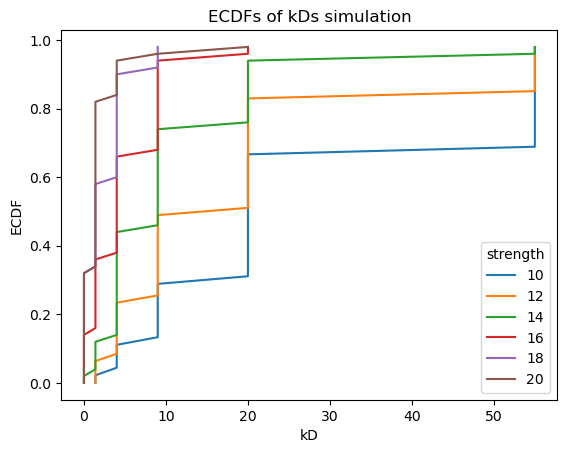

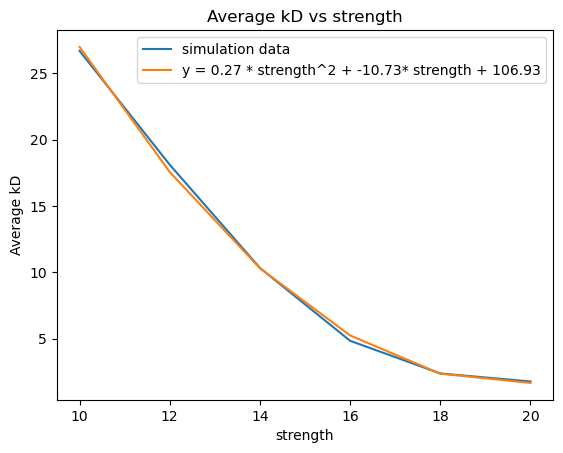

In [97]:
# for plotting kDs

# kDs = []
# print(iterations)
# print(len(iterations))
# for i, iteration in enumerate(iterations):
#     its = list(filter(lambda item: item < 1000, iteration))
#     print(its)
#     kDs.append(np.mean(its))
#     x = np.sort(its)
#     y = np.arange(len(its))/float(len(its))
#     plt.plot(x, y, label = strengths[i])

# a, b, c = np.polyfit(strengths, kDs, 2)
# strengths = np.array(strengths)

# plt.legend(title="strength")
# plt.title('ECDFs of kDs simulation')
# plt.xlabel('kD')
# plt.ylabel('ECDF')
# cal = a*strengths**2 +b*strengths + c
# plt.figure('Average iteration number until total consumption vs area')
# plt.title('Average kD vs strength')
# plt.plot(strengths, kDs, label='simulation data')
# plt.plot(strengths, a*strengths**2 +b*strengths + c, label = f'y = {round(a,2)} * strength^2 + {round(b,2)}* strength + {round(c,2)}' )
# plt.xlabel('strength')
# plt.ylabel('Average kD')
# #print(r_value)
# plt.legend()
# print(r2_score(cal, kDs))